# Load Library

In [1]:
# general imports
import sys
import os
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import multiprocessing as mp
import wandb
from sklearn.model_selection import train_test_split 

In [2]:
torch.__version__

'2.2.2'

In [3]:
# get the DGD modules (once the current version is public we can switch to the repo)
# git clone https://github.com/Center-for-Health-Data-Science/DeepGenerativeDecoder.git
# for now I added them to this repo, but the imports will stay the same
from base.dgd.nn import NB_Module
from base.dgd.DGD import DGD

# get the new stuff
from base.utils.helpers import set_seed, get_activation
from base.model.decoder_debug import Decoder
from base.data.combined import GeneExpressionDatasetCombined
from base.engine.train import train_midgd

# Set seeds, device, and directory

In [4]:
# set random seeds, device and data directory
seed = 42
set_seed(seed)

num_workers = 16

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

datadir = "./data/"

cuda


# Load Data

In [5]:
# tcga_mrna_raw = pd.read_table("data/TCGA_mrna_counts_match_transposed.tsv", sep='\t', index_col=[0])
# tcga_mirna_raw = pd.read_table("data/TCGA_mirna_counts_match_transposed.tsv", sep='\t', index_col=[0])
tcga_mrna_raw = pd.read_table("data/TCGA_mrna_counts_match_iso.tsv", sep='\t', index_col=[0])
tcga_mirna_raw = pd.read_table("data/TCGA_mirna_counts_match_iso.tsv", sep='\t', index_col=[0])

In [6]:
def data_filtering(df, filter_zero=True, filter_tumor=False):
    if filter_zero:
        zero_counts = (df == 0).mean()
        selected_features = zero_counts[zero_counts < 0.99].index
        df = df[selected_features]
    if filter_tumor:
        df = df[df['sample_type'].isin(['Primary Tumor', 'Solid Tissue Normal'])]
        
    return df

tcga_mrna = data_filtering(tcga_mrna_raw)
tcga_mirna = data_filtering(tcga_mirna_raw)

In [7]:
# shuffle the data
tcga_mrna = tcga_mrna.sample(frac=1, random_state=seed)
tcga_mirna = tcga_mirna.sample(frac=1, random_state=seed)

In [8]:
# make data split for train, validation, and test sets
train_ratio= 0.7

train_mrna, val_mrna = train_test_split(tcga_mrna, train_size=train_ratio, stratify=tcga_mrna['cancer_type'], random_state=seed) 
val_mrna, test_mrna = train_test_split(val_mrna, test_size=0.50, stratify=val_mrna['cancer_type'], random_state=seed)

# Get the indices of the samples in each split
train_idx = train_mrna.index
val_idx = val_mrna.index
test_idx = test_mrna.index

# Use the same indices to split tcga_mirna
train_mirna = tcga_mirna.loc[train_idx]
val_mirna = tcga_mirna.loc[val_idx]
test_mirna = tcga_mirna.loc[test_idx]

In [9]:
# Subset the gene, so we don't use all genes when training the model
# Only subset the n most varied genes
is_subset = False
n = 5000

if is_subset:
    # Extract the expression data (excluding the last four columns)
    expression_data = train_mrna.iloc[:, :-4]
    variances = expression_data.var(axis=0)
    top_gene = variances.nlargest(n).index
    selected_columns = expression_data[top_gene].columns

    annot = train_mrna.iloc[:,-4:].columns
    train_mrna = train_mrna[selected_columns.append(annot)]
    val_mrna = val_mrna[selected_columns.append(annot)]
    test_mrna = test_mrna[selected_columns.append(annot)]

In [10]:
# Train, val, and test data loaders
batch_size = 128

# Default scaling_type = "mean"
train_dataset = GeneExpressionDatasetCombined(train_mrna, train_mirna, scaling_type='mean')
validation_dataset = GeneExpressionDatasetCombined(val_mrna, val_mirna, scaling_type='mean')
test_dataset = GeneExpressionDatasetCombined(test_mrna, test_mirna, scaling_type='mean')

train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True,
                                           num_workers=num_workers)
validation_loader = torch.utils.data.DataLoader(validation_dataset, 
                                                batch_size=batch_size, 
                                                shuffle=False,
                                                num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False,
                                          num_workers=num_workers)

In [11]:
# Out dimension of mRNA and miRNA
mrna_out_dim = train_mrna.shape[1]-4
mirna_out_dim = train_mirna.shape[1]-4

In [12]:
print(train_loader.dataset.mrna_data.shape)
print(validation_loader.dataset.mrna_data.shape)
print(test_loader.dataset.mrna_data.shape)

print(train_loader.dataset.mirna_data.shape)
print(validation_loader.dataset.mirna_data.shape)
print(test_loader.dataset.mirna_data.shape)

print(mrna_out_dim)
print(mirna_out_dim)

torch.Size([7473, 19741])
torch.Size([1601, 19741])
torch.Size([1602, 19741])
torch.Size([7473, 2024])
torch.Size([1601, 2024])
torch.Size([1602, 2024])
19741
2024


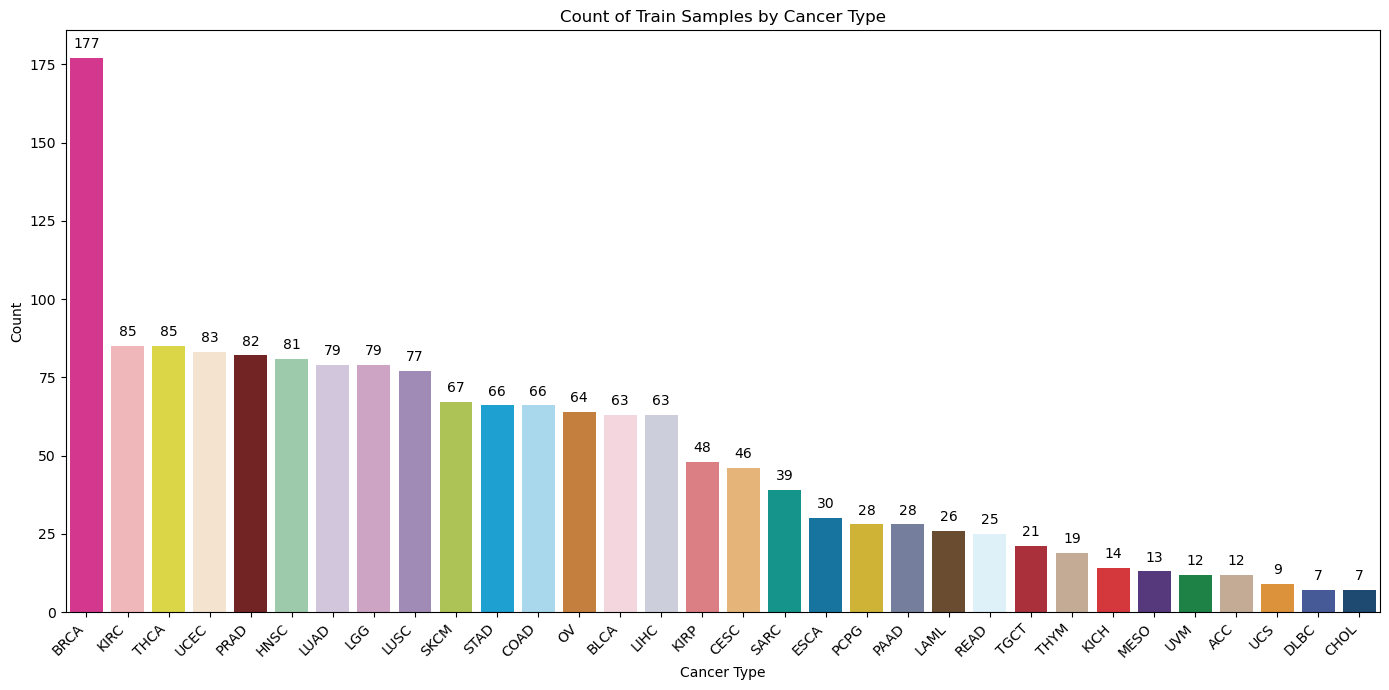

In [13]:
color_mapping = dict(zip(val_mrna['cancer_type'], val_mrna['color']))

primary_site_counts = val_mrna['cancer_type'].value_counts().reset_index()
primary_site_counts.columns = ['cancer_type', 'count']

# Create a bar plot
plt.figure(figsize=(14, 7))
barplot = sns.barplot(x='cancer_type', hue='cancer_type', y='count', data=primary_site_counts, palette=color_mapping)
plt.xlabel('Cancer Type')
plt.ylabel('Count')
plt.title('Count of Train Samples by Cancer Type')
plt.xticks(rotation=45, ha='right')  # Rotate the x labels to show them more clearly

# Annotate each bar with the count
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'),  # Format the count as a string with no decimal places
                     (p.get_x() + p.get_width() / 2., p.get_height()),  # Position the text at the center of the bar
                     ha='center', va='center',  # Center the text horizontally and vertically
                     xytext=(0, 10),  # Offset the text by 10 points vertically
                     textcoords='offset points')  # Use offset points for the text coordinates

plt.tight_layout()  # Adjust the layout to fit the x labels
plt.show()

# Model Setup

In [14]:
# This one is used for n GMM mixture component 
n_tissues = len(np.unique(train_dataset.label))
# n_tissues = 30

# Hyperparameters for Decoder
latent_dim = 20 # For the representation layer 
hidden_dims = [128, 128] # Decoder common hidden dimension
reduction_type = "sum" # Output loss reduction, you can choose "mean". This is how you want calculate the total loss. 
activation = "relu" # ["relu", "leaky_relu"]
r_init = 2

# Hyperparameters for GMM
gmm_mean = 5.0 # usually between 2 and 10
sd_mean = 0.2 # default 0.2

In [15]:
# Output Module setup
# Set up an output module for the miRNA expression data
mirna_out_fc = nn.Sequential(
    nn.Linear(hidden_dims[-1], 128),
    get_activation(activation),
    nn.Linear(128, mirna_out_dim)
    # nn.Linear(hidden_dims[-1], mirna_out_dim)
    )
output_mirna_layer = NB_Module(mirna_out_fc, mirna_out_dim, r_init=r_init, scaling_type="mean")
output_mirna_layer.n_features = mirna_out_dim

# Set up an output module for the mRNA expression data
mrna_out_fc = nn.Sequential(
    nn.Linear(hidden_dims[-1], 128),
    get_activation(activation),
    nn.Linear(128, 512),
    get_activation(activation),
    nn.Linear(512, mrna_out_dim)
    # nn.Linear(hidden_dims[-1], mrna_out_dim)
    )
output_mrna_layer = NB_Module(mrna_out_fc, mrna_out_dim, r_init=r_init, scaling_type="mean")
output_mrna_layer.n_features = mrna_out_dim

# Decoder Setup
decoder = Decoder(latent_dim, 
                  hidden_dims, 
                  output_module_mirna=output_mirna_layer, 
                  output_module_mrna=output_mrna_layer, 
                  activation=activation).to(device)

# GMM init parameter, we will learn this along the way
gmm_mean_scale = gmm_mean # usually between 2 and 10
sd_mean_init = sd_mean * gmm_mean_scale / n_tissues # empirically good for single-cell data at dimensionality 20
gmm_spec={"mean_init": (gmm_mean_scale, 5.0), "sd_init": (sd_mean_init, 1.0), "weight_alpha": 1}

In [16]:
# init a DGD model
dgd = DGD(
        decoder=decoder,
        n_mix=n_tissues,
        rep_dim=latent_dim,
        gmm_spec=gmm_spec
)

In [17]:
dgd

DGD(
  (decoder): Decoder(
    (main): ModuleList(
      (0): Linear(in_features=20, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
    )
    (out_module_mirna): NB_Module(
      (fc): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=2024, bias=True)
      )
    )
    (out_module_mrna): NB_Module(
      (fc): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=512, bias=True)
        (3): ReLU()
        (4): Linear(in_features=512, out_features=19741, bias=True)
      )
    )
  )
  (gmm): GaussianMixture()
)

In [18]:
# Training hyperparameters
learning_rates = {'dec':1e-4,'rep':1e-2,'gmm':1e-2}
weight_decay = 1e-4
betas = (0.5, 0.7)

nepochs = 801
pr = 5 # how often to print epoch
plot = 200 # how often to print plot

sample_mirna = ['MIMAT0000421', 'MIMAT0000422', 'MIMAT0000435', 'MIMAT0000728']
sample_index = [tcga_mirna.columns.get_loc(a) for a in sample_mirna]
subset = sample_index[1]
sample_index = [1382, 1310, 34, 360, 
                765, 999, 2000, 93,
                0, 10, 20, 300, 
                123, 345, 456, 567,
                789, 12, 1050, 56,
                1371, 2, 1304, 4]

In [19]:
print("Hyperparameters:")
print(f"Latent dimension: {latent_dim}")
print(f"Learning rates: {learning_rates}")
print(f"Weight decay: {weight_decay}")
print(f"betas: {betas}")
print(f"Number of epochs: {nepochs}")
print(f"Hidden dimensions: {hidden_dims}")
print(f"Batch size: {batch_size}")
print(f"Reduction type: {reduction_type}")

Hyperparameters:
Latent dimension: 20
Learning rates: {'dec': 0.0001, 'rep': 0.01, 'gmm': 0.01}
Weight decay: 0.0001
betas: (0.5, 0.7)
Number of epochs: 801
Hidden dimensions: [128, 128]
Batch size: 128
Reduction type: sum


# Training

  0%|                                                                                                                                                                                            | 0/801 [00:00<?, ?it/s]

0 train_recon_mirna: 14.434858268091876 train_recon_mrna: 10.890671639183331 train_gmm: 7.838458677475892 train_mse: 3212879.0 train_mae: 1451.741943359375 train_r2: -3.56654691696167 train_spearman: 0.26498353481292725 train_pearson: 0.10546690970659256 train_msle: 43.95487594604492
0 test_recon_mirna: 14.331600355385591 test_recon_mrna: 10.728460483941623 test_gmm: 3.9682312049841895 test_mse: 3054098.0 test_mae: 1454.150634765625 test_r2: -3.769592761993408 test_spearman: 0.26271018385887146 test_pearson: 0.20152975618839264 test_msle: 44.05909729003906


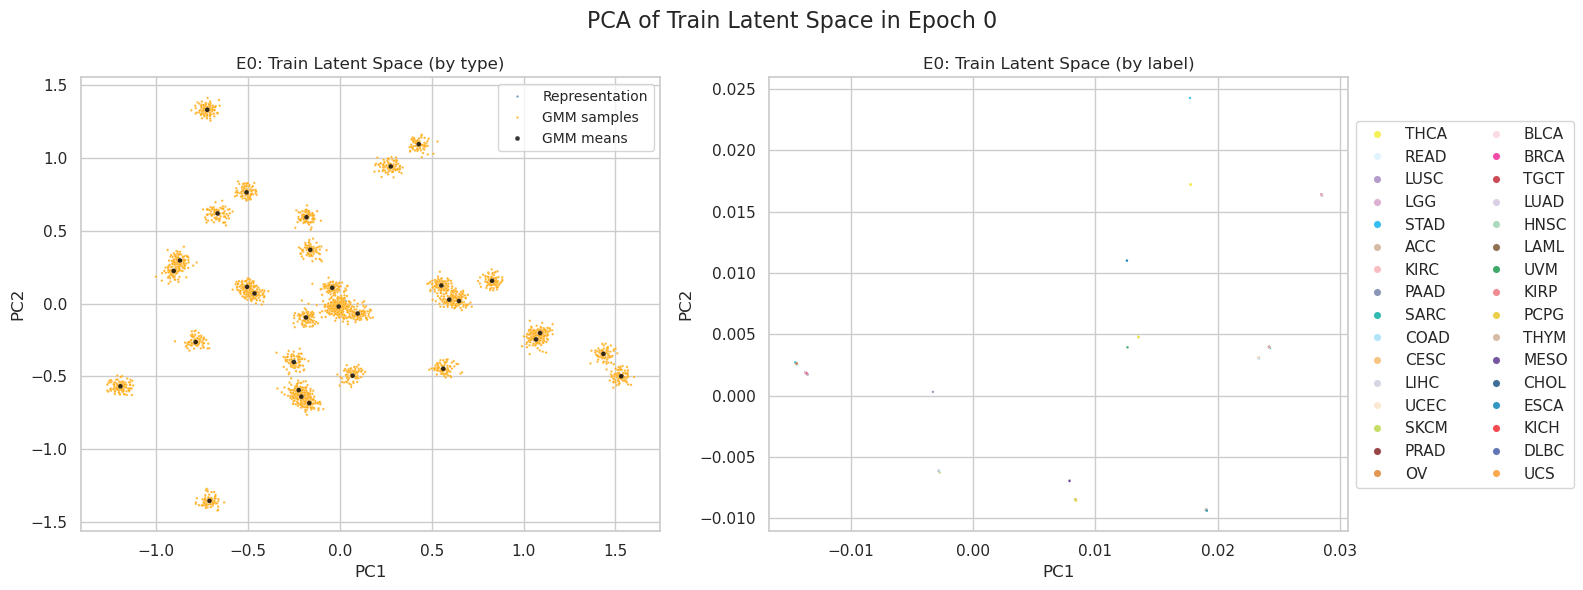

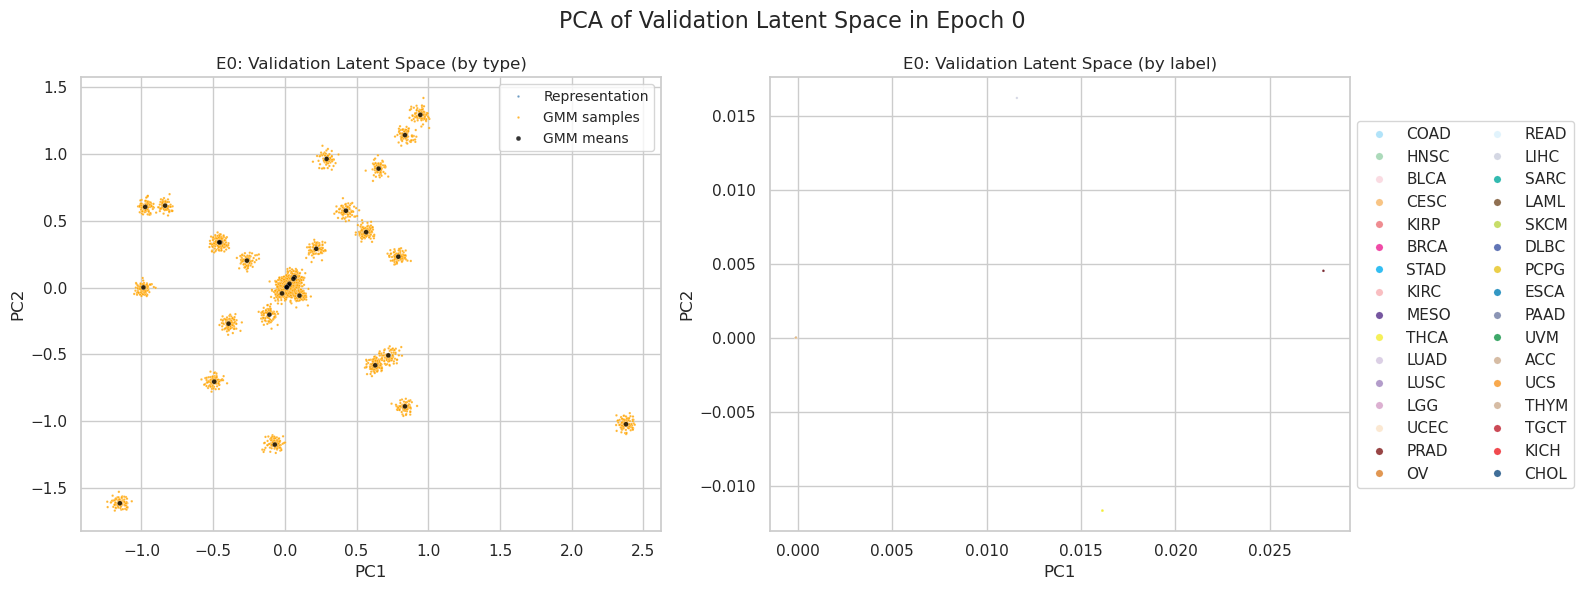

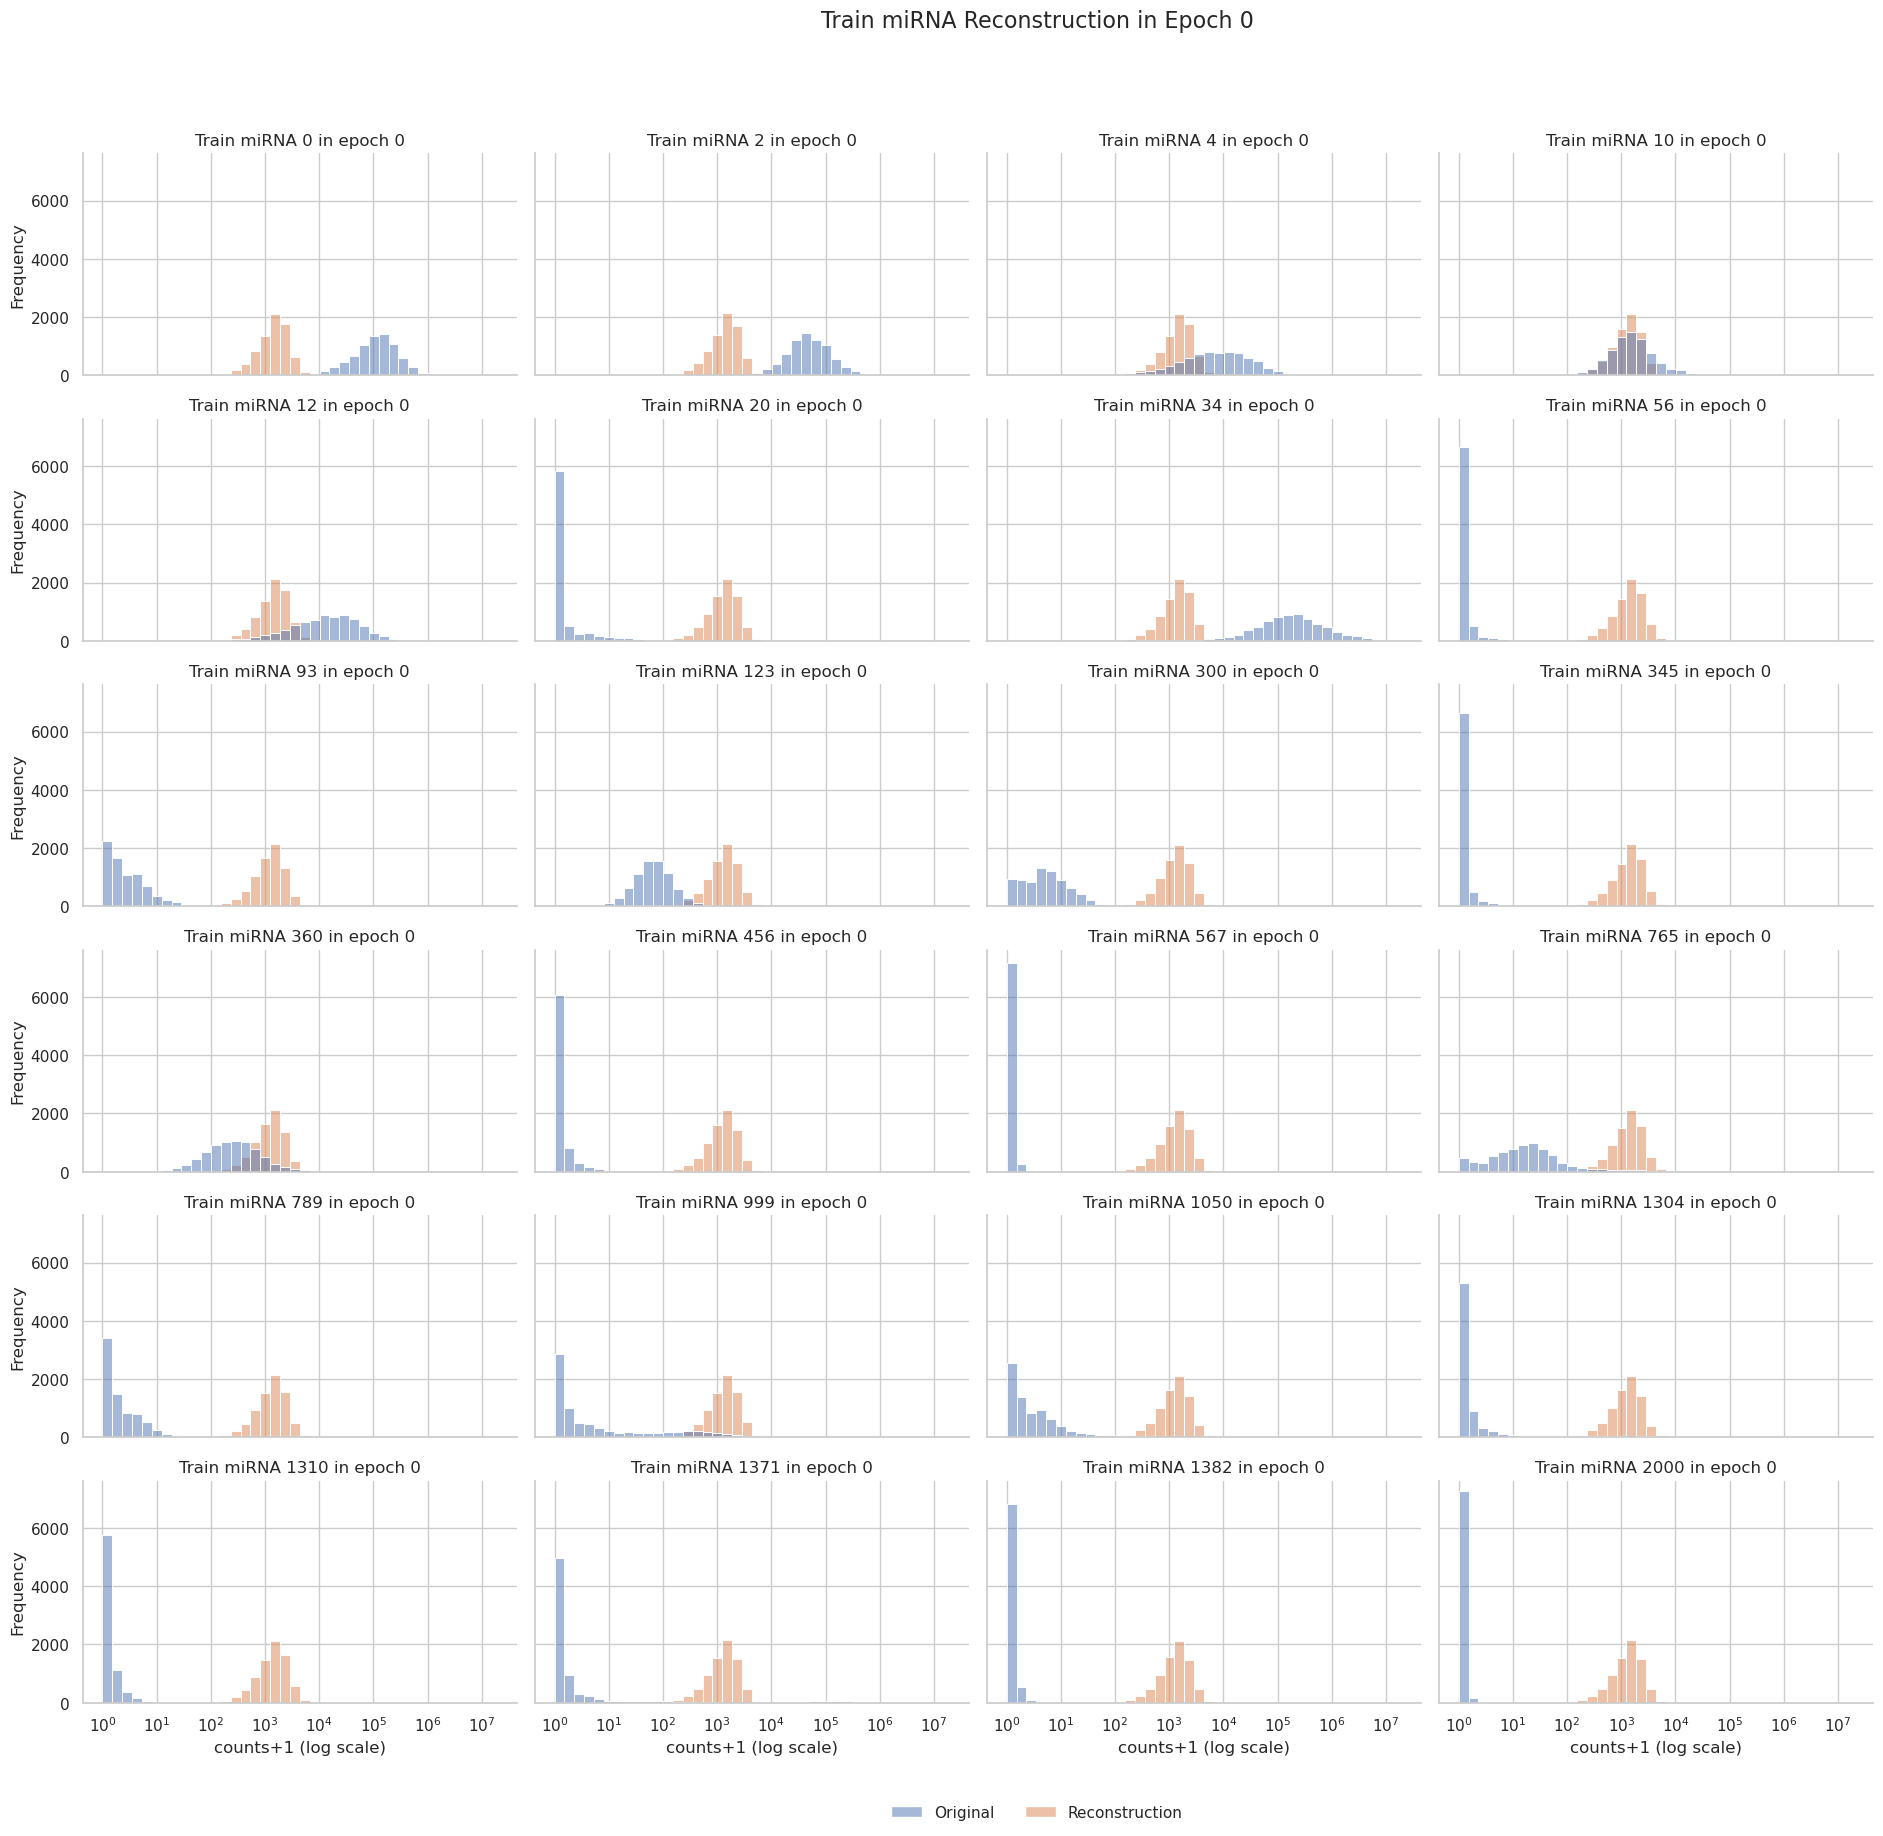

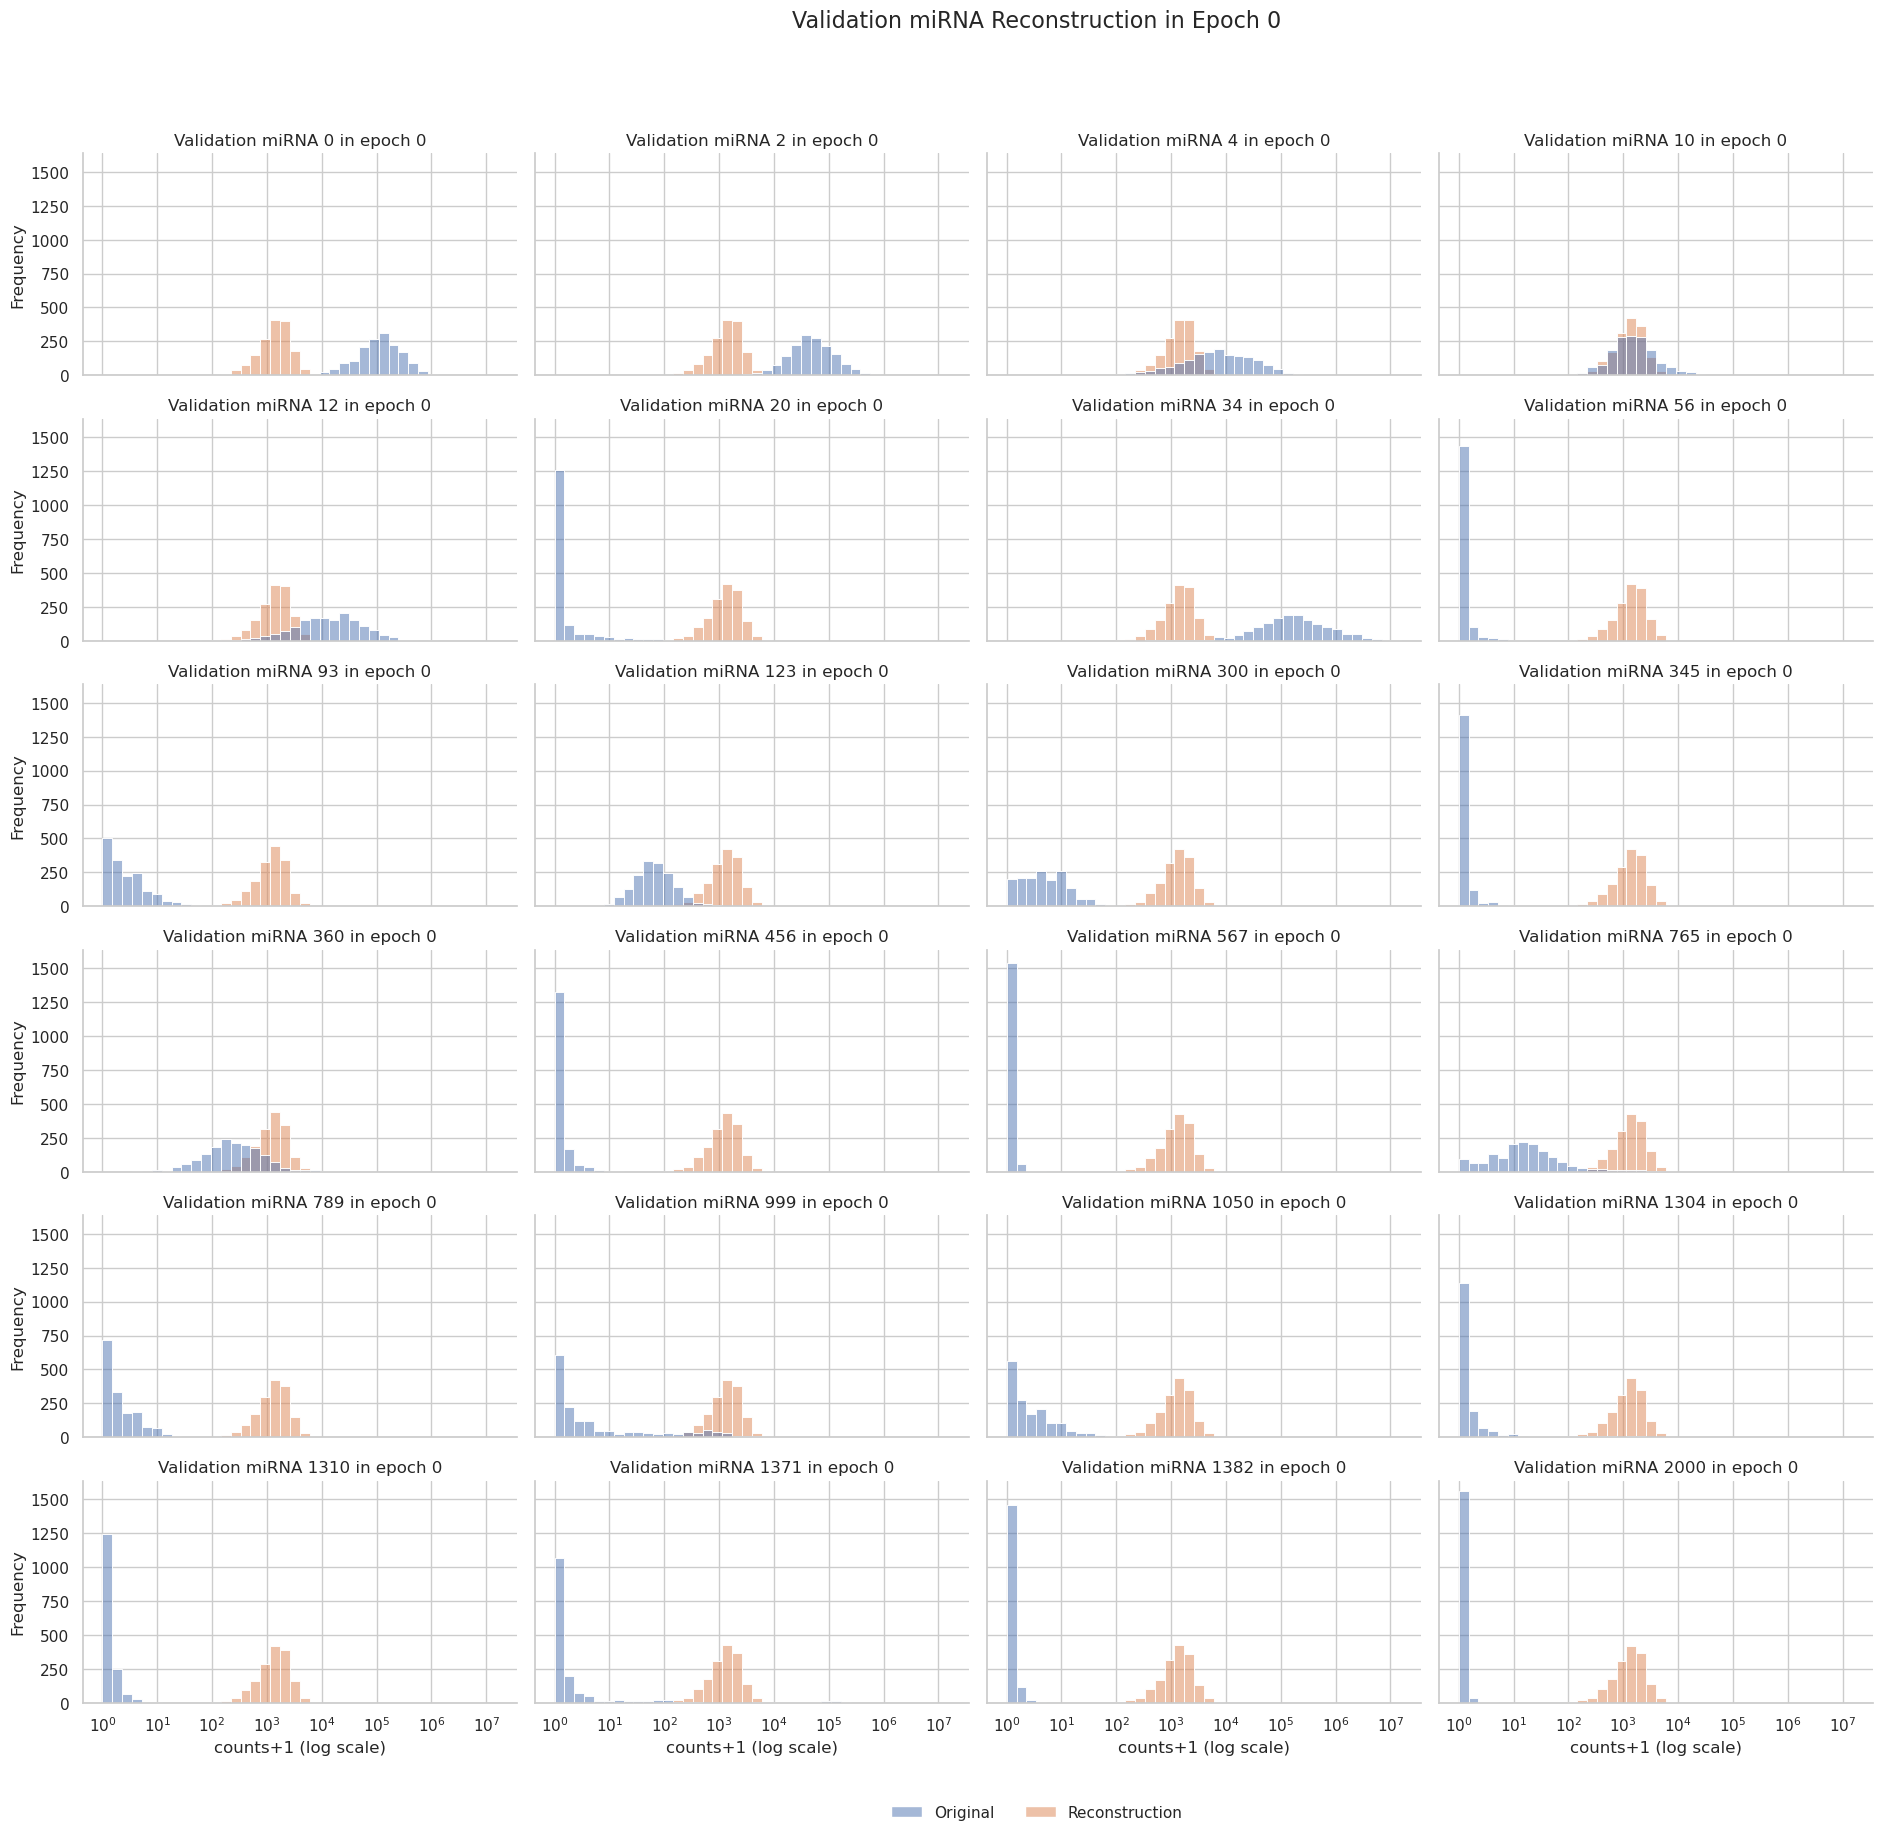

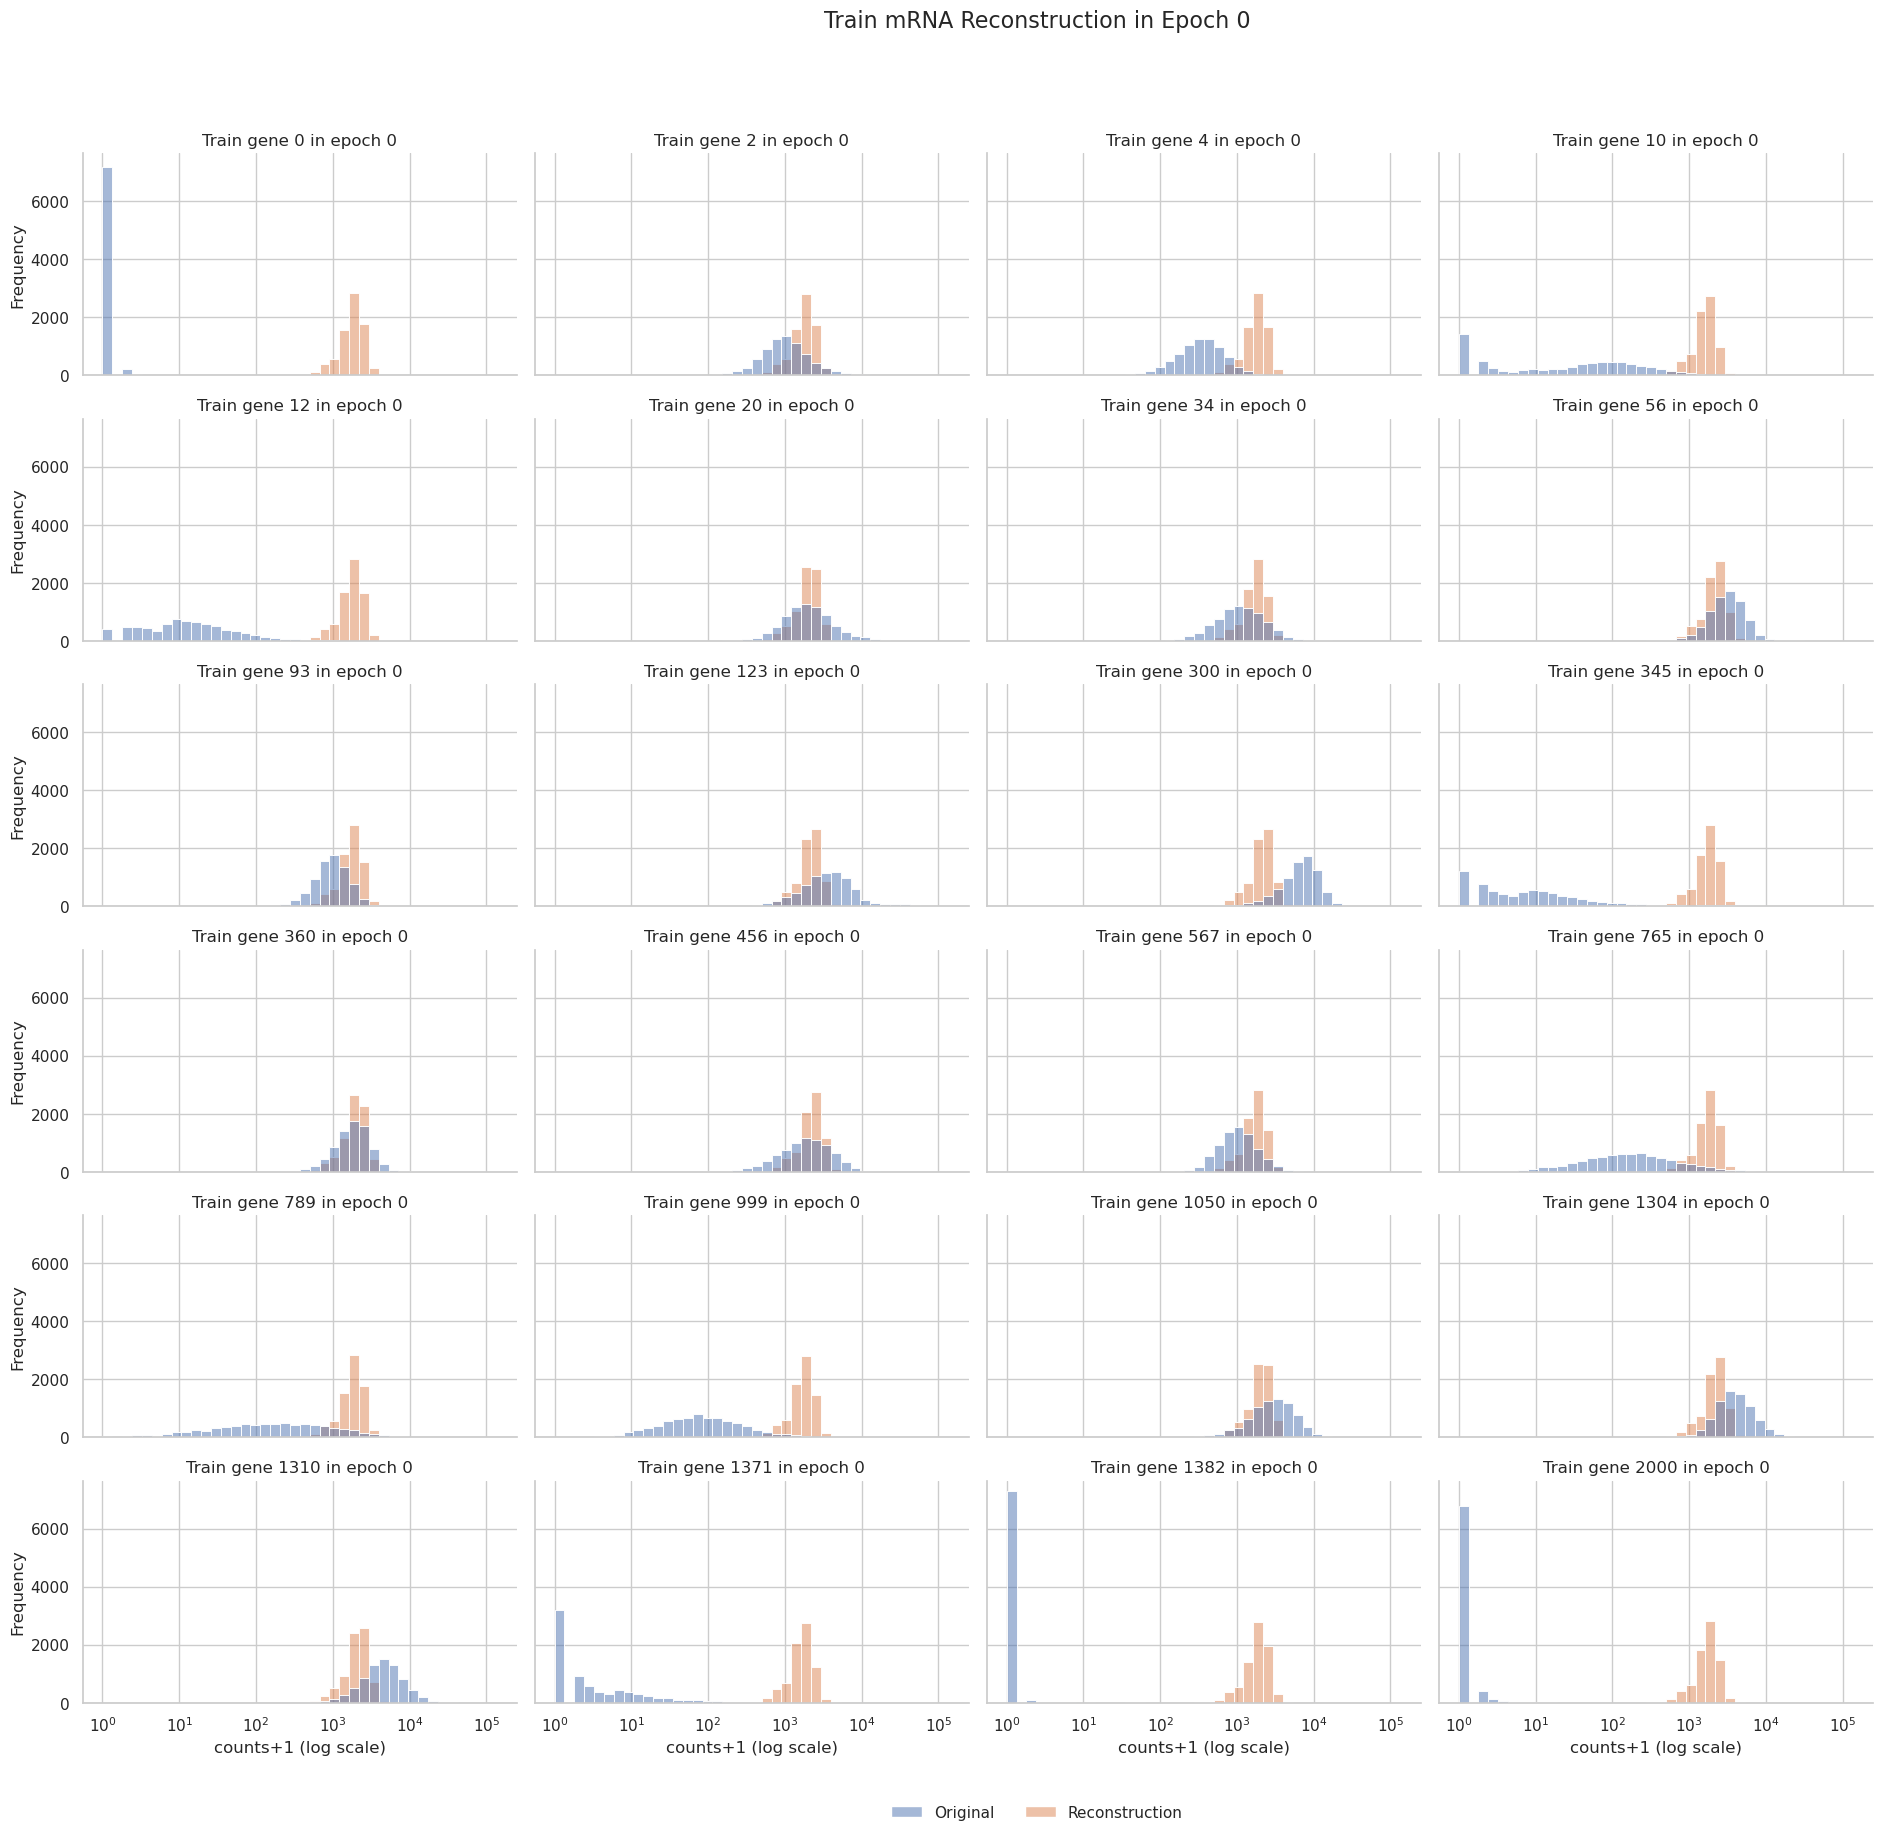

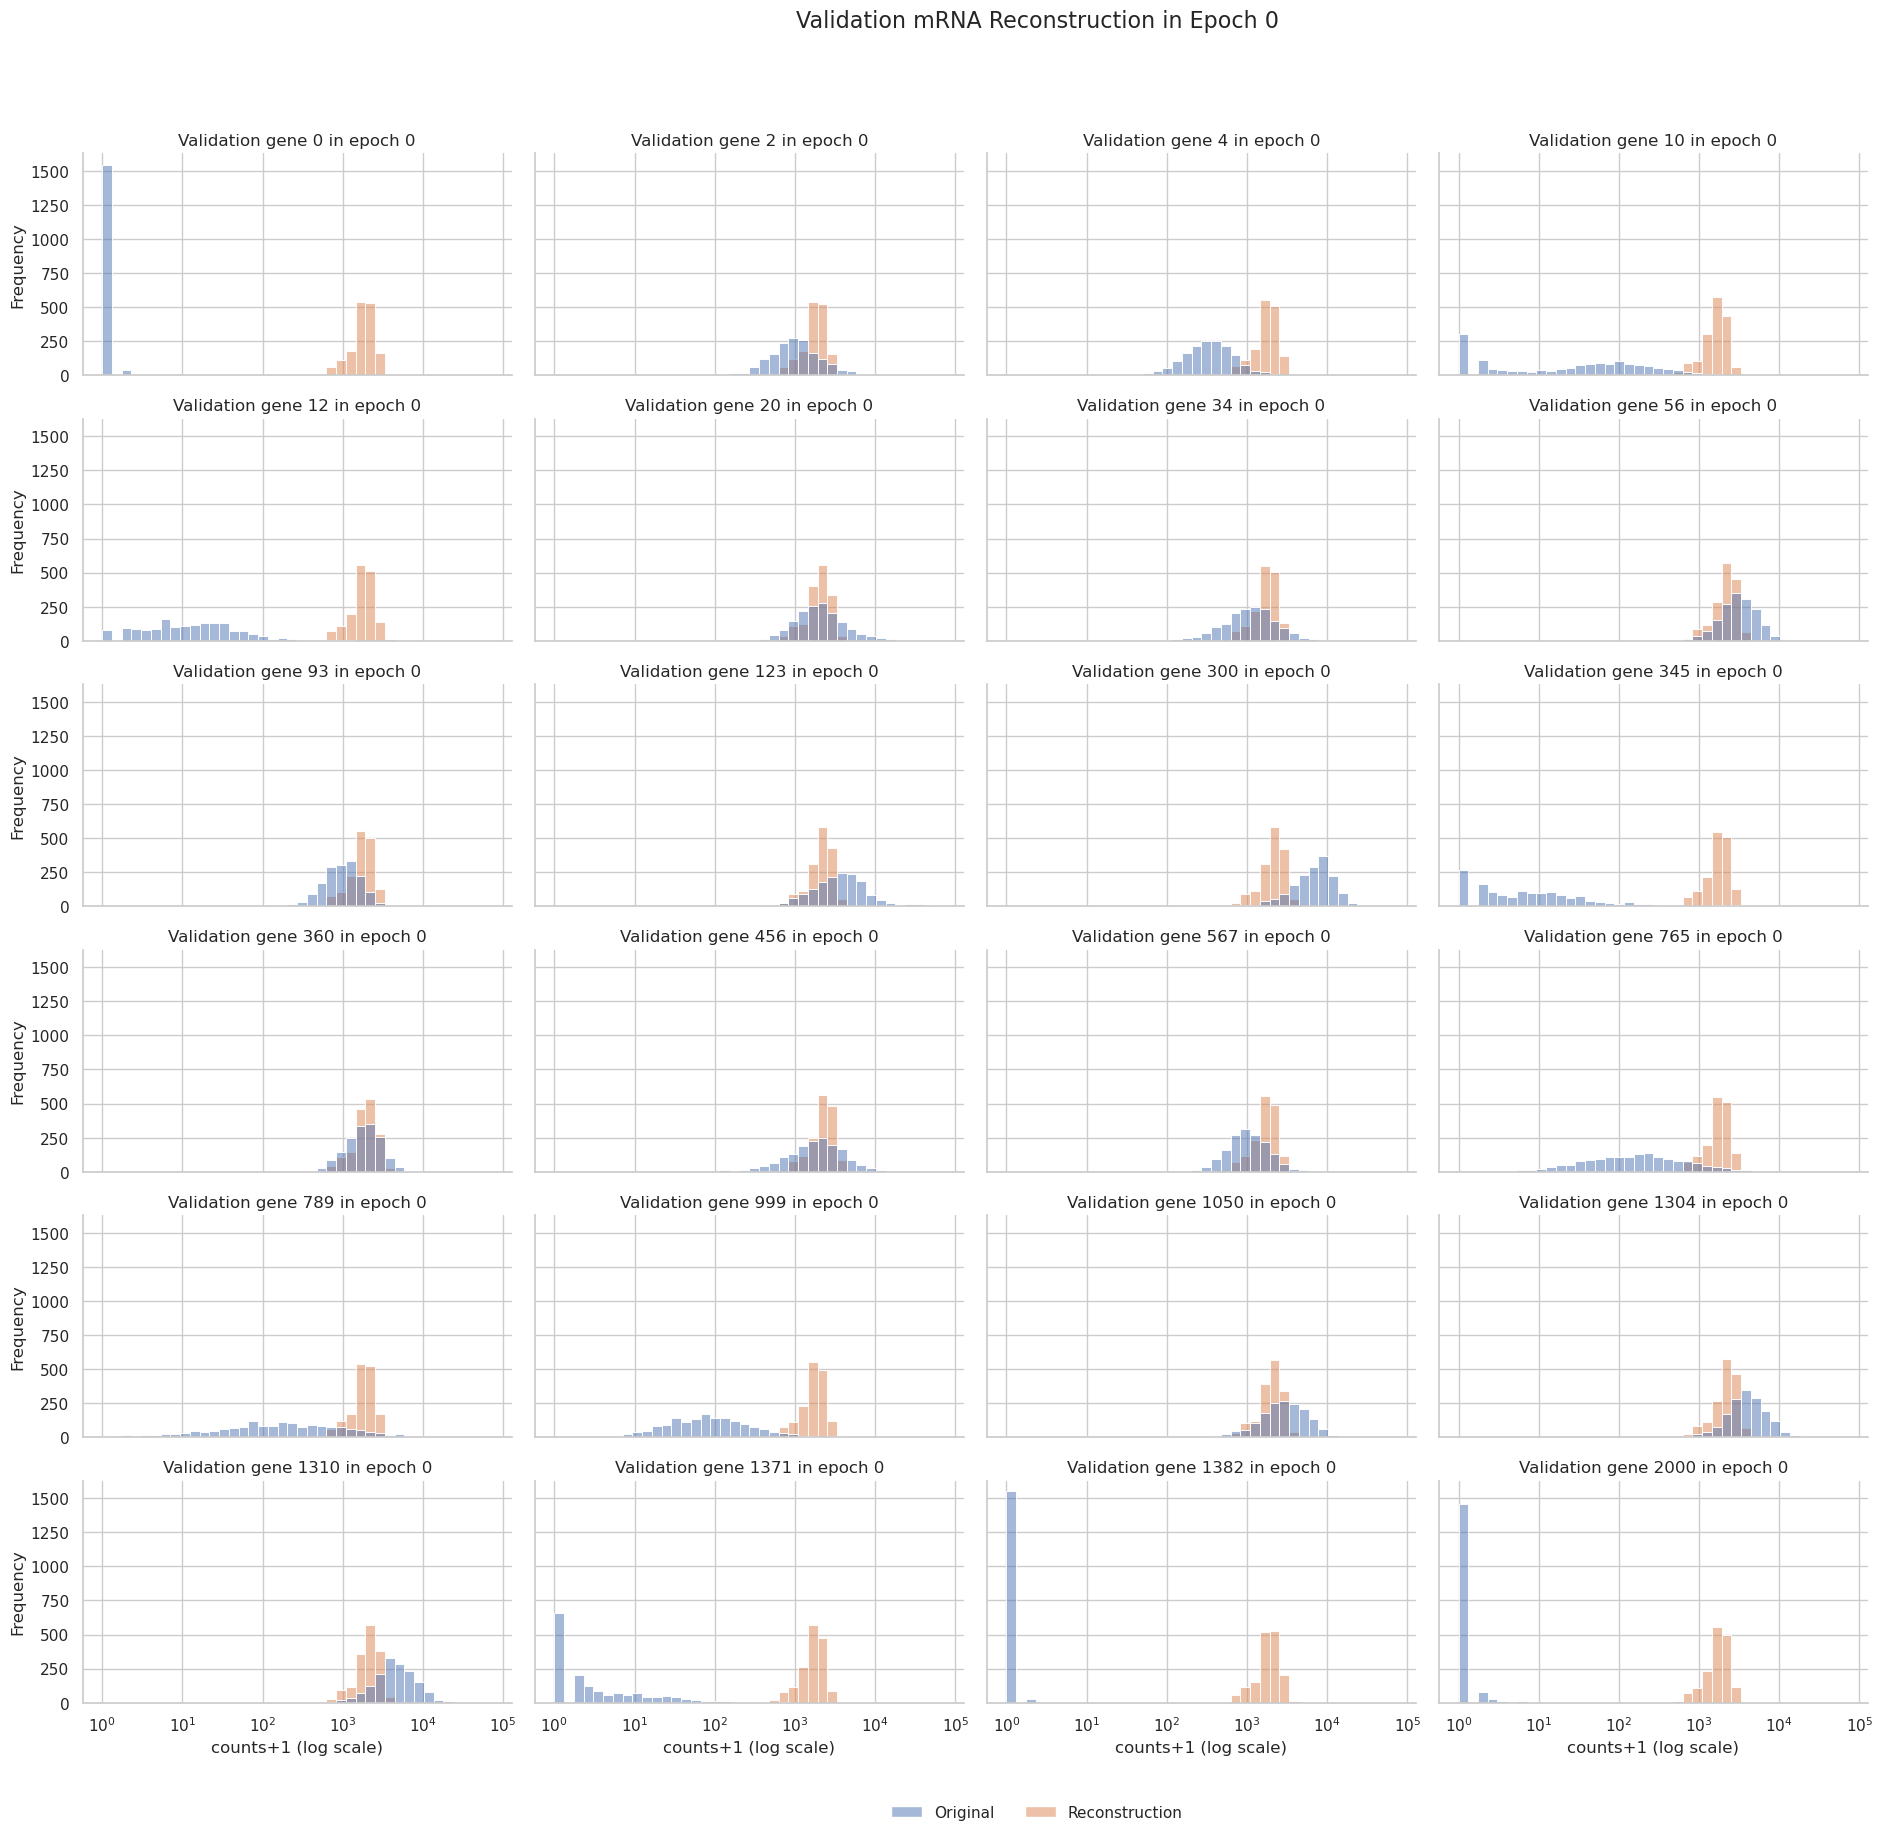

  1%|█▎                                                                                                                                                                                | 6/801 [03:21<3:16:07, 14.80s/it]

5 train_recon_mirna: 10.708104776669 train_recon_mrna: 7.792112324019307 train_gmm: 2.1438781305407804 train_mse: 756564.125 train_mae: 378.9491882324219 train_r2: -0.07532393932342529 train_spearman: 0.3144219219684601 train_pearson: 0.15987145900726318 train_msle: 27.087549209594727
5 test_recon_mirna: 9.901113596554032 test_recon_mrna: 7.7708634752588175 test_gmm: 2.14565093441355 test_mse: 654602.4375 test_mae: 389.5611877441406 test_r2: -0.022294282913208008 test_spearman: 0.30944788455963135 test_pearson: 0.27915146946907043 test_msle: 27.31089973449707


  1%|██▍                                                                                                                                                                              | 11/801 [03:45<1:24:30,  6.42s/it]

10 train_recon_mirna: 2.7079750110939567 train_recon_mrna: 7.687423806296355 train_gmm: 2.146692142820926 train_mse: 699768.625 train_mae: 95.06228637695312 train_r2: 0.005400955677032471 train_spearman: 0.3836160898208618 train_pearson: 0.324897438287735 train_msle: 4.604264736175537
10 test_recon_mirna: 2.7489781526275574 test_recon_mrna: 7.691907010273991 test_gmm: 2.147157401014015 test_mse: 631181.1875 test_mae: 101.41875457763672 test_r2: 0.014282763004302979 test_spearman: 0.36429721117019653 test_pearson: 0.44185784459114075 test_msle: 4.519272804260254


  2%|███▌                                                                                                                                                                             | 16/801 [04:10<1:07:02,  5.12s/it]

15 train_recon_mirna: 2.5437293634967966 train_recon_mrna: 7.662835631639825 train_gmm: 2.147479931660227 train_mse: 695587.5 train_mae: 101.69235229492188 train_r2: 0.011343777179718018 train_spearman: 0.3857693672180176 train_pearson: 0.2841140627861023 train_msle: 6.753098487854004
15 test_recon_mirna: 2.6238578365824967 test_recon_mrna: 7.666500291833586 test_gmm: 2.1478424739420676 test_mse: 625519.375 test_mae: 107.6538314819336 test_r2: 0.0231248140335083 test_spearman: 0.36697906255722046 test_pearson: 0.4034746587276459 test_msle: 6.6173224449157715


  3%|████▋                                                                                                                                                                            | 21/801 [04:35<1:06:14,  5.10s/it]

20 train_recon_mirna: 2.5174143168287917 train_recon_mrna: 7.629718341075742 train_gmm: 2.147636950378132 train_mse: 696172.375 train_mae: 101.02767944335938 train_r2: 0.01051241159439087 train_spearman: 0.3904544413089752 train_pearson: 0.28673478960990906 train_msle: 6.6930341720581055
20 test_recon_mirna: 2.586016395925348 test_recon_mrna: 7.62986806565384 test_gmm: 2.1475895878674462 test_mse: 627133.375 test_mae: 107.70320892333984 test_r2: 0.020604193210601807 test_spearman: 0.3677947223186493 test_pearson: 0.3959067761898041 test_msle: 6.705210208892822


  3%|█████▋                                                                                                                                                                           | 26/801 [05:00<1:05:09,  5.04s/it]

25 train_recon_mirna: 2.4703901312511602 train_recon_mrna: 7.534421873932486 train_gmm: 2.1500587891147713 train_mse: 699098.1875 train_mae: 113.26312255859375 train_r2: 0.006353914737701416 train_spearman: 0.36230912804603577 train_pearson: 0.16990026831626892 train_msle: 9.481648445129395
25 test_recon_mirna: 2.539188110491096 test_recon_mrna: 7.532371759570637 test_gmm: 2.1509085355588304 test_mse: 632229.375 test_mae: 121.56902313232422 test_r2: 0.012645840644836426 test_spearman: 0.34195318818092346 test_pearson: 0.24713817238807678 test_msle: 9.752161026000977


  4%|██████▊                                                                                                                                                                          | 31/801 [05:25<1:04:32,  5.03s/it]

30 train_recon_mirna: 2.45328339094191 train_recon_mrna: 7.441901305161577 train_gmm: 2.152776479701927 train_mse: 698262.0625 train_mae: 122.38365936279297 train_r2: 0.00754237174987793 train_spearman: 0.3319639563560486 train_pearson: 0.12566977739334106 train_msle: 10.78255558013916
30 test_recon_mirna: 2.5589886346663278 test_recon_mrna: 7.441694743935843 test_gmm: 2.152772109289604 test_mse: 633195.6875 test_mae: 130.16795349121094 test_r2: 0.01113671064376831 test_spearman: 0.31553584337234497 test_pearson: 0.1557515412569046 test_msle: 10.818334579467773


  4%|███████▉                                                                                                                                                                         | 36/801 [05:50<1:03:30,  4.98s/it]

35 train_recon_mirna: 2.407119037626364 train_recon_mrna: 7.3587555864367555 train_gmm: 2.1544153810488593 train_mse: 697394.5 train_mae: 116.19971466064453 train_r2: 0.00877535343170166 train_spearman: 0.3686743974685669 train_pearson: 0.12946228682994843 train_msle: 9.496504783630371
35 test_recon_mirna: 2.5194086676620095 test_recon_mrna: 7.367061598860775 test_gmm: 2.1550358998038335 test_mse: 632506.3125 test_mae: 124.07674407958984 test_r2: 0.012213289737701416 test_spearman: 0.3485431671142578 test_pearson: 0.15422850847244263 test_msle: 9.429759979248047


  5%|█████████                                                                                                                                                                        | 41/801 [06:14<1:01:51,  4.88s/it]

40 train_recon_mirna: 2.319999621950947 train_recon_mrna: 7.310151508197354 train_gmm: 2.156636756908203 train_mse: 693029.6875 train_mae: 103.95487976074219 train_r2: 0.014979243278503418 train_spearman: 0.3681376576423645 train_pearson: 0.18076610565185547 train_msle: 6.2728424072265625
40 test_recon_mirna: 2.4619151980574148 test_recon_mrna: 7.321176569491846 test_gmm: 2.157473371745198 test_mse: 627711.9375 test_mae: 112.28312683105469 test_r2: 0.019700706005096436 test_spearman: 0.353676974773407 test_pearson: 0.2049708515405655 test_msle: 6.418513298034668


  6%|██████████▏                                                                                                                                                                      | 46/801 [06:43<1:09:10,  5.50s/it]

45 train_recon_mirna: 2.2772665865065487 train_recon_mrna: 7.259532486581737 train_gmm: 2.1581669318792445 train_mse: 674607.25 train_mae: 93.25287628173828 train_r2: 0.041163504123687744 train_spearman: 0.33934545516967773 train_pearson: 0.32089701294898987 train_msle: 3.1312191486358643
45 test_recon_mirna: 2.4124748508991414 test_recon_mrna: 7.27054155182189 test_gmm: 2.1595835488561836 test_mse: 604854.6875 test_mae: 100.82726287841797 test_r2: 0.0553969144821167 test_spearman: 0.32101231813430786 test_pearson: 0.4028381109237671 test_msle: 3.3761184215545654


  6%|███████████▎                                                                                                                                                                     | 51/801 [07:08<1:03:46,  5.10s/it]

50 train_recon_mirna: 2.2582733260521803 train_recon_mrna: 7.185676110068042 train_gmm: 2.1604743727810742 train_mse: 627936.6875 train_mae: 89.53378295898438 train_r2: 0.10749757289886475 train_spearman: 0.3090464770793915 train_pearson: 0.4224548041820526 train_msle: 2.6323773860931396
50 test_recon_mirna: 2.361234845347399 test_recon_mrna: 7.1976032152287175 test_gmm: 2.161919857218145 test_mse: 541657.4375 test_mae: 96.19906616210938 test_r2: 0.15409225225448608 test_spearman: 0.28113216161727905 test_pearson: 0.5560792684555054 test_msle: 3.001866579055786


  7%|████████████▎                                                                                                                                                                    | 56/801 [07:33<1:02:35,  5.04s/it]

55 train_recon_mirna: 2.232767725422192 train_recon_mrna: 7.108329780872387 train_gmm: 2.1645547947219366 train_mse: 601879.3125 train_mae: 87.34075927734375 train_r2: 0.14453357458114624 train_spearman: 0.29093217849731445 train_pearson: 0.47460904717445374 train_msle: 2.4398889541625977
55 test_recon_mirna: 2.3209606404902567 test_recon_mrna: 7.120210346725891 test_gmm: 2.166446607162028 test_mse: 504030.4375 test_mae: 92.79839324951172 test_r2: 0.21285438537597656 test_spearman: 0.2587459087371826 test_pearson: 0.6091248989105225 test_msle: 2.7110328674316406


  8%|█████████████▍                                                                                                                                                                   | 61/801 [07:58<1:00:33,  4.91s/it]

60 train_recon_mirna: 2.200954087713132 train_recon_mrna: 7.049550307554692 train_gmm: 2.168976229465137 train_mse: 600287.0625 train_mae: 85.83108520507812 train_r2: 0.14679670333862305 train_spearman: 0.2951093316078186 train_pearson: 0.5048336386680603 train_msle: 2.392415761947632
60 test_recon_mirna: 2.3217732463406024 test_recon_mrna: 7.06155355197718 test_gmm: 2.1718422750917394 test_mse: 503860.0625 test_mae: 92.2517318725586 test_r2: 0.2131204605102539 test_spearman: 0.2552708089351654 test_pearson: 0.6161172986030579 test_msle: 2.6276397705078125


  8%|██████████████▌                                                                                                                                                                  | 66/801 [08:23<1:00:55,  4.97s/it]

65 train_recon_mirna: 2.177289458701523 train_recon_mrna: 6.997370128226775 train_gmm: 2.172610499360197 train_mse: 596780.0 train_mae: 85.39138793945312 train_r2: 0.1517813801765442 train_spearman: 0.31290146708488464 train_pearson: 0.4974544048309326 train_msle: 2.331935167312622
65 test_recon_mirna: 2.297322935208479 test_recon_mrna: 7.010157428771295 test_gmm: 2.1755514589270377 test_mse: 494756.5625 test_mae: 92.77874755859375 test_r2: 0.22733741998672485 test_spearman: 0.2663086950778961 test_pearson: 0.6162816882133484 test_msle: 2.6378509998321533


  9%|███████████████▊                                                                                                                                                                   | 71/801 [08:47<58:18,  4.79s/it]

70 train_recon_mirna: 2.1588615890145895 train_recon_mrna: 6.9495030225252155 train_gmm: 2.1752790873969206 train_mse: 597197.1875 train_mae: 82.60375213623047 train_r2: 0.1511884331703186 train_spearman: 0.3379766643047333 train_pearson: 0.48260900378227234 train_msle: 2.018948793411255
70 test_recon_mirna: 2.2739121196022496 test_recon_mrna: 6.963576757485388 test_gmm: 2.1777372113620395 test_mse: 481620.5625 test_mae: 89.82986450195312 test_r2: 0.24785196781158447 test_spearman: 0.28734591603279114 test_pearson: 0.6321499943733215 test_msle: 2.3162920475006104


  9%|████████████████▉                                                                                                                                                                  | 76/801 [09:12<58:55,  4.88s/it]

75 train_recon_mirna: 2.140651678098136 train_recon_mrna: 6.906657947300995 train_gmm: 2.177115339832773 train_mse: 594178.125 train_mae: 82.80984497070312 train_r2: 0.15547949075698853 train_spearman: 0.3644171357154846 train_pearson: 0.4491007626056671 train_msle: 1.8137967586517334
75 test_recon_mirna: 2.2398004859857847 test_recon_mrna: 6.920966649276146 test_gmm: 2.1784789200353294 test_mse: 471541.3125 test_mae: 89.4655532836914 test_r2: 0.26359277963638306 test_spearman: 0.3116663992404938 test_pearson: 0.6128448843955994 test_msle: 2.1055729389190674


 10%|██████████████████                                                                                                                                                                 | 81/801 [09:36<58:35,  4.88s/it]

80 train_recon_mirna: 2.1217750771188664 train_recon_mrna: 6.8678379053978516 train_gmm: 2.1792711737515473 train_mse: 592449.375 train_mae: 82.15253448486328 train_r2: 0.15793657302856445 train_spearman: 0.38383400440216064 train_pearson: 0.4425581097602844 train_msle: 1.6456358432769775
80 test_recon_mirna: 2.2096430416976296 test_recon_mrna: 6.885233068676588 test_gmm: 2.179001634110517 test_mse: 479980.3125 test_mae: 88.77897644042969 test_r2: 0.25041353702545166 test_spearman: 0.32659047842025757 test_pearson: 0.5887572765350342 test_msle: 1.9007047414779663


 11%|███████████████████▏                                                                                                                                                               | 86/801 [10:01<59:38,  5.01s/it]

85 train_recon_mirna: 2.10234658299192 train_recon_mrna: 6.834577740253613 train_gmm: 2.182071507230718 train_mse: 593258.875 train_mae: 82.97482299804688 train_r2: 0.1567860245704651 train_spearman: 0.3956945538520813 train_pearson: 0.4313367009162903 train_msle: 1.6204575300216675
85 test_recon_mirna: 2.1894271108503083 test_recon_mrna: 6.854489878783463 test_gmm: 2.1819401356818005 test_mse: 480444.90625 test_mae: 89.95782470703125 test_r2: 0.24968796968460083 test_spearman: 0.3392084240913391 test_pearson: 0.5682032704353333 test_msle: 1.8492376804351807


 11%|████████████████████▎                                                                                                                                                              | 91/801 [10:26<59:27,  5.02s/it]

90 train_recon_mirna: 2.0840638245972722 train_recon_mrna: 6.806196392079788 train_gmm: 2.1850852603879174 train_mse: 592399.3125 train_mae: 82.51018524169922 train_r2: 0.15800774097442627 train_spearman: 0.40392592549324036 train_pearson: 0.43715664744377136 train_msle: 1.587469220161438
90 test_recon_mirna: 2.174072609788102 test_recon_mrna: 6.825273487794357 test_gmm: 2.182776694741568 test_mse: 483587.78125 test_mae: 89.81363677978516 test_r2: 0.2447797656059265 test_spearman: 0.3464849293231964 test_pearson: 0.563206136226654 test_msle: 1.8142544031143188


 12%|█████████████████████▍                                                                                                                                                             | 96/801 [10:50<57:53,  4.93s/it]

95 train_recon_mirna: 2.0677042383873117 train_recon_mrna: 6.781528817048705 train_gmm: 2.187662391249122 train_mse: 588370.4375 train_mae: 82.12940979003906 train_r2: 0.1637340784072876 train_spearman: 0.4066930413246155 train_pearson: 0.4456927180290222 train_msle: 1.5603865385055542
95 test_recon_mirna: 2.1553970541355083 test_recon_mrna: 6.8041824006898075 test_gmm: 2.1857686144645925 test_mse: 479293.03125 test_mae: 89.70167541503906 test_r2: 0.2514868974685669 test_spearman: 0.35381680727005005 test_pearson: 0.5733187198638916 test_msle: 1.8276852369308472


 13%|██████████████████████▍                                                                                                                                                           | 101/801 [11:15<56:34,  4.85s/it]

100 train_recon_mirna: 2.0536651663544756 train_recon_mrna: 6.760088685747932 train_gmm: 2.1903300285977436 train_mse: 585118.1875 train_mae: 81.82868194580078 train_r2: 0.16835659742355347 train_spearman: 0.4091898202896118 train_pearson: 0.4521806538105011 train_msle: 1.4888046979904175
100 test_recon_mirna: 2.1432304846526256 test_recon_mrna: 6.780687036409447 test_gmm: 2.187384700358175 test_mse: 478473.9375 test_mae: 89.44401550292969 test_r2: 0.25276607275009155 test_spearman: 0.36147835850715637 test_pearson: 0.5807726383209229 test_msle: 1.7285187244415283


 13%|███████████████████████▌                                                                                                                                                          | 106/801 [11:40<57:28,  4.96s/it]

105 train_recon_mirna: 2.040339558089293 train_recon_mrna: 6.741315220110602 train_gmm: 2.19275091991325 train_mse: 581395.9375 train_mae: 81.4706039428711 train_r2: 0.17364710569381714 train_spearman: 0.41498270630836487 train_pearson: 0.46229246258735657 train_msle: 1.4319363832473755
105 test_recon_mirna: 2.1330257533427726 test_recon_mrna: 6.765442840816051 test_gmm: 2.190100547509369 test_mse: 479017.28125 test_mae: 88.99938201904297 test_r2: 0.2519175410270691 test_spearman: 0.3646129369735718 test_pearson: 0.5881831645965576 test_msle: 1.6931273937225342


 14%|████████████████████████▋                                                                                                                                                         | 111/801 [12:05<57:59,  5.04s/it]

110 train_recon_mirna: 2.0282450120830244 train_recon_mrna: 6.72416160413444 train_gmm: 2.1952746799284717 train_mse: 577613.8125 train_mae: 80.57341003417969 train_r2: 0.17902278900146484 train_spearman: 0.41962930560112 train_pearson: 0.4774705171585083 train_msle: 1.3416355848312378
110 test_recon_mirna: 2.122971195281852 test_recon_mrna: 6.748074035967528 test_gmm: 2.1924521356281232 test_mse: 474992.46875 test_mae: 88.961669921875 test_r2: 0.25820308923721313 test_spearman: 0.3716381788253784 test_pearson: 0.5938810706138611 test_msle: 1.624360203742981


 14%|█████████████████████████▊                                                                                                                                                        | 116/801 [12:30<57:57,  5.08s/it]

115 train_recon_mirna: 2.0172067348829303 train_recon_mrna: 6.7084943921820495 train_gmm: 2.1978453340227944 train_mse: 575265.875 train_mae: 80.0249252319336 train_r2: 0.1823599934577942 train_spearman: 0.4237319231033325 train_pearson: 0.4869830012321472 train_msle: 1.280243992805481
115 test_recon_mirna: 2.114538965425512 test_recon_mrna: 6.729823386496605 test_gmm: 2.195562069360946 test_mse: 479770.6875 test_mae: 87.9950180053711 test_r2: 0.2507409453392029 test_spearman: 0.3749232888221741 test_pearson: 0.6012617945671082 test_msle: 1.5237425565719604


 15%|██████████████████████████▉                                                                                                                                                       | 121/801 [12:56<57:08,  5.04s/it]

120 train_recon_mirna: 2.0071524006928896 train_recon_mrna: 6.694222558690644 train_gmm: 2.200185162026002 train_mse: 571130.3125 train_mae: 80.37706756591797 train_r2: 0.18823790550231934 train_spearman: 0.4287225902080536 train_pearson: 0.4883401393890381 train_msle: 1.246232271194458
120 test_recon_mirna: 2.1039478938558656 test_recon_mrna: 6.717391437099192 test_gmm: 2.198140711310802 test_mse: 473025.96875 test_mae: 88.84237670898438 test_r2: 0.26127415895462036 test_spearman: 0.37985461950302124 test_pearson: 0.5993229150772095 test_msle: 1.4889726638793945


 16%|████████████████████████████                                                                                                                                                      | 126/801 [13:20<55:30,  4.93s/it]

125 train_recon_mirna: 1.9978717964299277 train_recon_mrna: 6.680904743051718 train_gmm: 2.202396730443137 train_mse: 566792.3125 train_mae: 80.10337829589844 train_r2: 0.19440358877182007 train_spearman: 0.4313826560974121 train_pearson: 0.49434998631477356 train_msle: 1.1826140880584717
125 test_recon_mirna: 2.1018004318262054 test_recon_mrna: 6.703461671240946 test_gmm: 2.2002080532552895 test_mse: 471285.59375 test_mae: 89.6016845703125 test_r2: 0.2639921307563782 test_spearman: 0.38347622752189636 test_pearson: 0.5953986048698425 test_msle: 1.4537246227264404


 16%|█████████████████████████████                                                                                                                                                     | 131/801 [13:45<55:14,  4.95s/it]

130 train_recon_mirna: 1.9897721925744274 train_recon_mrna: 6.668376047223561 train_gmm: 2.20385858328263 train_mse: 557156.375 train_mae: 80.76103973388672 train_r2: 0.20809948444366455 train_spearman: 0.433835506439209 train_pearson: 0.49810370802879333 train_msle: 1.1565109491348267
130 test_recon_mirna: 2.096470400169854 test_recon_mrna: 6.690694019090001 test_gmm: 2.202844627137336 test_mse: 451728.25 test_mae: 89.52717590332031 test_r2: 0.2945348620414734 test_spearman: 0.38489672541618347 test_pearson: 0.614387035369873 test_msle: 1.4125052690505981


 17%|██████████████████████████████▏                                                                                                                                                   | 136/801 [14:11<55:47,  5.03s/it]

135 train_recon_mirna: 1.9822474710010054 train_recon_mrna: 6.6564634592575755 train_gmm: 2.2058424864015667 train_mse: 550550.25 train_mae: 80.76897430419922 train_r2: 0.21748888492584229 train_spearman: 0.43594515323638916 train_pearson: 0.5005287528038025 train_msle: 1.0936291217803955
135 test_recon_mirna: 2.0910874626283475 test_recon_mrna: 6.678367368350811 test_gmm: 2.2052439759330107 test_mse: 438892.40625 test_mae: 89.35304260253906 test_r2: 0.31458067893981934 test_spearman: 0.38902729749679565 test_pearson: 0.6239814758300781 test_msle: 1.3421812057495117


 18%|███████████████████████████████▎                                                                                                                                                  | 141/801 [14:36<55:10,  5.02s/it]

140 train_recon_mirna: 1.9753494445534225 train_recon_mrna: 6.6451441795499 train_gmm: 2.2082247833737916 train_mse: 547147.1875 train_mae: 80.5738296508789 train_r2: 0.22232574224472046 train_spearman: 0.4364688992500305 train_pearson: 0.5033541321754456 train_msle: 1.0462998151779175
140 test_recon_mirna: 2.092985179177169 test_recon_mrna: 6.667796275319415 test_gmm: 2.2088299152629216 test_mse: 429111.5 test_mae: 89.6678695678711 test_r2: 0.3298555016517639 test_spearman: 0.39315640926361084 test_pearson: 0.6277042031288147 test_msle: 1.2581185102462769


 18%|████████████████████████████████▍                                                                                                                                                 | 146/801 [15:00<54:05,  4.96s/it]

145 train_recon_mirna: 1.9692336819252207 train_recon_mrna: 6.634455690012098 train_gmm: 2.2105407036947593 train_mse: 540600.375 train_mae: 79.09955596923828 train_r2: 0.23163092136383057 train_spearman: 0.43759864568710327 train_pearson: 0.517888069152832 train_msle: 0.9756484627723694
145 test_recon_mirna: 2.090714479031139 test_recon_mrna: 6.657487289885593 test_gmm: 2.210254805956238 test_mse: 423213.65625 test_mae: 87.424560546875 test_r2: 0.33906614780426025 test_spearman: 0.3950589895248413 test_pearson: 0.6484423875808716 test_msle: 1.1823912858963013


 19%|█████████████████████████████████▌                                                                                                                                                | 151/801 [15:25<54:20,  5.02s/it]

150 train_recon_mirna: 1.9634960850828462 train_recon_mrna: 6.624025998177808 train_gmm: 2.2126972008083268 train_mse: 536278.3125 train_mae: 78.71151733398438 train_r2: 0.23777395486831665 train_spearman: 0.4374942183494568 train_pearson: 0.5196680426597595 train_msle: 0.9296606779098511
150 test_recon_mirna: 2.091170322155372 test_recon_mrna: 6.6504110491957675 test_gmm: 2.213112242470526 test_mse: 405187.21875 test_mae: 88.71057891845703 test_r2: 0.36721813678741455 test_spearman: 0.39485958218574524 test_pearson: 0.6502588391304016 test_msle: 1.141875982284546


 19%|██████████████████████████████████▋                                                                                                                                               | 156/801 [15:49<52:35,  4.89s/it]

155 train_recon_mirna: 1.9583049703570534 train_recon_mrna: 6.614145747309906 train_gmm: 2.2148978216109243 train_mse: 526043.375 train_mae: 79.39729309082031 train_r2: 0.25232118368148804 train_spearman: 0.4392666816711426 train_pearson: 0.5283769965171814 train_msle: 0.9211013317108154
155 test_recon_mirna: 2.089019899479204 test_recon_mrna: 6.637021919807794 test_gmm: 2.215627607623165 test_mse: 393182.03125 test_mae: 88.16790008544922 test_r2: 0.38596659898757935 test_spearman: 0.3973225951194763 test_pearson: 0.6617719531059265 test_msle: 1.1335951089859009


 20%|███████████████████████████████████▊                                                                                                                                              | 161/801 [16:14<51:49,  4.86s/it]

160 train_recon_mirna: 1.9534443747986823 train_recon_mrna: 6.60492180101917 train_gmm: 2.217029522426569 train_mse: 520456.0 train_mae: 78.1115493774414 train_r2: 0.2602626085281372 train_spearman: 0.44286566972732544 train_pearson: 0.539439857006073 train_msle: 0.8635092377662659
160 test_recon_mirna: 2.0967566185011592 test_recon_mrna: 6.630536750101826 test_gmm: 2.2177092686211743 test_mse: 389430.96875 test_mae: 87.31263732910156 test_r2: 0.3918246626853943 test_spearman: 0.4008384644985199 test_pearson: 0.6646395921707153 test_msle: 1.0816985368728638


 21%|████████████████████████████████████▉                                                                                                                                             | 166/801 [16:38<51:30,  4.87s/it]

165 train_recon_mirna: 1.948840049102659 train_recon_mrna: 6.595983576774604 train_gmm: 2.2190507964087383 train_mse: 516350.78125 train_mae: 77.73960876464844 train_r2: 0.2660974860191345 train_spearman: 0.4427332878112793 train_pearson: 0.5456087589263916 train_msle: 0.8298748731613159
165 test_recon_mirna: 2.0994468046465524 test_recon_mrna: 6.623029189908124 test_gmm: 2.2199442685357784 test_mse: 383815.6875 test_mae: 87.76893615722656 test_r2: 0.4005940556526184 test_spearman: 0.4016672968864441 test_pearson: 0.6650218367576599 test_msle: 1.0481746196746826


 21%|██████████████████████████████████████                                                                                                                                            | 171/801 [17:04<53:10,  5.06s/it]

170 train_recon_mirna: 1.9449186362323998 train_recon_mrna: 6.587220076058828 train_gmm: 2.2207371096494253 train_mse: 511814.3125 train_mae: 77.74993133544922 train_r2: 0.2725452780723572 train_spearman: 0.443136066198349 train_pearson: 0.54949551820755 train_msle: 0.8156018853187561
170 test_recon_mirna: 2.103810816886926 test_recon_mrna: 6.616659317170474 test_gmm: 2.2214622483262416 test_mse: 383980.5625 test_mae: 87.8640365600586 test_r2: 0.4003366231918335 test_spearman: 0.4043489098548889 test_pearson: 0.6611939668655396 test_msle: 1.0214122533798218


 22%|███████████████████████████████████████                                                                                                                                           | 176/801 [17:29<52:02,  5.00s/it]

175 train_recon_mirna: 1.9409883144785656 train_recon_mrna: 6.57875324811318 train_gmm: 2.222402966761069 train_mse: 508608.4375 train_mae: 77.09507751464844 train_r2: 0.27710187435150146 train_spearman: 0.44509199261665344 train_pearson: 0.5545662641525269 train_msle: 0.7724090218544006
175 test_recon_mirna: 2.1120428511052873 test_recon_mrna: 6.602285987042507 test_gmm: 2.2230221102045595 test_mse: 380784.375 test_mae: 86.41140747070312 test_r2: 0.40532809495925903 test_spearman: 0.39874619245529175 test_pearson: 0.672416090965271 test_msle: 0.9932360053062439


 23%|████████████████████████████████████████▏                                                                                                                                         | 181/801 [17:53<50:31,  4.89s/it]

180 train_recon_mirna: 1.937197241550147 train_recon_mrna: 6.570616331486054 train_gmm: 2.2239474265559136 train_mse: 503932.25 train_mae: 77.29054260253906 train_r2: 0.28374820947647095 train_spearman: 0.447072833776474 train_pearson: 0.5581815838813782 train_msle: 0.7843165993690491
180 test_recon_mirna: 2.1187194465137895 test_recon_mrna: 6.5989037422504 test_gmm: 2.226135795254919 test_mse: 378702.59375 test_mae: 86.31661987304688 test_r2: 0.40857917070388794 test_spearman: 0.4005158841609955 test_pearson: 0.6729597449302673 test_msle: 0.9775348901748657


 23%|█████████████████████████████████████████▎                                                                                                                                        | 186/801 [18:18<51:33,  5.03s/it]

185 train_recon_mirna: 1.933932405341707 train_recon_mrna: 6.562738049877589 train_gmm: 2.2255845915085977 train_mse: 501360.6875 train_mae: 77.81385040283203 train_r2: 0.28740328550338745 train_spearman: 0.4449707567691803 train_pearson: 0.5577054023742676 train_msle: 0.7761620879173279
185 test_recon_mirna: 2.124469022032302 test_recon_mrna: 6.587687600016719 test_gmm: 2.226699438339319 test_mse: 383710.4375 test_mae: 87.3840103149414 test_r2: 0.40075844526290894 test_spearman: 0.3986724317073822 test_pearson: 0.6602345108985901 test_msle: 0.9706109166145325


 24%|██████████████████████████████████████████▍                                                                                                                                       | 191/801 [18:43<50:31,  4.97s/it]

190 train_recon_mirna: 1.9305600582055875 train_recon_mrna: 6.554881229112239 train_gmm: 2.2271227280841237 train_mse: 497406.25 train_mae: 76.5731430053711 train_r2: 0.29302382469177246 train_spearman: 0.44473275542259216 train_pearson: 0.5689741373062134 train_msle: 0.7522592544555664
190 test_recon_mirna: 2.1385814691997096 test_recon_mrna: 6.57967129669634 test_gmm: 2.2285233258754293 test_mse: 384016.3125 test_mae: 86.49129486083984 test_r2: 0.4002807140350342 test_spearman: 0.3930920362472534 test_pearson: 0.6651372909545898 test_msle: 0.9732226729393005


 24%|███████████████████████████████████████████▌                                                                                                                                      | 196/801 [19:07<48:53,  4.85s/it]

195 train_recon_mirna: 1.927572173196366 train_recon_mrna: 6.547246591791371 train_gmm: 2.228803087273037 train_mse: 491880.09375 train_mae: 76.2777099609375 train_r2: 0.30087828636169434 train_spearman: 0.4486851692199707 train_pearson: 0.5753793120384216 train_msle: 0.7702586650848389
195 test_recon_mirna: 2.138583262946454 test_recon_mrna: 6.5743221691548905 test_gmm: 2.2304577705340414 test_mse: 376808.9375 test_mae: 86.14689636230469 test_r2: 0.4115365147590637 test_spearman: 0.3938889503479004 test_pearson: 0.6729684472084045 test_msle: 0.9742643237113953


 25%|████████████████████████████████████████████▍                                                                                                                                     | 200/801 [19:27<50:25,  5.03s/it]

200 train_recon_mirna: 1.9249535636840056 train_recon_mrna: 6.5403221246793235 train_gmm: 2.230044449079185 train_mse: 494154.3125 train_mae: 76.4263916015625 train_r2: 0.2976458668708801 train_spearman: 0.44632115960121155 train_pearson: 0.5704694986343384 train_msle: 0.7393541932106018
200 test_recon_mirna: 2.163222322526311 test_recon_mrna: 6.565871920192223 test_gmm: 2.2328771111073156 test_mse: 381575.6875 test_mae: 87.41273498535156 test_r2: 0.40409231185913086 test_spearman: 0.3860049843788147 test_pearson: 0.6616942286491394 test_msle: 0.989684522151947


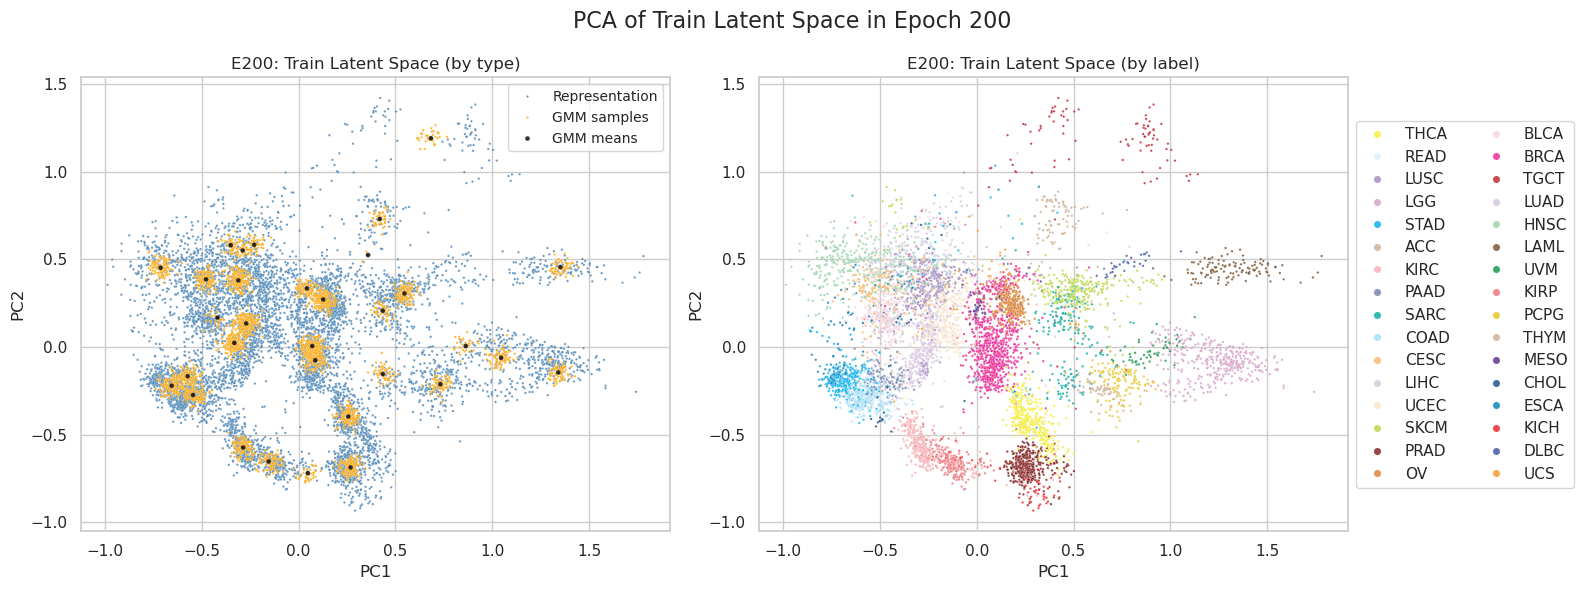

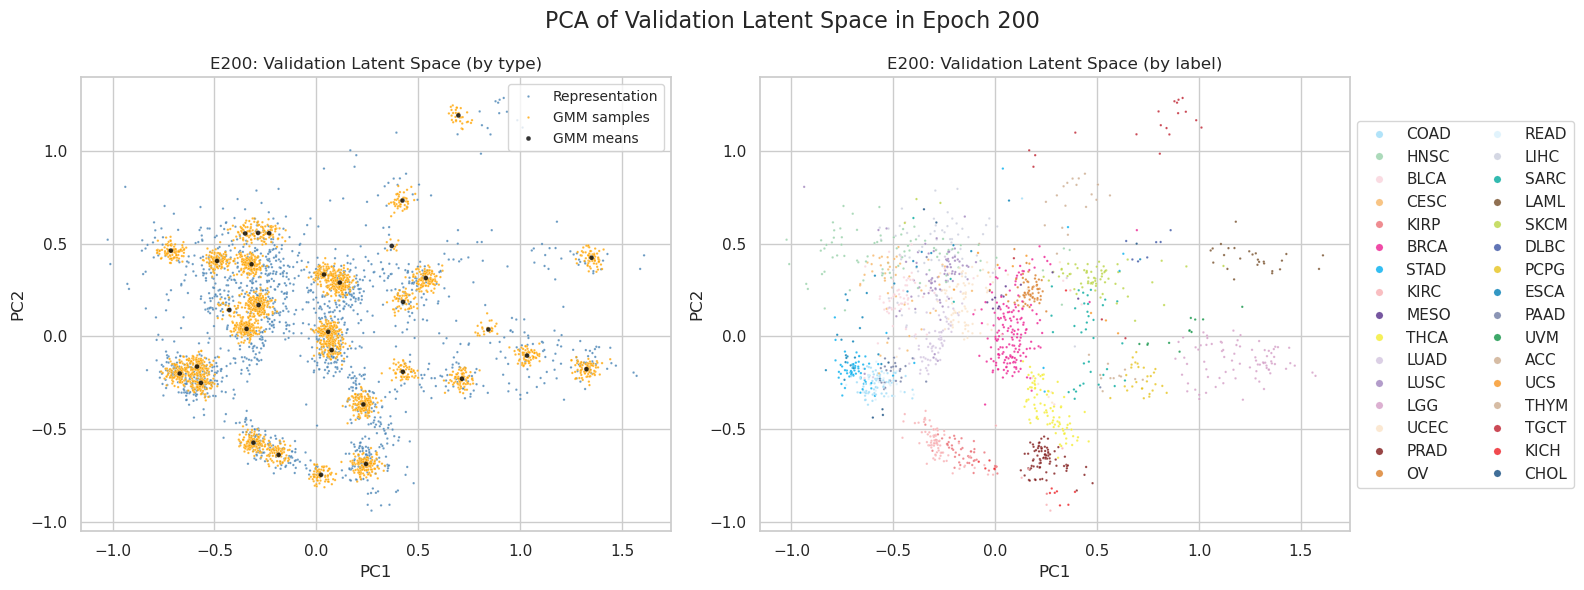

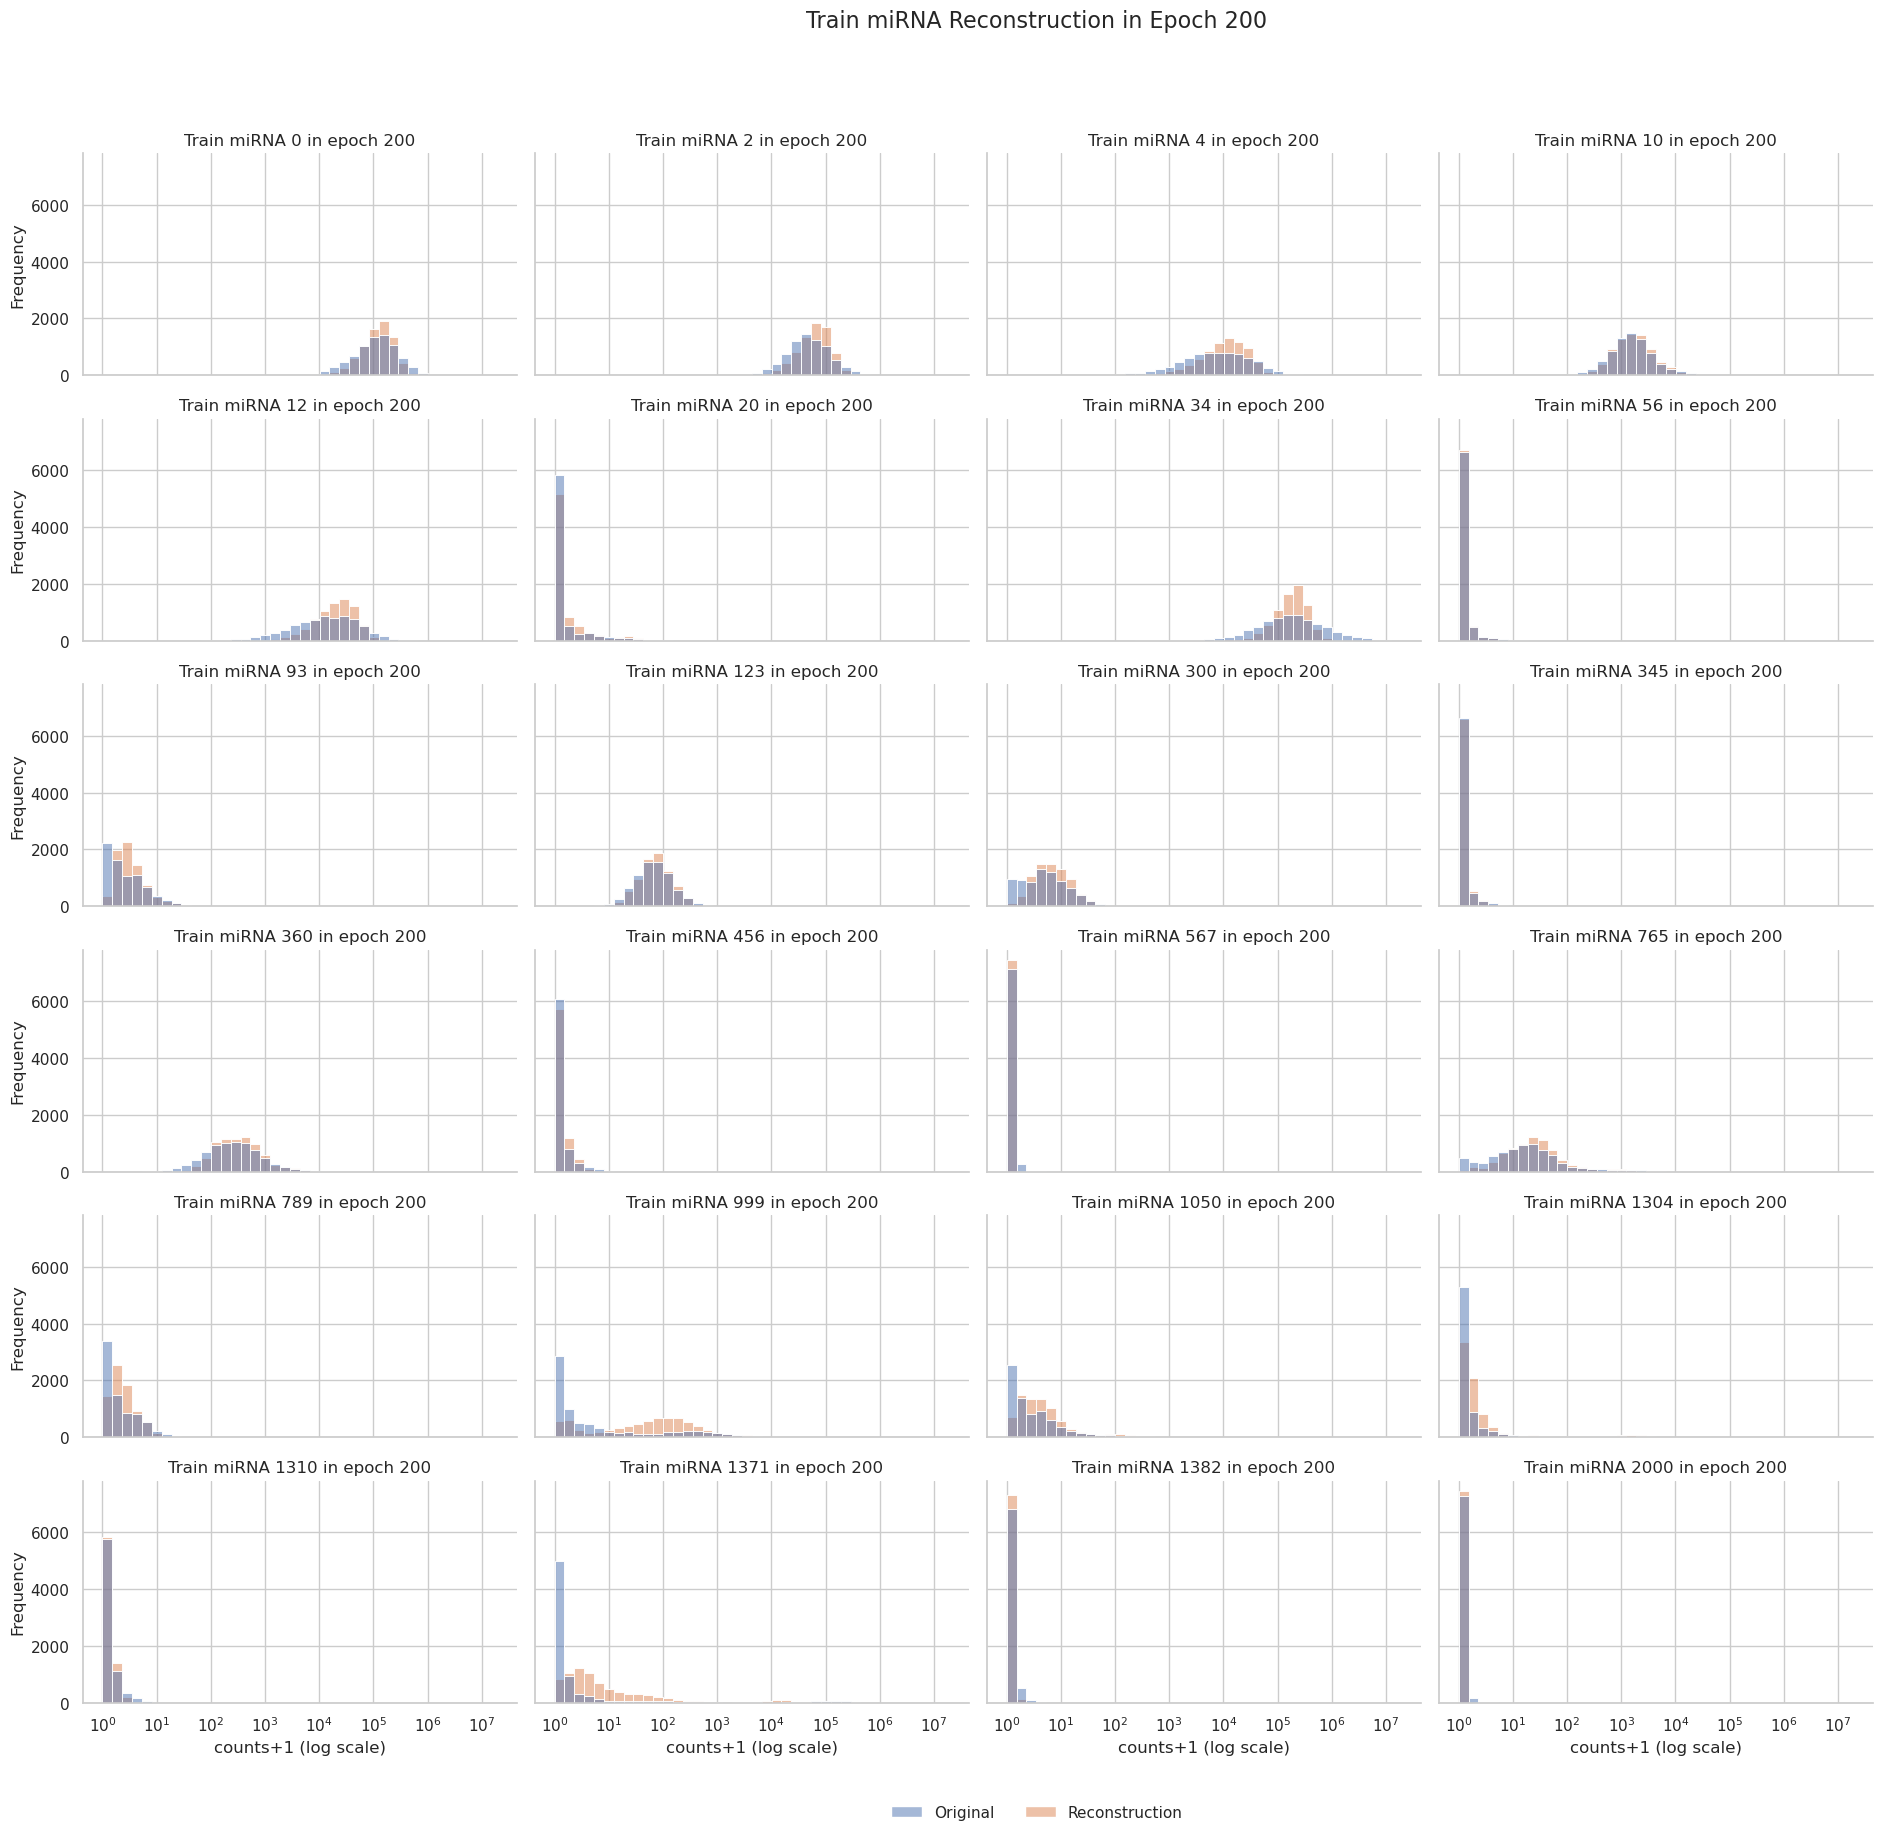

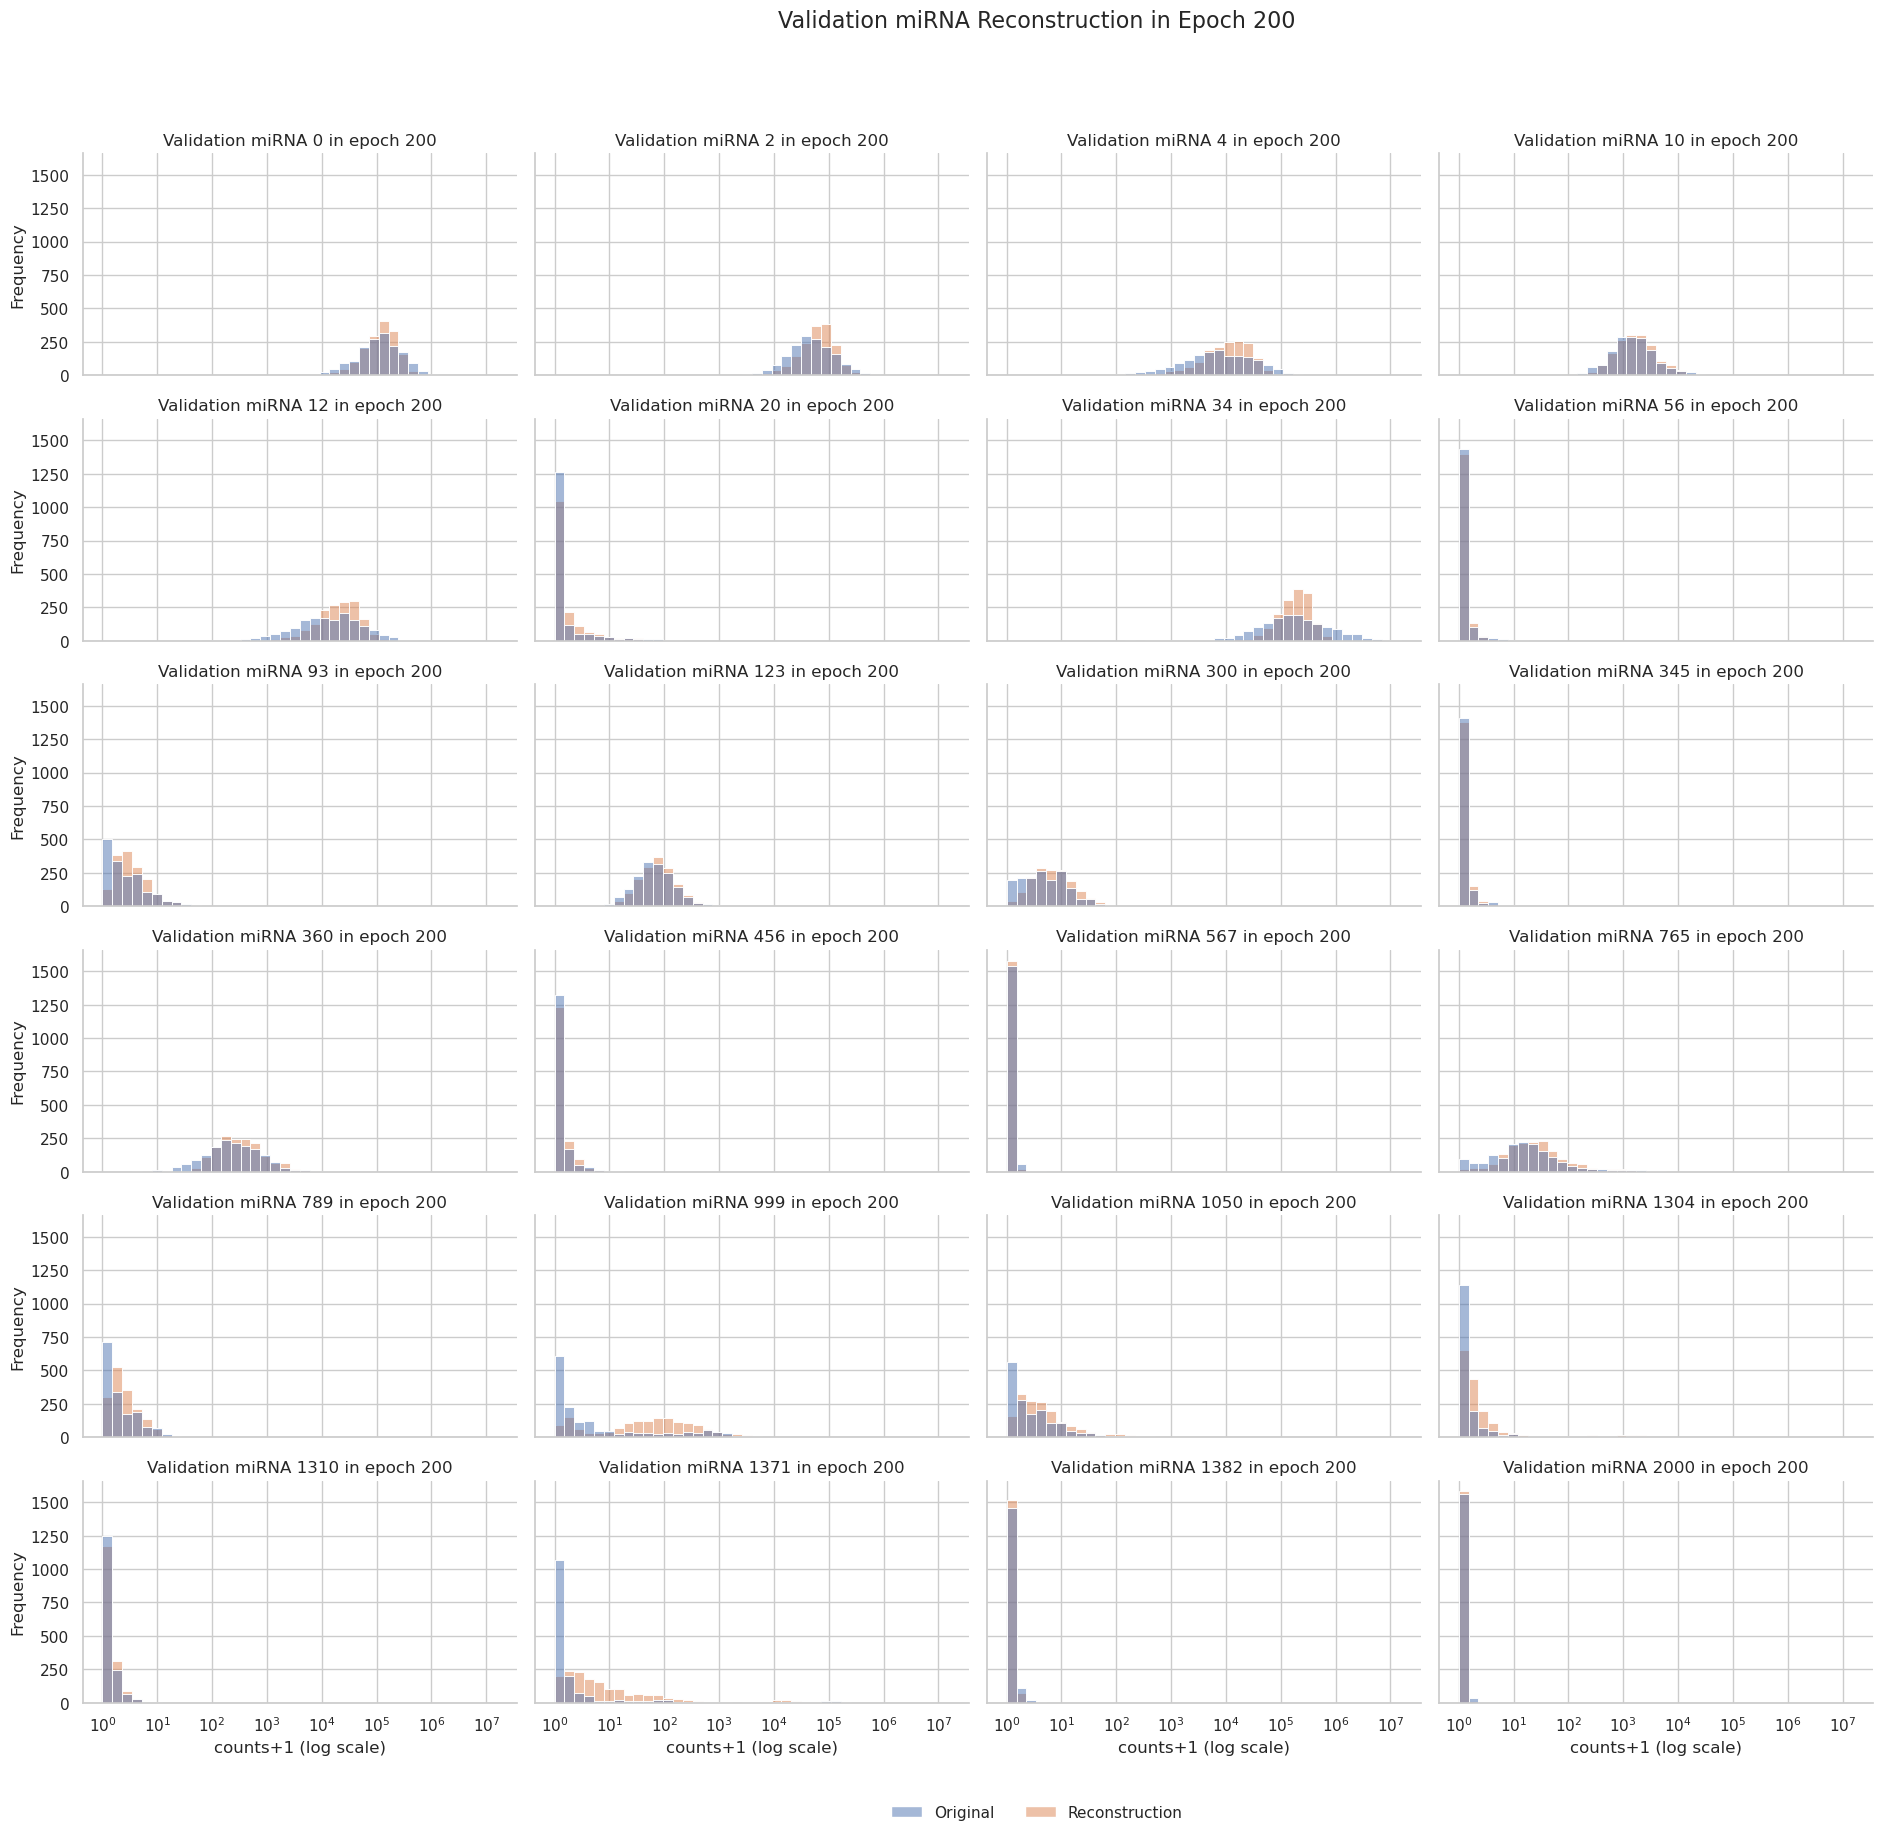

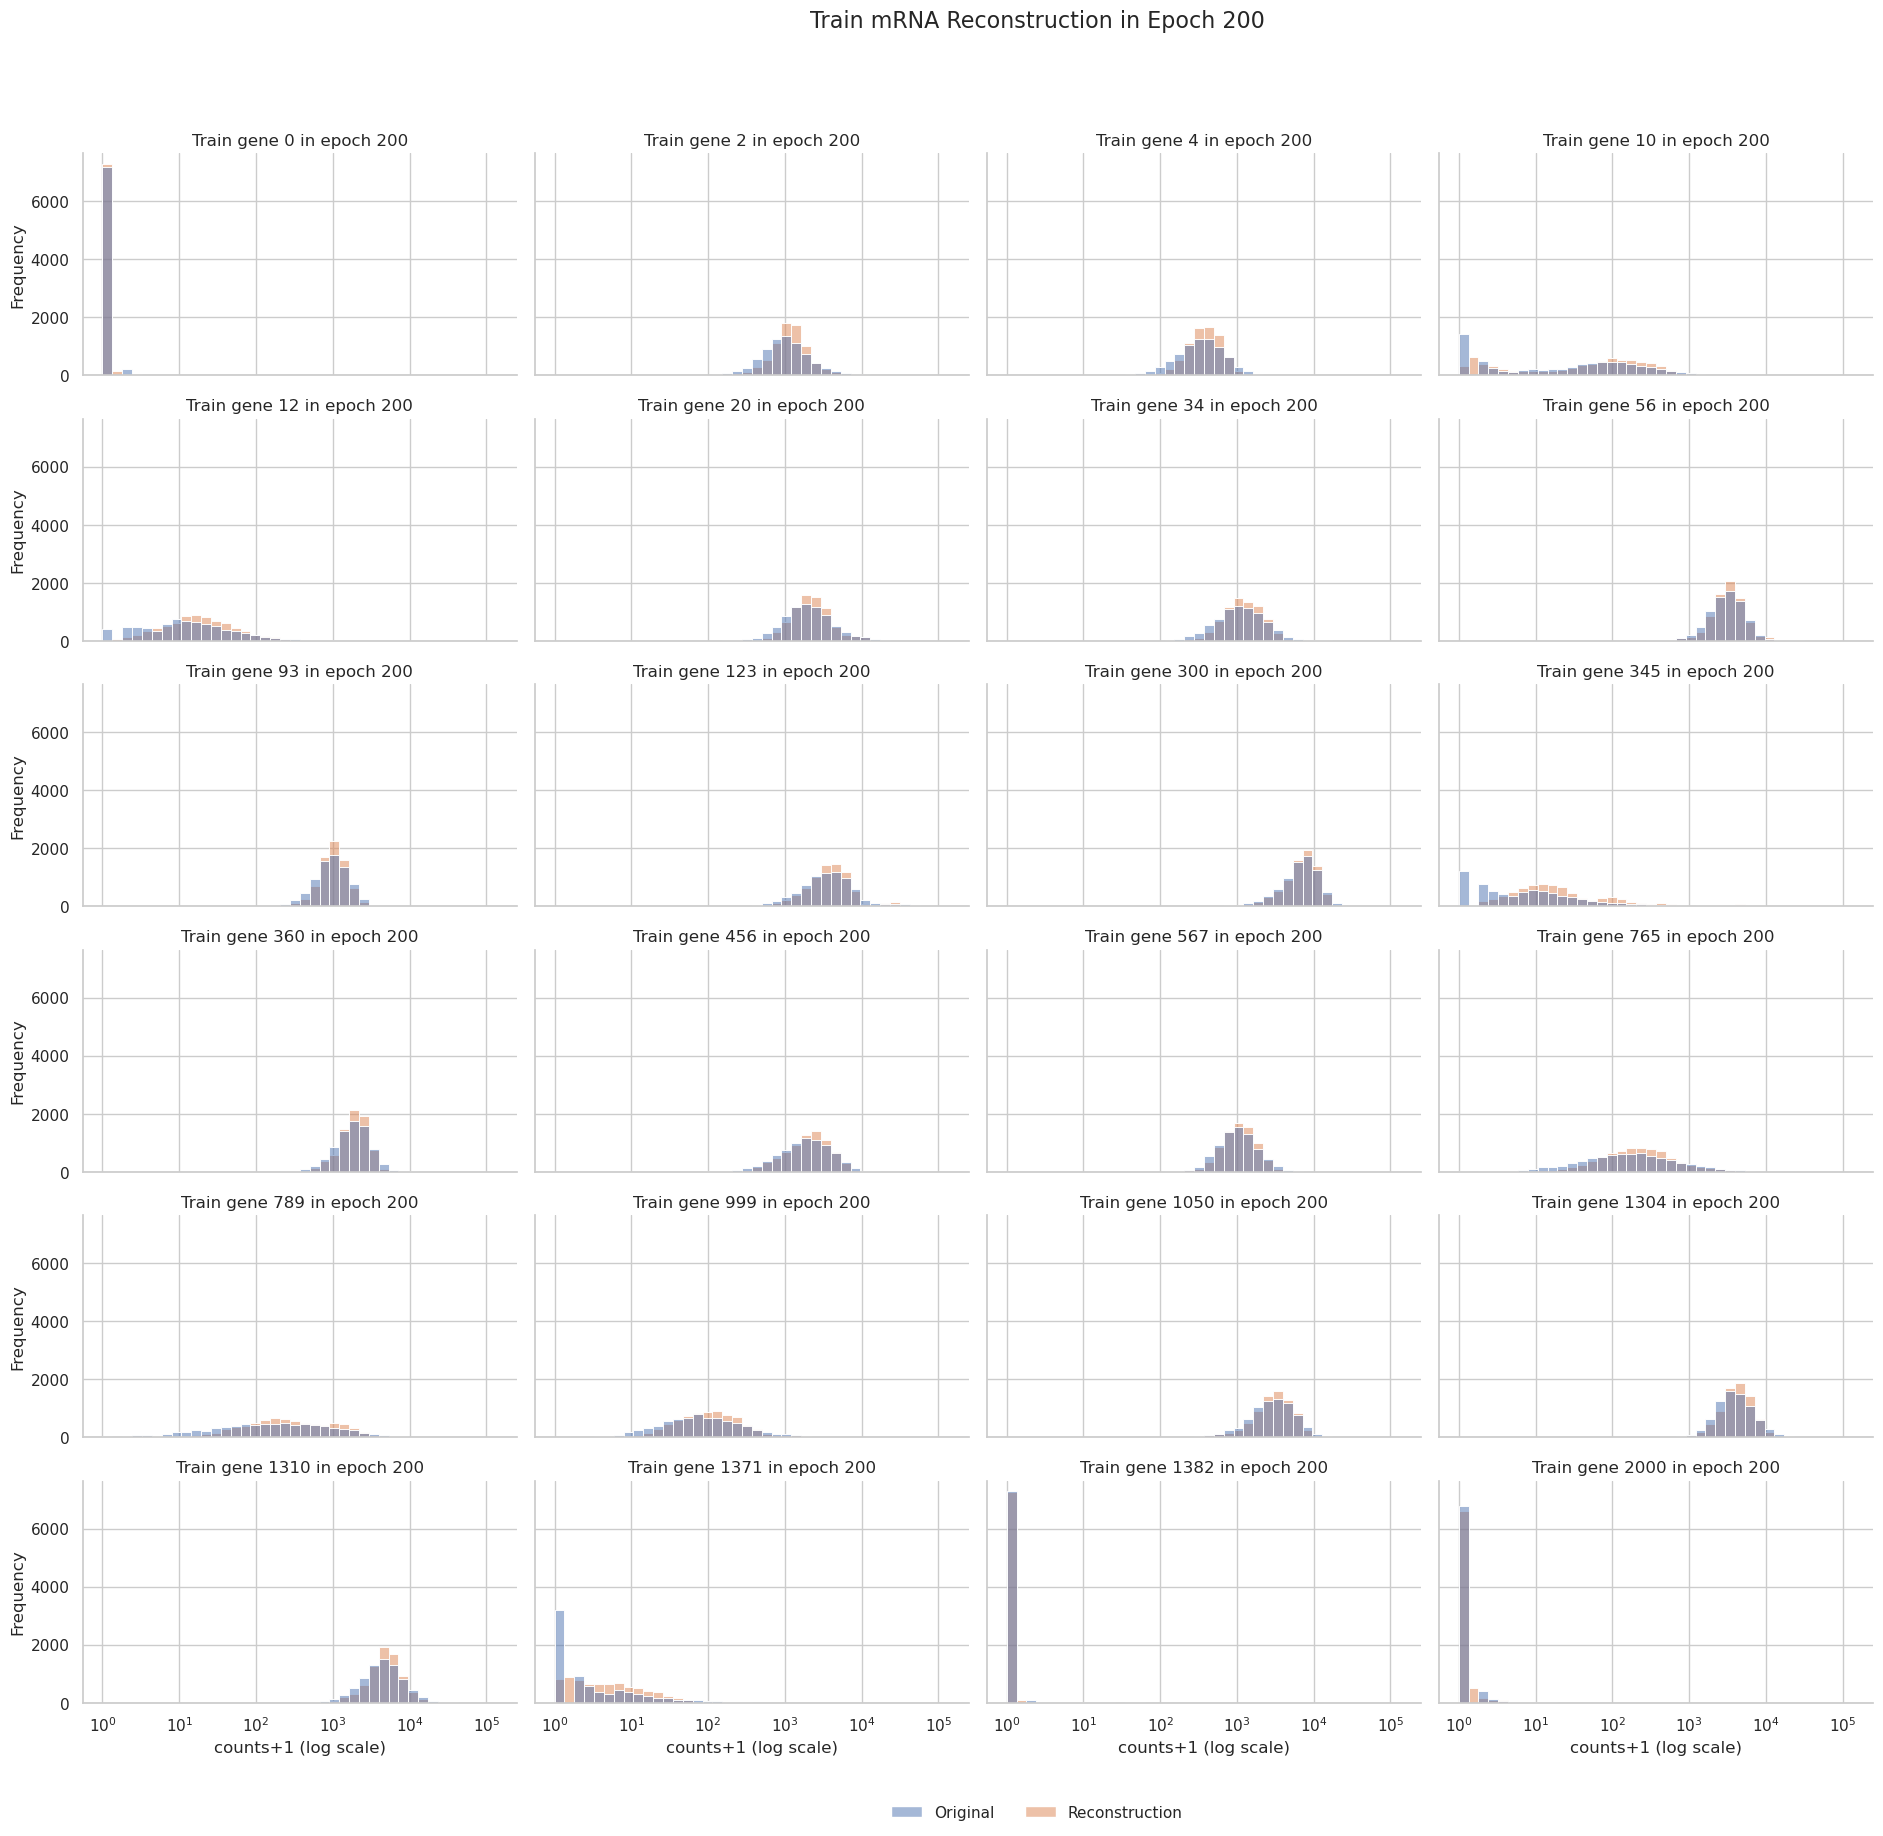

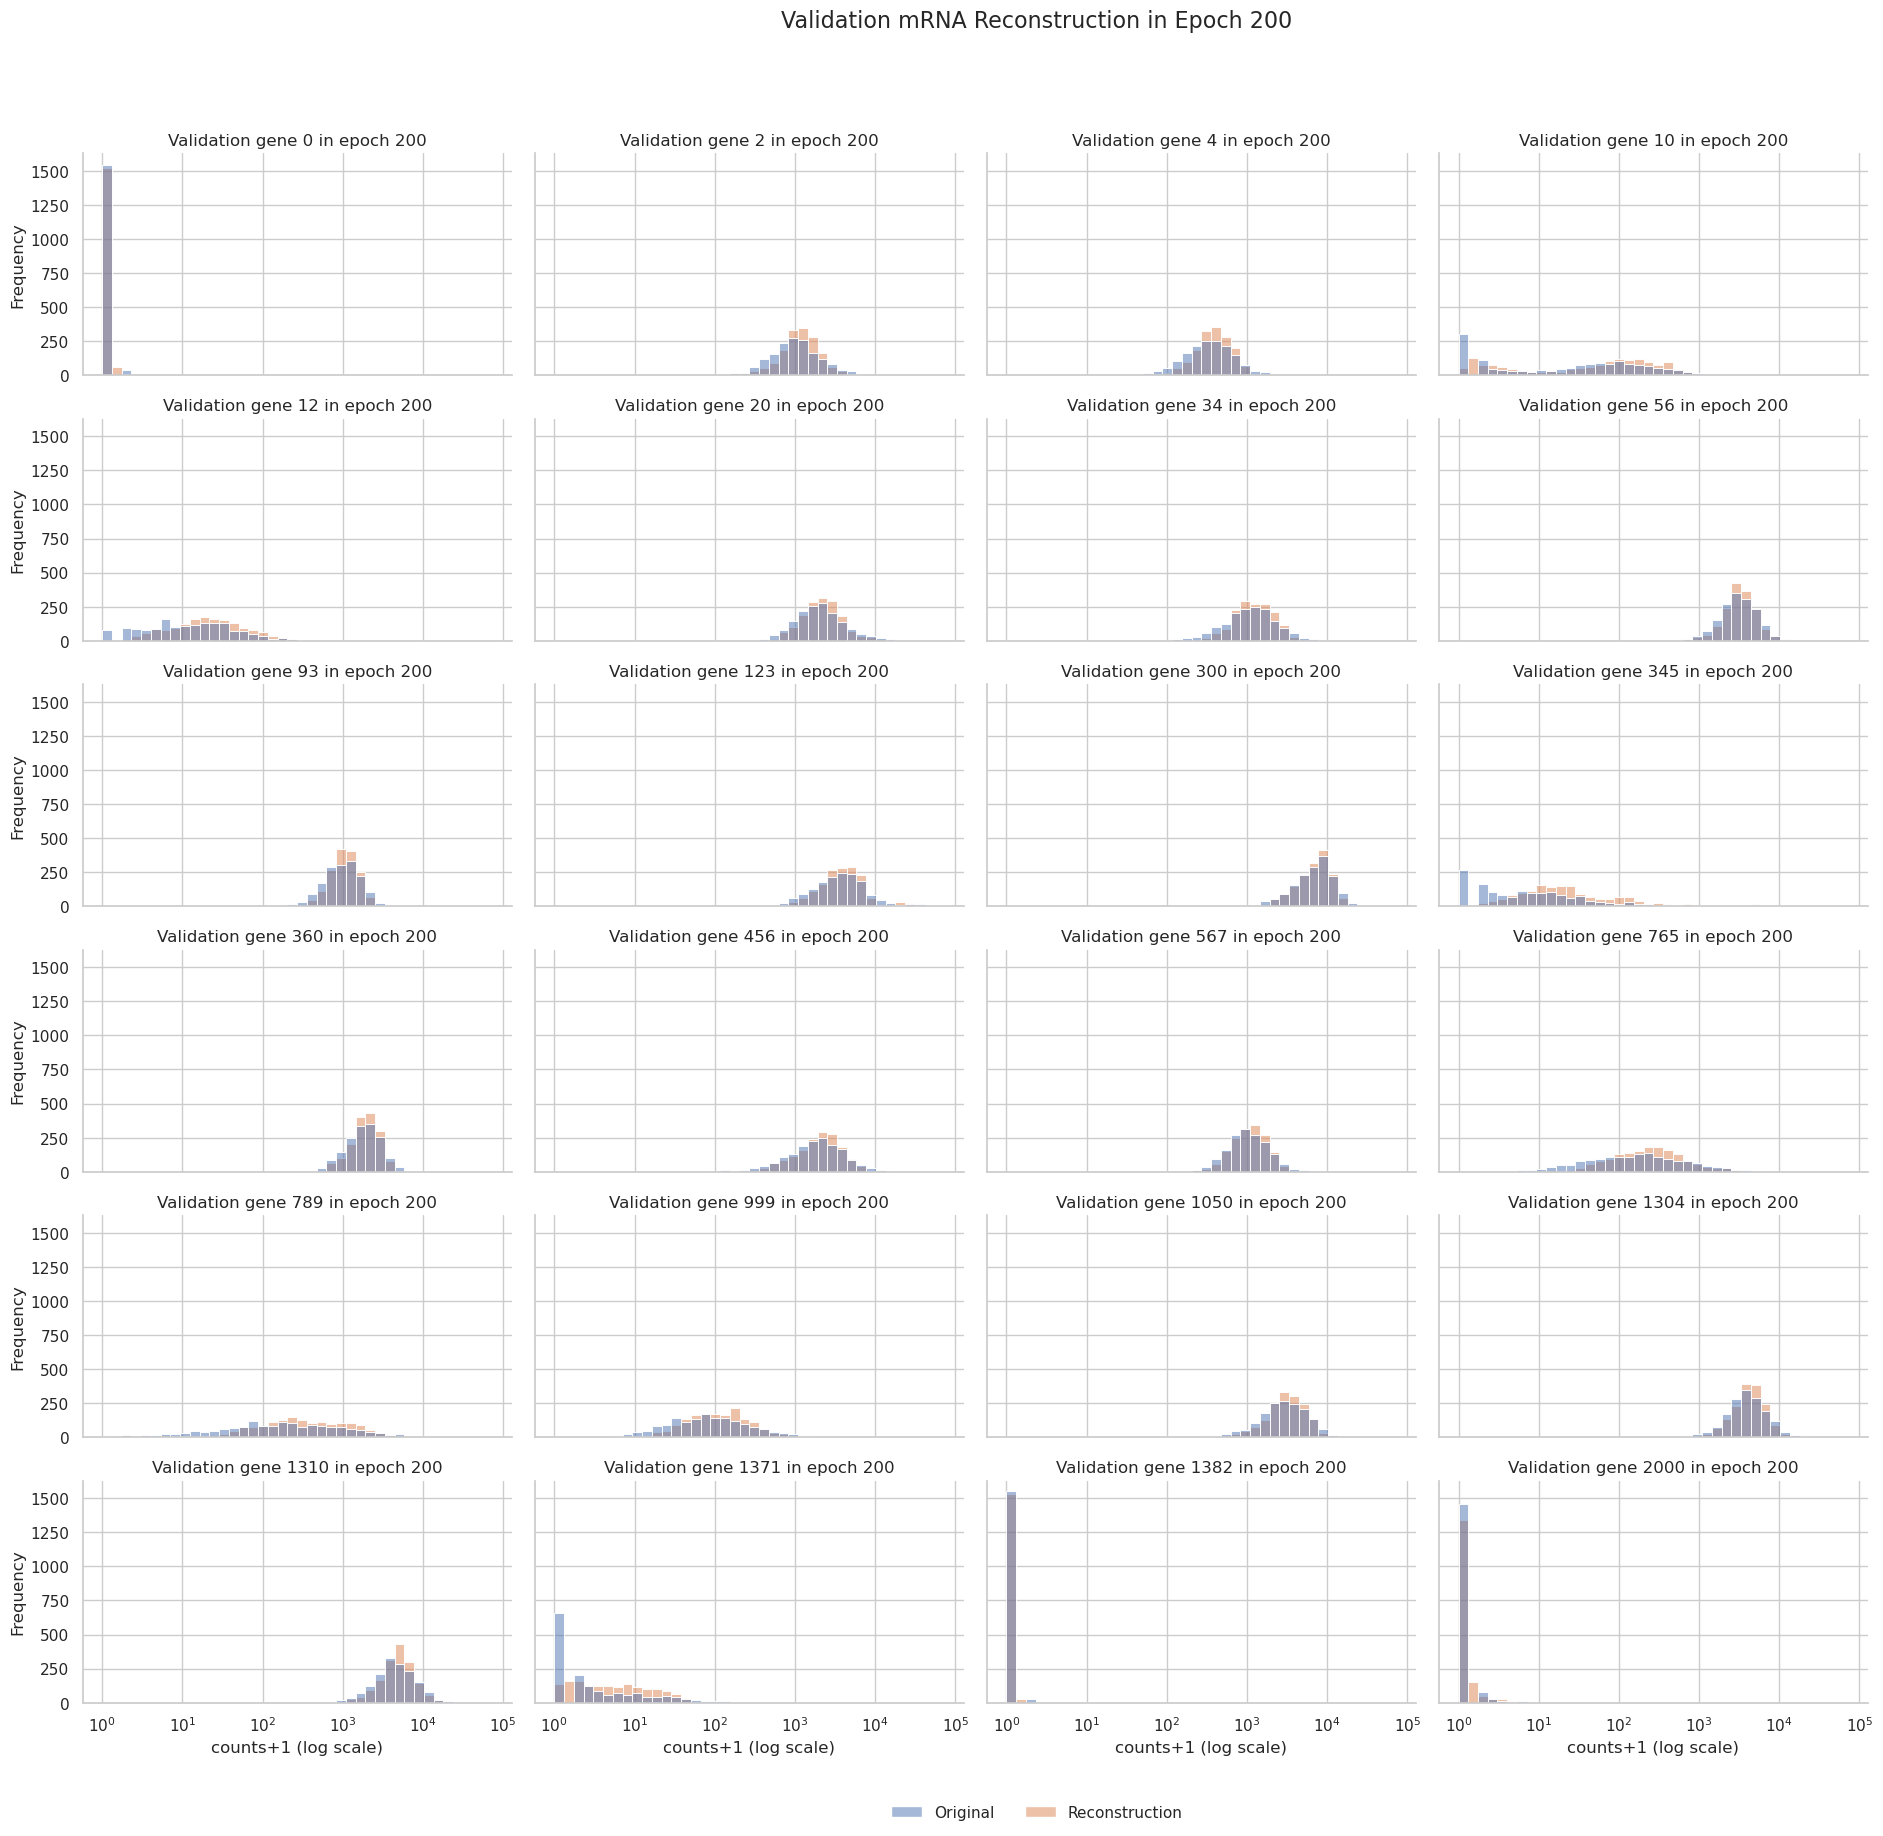

 26%|█████████████████████████████████████████████▎                                                                                                                                  | 206/801 [22:47<2:14:59, 13.61s/it]

205 train_recon_mirna: 1.9222925212748767 train_recon_mrna: 6.533043441810032 train_gmm: 2.231387495308632 train_mse: 496734.96875 train_mae: 74.82427978515625 train_r2: 0.29397791624069214 train_spearman: 0.4480695426464081 train_pearson: 0.5773013234138489 train_msle: 0.7262902855873108
205 test_recon_mirna: 2.167436576201139 test_recon_mrna: 6.558515505338164 test_gmm: 2.234230010052311 test_mse: 392432.03125 test_mae: 85.7870864868164 test_r2: 0.3871379494667053 test_spearman: 0.38356053829193115 test_pearson: 0.6647823452949524 test_msle: 0.9676230549812317


 26%|██████████████████████████████████████████████▉                                                                                                                                   | 211/801 [23:06<53:07,  5.40s/it]

210 train_recon_mirna: 1.9196568470770135 train_recon_mrna: 6.5259956189105495 train_gmm: 2.2328995680020993 train_mse: 496184.96875 train_mae: 75.26909637451172 train_r2: 0.2947596311569214 train_spearman: 0.4497268497943878 train_pearson: 0.5756765604019165 train_msle: 0.7175909876823425
210 test_recon_mirna: 2.192222115454644 test_recon_mrna: 6.553447975770931 test_gmm: 2.236823527653615 test_mse: 386511.4375 test_mae: 86.865966796875 test_r2: 0.3963841199874878 test_spearman: 0.3821318447589874 test_pearson: 0.6606249213218689 test_msle: 0.9540401697158813


 27%|████████████████████████████████████████████████                                                                                                                                  | 216/801 [23:24<38:13,  3.92s/it]

215 train_recon_mirna: 1.9171923972000784 train_recon_mrna: 6.519382642447041 train_gmm: 2.2343477061039536 train_mse: 496344.34375 train_mae: 76.74658203125 train_r2: 0.2945331335067749 train_spearman: 0.4486185312271118 train_pearson: 0.5658034086227417 train_msle: 0.7356281876564026
215 test_recon_mirna: 2.188801353619156 test_recon_mrna: 6.550247092730308 test_gmm: 2.2376012093271784 test_mse: 389475.5625 test_mae: 87.13533020019531 test_r2: 0.39175504446029663 test_spearman: 0.38021010160446167 test_pearson: 0.6624366044998169 test_msle: 0.9809828400611877


 28%|█████████████████████████████████████████████████                                                                                                                                 | 221/801 [23:42<35:09,  3.64s/it]

220 train_recon_mirna: 1.9148273344729432 train_recon_mrna: 6.512629085937615 train_gmm: 2.235466505918703 train_mse: 494360.65625 train_mae: 76.0674057006836 train_r2: 0.2973526120185852 train_spearman: 0.4502008557319641 train_pearson: 0.5710442066192627 train_msle: 0.7338694930076599
220 test_recon_mirna: 2.1921189846606493 test_recon_mrna: 6.543570436401873 test_gmm: 2.2401671715187774 test_mse: 382493.34375 test_mae: 88.21492004394531 test_r2: 0.40265917778015137 test_spearman: 0.3797207474708557 test_pearson: 0.6618379950523376 test_msle: 0.9961531162261963


 28%|██████████████████████████████████████████████████▏                                                                                                                               | 226/801 [24:00<34:45,  3.63s/it]

225 train_recon_mirna: 1.912517562814406 train_recon_mrna: 6.506008497178838 train_gmm: 2.237091798704503 train_mse: 495092.03125 train_mae: 74.04022216796875 train_r2: 0.2963131070137024 train_spearman: 0.4485306739807129 train_pearson: 0.5824092030525208 train_msle: 0.6997875571250916
225 test_recon_mirna: 2.209497950731139 test_recon_mrna: 6.53357402471943 test_gmm: 2.2400955610019126 test_mse: 391737.8125 test_mae: 87.1808853149414 test_r2: 0.3882220387458801 test_spearman: 0.3775257468223572 test_pearson: 0.6614055633544922 test_msle: 0.9525920748710632


 29%|███████████████████████████████████████████████████▎                                                                                                                              | 231/801 [24:18<33:48,  3.56s/it]

230 train_recon_mirna: 1.9104803085739757 train_recon_mrna: 6.50009512657671 train_gmm: 2.2385378116427472 train_mse: 494332.59375 train_mae: 74.84925079345703 train_r2: 0.29739248752593994 train_spearman: 0.4494408369064331 train_pearson: 0.5764707922935486 train_msle: 0.7021451592445374
230 test_recon_mirna: 2.208560505893673 test_recon_mrna: 6.528459477782569 test_gmm: 2.2425182869105247 test_mse: 391414.59375 test_mae: 87.09486389160156 test_r2: 0.3887268900871277 test_spearman: 0.37539583444595337 test_pearson: 0.6641771197319031 test_msle: 0.9483968615531921


 29%|████████████████████████████████████████████████████▍                                                                                                                             | 236/801 [24:36<33:47,  3.59s/it]

235 train_recon_mirna: 1.9083437570576869 train_recon_mrna: 6.49391192281542 train_gmm: 2.239965467479802 train_mse: 491294.625 train_mae: 74.26188659667969 train_r2: 0.30171042680740356 train_spearman: 0.45055079460144043 train_pearson: 0.583960771560669 train_msle: 0.6960124969482422
235 test_recon_mirna: 2.216724541680348 test_recon_mrna: 6.520983969133572 test_gmm: 2.2430683352811718 test_mse: 387490.78125 test_mae: 88.02584075927734 test_r2: 0.39485466480255127 test_spearman: 0.3736504018306732 test_pearson: 0.6606765389442444 test_msle: 0.9608980417251587


 30%|█████████████████████████████████████████████████████▌                                                                                                                            | 241/801 [24:54<33:28,  3.59s/it]

240 train_recon_mirna: 1.9064549322141395 train_recon_mrna: 6.488000392585657 train_gmm: 2.241426693061166 train_mse: 490689.78125 train_mae: 75.24171447753906 train_r2: 0.302570104598999 train_spearman: 0.4499332010746002 train_pearson: 0.5778292417526245 train_msle: 0.6995776891708374
240 test_recon_mirna: 2.2301435707179063 test_recon_mrna: 6.524593675480356 test_gmm: 2.2453975298641473 test_mse: 387676.625 test_mae: 86.87945556640625 test_r2: 0.3945644497871399 test_spearman: 0.36959582567214966 test_pearson: 0.6718306541442871 test_msle: 0.9546060562133789


 31%|██████████████████████████████████████████████████████▋                                                                                                                           | 246/801 [25:12<32:41,  3.53s/it]

245 train_recon_mirna: 1.9046254902861104 train_recon_mrna: 6.482064246104543 train_gmm: 2.2429745031331545 train_mse: 486389.0 train_mae: 74.365478515625 train_r2: 0.308682918548584 train_spearman: 0.448687344789505 train_pearson: 0.589006245136261 train_msle: 0.6988987922668457
245 test_recon_mirna: 2.2281093461843264 test_recon_mrna: 6.510042843707967 test_gmm: 2.2464882025638273 test_mse: 376975.65625 test_mae: 86.72091674804688 test_r2: 0.4112761616706848 test_spearman: 0.36597776412963867 test_pearson: 0.6789654493331909 test_msle: 0.9479706883430481


 31%|███████████████████████████████████████████████████████▊                                                                                                                          | 251/801 [25:30<32:59,  3.60s/it]

250 train_recon_mirna: 1.902831975207916 train_recon_mrna: 6.476436658555404 train_gmm: 2.244492124774187 train_mse: 485317.34375 train_mae: 74.01248931884766 train_r2: 0.3102061152458191 train_spearman: 0.4499541223049164 train_pearson: 0.5923866629600525 train_msle: 0.6889024972915649
250 test_recon_mirna: 2.2319912841652823 test_recon_mrna: 6.508481288020275 test_gmm: 2.2473279182200576 test_mse: 372633.40625 test_mae: 86.91376495361328 test_r2: 0.41805750131607056 test_spearman: 0.3671308755874634 test_pearson: 0.6825783252716064 test_msle: 0.9421017169952393


 32%|████████████████████████████████████████████████████████▉                                                                                                                         | 256/801 [25:48<32:06,  3.54s/it]

255 train_recon_mirna: 1.9011345219436877 train_recon_mrna: 6.470885759966651 train_gmm: 2.2458850821289977 train_mse: 481582.15625 train_mae: 74.07719421386719 train_r2: 0.3155149817466736 train_spearman: 0.45073550939559937 train_pearson: 0.5926899909973145 train_msle: 0.6999622583389282
255 test_recon_mirna: 2.2272549923250784 test_recon_mrna: 6.506207463479036 test_gmm: 2.249688297536208 test_mse: 366571.78125 test_mae: 85.1351547241211 test_r2: 0.4275239109992981 test_spearman: 0.36395445466041565 test_pearson: 0.6995069980621338 test_msle: 0.9592883586883545


 33%|██████████████████████████████████████████████████████████                                                                                                                        | 261/801 [26:06<32:14,  3.58s/it]

260 train_recon_mirna: 1.8996442022886475 train_recon_mrna: 6.465487615673419 train_gmm: 2.2473295187544955 train_mse: 478561.15625 train_mae: 73.86015319824219 train_r2: 0.31980884075164795 train_spearman: 0.44958144426345825 train_pearson: 0.5982103943824768 train_msle: 0.6858635544776917
260 test_recon_mirna: 2.2247850994962386 test_recon_mrna: 6.495044793220234 test_gmm: 2.2503371915990007 test_mse: 364954.75 test_mae: 84.68546295166016 test_r2: 0.43004924058914185 test_spearman: 0.3617662191390991 test_pearson: 0.7020639181137085 test_msle: 0.9544704556465149


 33%|███████████████████████████████████████████████████████████                                                                                                                       | 266/801 [26:23<31:47,  3.57s/it]

265 train_recon_mirna: 1.8980671718416868 train_recon_mrna: 6.460271664855002 train_gmm: 2.248855020325777 train_mse: 480282.625 train_mae: 73.27323150634766 train_r2: 0.31736207008361816 train_spearman: 0.44899553060531616 train_pearson: 0.5994261503219604 train_msle: 0.6919077038764954
265 test_recon_mirna: 2.2270256434806064 test_recon_mrna: 6.4913222103820996 test_gmm: 2.2517622500341585 test_mse: 358349.71875 test_mae: 84.66487884521484 test_r2: 0.44036436080932617 test_spearman: 0.3632655441761017 test_pearson: 0.7043065428733826 test_msle: 0.9314279556274414


 34%|████████████████████████████████████████████████████████████▏                                                                                                                     | 271/801 [26:41<31:20,  3.55s/it]

270 train_recon_mirna: 1.8966660370945416 train_recon_mrna: 6.455374227247811 train_gmm: 2.250160414732621 train_mse: 475781.71875 train_mae: 72.4112319946289 train_r2: 0.3237593173980713 train_spearman: 0.4532080292701721 train_pearson: 0.6083549857139587 train_msle: 0.682856023311615
270 test_recon_mirna: 2.228479099108635 test_recon_mrna: 6.488982036295701 test_gmm: 2.254224509644851 test_mse: 356695.96875 test_mae: 82.84712982177734 test_r2: 0.44294703006744385 test_spearman: 0.36530017852783203 test_pearson: 0.7204239368438721 test_msle: 0.9316586852073669


 34%|█████████████████████████████████████████████████████████████▎                                                                                                                    | 276/801 [26:59<31:33,  3.61s/it]

275 train_recon_mirna: 1.8952877788811129 train_recon_mrna: 6.450427787608123 train_gmm: 2.2515510492721713 train_mse: 480473.0 train_mae: 71.76838684082031 train_r2: 0.3170914649963379 train_spearman: 0.44971901178359985 train_pearson: 0.6093335747718811 train_msle: 0.6665139198303223
275 test_recon_mirna: 2.221914699665846 test_recon_mrna: 6.4833076472739215 test_gmm: 2.255109515598161 test_mse: 354526.5625 test_mae: 82.87403106689453 test_r2: 0.4463350176811218 test_spearman: 0.3575526773929596 test_pearson: 0.721399188041687 test_msle: 0.9321847558021545


 35%|██████████████████████████████████████████████████████████████▍                                                                                                                   | 281/801 [27:17<30:31,  3.52s/it]

280 train_recon_mirna: 1.893915439951414 train_recon_mrna: 6.44536177460376 train_gmm: 2.253128433584864 train_mse: 476922.9375 train_mae: 72.29549407958984 train_r2: 0.3221372365951538 train_spearman: 0.4507908821105957 train_pearson: 0.6095472574234009 train_msle: 0.6827431917190552
280 test_recon_mirna: 2.2127369944488744 test_recon_mrna: 6.477031825095638 test_gmm: 2.254833206662828 test_mse: 352642.78125 test_mae: 82.94906616210938 test_r2: 0.4492769241333008 test_spearman: 0.3611445724964142 test_pearson: 0.7210326790809631 test_msle: 0.9161702990531921


 36%|███████████████████████████████████████████████████████████████▌                                                                                                                  | 286/801 [27:35<30:43,  3.58s/it]

285 train_recon_mirna: 1.8925069241776984 train_recon_mrna: 6.440751523206387 train_gmm: 2.2543559761103515 train_mse: 475765.96875 train_mae: 73.19760131835938 train_r2: 0.32378172874450684 train_spearman: 0.4472310245037079 train_pearson: 0.6037706732749939 train_msle: 0.664588212966919
285 test_recon_mirna: 2.213748195066448 test_recon_mrna: 6.474610699501707 test_gmm: 2.256071164323567 test_mse: 337561.75 test_mae: 85.44550323486328 test_r2: 0.4728289842605591 test_spearman: 0.3574649691581726 test_pearson: 0.716010570526123 test_msle: 0.9293823838233948


 36%|████████████████████████████████████████████████████████████████▋                                                                                                                 | 291/801 [27:52<30:06,  3.54s/it]

290 train_recon_mirna: 1.8913389730533214 train_recon_mrna: 6.436438985084328 train_gmm: 2.2557056706225747 train_mse: 474340.0 train_mae: 72.03778076171875 train_r2: 0.32580846548080444 train_spearman: 0.4479690492153168 train_pearson: 0.6108930110931396 train_msle: 0.6630955338478088
290 test_recon_mirna: 2.2062130121706294 test_recon_mrna: 6.470247038309126 test_gmm: 2.2580034359628747 test_mse: 339557.40625 test_mae: 85.15660858154297 test_r2: 0.46971237659454346 test_spearman: 0.355373352766037 test_pearson: 0.7145747542381287 test_msle: 0.9258100986480713


 37%|█████████████████████████████████████████████████████████████████▊                                                                                                                | 296/801 [28:10<30:27,  3.62s/it]

295 train_recon_mirna: 1.890016949068359 train_recon_mrna: 6.43202933766395 train_gmm: 2.257124108705402 train_mse: 470586.46875 train_mae: 73.68797302246094 train_r2: 0.33114349842071533 train_spearman: 0.44926321506500244 train_pearson: 0.6072390675544739 train_msle: 0.6935267448425293
295 test_recon_mirna: 2.2019499994445173 test_recon_mrna: 6.4671324381534125 test_gmm: 2.2587839539984773 test_mse: 326185.5625 test_mae: 84.67738342285156 test_r2: 0.4905952215194702 test_spearman: 0.3586325943470001 test_pearson: 0.7269355058670044 test_msle: 0.9323378801345825


 38%|██████████████████████████████████████████████████████████████████▉                                                                                                               | 301/801 [28:28<29:54,  3.59s/it]

300 train_recon_mirna: 1.8887394343781223 train_recon_mrna: 6.427618341315025 train_gmm: 2.2584237744813622 train_mse: 470184.875 train_mae: 71.880859375 train_r2: 0.3317142724990845 train_spearman: 0.45066067576408386 train_pearson: 0.6180773377418518 train_msle: 0.6744716763496399
300 test_recon_mirna: 2.1844628202975906 test_recon_mrna: 6.469398858882744 test_gmm: 2.2580951602514054 test_mse: 332263.1875 test_mae: 82.57872009277344 test_r2: 0.48110371828079224 test_spearman: 0.35835176706314087 test_pearson: 0.7360800504684448 test_msle: 0.9443401098251343


 38%|████████████████████████████████████████████████████████████████████                                                                                                              | 306/801 [28:46<29:13,  3.54s/it]

305 train_recon_mirna: 1.8873744351536414 train_recon_mrna: 6.423665126576642 train_gmm: 2.2593834026453568 train_mse: 472384.5625 train_mae: 70.9310302734375 train_r2: 0.32858777046203613 train_spearman: 0.4478742182254791 train_pearson: 0.6223567724227905 train_msle: 0.6671871542930603
305 test_recon_mirna: 2.196340924443838 test_recon_mrna: 6.461316459138979 test_gmm: 2.259125567882378 test_mse: 332222.625 test_mae: 82.25760650634766 test_r2: 0.48116713762283325 test_spearman: 0.35800424218177795 test_pearson: 0.7375677824020386 test_msle: 0.9285569787025452


 39%|█████████████████████████████████████████████████████████████████████                                                                                                             | 311/801 [29:04<29:24,  3.60s/it]

310 train_recon_mirna: 1.8863104826419907 train_recon_mrna: 6.419613894216196 train_gmm: 2.2606772319804422 train_mse: 465526.46875 train_mae: 71.71027374267578 train_r2: 0.3383353352546692 train_spearman: 0.44943684339523315 train_pearson: 0.6250067949295044 train_msle: 0.6644300222396851
310 test_recon_mirna: 2.1921820936858882 test_recon_mrna: 6.455949122649871 test_gmm: 2.260634847970995 test_mse: 329335.75 test_mae: 81.45843505859375 test_r2: 0.48567551374435425 test_spearman: 0.35957086086273193 test_pearson: 0.74522465467453 test_msle: 0.923953652381897


 39%|██████████████████████████████████████████████████████████████████████▏                                                                                                           | 316/801 [29:22<28:41,  3.55s/it]

315 train_recon_mirna: 1.885191820659777 train_recon_mrna: 6.415672779163525 train_gmm: 2.2618791712665596 train_mse: 466393.75 train_mae: 70.97064208984375 train_r2: 0.33710265159606934 train_spearman: 0.4519481062889099 train_pearson: 0.6274882555007935 train_msle: 0.6658167243003845
315 test_recon_mirna: 2.1856807164741405 test_recon_mrna: 6.4529884838135425 test_gmm: 2.261545762414116 test_mse: 332487.90625 test_mae: 80.23676300048828 test_r2: 0.4807528257369995 test_spearman: 0.36148181557655334 test_pearson: 0.7507911920547485 test_msle: 0.9104404449462891


 40%|███████████████████████████████████████████████████████████████████████▎                                                                                                          | 321/801 [29:40<28:31,  3.57s/it]

320 train_recon_mirna: 1.8840751379703429 train_recon_mrna: 6.412190706528983 train_gmm: 2.2632579254718026 train_mse: 465874.0 train_mae: 71.28245544433594 train_r2: 0.3378413915634155 train_spearman: 0.4489123523235321 train_pearson: 0.6257858276367188 train_msle: 0.6703851222991943
320 test_recon_mirna: 2.184355426944128 test_recon_mrna: 6.449723307842178 test_gmm: 2.2617767429292237 test_mse: 324140.1875 test_mae: 80.62774658203125 test_r2: 0.4937894344329834 test_spearman: 0.3569014072418213 test_pearson: 0.7505695223808289 test_msle: 0.9145201444625854


 41%|████████████████████████████████████████████████████████████████████████▍                                                                                                         | 326/801 [29:57<28:13,  3.57s/it]

325 train_recon_mirna: 1.8829281894563512 train_recon_mrna: 6.408175393627688 train_gmm: 2.264350574829804 train_mse: 464084.84375 train_mae: 70.65895080566406 train_r2: 0.3403843641281128 train_spearman: 0.4503631293773651 train_pearson: 0.634110689163208 train_msle: 0.6621109843254089
325 test_recon_mirna: 2.1807476429010526 test_recon_mrna: 6.449364254604942 test_gmm: 2.262787113034822 test_mse: 323864.90625 test_mae: 81.49272155761719 test_r2: 0.4942193627357483 test_spearman: 0.3610815107822418 test_pearson: 0.7467278838157654 test_msle: 0.908771812915802


 41%|█████████████████████████████████████████████████████████████████████████▌                                                                                                        | 331/801 [30:15<28:06,  3.59s/it]

330 train_recon_mirna: 1.882055320307587 train_recon_mrna: 6.404838585007034 train_gmm: 2.2655981422443716 train_mse: 465570.8125 train_mae: 71.10115814208984 train_r2: 0.3382723331451416 train_spearman: 0.44971057772636414 train_pearson: 0.6310204863548279 train_msle: 0.6797313690185547
330 test_recon_mirna: 2.177130687604462 test_recon_mrna: 6.441580997338393 test_gmm: 2.263657052720956 test_mse: 328818.3125 test_mae: 80.8145980834961 test_r2: 0.486483633518219 test_spearman: 0.3583347499370575 test_pearson: 0.7480197548866272 test_msle: 0.9360699653625488


 42%|██████████████████████████████████████████████████████████████████████████▋                                                                                                       | 336/801 [30:33<28:06,  3.63s/it]

335 train_recon_mirna: 1.8810034036728533 train_recon_mrna: 6.401324477014132 train_gmm: 2.266737358984532 train_mse: 461318.28125 train_mae: 70.4469223022461 train_r2: 0.3443165421485901 train_spearman: 0.45058807730674744 train_pearson: 0.6379960179328918 train_msle: 0.6701397895812988
335 test_recon_mirna: 2.1807210645890787 test_recon_mrna: 6.439320002907103 test_gmm: 2.2647837899164585 test_mse: 318622.09375 test_mae: 79.35395050048828 test_r2: 0.5024070739746094 test_spearman: 0.3616054952144623 test_pearson: 0.7608662843704224 test_msle: 0.902191698551178


 43%|███████████████████████████████████████████████████████████████████████████▊                                                                                                      | 341/801 [30:51<27:49,  3.63s/it]

340 train_recon_mirna: 1.8799930676819951 train_recon_mrna: 6.397878032361718 train_gmm: 2.2680932019332096 train_mse: 460594.53125 train_mae: 69.7126235961914 train_r2: 0.34534525871276855 train_spearman: 0.4512012004852295 train_pearson: 0.6454018354415894 train_msle: 0.6766760945320129
340 test_recon_mirna: 2.173565847401451 test_recon_mrna: 6.440552959071064 test_gmm: 2.2661491017576907 test_mse: 312390.90625 test_mae: 79.80326843261719 test_r2: 0.5121383666992188 test_spearman: 0.36286190152168274 test_pearson: 0.7607396841049194 test_msle: 0.8873545527458191


 43%|████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 346/801 [31:09<26:59,  3.56s/it]

345 train_recon_mirna: 1.8789296637112973 train_recon_mrna: 6.394625609728413 train_gmm: 2.2692072025698766 train_mse: 456936.125 train_mae: 70.3362808227539 train_r2: 0.3505450487136841 train_spearman: 0.45058929920196533 train_pearson: 0.643131673336029 train_msle: 0.6699138283729553
345 test_recon_mirna: 2.1748776163242836 test_recon_mrna: 6.438493022429342 test_gmm: 2.266205874746252 test_mse: 306582.09375 test_mae: 81.64328002929688 test_r2: 0.5212099552154541 test_spearman: 0.359934538602829 test_pearson: 0.7539012432098389 test_msle: 0.9289453029632568


 44%|██████████████████████████████████████████████████████████████████████████████                                                                                                    | 351/801 [31:27<26:47,  3.57s/it]

350 train_recon_mirna: 1.8779708647441726 train_recon_mrna: 6.391150051266402 train_gmm: 2.2703525465111905 train_mse: 457216.0625 train_mae: 69.05233001708984 train_r2: 0.35014718770980835 train_spearman: 0.45147398114204407 train_pearson: 0.6543416976928711 train_msle: 0.6524693965911865
350 test_recon_mirna: 2.175853453128356 test_recon_mrna: 6.431194271879553 test_gmm: 2.2666400363786305 test_mse: 314027.25 test_mae: 79.57223510742188 test_r2: 0.5095828771591187 test_spearman: 0.3615659773349762 test_pearson: 0.759309709072113 test_msle: 0.8996697068214417


 44%|███████████████████████████████████████████████████████████████████████████████                                                                                                   | 356/801 [31:45<26:12,  3.53s/it]

355 train_recon_mirna: 1.877152093509956 train_recon_mrna: 6.388440741836679 train_gmm: 2.2715775179317417 train_mse: 459858.6875 train_mae: 69.34368896484375 train_r2: 0.34639114141464233 train_spearman: 0.4518124461174011 train_pearson: 0.648408055305481 train_msle: 0.6585665345191956
355 test_recon_mirna: 2.1691456310964243 test_recon_mrna: 6.430173938006238 test_gmm: 2.2706212822308323 test_mse: 318040.8125 test_mae: 78.67876434326172 test_r2: 0.5033148527145386 test_spearman: 0.3631357252597809 test_pearson: 0.7646352648735046 test_msle: 0.8674687147140503


 45%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                 | 361/801 [32:03<26:25,  3.60s/it]

360 train_recon_mirna: 1.876432044151766 train_recon_mrna: 6.385601809863532 train_gmm: 2.2728298306193966 train_mse: 453291.21875 train_mae: 69.91746520996094 train_r2: 0.35572564601898193 train_spearman: 0.45221656560897827 train_pearson: 0.6493285298347473 train_msle: 0.6674968600273132
360 test_recon_mirna: 2.1693302230664875 test_recon_mrna: 6.426574546371767 test_gmm: 2.269749146651507 test_mse: 306955.96875 test_mae: 79.65914916992188 test_r2: 0.5206260681152344 test_spearman: 0.3638007938861847 test_pearson: 0.7636626362800598 test_msle: 0.9004995226860046


 46%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                | 366/801 [32:20<25:38,  3.54s/it]

365 train_recon_mirna: 1.8754414380736395 train_recon_mrna: 6.3822829203012414 train_gmm: 2.27418470491164 train_mse: 451367.40625 train_mae: 69.71855926513672 train_r2: 0.358460009098053 train_spearman: 0.44750890135765076 train_pearson: 0.6530967950820923 train_msle: 0.660959780216217
365 test_recon_mirna: 2.1734866332307132 test_recon_mrna: 6.4292827753385104 test_gmm: 2.270337127552116 test_mse: 308571.71875 test_mae: 80.74335479736328 test_r2: 0.518102765083313 test_spearman: 0.36017563939094543 test_pearson: 0.7560699582099915 test_msle: 0.9058883190155029


 46%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                               | 371/801 [32:38<25:35,  3.57s/it]

370 train_recon_mirna: 1.8745667642148096 train_recon_mrna: 6.379758654720474 train_gmm: 2.2751365299191675 train_mse: 456528.90625 train_mae: 68.40091705322266 train_r2: 0.3511238694190979 train_spearman: 0.45118820667266846 train_pearson: 0.660344123840332 train_msle: 0.6400163173675537
370 test_recon_mirna: 2.1718156134814457 test_recon_mrna: 6.425275667805641 test_gmm: 2.272245023252069 test_mse: 318116.34375 test_mae: 78.80484008789062 test_r2: 0.5031969547271729 test_spearman: 0.3647066056728363 test_pearson: 0.7640742063522339 test_msle: 0.875519871711731


 47%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 376/801 [32:56<25:19,  3.58s/it]

375 train_recon_mirna: 1.873720424407313 train_recon_mrna: 6.377153551715646 train_gmm: 2.2763657729022397 train_mse: 453892.8125 train_mae: 68.52930450439453 train_r2: 0.3548705577850342 train_spearman: 0.4498765766620636 train_pearson: 0.6594924330711365 train_msle: 0.6537398099899292
375 test_recon_mirna: 2.159652130014467 test_recon_mrna: 6.420482458961604 test_gmm: 2.2734101962030566 test_mse: 315771.0625 test_mae: 77.4259262084961 test_r2: 0.506859540939331 test_spearman: 0.36304333806037903 test_pearson: 0.774661123752594 test_msle: 0.8890546560287476


 48%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 381/801 [33:14<24:36,  3.51s/it]

380 train_recon_mirna: 1.8729782526300875 train_recon_mrna: 6.37437771096085 train_gmm: 2.2775592295022498 train_mse: 449888.5625 train_mae: 68.71762084960938 train_r2: 0.36056190729141235 train_spearman: 0.4523570239543915 train_pearson: 0.6590131521224976 train_msle: 0.6609910130500793
380 test_recon_mirna: 2.1514816811009916 test_recon_mrna: 6.418762923646354 test_gmm: 2.274020036915404 test_mse: 309250.15625 test_mae: 77.80241394042969 test_r2: 0.5170432329177856 test_spearman: 0.36431246995925903 test_pearson: 0.7746347784996033 test_msle: 0.9194949269294739


 48%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 386/801 [33:32<24:51,  3.59s/it]

385 train_recon_mirna: 1.8721728199284222 train_recon_mrna: 6.371783579015587 train_gmm: 2.278712773536816 train_mse: 449141.21875 train_mae: 68.32723236083984 train_r2: 0.36162418127059937 train_spearman: 0.4543248414993286 train_pearson: 0.6642331480979919 train_msle: 0.6656089425086975
385 test_recon_mirna: 2.1463601194627615 test_recon_mrna: 6.415030991122672 test_gmm: 2.2752597863639914 test_mse: 313553.8125 test_mae: 76.89847564697266 test_r2: 0.5103222131729126 test_spearman: 0.36969515681266785 test_pearson: 0.7795402407646179 test_msle: 0.9001262187957764


 49%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 391/801 [33:49<24:06,  3.53s/it]

390 train_recon_mirna: 1.8713862101358039 train_recon_mrna: 6.369543757727064 train_gmm: 2.280029002847752 train_mse: 449302.53125 train_mae: 68.26338958740234 train_r2: 0.36139488220214844 train_spearman: 0.4552883207798004 train_pearson: 0.6662773489952087 train_msle: 0.6749702095985413
390 test_recon_mirna: 2.141599727767107 test_recon_mrna: 6.416689571550581 test_gmm: 2.27617099054302 test_mse: 312296.8125 test_mae: 76.61589813232422 test_r2: 0.5122852325439453 test_spearman: 0.37078946828842163 test_pearson: 0.7807936072349548 test_msle: 0.896806001663208


 49%|████████████████████████████████████████████████████████████████████████████████████████                                                                                          | 396/801 [34:07<24:42,  3.66s/it]

395 train_recon_mirna: 1.8706806666383697 train_recon_mrna: 6.367116489598781 train_gmm: 2.2811498902559633 train_mse: 451752.3125 train_mae: 67.61761474609375 train_r2: 0.35791289806365967 train_spearman: 0.45032185316085815 train_pearson: 0.6694590449333191 train_msle: 0.6329677104949951
395 test_recon_mirna: 2.158566363537611 test_recon_mrna: 6.409775898320477 test_gmm: 2.276467657238152 test_mse: 312542.71875 test_mae: 75.82192993164062 test_r2: 0.5119012594223022 test_spearman: 0.36468741297721863 test_pearson: 0.7812066078186035 test_msle: 0.8663990497589111


 50%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 400/801 [34:26<28:36,  4.28s/it]

400 train_recon_mirna: 1.8698764766763776 train_recon_mrna: 6.364772228025891 train_gmm: 2.282238039363584 train_mse: 445970.96875 train_mae: 67.97071075439453 train_r2: 0.36613011360168457 train_spearman: 0.45567184686660767 train_pearson: 0.6666142344474792 train_msle: 0.646974503993988
400 test_recon_mirna: 2.1497603978676865 test_recon_mrna: 6.413987132744431 test_gmm: 2.2788300342071364 test_mse: 306592.5625 test_mae: 76.21696472167969 test_r2: 0.5211936235427856 test_spearman: 0.37167590856552124 test_pearson: 0.7850775718688965 test_msle: 0.8749015927314758


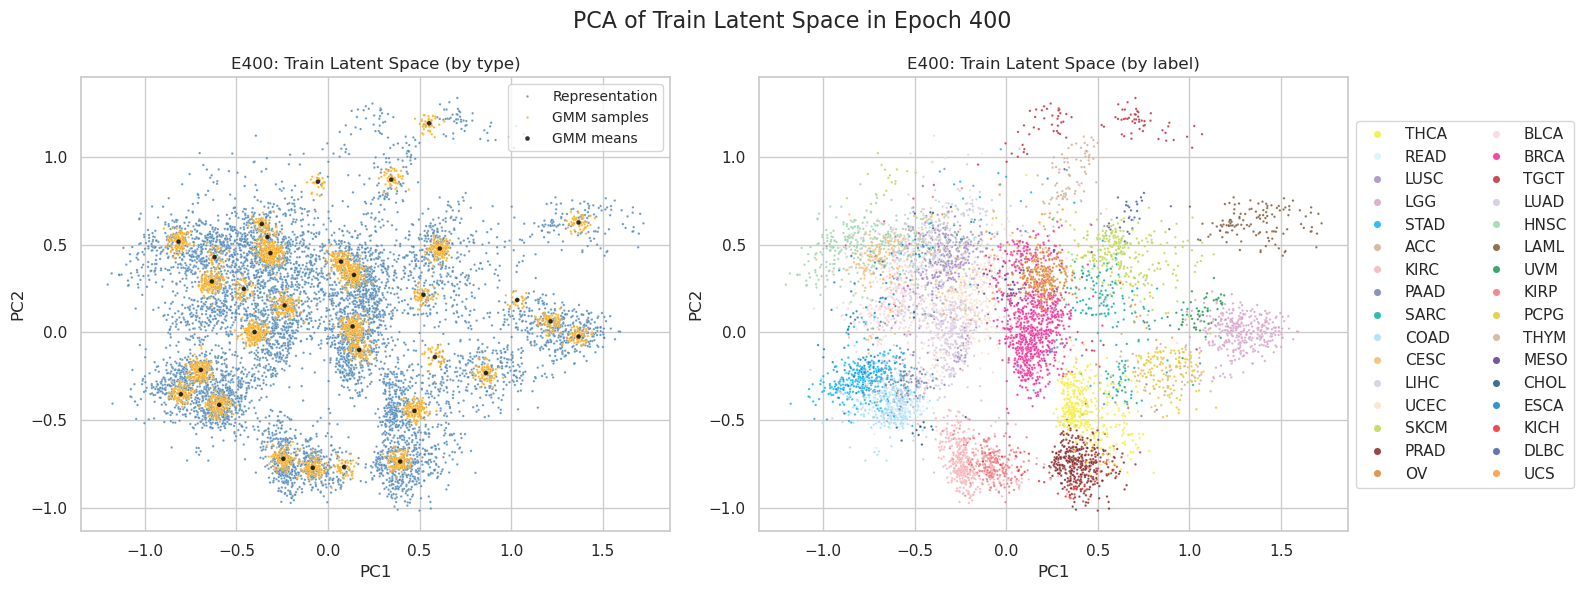

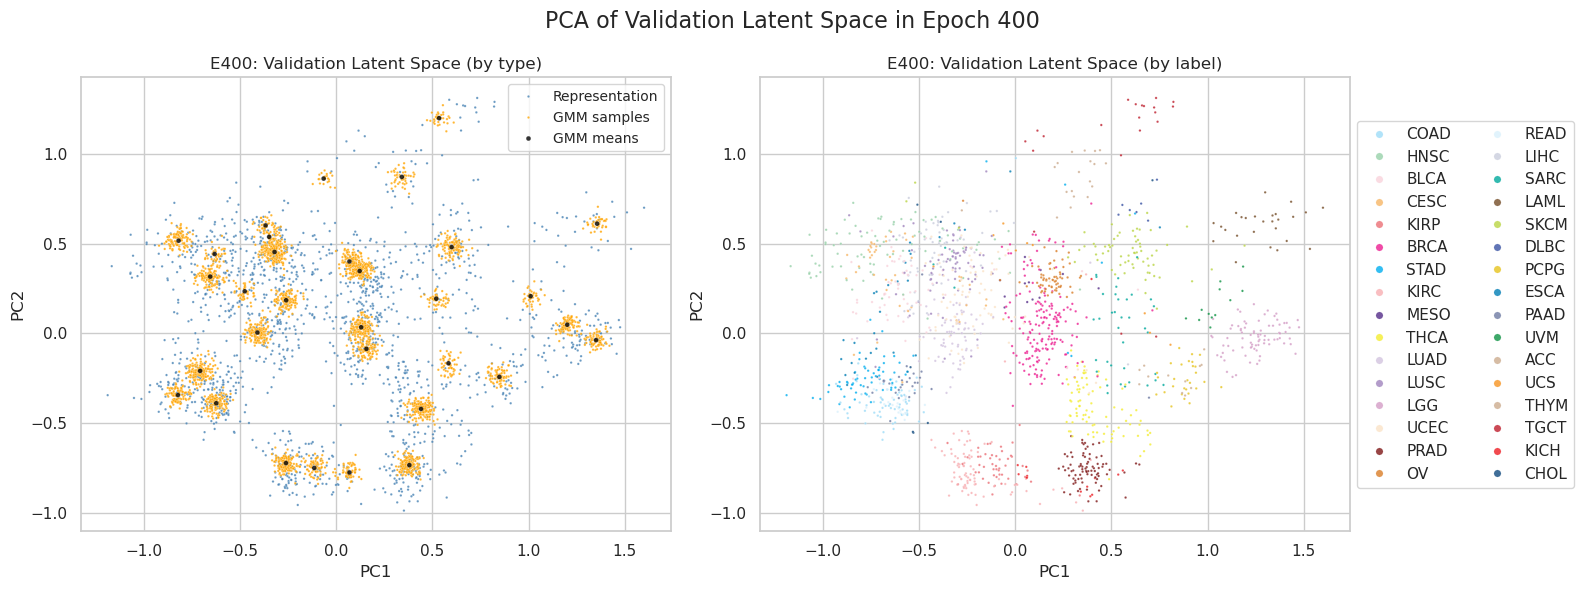

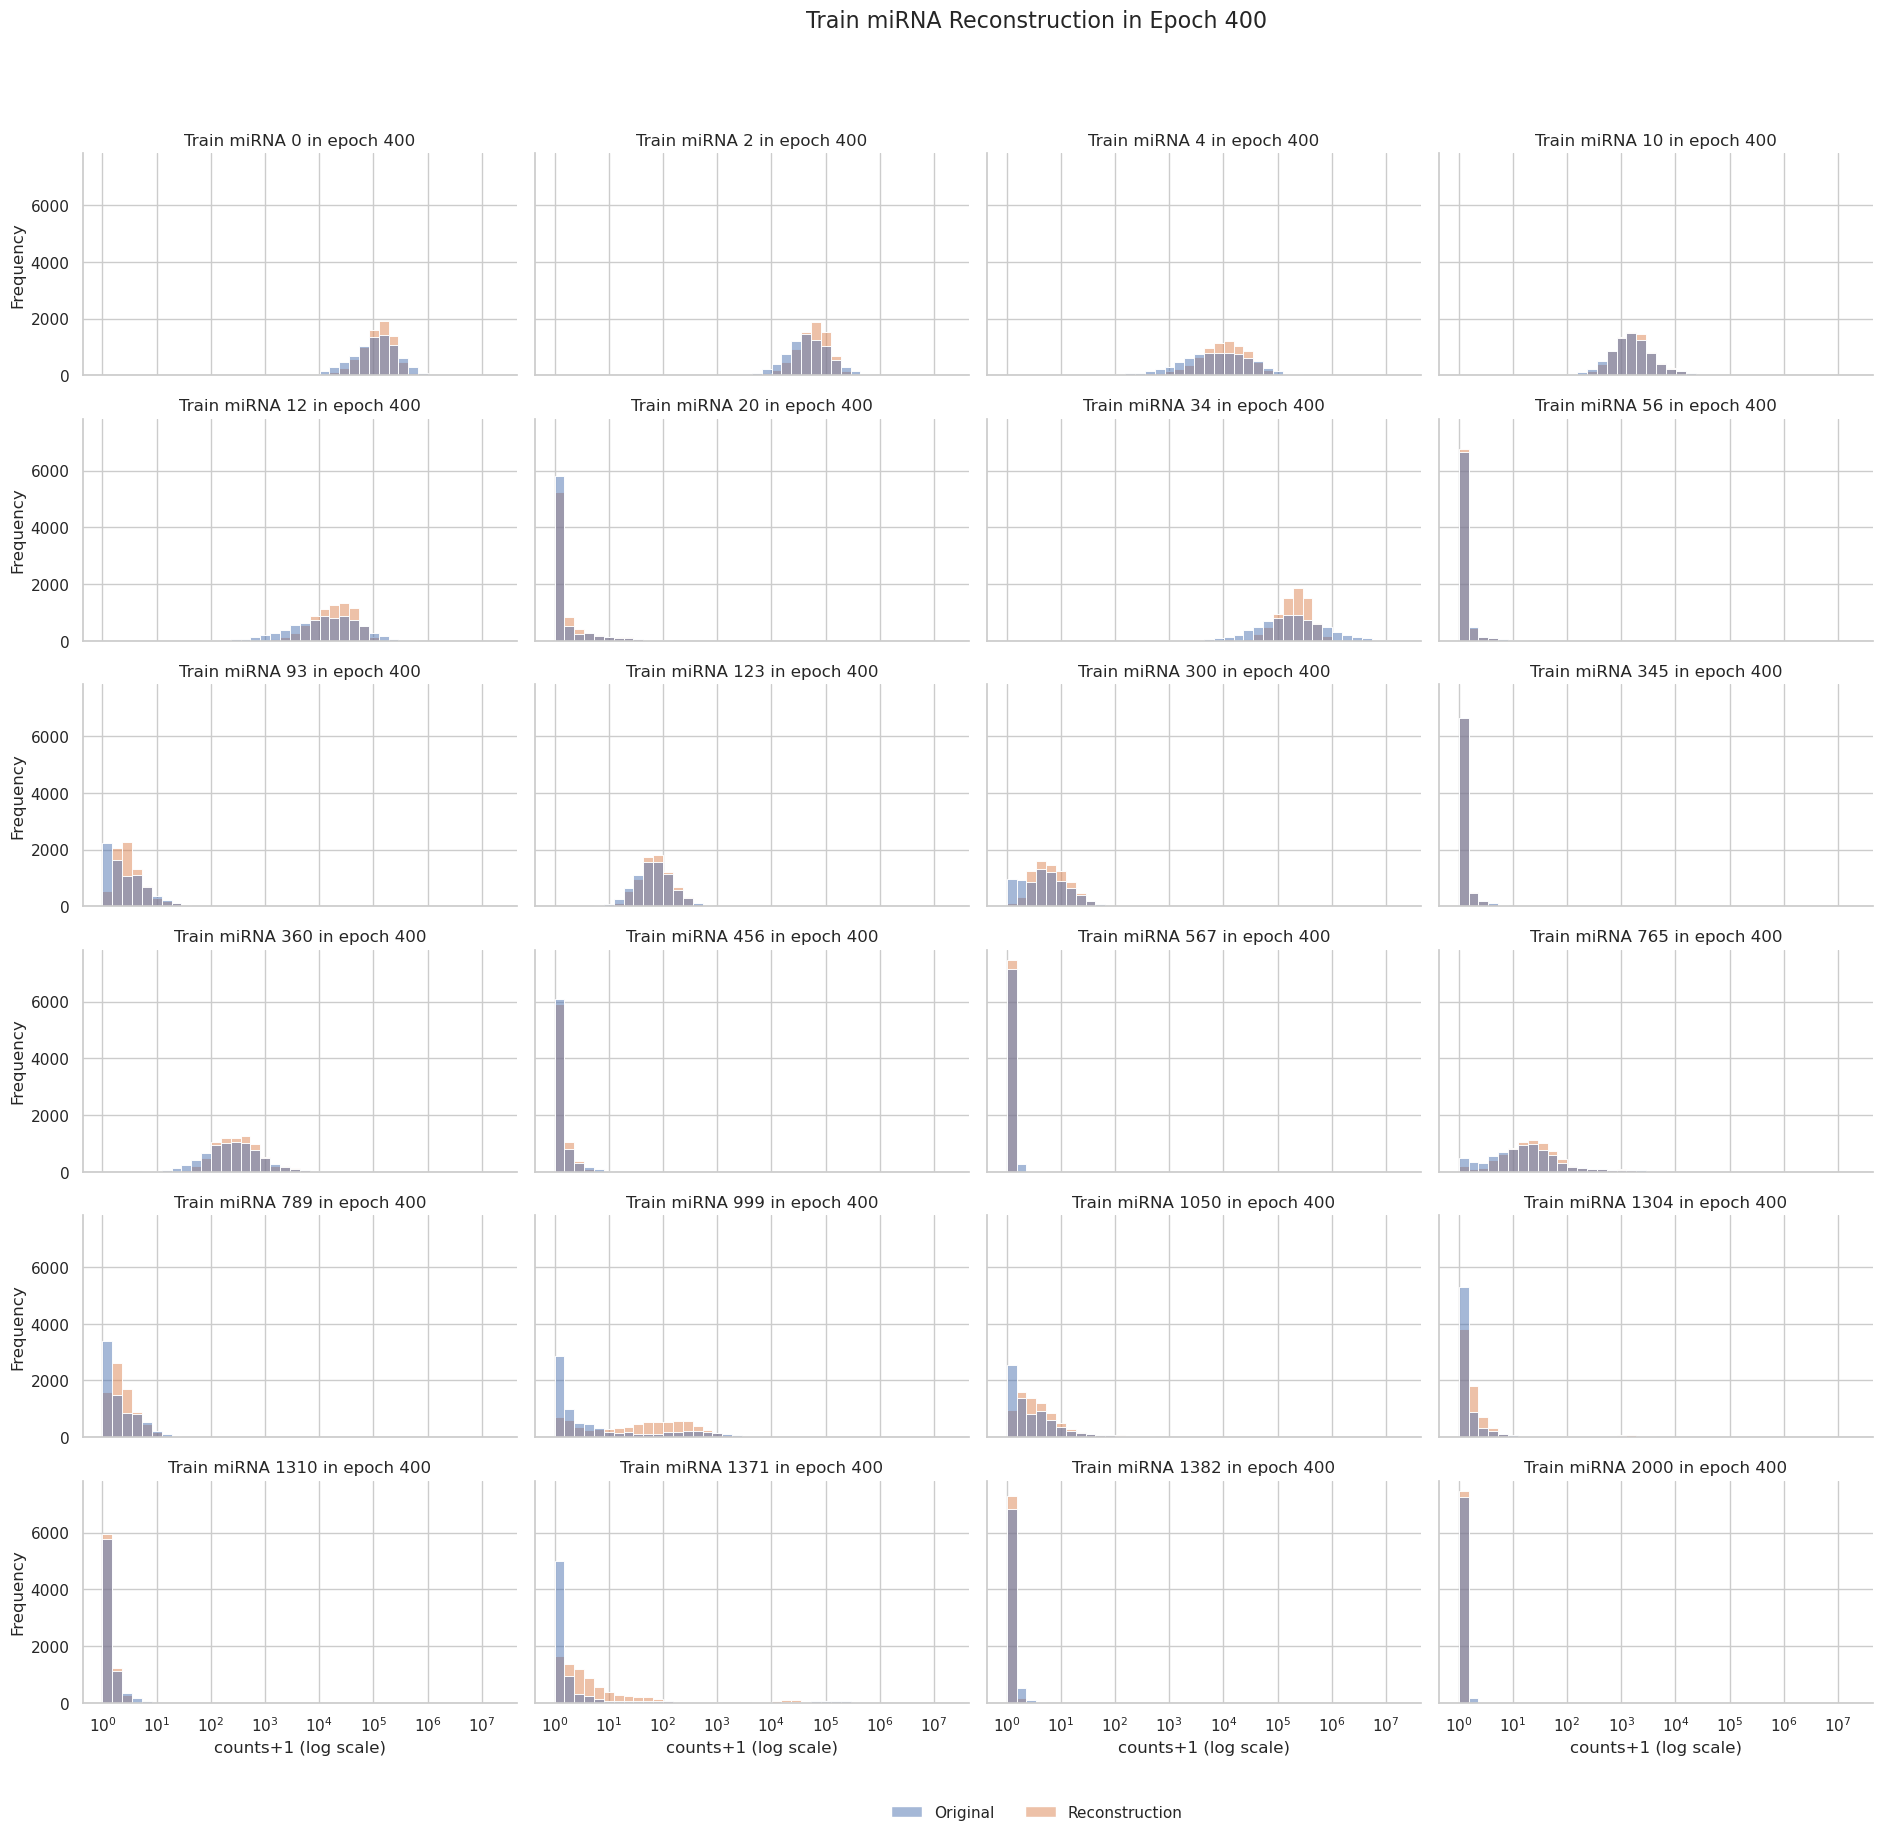

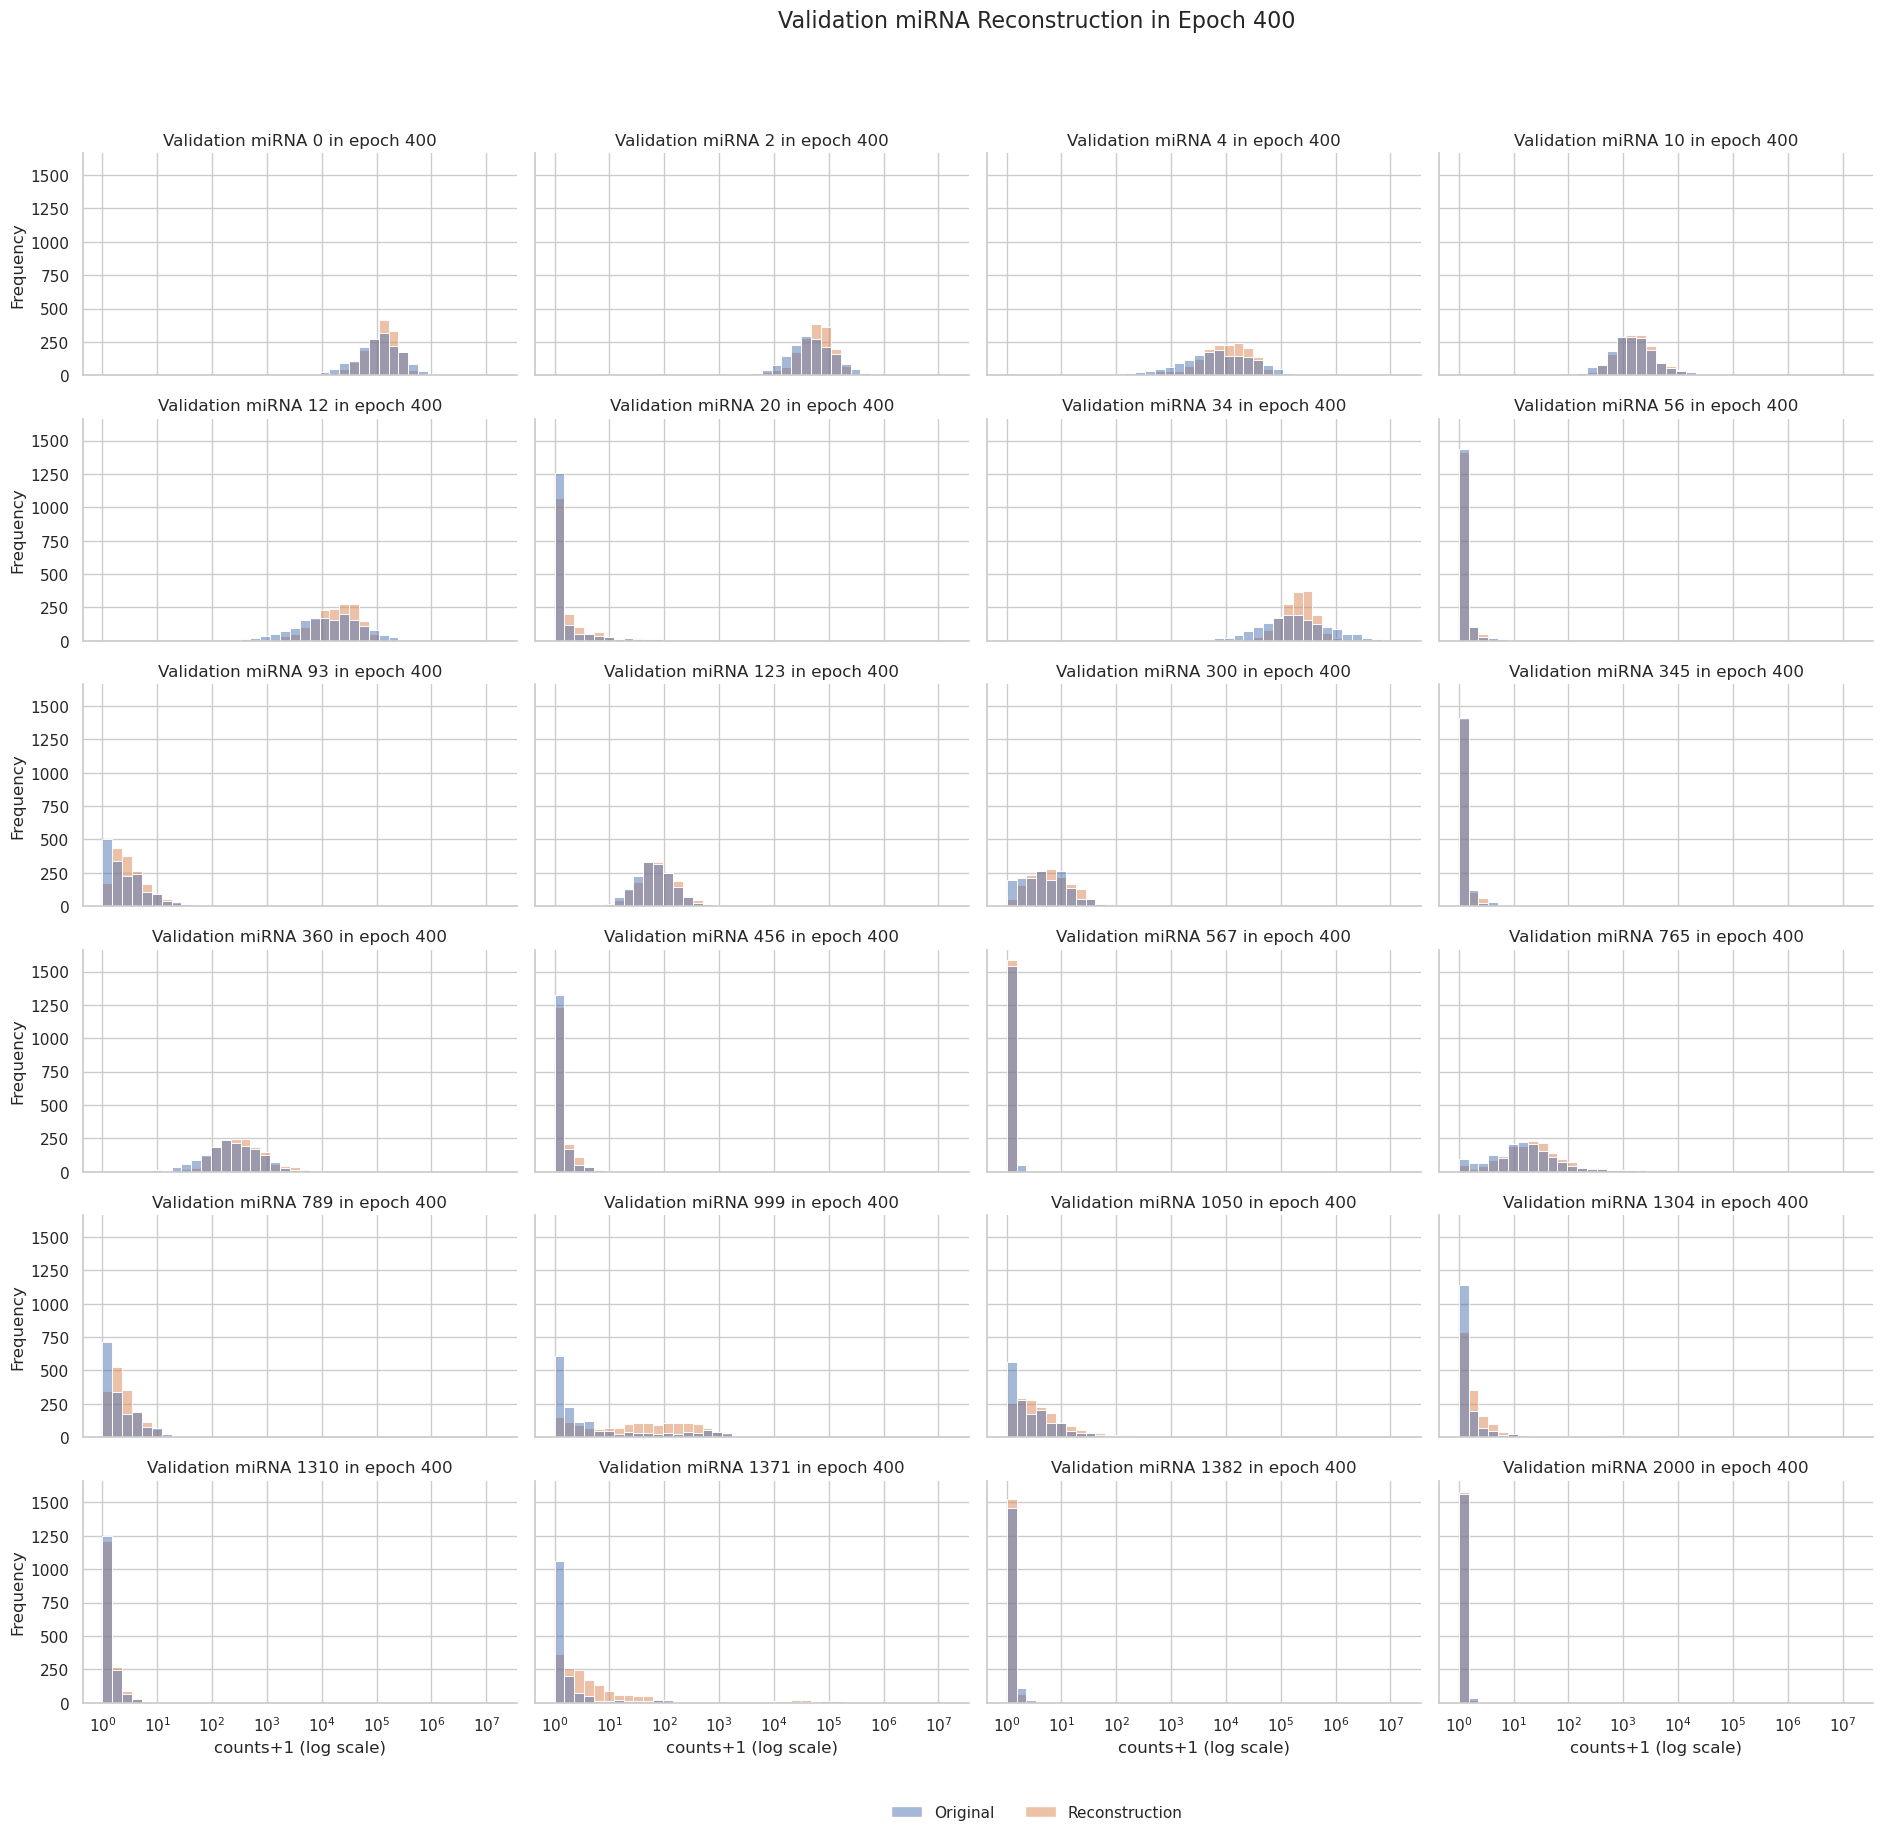

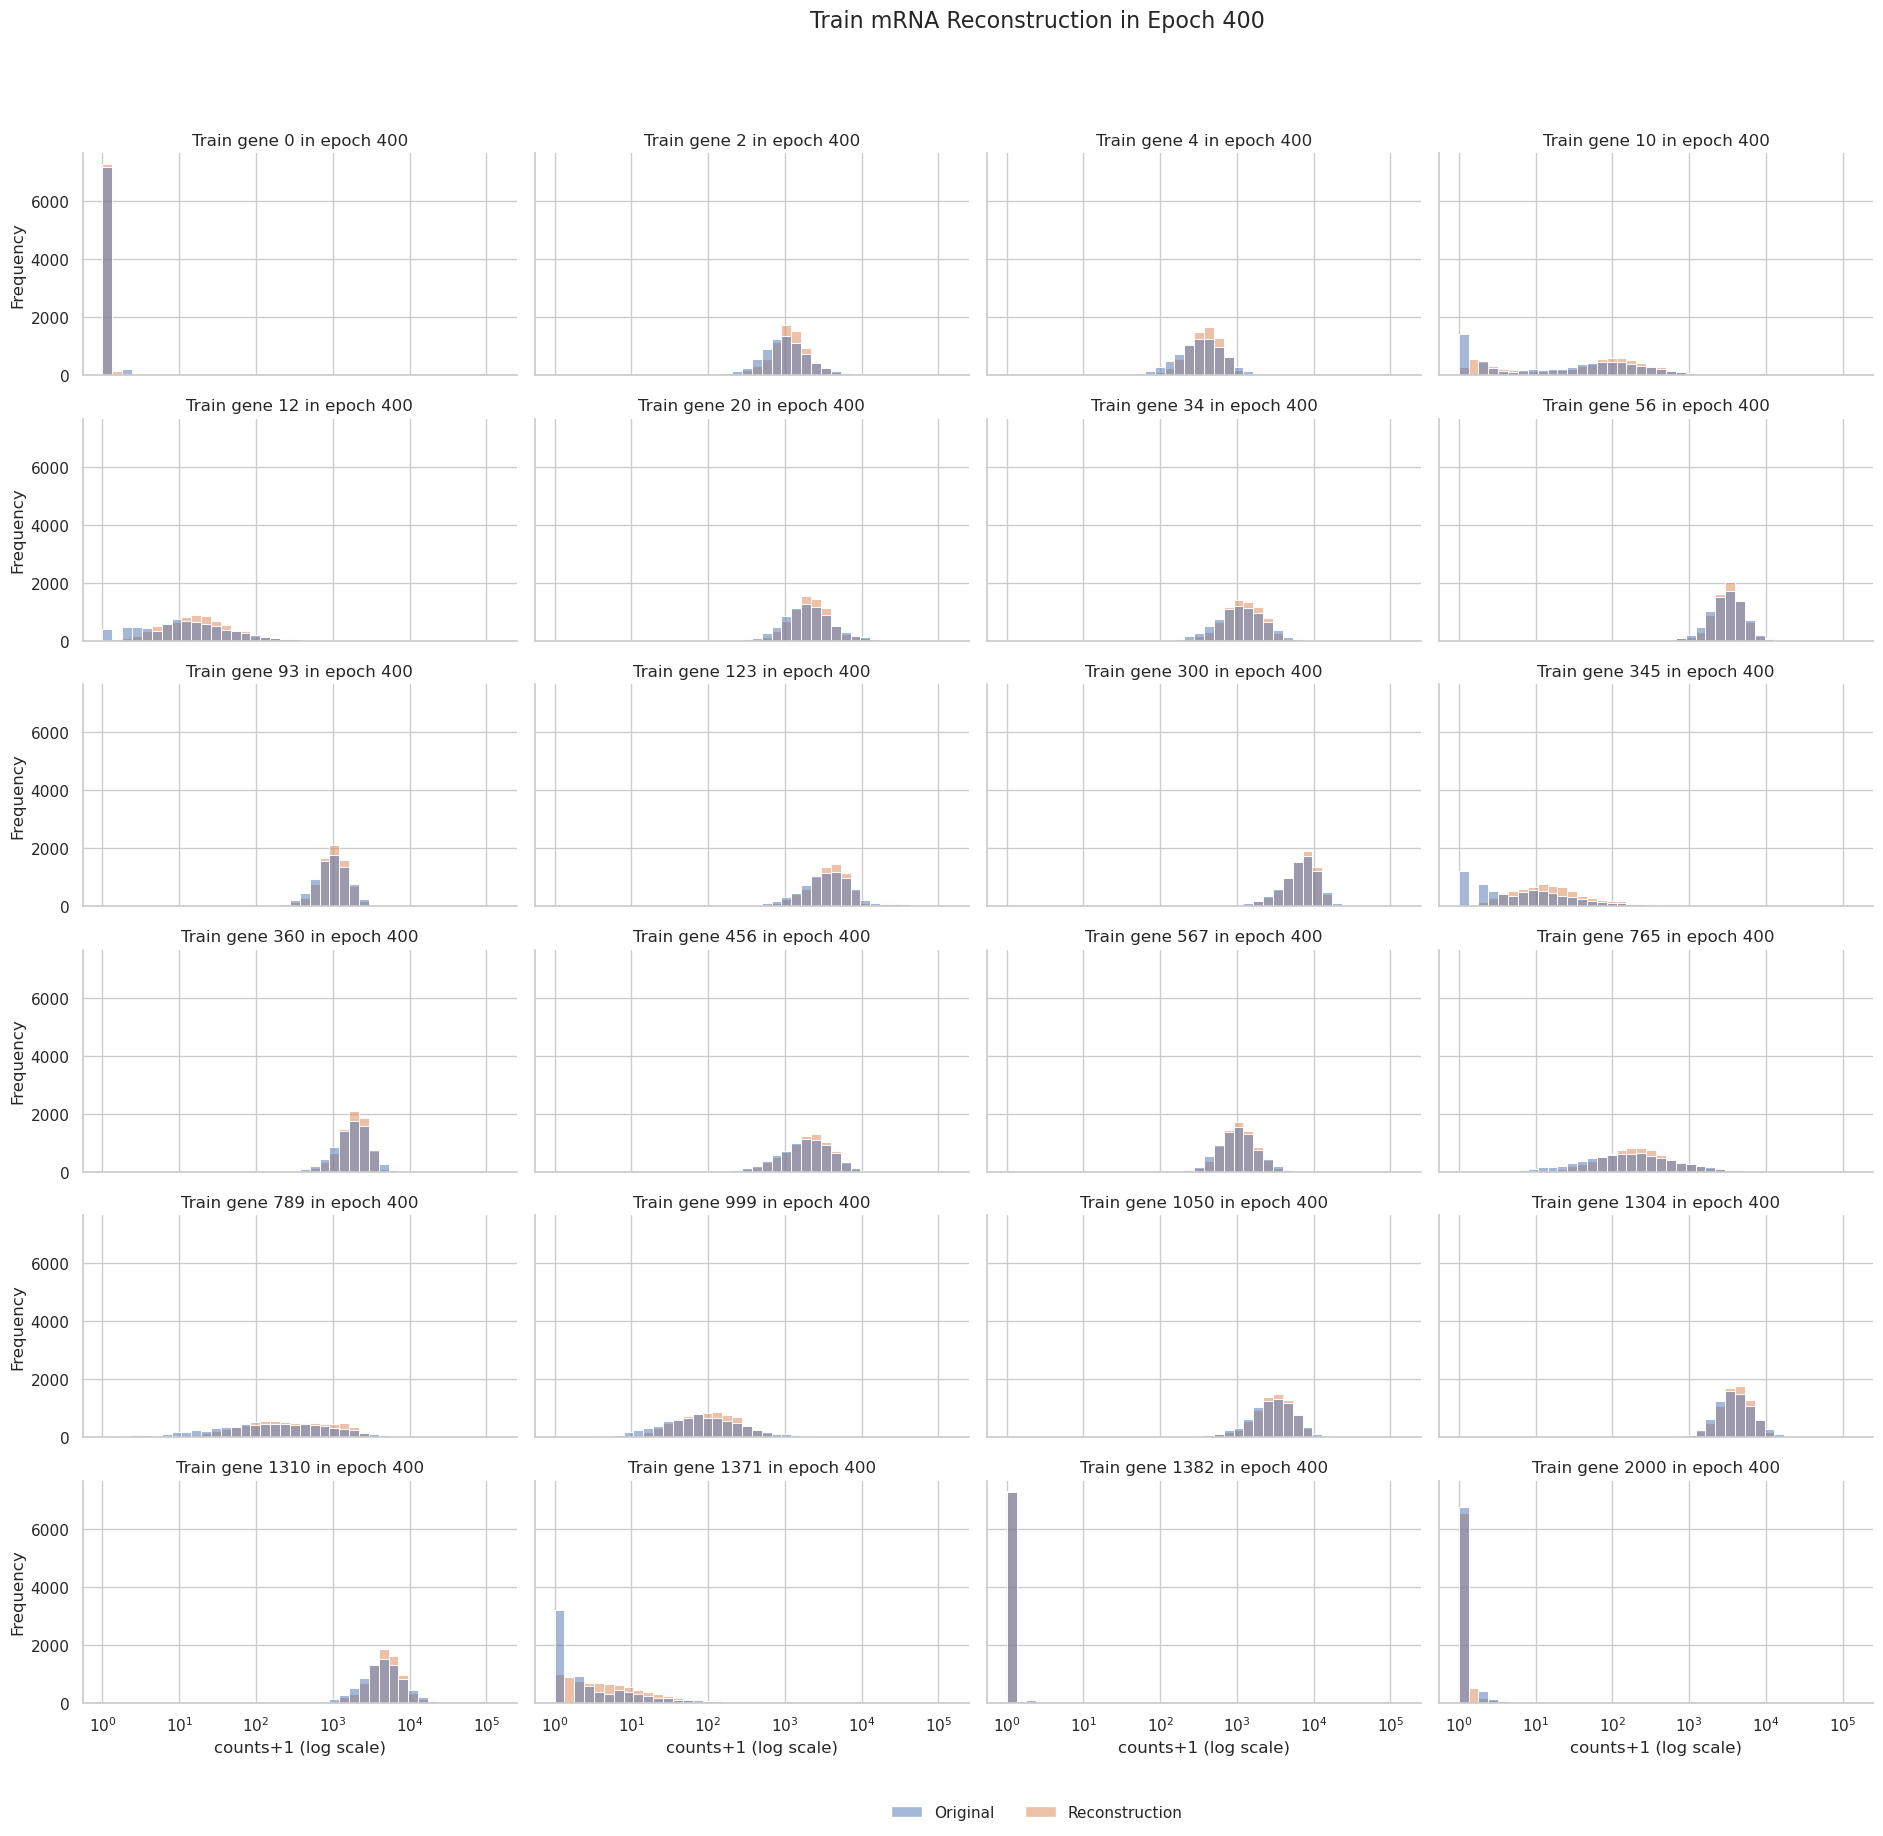

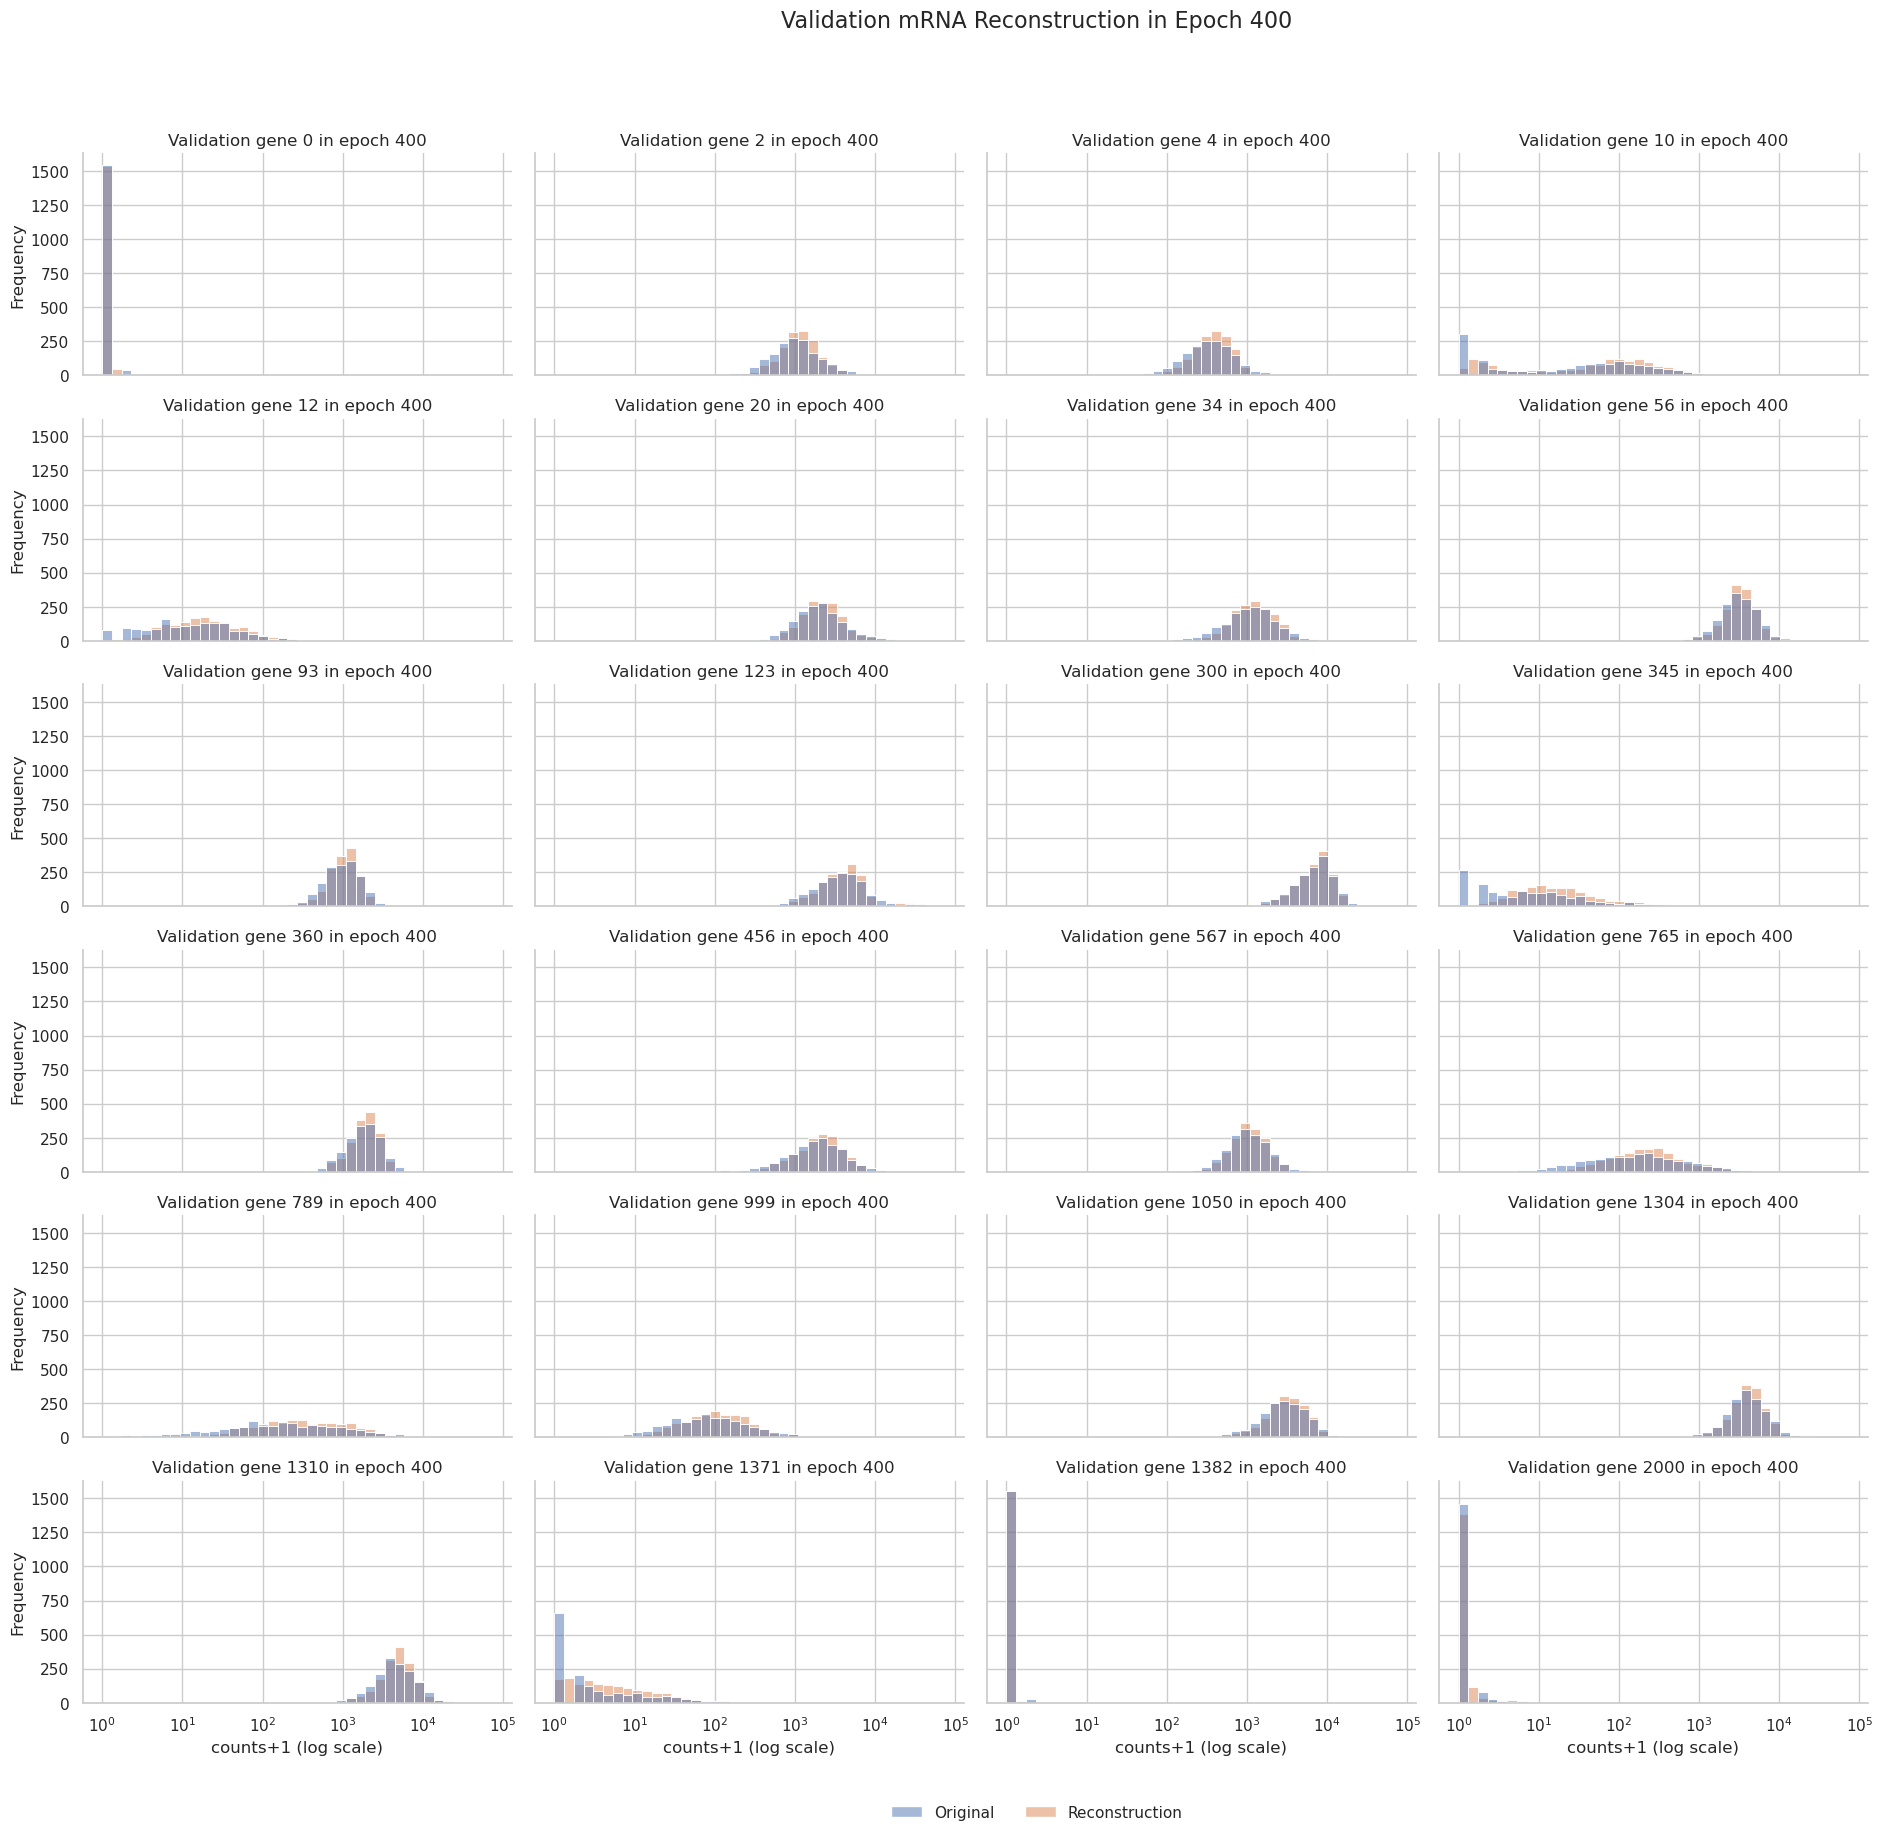

 51%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 406/801 [36:56<1:07:36, 10.27s/it]

405 train_recon_mirna: 1.869125981745747 train_recon_mrna: 6.36237654787263 train_gmm: 2.2833485084063043 train_mse: 443587.4375 train_mae: 67.62090301513672 train_r2: 0.36951786279678345 train_spearman: 0.4544100761413574 train_pearson: 0.6743265390396118 train_msle: 0.6531127691268921
405 test_recon_mirna: 2.1386011618386975 test_recon_mrna: 6.407506028806966 test_gmm: 2.279269151848454 test_mse: 305150.28125 test_mae: 76.90083312988281 test_r2: 0.5234460234642029 test_spearman: 0.3689879775047302 test_pearson: 0.780836284160614 test_msle: 0.8969659209251404


 51%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 411/801 [37:15<31:31,  4.85s/it]

410 train_recon_mirna: 1.8683950679709802 train_recon_mrna: 6.360266989699127 train_gmm: 2.284658947013938 train_mse: 443499.53125 train_mae: 67.5618896484375 train_r2: 0.36964279413223267 train_spearman: 0.45811909437179565 train_pearson: 0.6732047200202942 train_msle: 0.6578359603881836
410 test_recon_mirna: 2.1328512584309953 test_recon_mrna: 6.405130354391684 test_gmm: 2.2802348568765614 test_mse: 309232.53125 test_mae: 75.61598205566406 test_r2: 0.5170707702636719 test_spearman: 0.36814841628074646 test_pearson: 0.7900863885879517 test_msle: 0.8839372992515564


 52%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 416/801 [37:35<25:58,  4.05s/it]

415 train_recon_mirna: 1.8678802545388695 train_recon_mrna: 6.358050686539218 train_gmm: 2.2859741063923877 train_mse: 444004.625 train_mae: 67.36539459228516 train_r2: 0.36892491579055786 train_spearman: 0.4549078643321991 train_pearson: 0.6719267964363098 train_msle: 0.6573076248168945
415 test_recon_mirna: 2.1355110955387318 test_recon_mrna: 6.405641090852334 test_gmm: 2.282203627615553 test_mse: 306015.34375 test_mae: 76.82709503173828 test_r2: 0.5220950841903687 test_spearman: 0.36876145005226135 test_pearson: 0.7828536033630371 test_msle: 0.8944851756095886


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 421/801 [37:53<24:13,  3.82s/it]

420 train_recon_mirna: 1.8672070863210324 train_recon_mrna: 6.356193408507426 train_gmm: 2.2871875944154163 train_mse: 440075.65625 train_mae: 66.53575134277344 train_r2: 0.37450921535491943 train_spearman: 0.45673197507858276 train_pearson: 0.682869017124176 train_msle: 0.6391239166259766
420 test_recon_mirna: 2.135684105305355 test_recon_mrna: 6.403077252037876 test_gmm: 2.2837194420113405 test_mse: 310774.84375 test_mae: 76.40531921386719 test_r2: 0.5146621465682983 test_spearman: 0.36812081933021545 test_pearson: 0.7853131294250488 test_msle: 0.9259362816810608


 53%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 426/801 [38:12<23:42,  3.79s/it]

425 train_recon_mirna: 1.8665672169150178 train_recon_mrna: 6.35392414465034 train_gmm: 2.288280724017923 train_mse: 442934.3125 train_mae: 66.70616912841797 train_r2: 0.3704461455345154 train_spearman: 0.4568932056427002 train_pearson: 0.6796963214874268 train_msle: 0.6459501385688782
425 test_recon_mirna: 2.140432066143196 test_recon_mrna: 6.401596173254387 test_gmm: 2.284099598395534 test_mse: 315456.0625 test_mae: 74.91283416748047 test_r2: 0.5073515176773071 test_spearman: 0.363057404756546 test_pearson: 0.7977603673934937 test_msle: 0.9139907360076904


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 431/801 [38:32<23:43,  3.85s/it]

430 train_recon_mirna: 1.8659074822688424 train_recon_mrna: 6.352431883971972 train_gmm: 2.2893314434568612 train_mse: 434017.0625 train_mae: 67.16236877441406 train_r2: 0.38312047719955444 train_spearman: 0.4579552710056305 train_pearson: 0.682117223739624 train_msle: 0.6850983500480652
430 test_recon_mirna: 2.119460717177752 test_recon_mrna: 6.4036617418555934 test_gmm: 2.285112011901741 test_mse: 296014.03125 test_mae: 75.79257202148438 test_r2: 0.5377141237258911 test_spearman: 0.37055301666259766 test_pearson: 0.7943424582481384 test_msle: 0.9137555956840515


 54%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 436/801 [38:50<23:05,  3.80s/it]

435 train_recon_mirna: 1.8651445186201285 train_recon_mrna: 6.350162179510083 train_gmm: 2.290410020344072 train_mse: 437669.40625 train_mae: 67.07988739013672 train_r2: 0.37792932987213135 train_spearman: 0.4571244716644287 train_pearson: 0.6777029633522034 train_msle: 0.6579525470733643
435 test_recon_mirna: 2.1290471362698216 test_recon_mrna: 6.404351229749428 test_gmm: 2.284032699899477 test_mse: 302474.6875 test_mae: 76.11437225341797 test_r2: 0.5276244878768921 test_spearman: 0.3680538833141327 test_pearson: 0.7896602153778076 test_msle: 0.916368305683136


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 441/801 [39:09<22:37,  3.77s/it]

440 train_recon_mirna: 1.86462175805892 train_recon_mrna: 6.348382424198537 train_gmm: 2.291267351528001 train_mse: 433857.03125 train_mae: 66.8581314086914 train_r2: 0.3833479881286621 train_spearman: 0.4578666090965271 train_pearson: 0.6840695142745972 train_msle: 0.6559009552001953
440 test_recon_mirna: 2.129208322738012 test_recon_mrna: 6.396864441361351 test_gmm: 2.2863053273588774 test_mse: 297744.21875 test_mae: 76.02471160888672 test_r2: 0.5350121259689331 test_spearman: 0.3649526536464691 test_pearson: 0.7897181510925293 test_msle: 0.9143632650375366


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 446/801 [39:28<22:28,  3.80s/it]

445 train_recon_mirna: 1.8639529544089288 train_recon_mrna: 6.346939789177923 train_gmm: 2.2923923373493533 train_mse: 429050.84375 train_mae: 66.51249694824219 train_r2: 0.3901790976524353 train_spearman: 0.4569137394428253 train_pearson: 0.6894122362136841 train_msle: 0.6513159275054932
445 test_recon_mirna: 2.1281805154973545 test_recon_mrna: 6.400727949747481 test_gmm: 2.288130145099742 test_mse: 305037.15625 test_mae: 74.51041412353516 test_r2: 0.5236226916313171 test_spearman: 0.3690563142299652 test_pearson: 0.8008514642715454 test_msle: 0.9272423386573792


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 451/801 [39:47<21:49,  3.74s/it]

450 train_recon_mirna: 1.8634161197950962 train_recon_mrna: 6.3453323069546155 train_gmm: 2.293383874003705 train_mse: 433415.59375 train_mae: 65.40857696533203 train_r2: 0.38397538661956787 train_spearman: 0.45797425508499146 train_pearson: 0.6987245678901672 train_msle: 0.6287980675697327
450 test_recon_mirna: 2.1349146458148685 test_recon_mrna: 6.398225429682913 test_gmm: 2.2889793457946204 test_mse: 312572.40625 test_mae: 74.22262573242188 test_r2: 0.511854887008667 test_spearman: 0.36811959743499756 test_pearson: 0.8006502985954285 test_msle: 0.8975492119789124


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 456/801 [40:06<21:35,  3.76s/it]

455 train_recon_mirna: 1.8628245870740727 train_recon_mrna: 6.343194228093365 train_gmm: 2.294488545809184 train_mse: 429422.53125 train_mae: 66.2898941040039 train_r2: 0.389650821685791 train_spearman: 0.45762187242507935 train_pearson: 0.6872844099998474 train_msle: 0.6228144764900208
455 test_recon_mirna: 2.1341723432643382 test_recon_mrna: 6.39467148922709 test_gmm: 2.28987771772281 test_mse: 303393.5 test_mae: 74.12612915039062 test_r2: 0.5261895656585693 test_spearman: 0.3661598861217499 test_pearson: 0.7993916273117065 test_msle: 0.9009561538696289


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 461/801 [40:25<21:21,  3.77s/it]

460 train_recon_mirna: 1.862244542722047 train_recon_mrna: 6.34169892046333 train_gmm: 2.2959967079402515 train_mse: 425193.96875 train_mae: 65.90973663330078 train_r2: 0.39566099643707275 train_spearman: 0.45945608615875244 train_pearson: 0.6947335004806519 train_msle: 0.6443520784378052
460 test_recon_mirna: 2.1219121807053645 test_recon_mrna: 6.391837537838937 test_gmm: 2.2917876796972596 test_mse: 301412.125 test_mae: 74.92061614990234 test_r2: 0.529283881187439 test_spearman: 0.36839744448661804 test_pearson: 0.7965133786201477 test_msle: 0.8942131400108337


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 466/801 [40:43<20:55,  3.75s/it]

465 train_recon_mirna: 1.8616524738564761 train_recon_mrna: 6.340416282603323 train_gmm: 2.296924746143408 train_mse: 429484.9375 train_mae: 65.37260437011719 train_r2: 0.38956212997436523 train_spearman: 0.45912930369377136 train_pearson: 0.6992573142051697 train_msle: 0.6397256255149841
465 test_recon_mirna: 2.1228012811749326 test_recon_mrna: 6.393756042689114 test_gmm: 2.2941003822074095 test_mse: 307450.53125 test_mae: 74.15229034423828 test_r2: 0.5198537707328796 test_spearman: 0.3719173073768616 test_pearson: 0.8025408983230591 test_msle: 0.9028089642524719


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 471/801 [41:02<20:55,  3.80s/it]

470 train_recon_mirna: 1.861091847440972 train_recon_mrna: 6.339276651504913 train_gmm: 2.2978866219823657 train_mse: 425381.875 train_mae: 65.57537841796875 train_r2: 0.39539390802383423 train_spearman: 0.4566573202610016 train_pearson: 0.6993462443351746 train_msle: 0.6479324698448181
470 test_recon_mirna: 2.1237826728076326 test_recon_mrna: 6.396455301652971 test_gmm: 2.2940357634754647 test_mse: 308340.0625 test_mae: 73.8762435913086 test_r2: 0.5184645652770996 test_spearman: 0.3676656484603882 test_pearson: 0.806246817111969 test_msle: 0.9193588495254517


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 476/801 [41:21<20:22,  3.76s/it]

475 train_recon_mirna: 1.8608661181901751 train_recon_mrna: 6.337287090354549 train_gmm: 2.298899413539785 train_mse: 423998.25 train_mae: 65.49317169189453 train_r2: 0.3973604440689087 train_spearman: 0.46051153540611267 train_pearson: 0.7023630738258362 train_msle: 0.638982355594635
475 test_recon_mirna: 2.119660189530753 test_recon_mrna: 6.39015956195505 test_gmm: 2.29683103638839 test_mse: 306581.28125 test_mae: 73.89032745361328 test_r2: 0.5212112665176392 test_spearman: 0.36779269576072693 test_pearson: 0.8036373853683472 test_msle: 0.9203548431396484


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 481/801 [41:40<20:08,  3.78s/it]

480 train_recon_mirna: 1.8602796834910025 train_recon_mrna: 6.335943421950957 train_gmm: 2.300045133182582 train_mse: 425597.6875 train_mae: 65.26519775390625 train_r2: 0.3950871229171753 train_spearman: 0.4608054459095001 train_pearson: 0.6996820569038391 train_msle: 0.6364385485649109
480 test_recon_mirna: 2.120127865597218 test_recon_mrna: 6.3917382508228595 test_gmm: 2.2958116463465217 test_mse: 308634.96875 test_mae: 74.34492492675781 test_r2: 0.5180040597915649 test_spearman: 0.367691308259964 test_pearson: 0.8003719449043274 test_msle: 0.9342755675315857


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 486/801 [41:59<19:55,  3.80s/it]

485 train_recon_mirna: 1.859668339247576 train_recon_mrna: 6.33490637381821 train_gmm: 2.3009468477796107 train_mse: 419436.03125 train_mae: 65.54717254638672 train_r2: 0.4038448929786682 train_spearman: 0.4601401388645172 train_pearson: 0.6986605525016785 train_msle: 0.6440375447273254
485 test_recon_mirna: 2.1247054108505554 test_recon_mrna: 6.387967052783895 test_gmm: 2.2983493745364227 test_mse: 290915.625 test_mae: 73.09962463378906 test_r2: 0.5456763505935669 test_spearman: 0.37182778120040894 test_pearson: 0.8135253190994263 test_msle: 0.9265220761299133


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 491/801 [42:18<19:15,  3.73s/it]

490 train_recon_mirna: 1.8592009358691288 train_recon_mrna: 6.333375912703526 train_gmm: 2.3022369070319817 train_mse: 418992.46875 train_mae: 65.40325164794922 train_r2: 0.4044753313064575 train_spearman: 0.46494805812835693 train_pearson: 0.6999207139015198 train_msle: 0.6490994095802307
490 test_recon_mirna: 2.1238365720041577 test_recon_mrna: 6.388149110620259 test_gmm: 2.298748760235302 test_mse: 295199.78125 test_mae: 73.32975769042969 test_r2: 0.5389857292175293 test_spearman: 0.375465452671051 test_pearson: 0.8128618001937866 test_msle: 0.9269750714302063


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 496/801 [42:37<19:09,  3.77s/it]

495 train_recon_mirna: 1.858748294543823 train_recon_mrna: 6.332302856990669 train_gmm: 2.3032145247631055 train_mse: 419544.59375 train_mae: 65.46415710449219 train_r2: 0.4036905765533447 train_spearman: 0.45947274565696716 train_pearson: 0.6973701119422913 train_msle: 0.6392849087715149
495 test_recon_mirna: 2.123527690743557 test_recon_mrna: 6.390084511348888 test_gmm: 2.301213558847498 test_mse: 298912.40625 test_mae: 73.17940521240234 test_r2: 0.533187747001648 test_spearman: 0.3694121837615967 test_pearson: 0.8090156316757202 test_msle: 0.9081869721412659


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 501/801 [42:55<19:02,  3.81s/it]

500 train_recon_mirna: 1.8582207706637175 train_recon_mrna: 6.330353824703536 train_gmm: 2.304335853212189 train_mse: 418550.28125 train_mae: 64.90724182128906 train_r2: 0.40510380268096924 train_spearman: 0.4599270820617676 train_pearson: 0.7013702988624573 train_msle: 0.6357097625732422
500 test_recon_mirna: 2.1347353579346406 test_recon_mrna: 6.382012426317438 test_gmm: 2.30120044448538 test_mse: 301579.15625 test_mae: 73.33712005615234 test_r2: 0.5290230512619019 test_spearman: 0.3728124499320984 test_pearson: 0.8112690448760986 test_msle: 0.9303165078163147


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 506/801 [43:14<18:28,  3.76s/it]

505 train_recon_mirna: 1.8578811070810122 train_recon_mrna: 6.329894175606487 train_gmm: 2.305104486176276 train_mse: 421441.46875 train_mae: 64.22434997558594 train_r2: 0.4009944796562195 train_spearman: 0.46070942282676697 train_pearson: 0.7095693349838257 train_msle: 0.6171810626983643
505 test_recon_mirna: 2.1362061241831314 test_recon_mrna: 6.384170289445699 test_gmm: 2.303463358167259 test_mse: 309079.5625 test_mae: 73.3682861328125 test_r2: 0.5173096656799316 test_spearman: 0.3744862377643585 test_pearson: 0.8020238876342773 test_msle: 0.8856333494186401


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 511/801 [43:33<18:18,  3.79s/it]

510 train_recon_mirna: 1.8573022414205633 train_recon_mrna: 6.328178653696509 train_gmm: 2.306325614007301 train_mse: 417984.4375 train_mae: 64.10391998291016 train_r2: 0.4059080481529236 train_spearman: 0.46621450781822205 train_pearson: 0.7135801911354065 train_msle: 0.6193095445632935
510 test_recon_mirna: 2.13124518002891 test_recon_mrna: 6.383001562932037 test_gmm: 2.303556554009213 test_mse: 303312.375 test_mae: 72.65919494628906 test_r2: 0.5263162851333618 test_spearman: 0.37520691752433777 test_pearson: 0.8154589533805847 test_msle: 0.9364871978759766


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 516/801 [43:52<17:51,  3.76s/it]

515 train_recon_mirna: 1.8569577174137832 train_recon_mrna: 6.327163310434153 train_gmm: 2.3071800179866266 train_mse: 415796.59375 train_mae: 64.58309936523438 train_r2: 0.4090176820755005 train_spearman: 0.46494796872138977 train_pearson: 0.7075748443603516 train_msle: 0.642546534538269
515 test_recon_mirna: 2.1205356633113444 test_recon_mrna: 6.384074577774687 test_gmm: 2.304231974156777 test_mse: 296501.09375 test_mae: 73.7934341430664 test_r2: 0.5369534492492676 test_spearman: 0.3778705894947052 test_pearson: 0.8069446086883545 test_msle: 0.9615831971168518


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 521/801 [44:11<17:22,  3.72s/it]

520 train_recon_mirna: 1.8564239364478923 train_recon_mrna: 6.325864498988652 train_gmm: 2.308105248229564 train_mse: 417268.6875 train_mae: 64.51234436035156 train_r2: 0.40692538022994995 train_spearman: 0.4635452926158905 train_pearson: 0.7071197628974915 train_msle: 0.6344634890556335
520 test_recon_mirna: 2.1294853794596014 test_recon_mrna: 6.384671280718028 test_gmm: 2.306006149110907 test_mse: 298170.21875 test_mae: 73.04550170898438 test_r2: 0.5343468189239502 test_spearman: 0.37924912571907043 test_pearson: 0.8124093413352966 test_msle: 0.9410999417304993


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 526/801 [44:29<17:19,  3.78s/it]

525 train_recon_mirna: 1.8559363723816147 train_recon_mrna: 6.324584745395464 train_gmm: 2.308785125801845 train_mse: 416813.28125 train_mae: 64.1525650024414 train_r2: 0.4075726866722107 train_spearman: 0.46389567852020264 train_pearson: 0.704906702041626 train_msle: 0.6367638111114502
525 test_recon_mirna: 2.1240524098852496 test_recon_mrna: 6.377815540734081 test_gmm: 2.306207965419562 test_mse: 303848.65625 test_mae: 73.0282974243164 test_r2: 0.5254788398742676 test_spearman: 0.37818101048469543 test_pearson: 0.8136136531829834 test_msle: 0.9316951632499695


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 531/801 [44:48<16:49,  3.74s/it]

530 train_recon_mirna: 1.8554999775790342 train_recon_mrna: 6.3235968890942065 train_gmm: 2.309665905658809 train_mse: 419435.84375 train_mae: 64.22737884521484 train_r2: 0.4038451313972473 train_spearman: 0.46352553367614746 train_pearson: 0.7042558193206787 train_msle: 0.6302247643470764
530 test_recon_mirna: 2.1399316397329486 test_recon_mrna: 6.3794820786777775 test_gmm: 2.3079072360170403 test_mse: 302088.84375 test_mae: 72.23519134521484 test_r2: 0.5282270908355713 test_spearman: 0.3769564926624298 test_pearson: 0.817290723323822 test_msle: 0.9007042050361633


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 536/801 [45:07<16:38,  3.77s/it]

535 train_recon_mirna: 1.8550421721177133 train_recon_mrna: 6.322612533906488 train_gmm: 2.3106409473845426 train_mse: 421598.0625 train_mae: 63.95161056518555 train_r2: 0.4007719159126282 train_spearman: 0.46278929710388184 train_pearson: 0.7100450992584229 train_msle: 0.6297599077224731
535 test_recon_mirna: 2.1367359545386653 test_recon_mrna: 6.381993695306119 test_gmm: 2.3081175919103294 test_mse: 302096.25 test_mae: 72.06224822998047 test_r2: 0.5282155275344849 test_spearman: 0.37968531250953674 test_pearson: 0.8111870884895325 test_msle: 0.9493631720542908


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 541/801 [45:26<16:17,  3.76s/it]

540 train_recon_mirna: 1.8545953498718575 train_recon_mrna: 6.321530350895698 train_gmm: 2.3114243731861785 train_mse: 421057.53125 train_mae: 64.29004669189453 train_r2: 0.40154021978378296 train_spearman: 0.46429818868637085 train_pearson: 0.7018387913703918 train_msle: 0.6217834949493408
540 test_recon_mirna: 2.1396725590540004 test_recon_mrna: 6.382165343509504 test_gmm: 2.310340194177955 test_mse: 296746.09375 test_mae: 72.05140686035156 test_r2: 0.5365709066390991 test_spearman: 0.37786146998405457 test_pearson: 0.8187792301177979 test_msle: 0.9392527937889099


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 546/801 [45:45<15:54,  3.74s/it]

545 train_recon_mirna: 1.8541946226276254 train_recon_mrna: 6.32070151225668 train_gmm: 2.3125541761539457 train_mse: 416406.5625 train_mae: 64.5943603515625 train_r2: 0.40815073251724243 train_spearman: 0.46372538805007935 train_pearson: 0.70029217004776 train_msle: 0.6281712651252747
545 test_recon_mirna: 2.1431311342281134 test_recon_mrna: 6.375967735959565 test_gmm: 2.3105757723444333 test_mse: 288259.0 test_mae: 71.42853546142578 test_r2: 0.5498251914978027 test_spearman: 0.3787532448768616 test_pearson: 0.8245864510536194 test_msle: 0.9463784098625183


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 551/801 [46:04<15:47,  3.79s/it]

550 train_recon_mirna: 1.853895879580191 train_recon_mrna: 6.31977908576849 train_gmm: 2.3132307263178693 train_mse: 415192.40625 train_mae: 65.01579284667969 train_r2: 0.40987640619277954 train_spearman: 0.46263641119003296 train_pearson: 0.6990949511528015 train_msle: 0.6459476351737976
550 test_recon_mirna: 2.137951545847087 test_recon_mrna: 6.3755078611554925 test_gmm: 2.3127407400404043 test_mse: 283687.0 test_mae: 71.6296615600586 test_r2: 0.5569653511047363 test_spearman: 0.3755109906196594 test_pearson: 0.8186129927635193 test_msle: 0.9609476327896118


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 556/801 [46:22<15:15,  3.74s/it]

555 train_recon_mirna: 1.8533162680693316 train_recon_mrna: 6.318166787395771 train_gmm: 2.314149156363952 train_mse: 416153.21875 train_mae: 64.3991470336914 train_r2: 0.40851080417633057 train_spearman: 0.4668292999267578 train_pearson: 0.7045400738716125 train_msle: 0.6418452262878418
555 test_recon_mirna: 2.141754790422488 test_recon_mrna: 6.377913720342394 test_gmm: 2.3138858068443553 test_mse: 291388.6875 test_mae: 70.45805358886719 test_r2: 0.5449376106262207 test_spearman: 0.380411297082901 test_pearson: 0.8320149779319763 test_msle: 0.9853112101554871


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 561/801 [46:41<15:01,  3.76s/it]

560 train_recon_mirna: 1.8529799773420148 train_recon_mrna: 6.317257595997974 train_gmm: 2.3150607208737917 train_mse: 416228.78125 train_mae: 64.66327667236328 train_r2: 0.4084033966064453 train_spearman: 0.466838538646698 train_pearson: 0.6987170577049255 train_msle: 0.6362205743789673
560 test_recon_mirna: 2.149187884054679 test_recon_mrna: 6.37698962020375 test_gmm: 2.31633521895495 test_mse: 285533.0625 test_mae: 71.21986389160156 test_r2: 0.5540822744369507 test_spearman: 0.37936702370643616 test_pearson: 0.8217958807945251 test_msle: 0.9525550007820129


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 566/801 [47:00<14:45,  3.77s/it]

565 train_recon_mirna: 1.8524968170988683 train_recon_mrna: 6.316276911387182 train_gmm: 2.31599183492866 train_mse: 419665.6875 train_mae: 63.82211685180664 train_r2: 0.4035184383392334 train_spearman: 0.4683629274368286 train_pearson: 0.7066938877105713 train_msle: 0.6049002408981323
565 test_recon_mirna: 2.1481921810232243 test_recon_mrna: 6.378606593739963 test_gmm: 2.314941955223298 test_mse: 294487.1875 test_mae: 70.11322021484375 test_r2: 0.5400986075401306 test_spearman: 0.38655757904052734 test_pearson: 0.8280295133590698 test_msle: 0.9550902843475342


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 571/801 [47:18<14:14,  3.72s/it]

570 train_recon_mirna: 1.8521643992153043 train_recon_mrna: 6.315298097652164 train_gmm: 2.316780855415433 train_mse: 418581.59375 train_mae: 64.52708435058594 train_r2: 0.405059278011322 train_spearman: 0.46799954771995544 train_pearson: 0.7006171941757202 train_msle: 0.6290204524993896
570 test_recon_mirna: 2.153313395484665 test_recon_mrna: 6.375492990251236 test_gmm: 2.315743806971229 test_mse: 285348.4375 test_mae: 71.19921875 test_r2: 0.554370641708374 test_spearman: 0.3819150924682617 test_pearson: 0.822970449924469 test_msle: 0.9675450921058655


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 576/801 [47:37<14:04,  3.75s/it]

575 train_recon_mirna: 1.851852282512169 train_recon_mrna: 6.3143523360558165 train_gmm: 2.317555246413129 train_mse: 418118.9375 train_mae: 65.20124053955078 train_r2: 0.4057168960571289 train_spearman: 0.46745190024375916 train_pearson: 0.6908153295516968 train_msle: 0.6334438920021057
575 test_recon_mirna: 2.145749040094753 test_recon_mrna: 6.374921045781471 test_gmm: 2.316917450885189 test_mse: 280007.8125 test_mae: 71.44795989990234 test_r2: 0.5627111196517944 test_spearman: 0.3822515308856964 test_pearson: 0.8200189471244812 test_msle: 1.0006029605865479


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 581/801 [47:56<13:49,  3.77s/it]

580 train_recon_mirna: 1.8513456610381696 train_recon_mrna: 6.313535234450865 train_gmm: 2.3186121044876136 train_mse: 417581.125 train_mae: 64.6572265625 train_r2: 0.4064812660217285 train_spearman: 0.4645926058292389 train_pearson: 0.6961192488670349 train_msle: 0.6262171268463135
580 test_recon_mirna: 2.158421369009117 test_recon_mrna: 6.376559360647303 test_gmm: 2.317706554253201 test_mse: 288573.5625 test_mae: 70.98452758789062 test_r2: 0.549333930015564 test_spearman: 0.3778977692127228 test_pearson: 0.8166182041168213 test_msle: 0.9854080080986023


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 586/801 [48:15<13:23,  3.74s/it]

585 train_recon_mirna: 1.8510046266195987 train_recon_mrna: 6.31266224043217 train_gmm: 2.319237863077914 train_mse: 420961.875 train_mae: 63.98696517944336 train_r2: 0.40167611837387085 train_spearman: 0.4672539234161377 train_pearson: 0.7028014063835144 train_msle: 0.627468466758728
585 test_recon_mirna: 2.1648001445952754 test_recon_mrna: 6.375824263373713 test_gmm: 2.319382005509252 test_mse: 296760.1875 test_mae: 71.23226165771484 test_r2: 0.5365488529205322 test_spearman: 0.38500574231147766 test_pearson: 0.823143482208252 test_msle: 0.9733458161354065


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 591/801 [48:34<13:13,  3.78s/it]

590 train_recon_mirna: 1.850594602071079 train_recon_mrna: 6.312049159186062 train_gmm: 2.320192830910026 train_mse: 417139.875 train_mae: 64.28645324707031 train_r2: 0.40710848569869995 train_spearman: 0.4684823751449585 train_pearson: 0.6991561055183411 train_msle: 0.6320230960845947
590 test_recon_mirna: 2.1601724130082975 test_recon_mrna: 6.373691933904462 test_gmm: 2.318744487393133 test_mse: 285291.8125 test_mae: 71.29632568359375 test_r2: 0.5544590950012207 test_spearman: 0.38328057527542114 test_pearson: 0.8173325657844543 test_msle: 1.0069546699523926


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 596/801 [48:52<12:46,  3.74s/it]

595 train_recon_mirna: 1.8502554601704475 train_recon_mrna: 6.311280164846932 train_gmm: 2.321084595951676 train_mse: 420133.1875 train_mae: 63.86812973022461 train_r2: 0.40285396575927734 train_spearman: 0.46835780143737793 train_pearson: 0.7018497586250305 train_msle: 0.6264378428459167
595 test_recon_mirna: 2.169228249528457 test_recon_mrna: 6.373339303632257 test_gmm: 2.3202213323093965 test_mse: 289998.03125 test_mae: 70.62127685546875 test_r2: 0.5471093654632568 test_spearman: 0.381863534450531 test_pearson: 0.8267256021499634 test_msle: 0.9981474280357361


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 600/801 [49:07<12:39,  3.78s/it]

600 train_recon_mirna: 1.849896589390118 train_recon_mrna: 6.310135619310348 train_gmm: 2.3217049166713712 train_mse: 416157.09375 train_mae: 63.87574005126953 train_r2: 0.40850532054901123 train_spearman: 0.46979689598083496 train_pearson: 0.7054411172866821 train_msle: 0.6082336902618408
600 test_recon_mirna: 2.1760398388451634 test_recon_mrna: 6.370198995796311 test_gmm: 2.3208748773959633 test_mse: 284783.8125 test_mae: 70.18073272705078 test_r2: 0.5552524328231812 test_spearman: 0.3818739652633667 test_pearson: 0.8276904821395874 test_msle: 0.9757116436958313


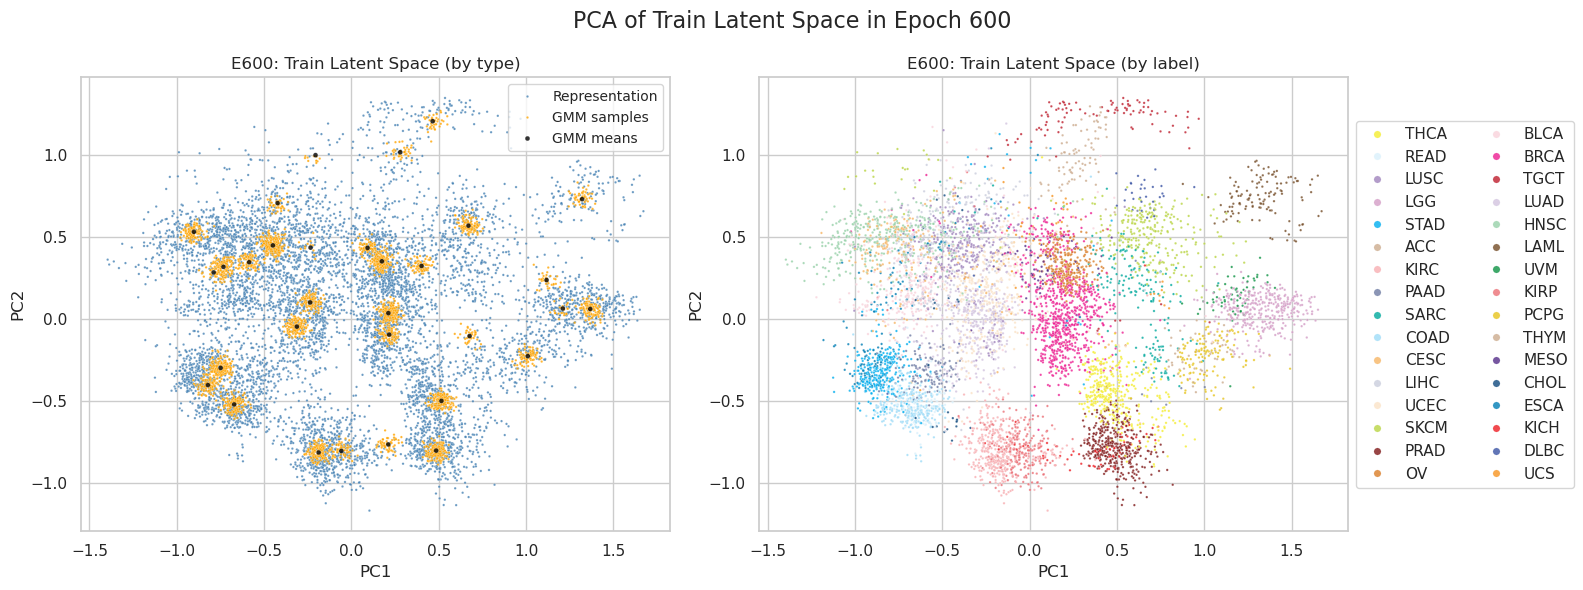

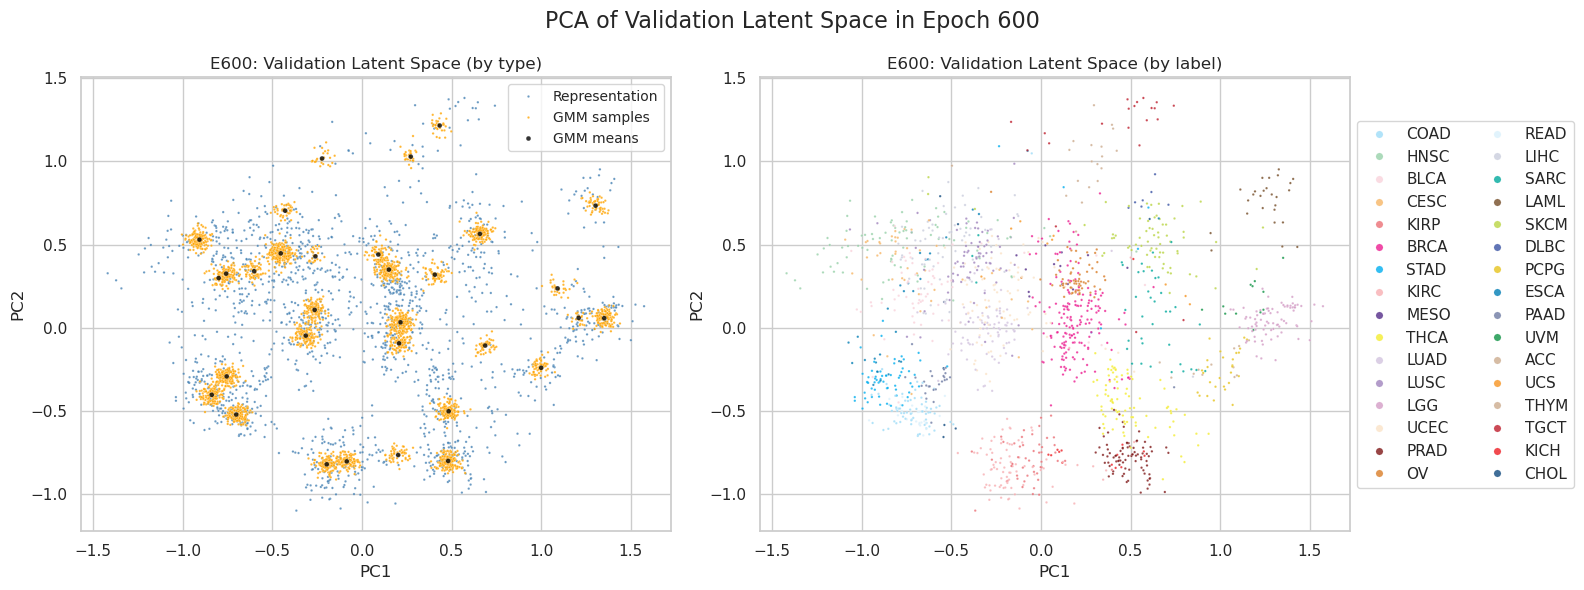

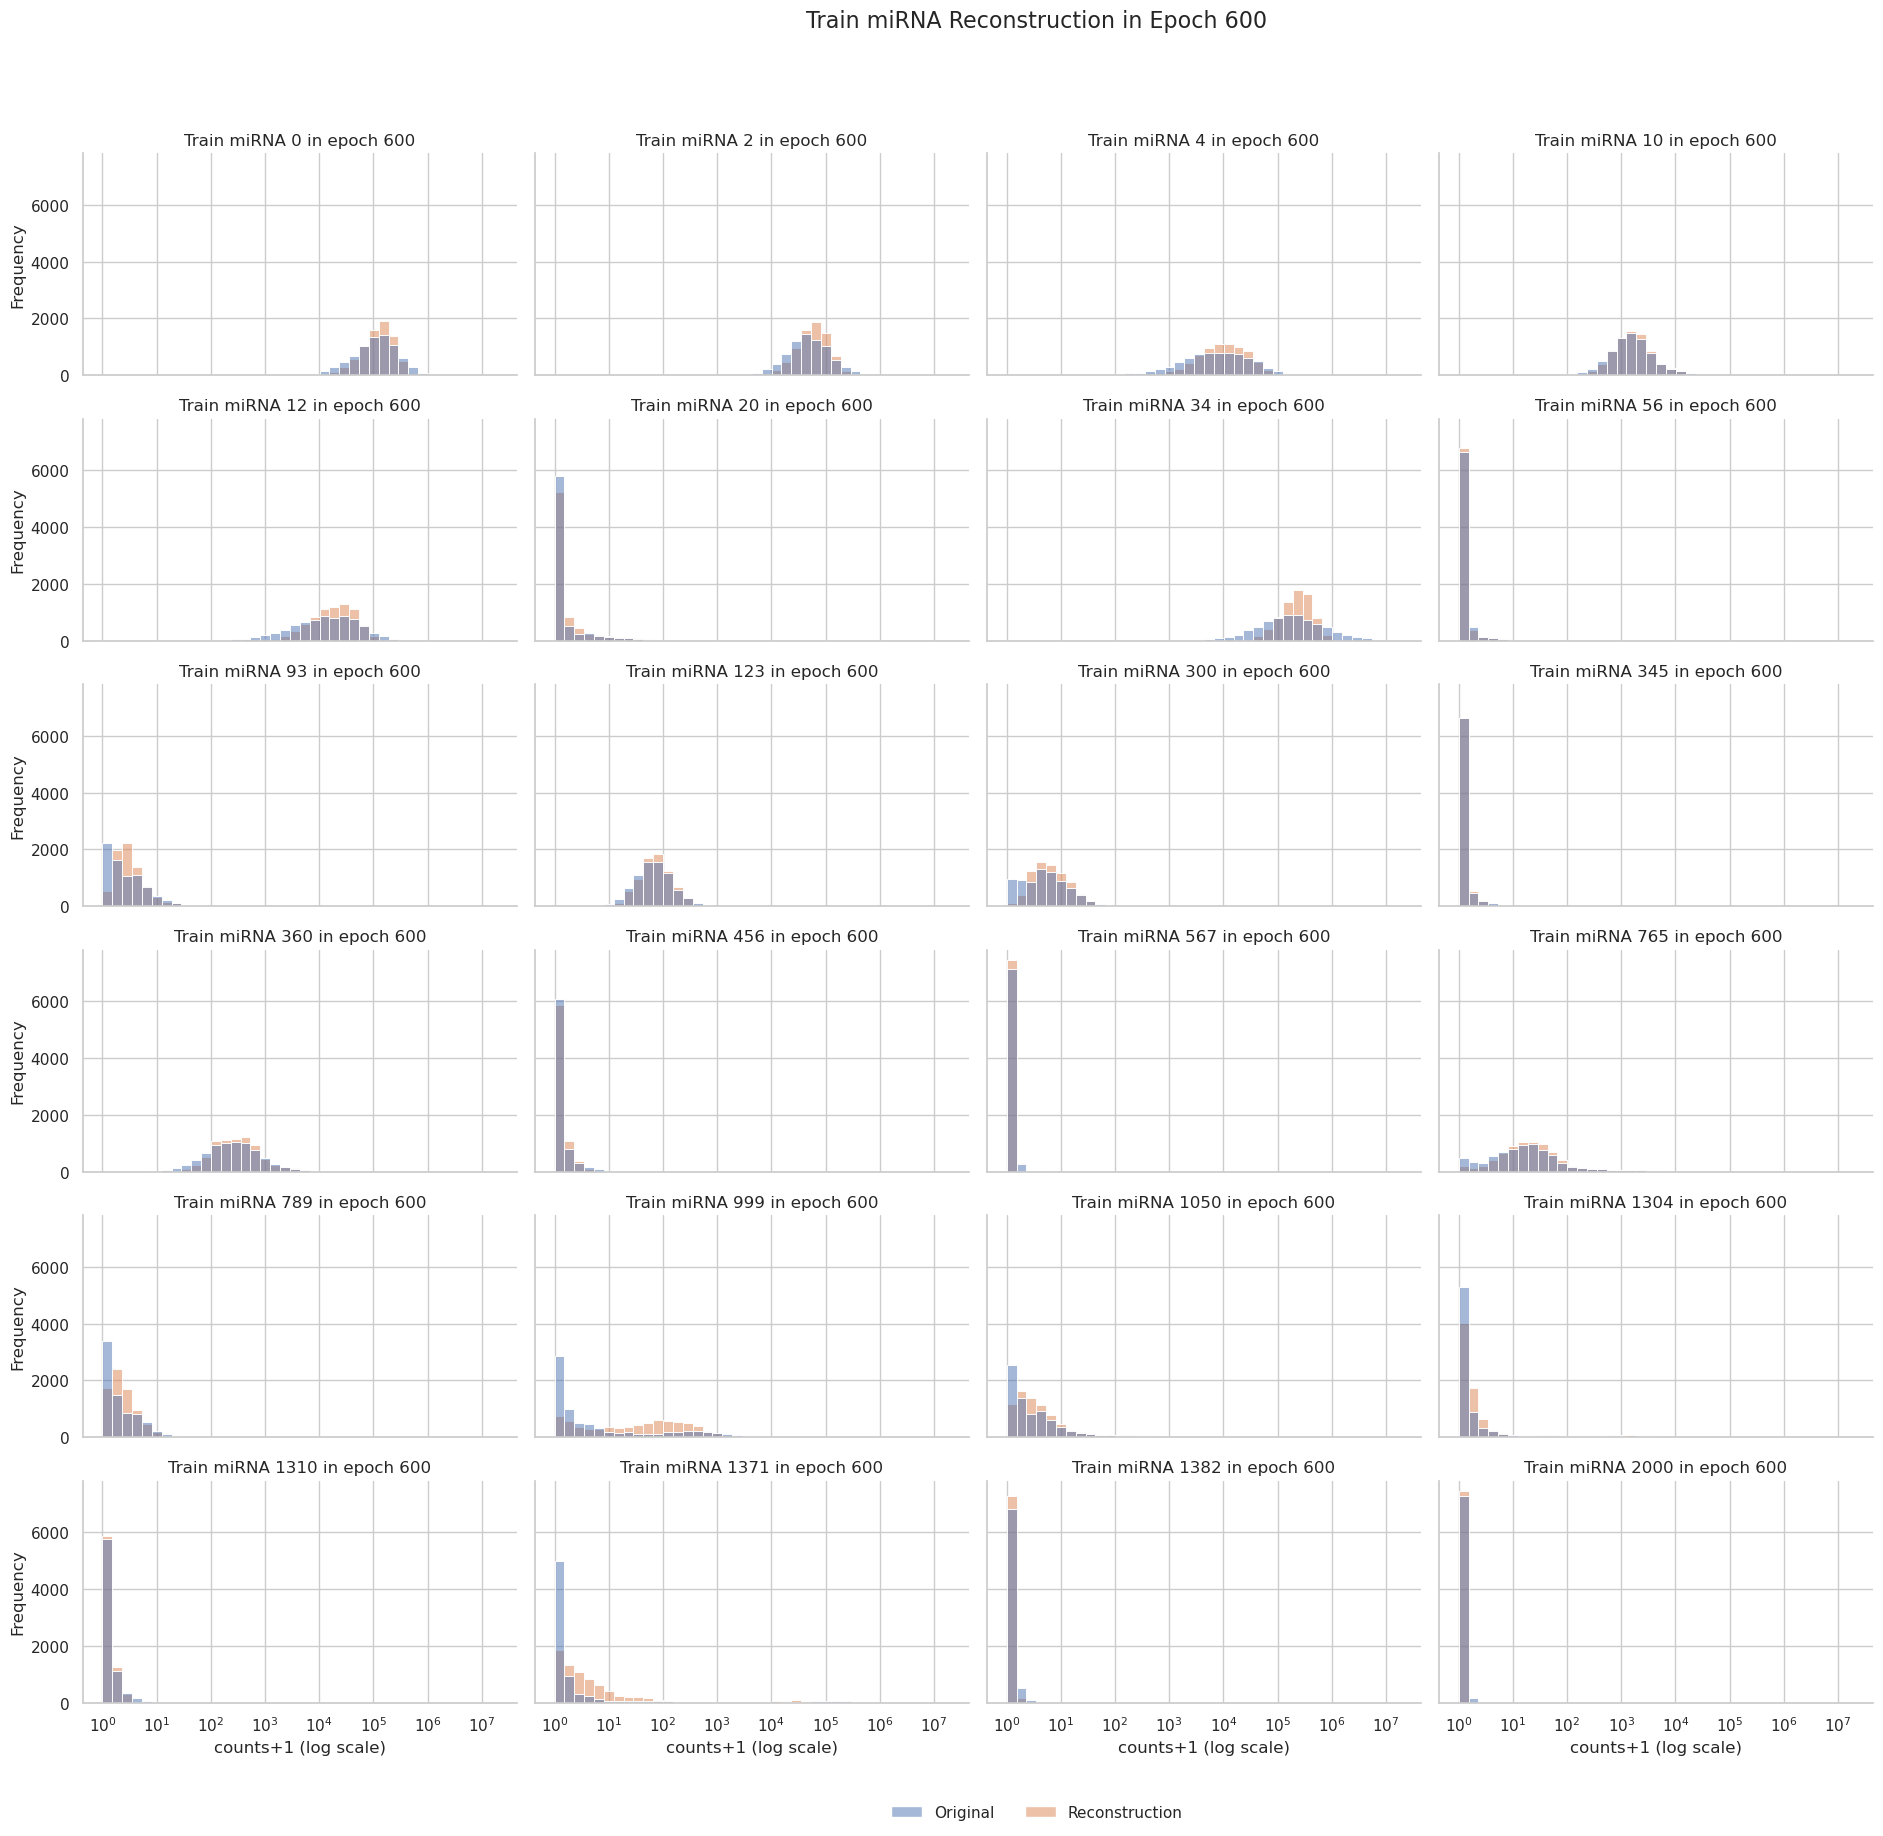

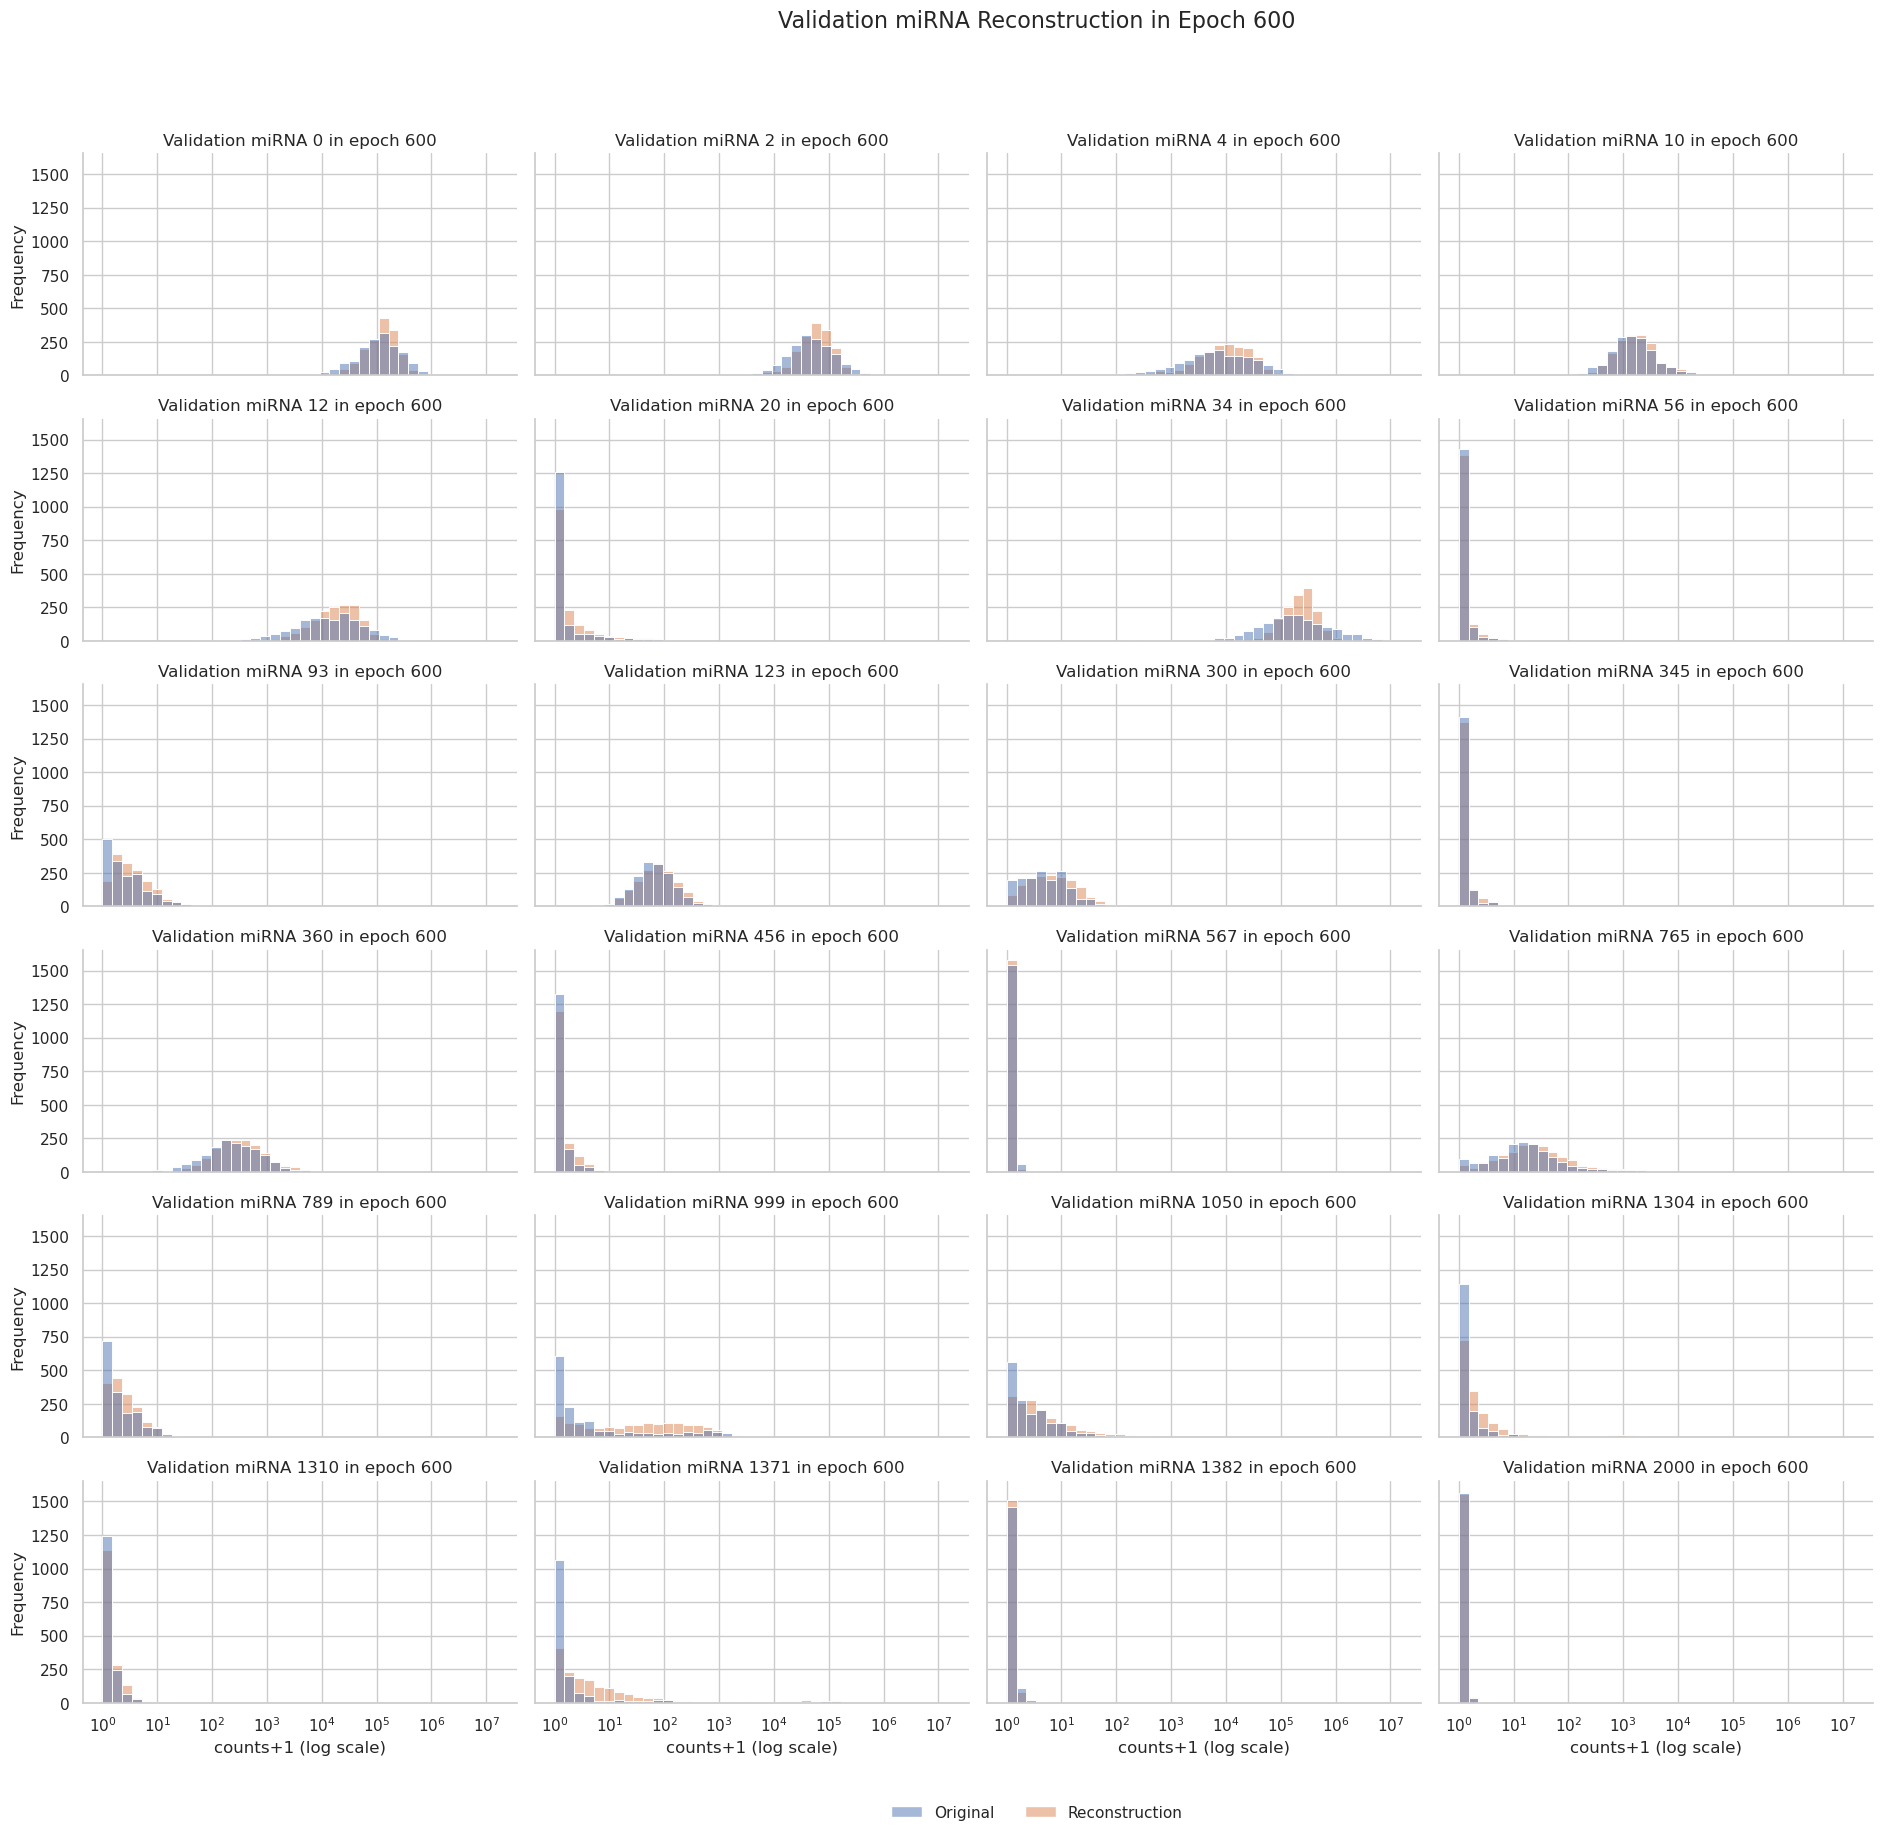

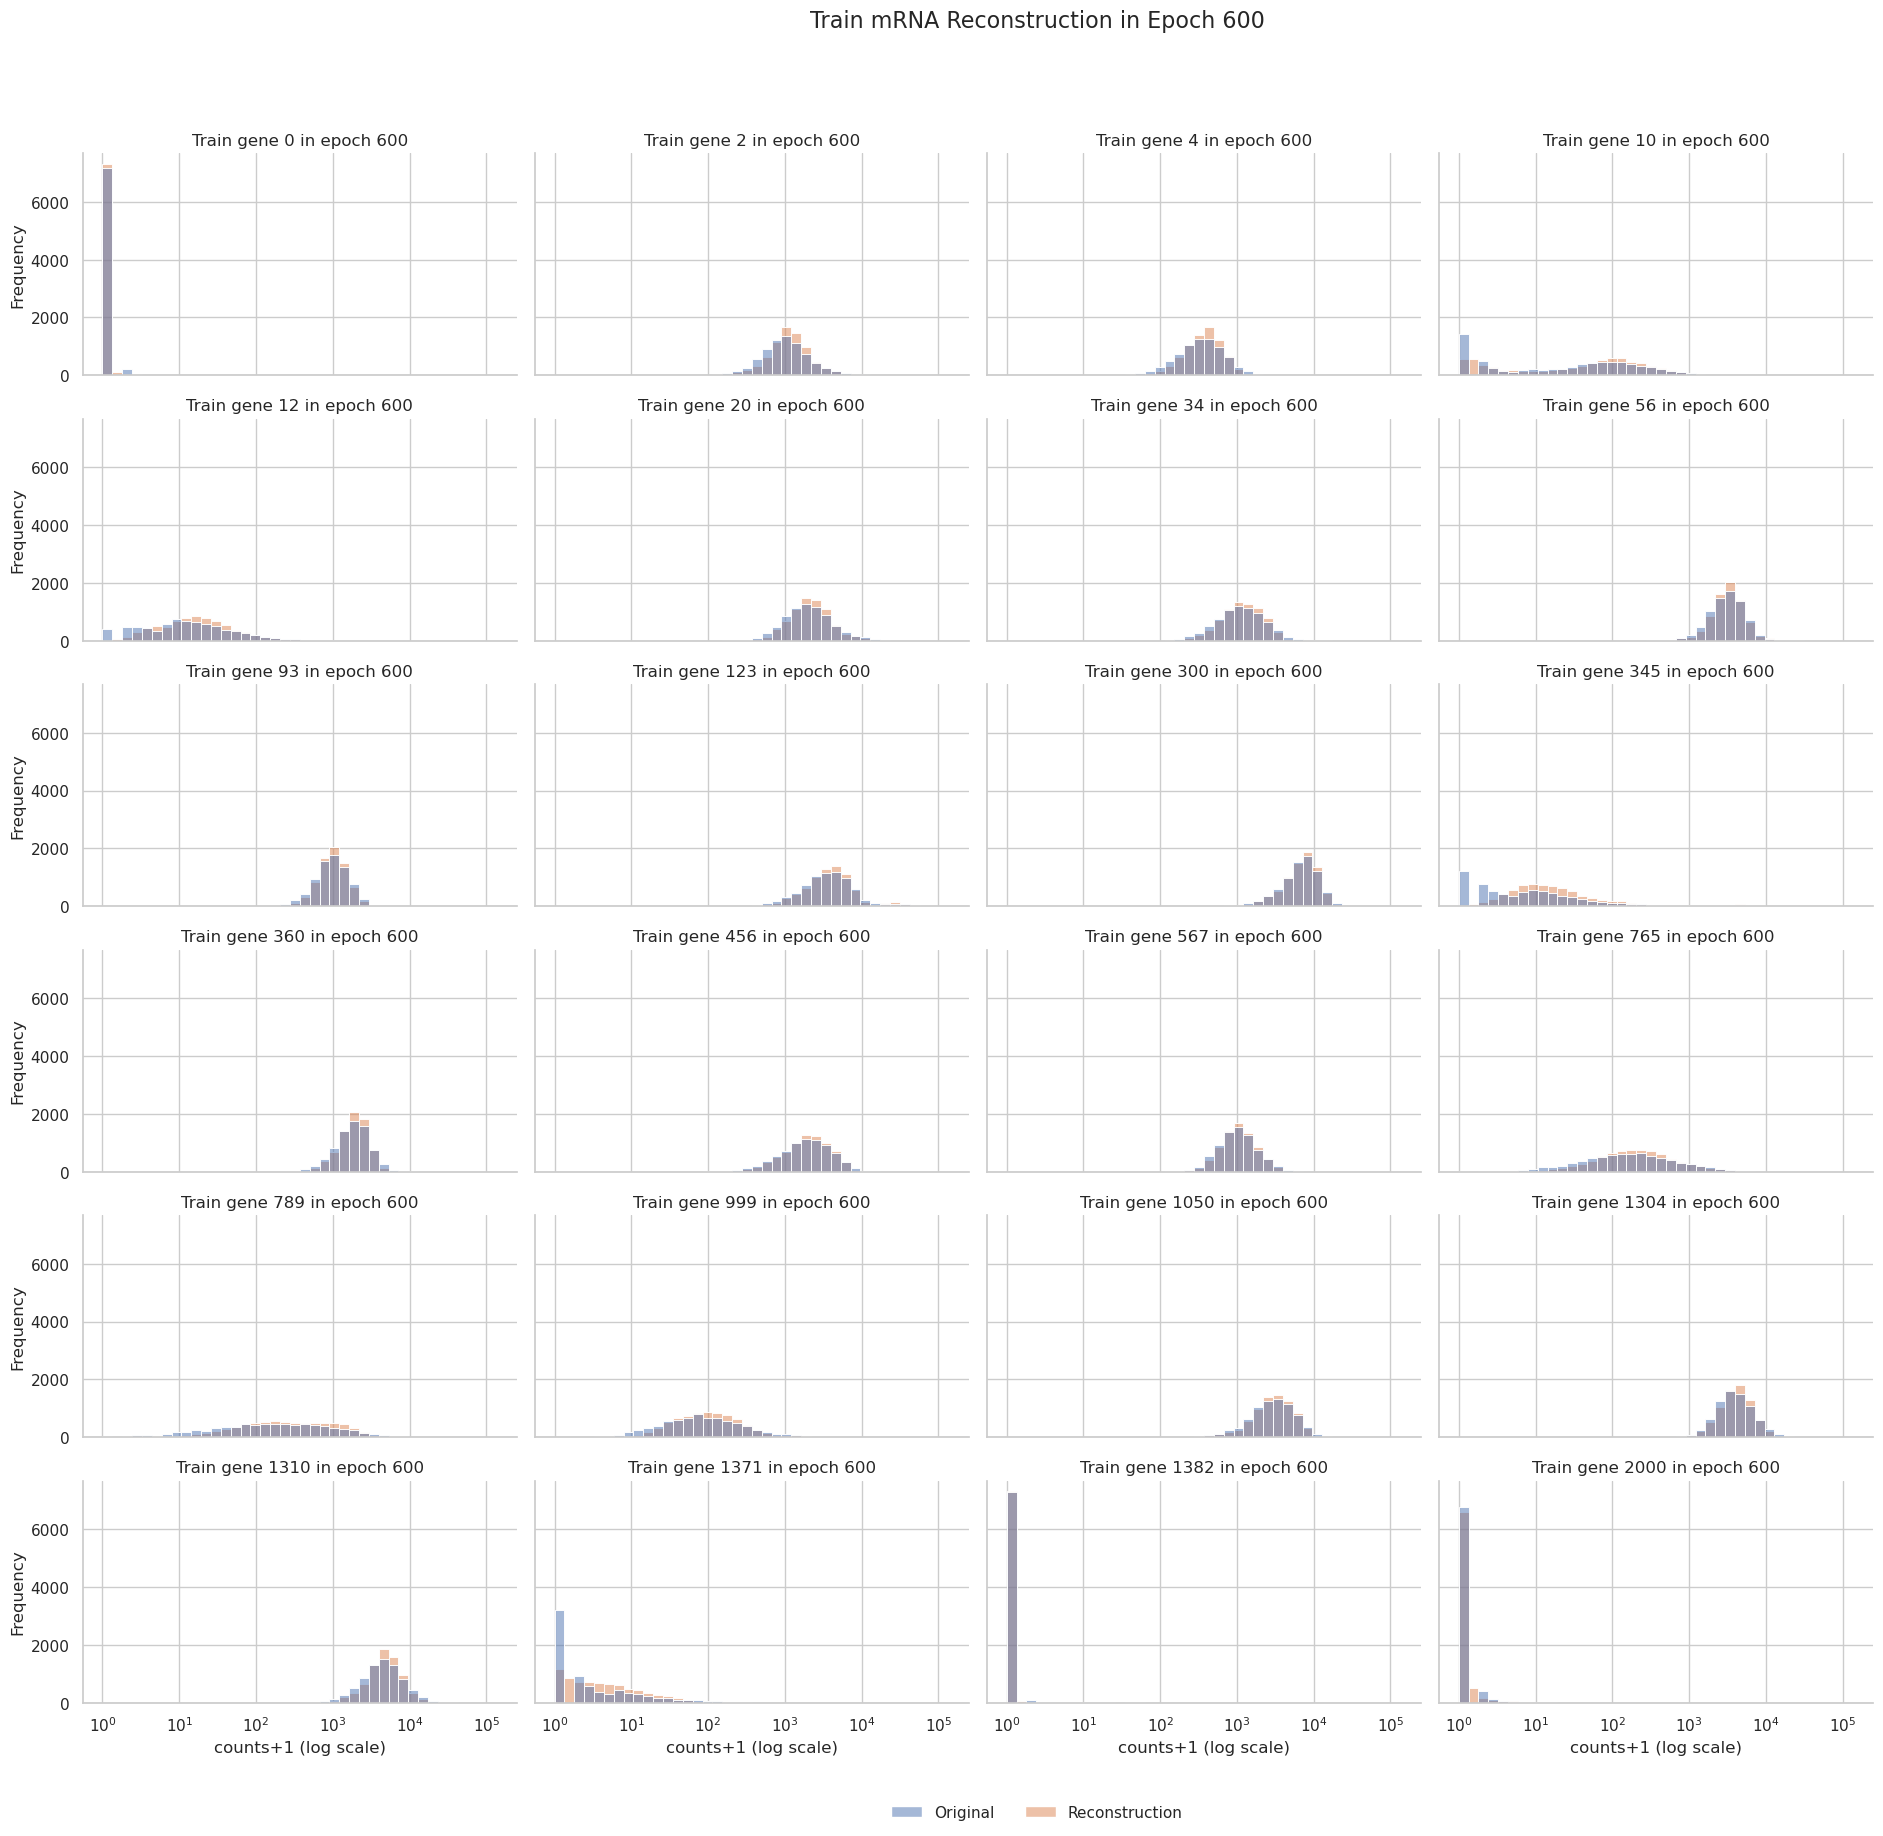

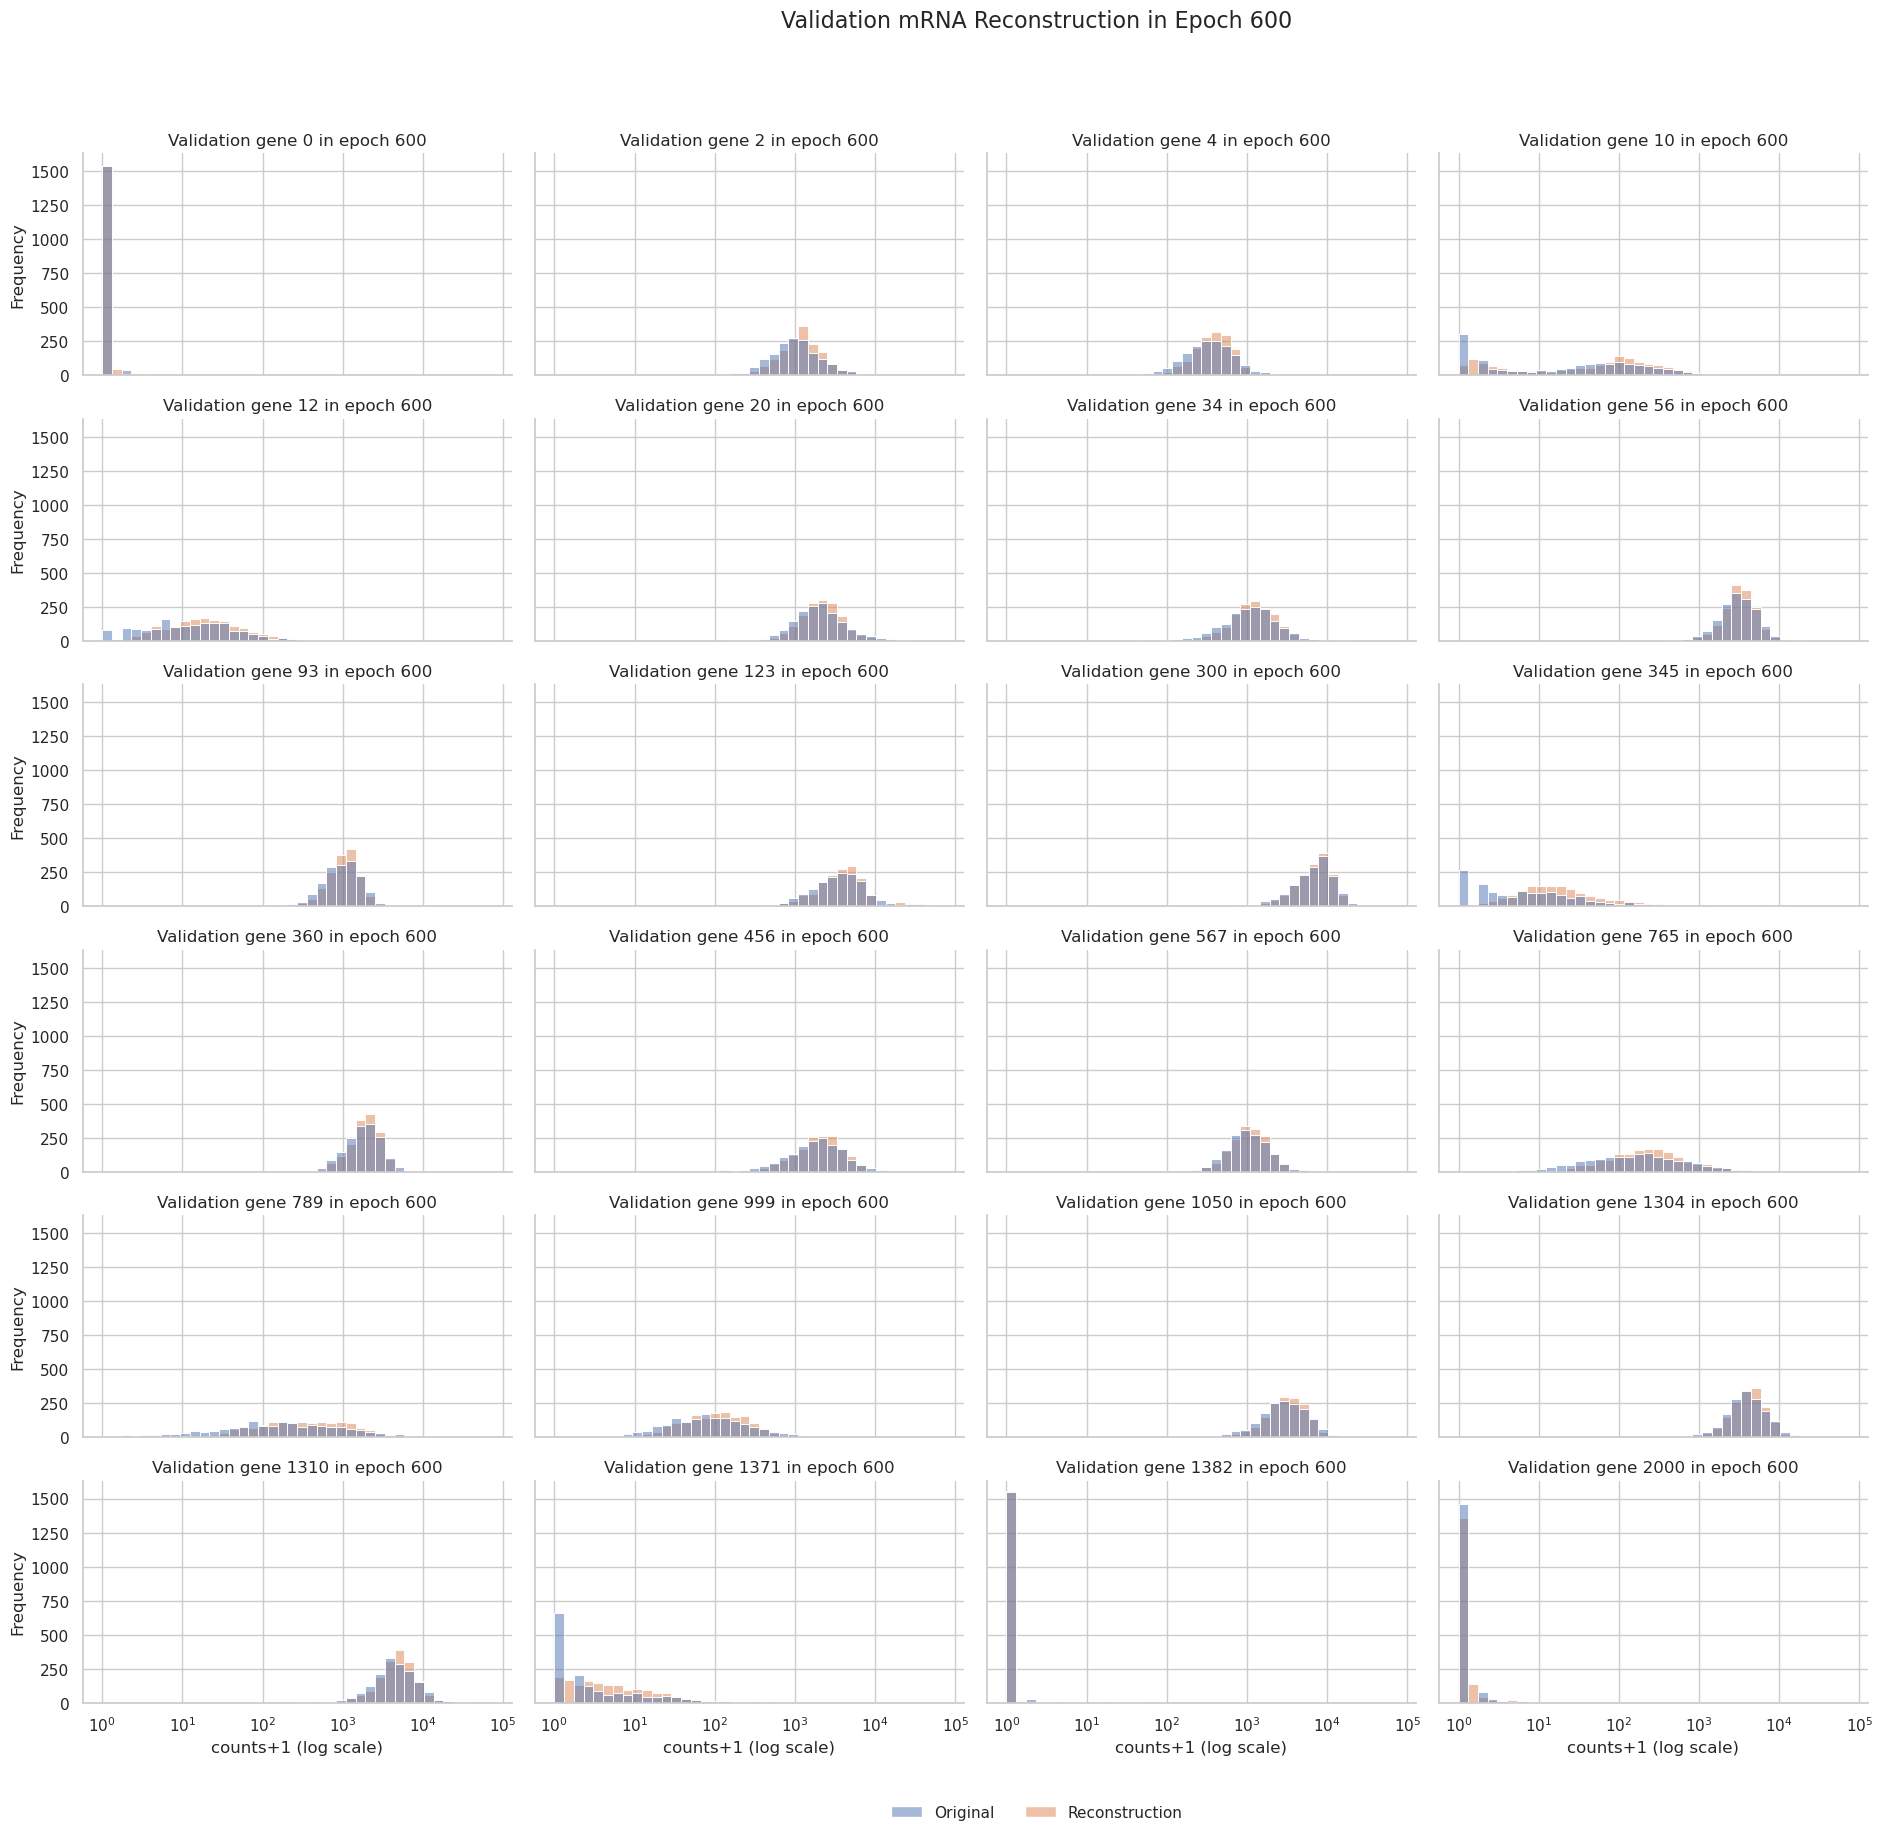

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 606/801 [51:42<34:05, 10.49s/it]

605 train_recon_mirna: 1.8494544932739416 train_recon_mrna: 6.309012775254886 train_gmm: 2.32257592828976 train_mse: 419873.21875 train_mae: 64.5615005493164 train_r2: 0.40322351455688477 train_spearman: 0.46993014216423035 train_pearson: 0.6955237984657288 train_msle: 0.6240460276603699
605 test_recon_mirna: 2.1681449904395227 test_recon_mrna: 6.371197735218234 test_gmm: 2.3205055251112587 test_mse: 284888.15625 test_mae: 70.26277923583984 test_r2: 0.5550894737243652 test_spearman: 0.3820574879646301 test_pearson: 0.8231825232505798 test_msle: 0.9934926629066467


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 611/801 [52:01<16:04,  5.07s/it]

610 train_recon_mirna: 1.8489646699627222 train_recon_mrna: 6.3082934641910615 train_gmm: 2.32321276027292 train_mse: 413888.59375 train_mae: 63.92478561401367 train_r2: 0.4117295742034912 train_spearman: 0.4712349772453308 train_pearson: 0.7074745297431946 train_msle: 0.6185157299041748
610 test_recon_mirna: 2.1788411794259024 test_recon_mrna: 6.364853364499374 test_gmm: 2.323123083168235 test_mse: 282777.21875 test_mae: 70.32862091064453 test_r2: 0.5583860874176025 test_spearman: 0.38044464588165283 test_pearson: 0.8262419104576111 test_msle: 1.010163426399231


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 616/801 [52:21<12:36,  4.09s/it]

615 train_recon_mirna: 1.8485702483568647 train_recon_mrna: 6.30779079172975 train_gmm: 2.323958681265577 train_mse: 417788.03125 train_mae: 64.74347686767578 train_r2: 0.40618717670440674 train_spearman: 0.47171103954315186 train_pearson: 0.6938278079032898 train_msle: 0.6197733879089355
615 test_recon_mirna: 2.175972341891061 test_recon_mrna: 6.367348496572146 test_gmm: 2.323370235521744 test_mse: 282080.9375 test_mae: 70.98997497558594 test_r2: 0.5594735145568848 test_spearman: 0.37965741753578186 test_pearson: 0.8219199776649475 test_msle: 0.9740452170372009


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 621/801 [52:41<11:51,  3.95s/it]

620 train_recon_mirna: 1.8481605657425362 train_recon_mrna: 6.3065856291402405 train_gmm: 2.324407365212682 train_mse: 419012.78125 train_mae: 63.90610122680664 train_r2: 0.40444642305374146 train_spearman: 0.4697813391685486 train_pearson: 0.6996375322341919 train_msle: 0.6063348054885864
620 test_recon_mirna: 2.177725758264968 test_recon_mrna: 6.370953789107986 test_gmm: 2.323787516225211 test_mse: 277926.125 test_mae: 69.66291046142578 test_r2: 0.5659620761871338 test_spearman: 0.38206666707992554 test_pearson: 0.8326394557952881 test_msle: 0.9655364155769348


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 626/801 [53:00<11:31,  3.95s/it]

625 train_recon_mirna: 1.8478807613039352 train_recon_mrna: 6.305820613801398 train_gmm: 2.3253863648718722 train_mse: 416967.5625 train_mae: 64.56261444091797 train_r2: 0.40735340118408203 train_spearman: 0.4697454273700714 train_pearson: 0.6938232183456421 train_msle: 0.6316976547241211
625 test_recon_mirna: 2.182084215676714 test_recon_mrna: 6.3849072534923765 test_gmm: 2.3253940942062576 test_mse: 268163.96875 test_mae: 70.34648132324219 test_r2: 0.5812076330184937 test_spearman: 0.38078781962394714 test_pearson: 0.8308033347129822 test_msle: 1.0259344577789307


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 631/801 [53:20<10:58,  3.87s/it]

630 train_recon_mirna: 1.8475798757443793 train_recon_mrna: 6.30527644653556 train_gmm: 2.326285362983825 train_mse: 414022.65625 train_mae: 64.05766296386719 train_r2: 0.41153907775878906 train_spearman: 0.46967920660972595 train_pearson: 0.701519250869751 train_msle: 0.623772382736206
630 test_recon_mirna: 2.1789862896799925 test_recon_mrna: 6.3690346356332626 test_gmm: 2.324885508568863 test_mse: 271387.28125 test_mae: 70.03475952148438 test_r2: 0.5761737823486328 test_spearman: 0.3783077001571655 test_pearson: 0.8351505994796753 test_msle: 0.9919249415397644


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 636/801 [53:39<10:46,  3.92s/it]

635 train_recon_mirna: 1.8471620672861035 train_recon_mrna: 6.304503171551317 train_gmm: 2.3268901966349693 train_mse: 418103.375 train_mae: 63.688350677490234 train_r2: 0.4057390093803406 train_spearman: 0.47092151641845703 train_pearson: 0.7051692008972168 train_msle: 0.6068404316902161
635 test_recon_mirna: 2.1925462242749716 test_recon_mrna: 6.366009213442753 test_gmm: 2.3268536693375235 test_mse: 284715.1875 test_mae: 70.08612060546875 test_r2: 0.5553596019744873 test_spearman: 0.38062813878059387 test_pearson: 0.8337944149971008 test_msle: 1.0060685873031616


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 641/801 [53:59<10:29,  3.94s/it]

640 train_recon_mirna: 1.8468621279855173 train_recon_mrna: 6.3036848803134 train_gmm: 2.3276560624759552 train_mse: 420703.28125 train_mae: 64.00630950927734 train_r2: 0.4020437002182007 train_spearman: 0.4711908996105194 train_pearson: 0.7006153464317322 train_msle: 0.6047969460487366
640 test_recon_mirna: 2.186913483389828 test_recon_mrna: 6.371249846663575 test_gmm: 2.3272989858023307 test_mse: 279698.90625 test_mae: 69.52096557617188 test_r2: 0.5631935000419617 test_spearman: 0.37948107719421387 test_pearson: 0.8351625800132751 test_msle: 0.993040144443512


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 646/801 [54:18<09:59,  3.87s/it]

645 train_recon_mirna: 1.846537877267253 train_recon_mrna: 6.303211297936811 train_gmm: 2.328339300126288 train_mse: 419078.9375 train_mae: 64.27914428710938 train_r2: 0.40435242652893066 train_spearman: 0.4745815396308899 train_pearson: 0.6994742155075073 train_msle: 0.6173357963562012
645 test_recon_mirna: 2.184750282679057 test_recon_mrna: 6.365576438488672 test_gmm: 2.328543470145612 test_mse: 279155.40625 test_mae: 70.1055908203125 test_r2: 0.5640422701835632 test_spearman: 0.3793301582336426 test_pearson: 0.8300596475601196 test_msle: 1.0321400165557861


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 651/801 [54:38<09:48,  3.93s/it]

650 train_recon_mirna: 1.8462048860499247 train_recon_mrna: 6.302705710705273 train_gmm: 2.328964859431453 train_mse: 413804.0 train_mae: 65.08174133300781 train_r2: 0.41184985637664795 train_spearman: 0.4742366671562195 train_pearson: 0.6917685866355896 train_msle: 0.6118271946907043
650 test_recon_mirna: 2.1852120085211073 test_recon_mrna: 6.368450193275877 test_gmm: 2.3297396677125626 test_mse: 278437.0 test_mae: 71.2726058959961 test_r2: 0.5651642680168152 test_spearman: 0.3814300000667572 test_pearson: 0.8196078538894653 test_msle: 0.9831328392028809


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 656/801 [54:58<09:33,  3.95s/it]

655 train_recon_mirna: 1.8457801015143318 train_recon_mrna: 6.301480497208013 train_gmm: 2.330120036950731 train_mse: 417596.34375 train_mae: 63.985443115234375 train_r2: 0.4064596891403198 train_spearman: 0.47376948595046997 train_pearson: 0.7028311491012573 train_msle: 0.606953501701355
655 test_recon_mirna: 2.179653225935865 test_recon_mrna: 6.362912584933034 test_gmm: 2.3293113999185078 test_mse: 277615.65625 test_mae: 69.976806640625 test_r2: 0.5664469003677368 test_spearman: 0.38104137778282166 test_pearson: 0.8305756449699402 test_msle: 1.0151149034500122


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 661/801 [55:17<09:01,  3.87s/it]

660 train_recon_mirna: 1.8454523364150468 train_recon_mrna: 6.300933296547577 train_gmm: 2.3309071315590293 train_mse: 418148.71875 train_mae: 63.92306137084961 train_r2: 0.4056745767593384 train_spearman: 0.47631651163101196 train_pearson: 0.705601155757904 train_msle: 0.6251097321510315
660 test_recon_mirna: 2.1800005280944714 test_recon_mrna: 6.369993587476244 test_gmm: 2.3306995017762335 test_mse: 278507.65625 test_mae: 69.49349212646484 test_r2: 0.5650538802146912 test_spearman: 0.38171321153640747 test_pearson: 0.8323642611503601 test_msle: 1.0074083805084229


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 666/801 [55:37<08:50,  3.93s/it]

665 train_recon_mirna: 1.8450865587706653 train_recon_mrna: 6.300343475845736 train_gmm: 2.331494042615917 train_mse: 419671.40625 train_mae: 64.25626373291016 train_r2: 0.40351033210754395 train_spearman: 0.47347375750541687 train_pearson: 0.6984916925430298 train_msle: 0.6193029284477234
665 test_recon_mirna: 2.1896230053536203 test_recon_mrna: 6.386066930902596 test_gmm: 2.3307037410700344 test_mse: 283535.96875 test_mae: 70.11518859863281 test_r2: 0.5572011470794678 test_spearman: 0.37751805782318115 test_pearson: 0.8221246600151062 test_msle: 1.0350714921951294


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 671/801 [55:57<08:34,  3.95s/it]

670 train_recon_mirna: 1.844833968574748 train_recon_mrna: 6.299735922495256 train_gmm: 2.3322354241545606 train_mse: 418377.28125 train_mae: 64.61058807373047 train_r2: 0.4053496718406677 train_spearman: 0.47356903553009033 train_pearson: 0.695349931716919 train_msle: 0.6234683990478516
670 test_recon_mirna: 2.1845773404190316 test_recon_mrna: 6.364605526641842 test_gmm: 2.3320386077671182 test_mse: 279321.34375 test_mae: 69.82091522216797 test_r2: 0.5637831687927246 test_spearman: 0.3786844313144684 test_pearson: 0.8270242214202881 test_msle: 1.0335323810577393


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 676/801 [56:16<08:07,  3.90s/it]

675 train_recon_mirna: 1.8443291507777801 train_recon_mrna: 6.299042729128376 train_gmm: 2.332867688914467 train_mse: 419964.6875 train_mae: 63.80154800415039 train_r2: 0.40309351682662964 train_spearman: 0.4713442921638489 train_pearson: 0.7016178369522095 train_msle: 0.5995455980300903
675 test_recon_mirna: 2.200937111161996 test_recon_mrna: 6.392122948459882 test_gmm: 2.333506737732277 test_mse: 287204.1875 test_mae: 69.62723541259766 test_r2: 0.5514724850654602 test_spearman: 0.3785816431045532 test_pearson: 0.8286280632019043 test_msle: 0.9914671778678894


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 681/801 [56:36<07:52,  3.94s/it]

680 train_recon_mirna: 1.8441465548206746 train_recon_mrna: 6.2981889251434335 train_gmm: 2.3335628379353173 train_mse: 417541.9375 train_mae: 64.791259765625 train_r2: 0.4065369963645935 train_spearman: 0.4720040261745453 train_pearson: 0.6936416625976562 train_msle: 0.620692789554596
680 test_recon_mirna: 2.193767312549222 test_recon_mrna: 6.367867601871469 test_gmm: 2.3341254916360867 test_mse: 280535.40625 test_mae: 70.73563385009766 test_r2: 0.5618871450424194 test_spearman: 0.38041865825653076 test_pearson: 0.8178972005844116 test_msle: 1.019327998161316


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 686/801 [56:56<07:34,  3.95s/it]

685 train_recon_mirna: 1.8437585276940993 train_recon_mrna: 6.2977383016662865 train_gmm: 2.334571944351227 train_mse: 422356.125 train_mae: 63.92865753173828 train_r2: 0.39969444274902344 train_spearman: 0.4771684408187866 train_pearson: 0.6990906000137329 train_msle: 0.6081363558769226
685 test_recon_mirna: 2.200861561635144 test_recon_mrna: 6.366333114393545 test_gmm: 2.3344547231222674 test_mse: 287268.71875 test_mae: 69.55677032470703 test_r2: 0.5513717532157898 test_spearman: 0.37903231382369995 test_pearson: 0.825363039970398 test_msle: 0.9956755042076111


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 691/801 [57:15<07:07,  3.89s/it]

690 train_recon_mirna: 1.843473388668905 train_recon_mrna: 6.296891811721054 train_gmm: 2.3353063443762125 train_mse: 417079.375 train_mae: 63.867149353027344 train_r2: 0.40719443559646606 train_spearman: 0.4739728271961212 train_pearson: 0.7011193037033081 train_msle: 0.6089922785758972
690 test_recon_mirna: 2.1996584686911342 test_recon_mrna: 6.371311988059233 test_gmm: 2.3343193478319213 test_mse: 278362.75 test_mae: 69.53251647949219 test_r2: 0.5652801990509033 test_spearman: 0.3778846561908722 test_pearson: 0.8331034779548645 test_msle: 1.0414677858352661


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 696/801 [57:35<06:53,  3.94s/it]

695 train_recon_mirna: 1.8431742262097437 train_recon_mrna: 6.296603401985594 train_gmm: 2.3358481091826406 train_mse: 413291.21875 train_mae: 63.94891357421875 train_r2: 0.4125787019729614 train_spearman: 0.47334128618240356 train_pearson: 0.7056357860565186 train_msle: 0.6195966601371765
695 test_recon_mirna: 2.19302054491943 test_recon_mrna: 6.365397101711385 test_gmm: 2.335175738552077 test_mse: 280093.5 test_mae: 69.68721008300781 test_r2: 0.5625772476196289 test_spearman: 0.38004961609840393 test_pearson: 0.8306894302368164 test_msle: 1.0404213666915894


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 701/801 [57:54<06:31,  3.92s/it]

700 train_recon_mirna: 1.8427784606268998 train_recon_mrna: 6.295955099469483 train_gmm: 2.3365684922753163 train_mse: 421387.21875 train_mae: 63.57618713378906 train_r2: 0.40107160806655884 train_spearman: 0.4755467176437378 train_pearson: 0.7049984335899353 train_msle: 0.5810674428939819
700 test_recon_mirna: 2.210988602494612 test_recon_mrna: 6.368339958743049 test_gmm: 2.338883351713773 test_mse: 288997.1875 test_mae: 69.78882598876953 test_r2: 0.5486723780632019 test_spearman: 0.38192710280418396 test_pearson: 0.8253830075263977 test_msle: 0.9556089043617249


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 706/801 [58:14<06:10,  3.90s/it]

705 train_recon_mirna: 1.8425417698543478 train_recon_mrna: 6.295577131724154 train_gmm: 2.3373521304299647 train_mse: 415600.0625 train_mae: 63.948219299316406 train_r2: 0.40929704904556274 train_spearman: 0.4755212068557739 train_pearson: 0.7047260999679565 train_msle: 0.6122301816940308
705 test_recon_mirna: 2.1917070304688524 test_recon_mrna: 6.365580963040393 test_gmm: 2.3382795725815897 test_mse: 282177.625 test_mae: 69.33091735839844 test_r2: 0.5593224763870239 test_spearman: 0.3787427544593811 test_pearson: 0.8339060544967651 test_msle: 1.0271315574645996


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 711/801 [58:34<05:57,  3.97s/it]

710 train_recon_mirna: 1.8421969390365263 train_recon_mrna: 6.294837718913564 train_gmm: 2.338193020590271 train_mse: 413538.75 train_mae: 64.48726654052734 train_r2: 0.4122268557548523 train_spearman: 0.4742961525917053 train_pearson: 0.6996873617172241 train_msle: 0.6245737075805664
710 test_recon_mirna: 2.1930728818204037 test_recon_mrna: 6.361895699843896 test_gmm: 2.338605060374863 test_mse: 283813.5625 test_mae: 70.3359375 test_r2: 0.5567677021026611 test_spearman: 0.38033512234687805 test_pearson: 0.8181737661361694 test_msle: 1.0410792827606201


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 716/801 [58:53<05:32,  3.91s/it]

715 train_recon_mirna: 1.841915226584479 train_recon_mrna: 6.294045497922843 train_gmm: 2.3388468538823095 train_mse: 421439.90625 train_mae: 63.601009368896484 train_r2: 0.40099674463272095 train_spearman: 0.4751976728439331 train_pearson: 0.7015085816383362 train_msle: 0.5782202482223511
715 test_recon_mirna: 2.203749194935601 test_recon_mrna: 6.363442400447443 test_gmm: 2.338239101050125 test_mse: 294346.5 test_mae: 69.47898864746094 test_r2: 0.5403183698654175 test_spearman: 0.38241347670555115 test_pearson: 0.8238998651504517 test_msle: 0.9949979782104492


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 721/801 [59:13<05:12,  3.91s/it]

720 train_recon_mirna: 1.841722794079437 train_recon_mrna: 6.293780104704376 train_gmm: 2.3397640702492515 train_mse: 424132.15625 train_mae: 63.066925048828125 train_r2: 0.39717012643814087 train_spearman: 0.47319087386131287 train_pearson: 0.7081329822540283 train_msle: 0.5792136788368225
720 test_recon_mirna: 2.204755236120335 test_recon_mrna: 6.360478312826936 test_gmm: 2.341124390334654 test_mse: 301348.0625 test_mae: 69.74375915527344 test_r2: 0.5293839573860168 test_spearman: 0.3769107758998871 test_pearson: 0.8264873027801514 test_msle: 1.002678632736206


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 726/801 [59:33<04:57,  3.97s/it]

725 train_recon_mirna: 1.8413354942086637 train_recon_mrna: 6.2930569536002405 train_gmm: 2.3405714217014584 train_mse: 418246.625 train_mae: 64.58719635009766 train_r2: 0.40553539991378784 train_spearman: 0.47350579500198364 train_pearson: 0.6953263282775879 train_msle: 0.5967350602149963
725 test_recon_mirna: 2.2074659153400913 test_recon_mrna: 6.361781004039792 test_gmm: 2.341101234335962 test_mse: 289498.28125 test_mae: 70.30406188964844 test_r2: 0.5478898286819458 test_spearman: 0.3762912154197693 test_pearson: 0.8191278576850891 test_msle: 1.0463016033172607


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 731/801 [59:52<04:34,  3.92s/it]

730 train_recon_mirna: 1.8409943430572724 train_recon_mrna: 6.292257747328778 train_gmm: 2.3413639427459687 train_mse: 415194.65625 train_mae: 63.388031005859375 train_r2: 0.40987324714660645 train_spearman: 0.47595736384391785 train_pearson: 0.7090739607810974 train_msle: 0.5969613790512085
730 test_recon_mirna: 2.207630824314966 test_recon_mrna: 6.362909689852737 test_gmm: 2.3410449035758902 test_mse: 295747.75 test_mae: 69.78803253173828 test_r2: 0.538129985332489 test_spearman: 0.3781331777572632 test_pearson: 0.8177871704101562 test_msle: 1.0246224403381348


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 736/801 [1:00:12<04:15,  3.93s/it]

735 train_recon_mirna: 1.840746067843578 train_recon_mrna: 6.292162451288682 train_gmm: 2.342067899516384 train_mse: 418861.1875 train_mae: 63.115623474121094 train_r2: 0.4046618938446045 train_spearman: 0.47695955634117126 train_pearson: 0.7104862928390503 train_msle: 0.6016014814376831
735 test_recon_mirna: 2.2011656885024924 test_recon_mrna: 6.372076004495569 test_gmm: 2.3411669281406153 test_mse: 299051.3125 test_mae: 69.56139373779297 test_r2: 0.5329707860946655 test_spearman: 0.3817642629146576 test_pearson: 0.8245421051979065 test_msle: 1.0255098342895508


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 741/801 [1:00:32<03:59,  3.99s/it]

740 train_recon_mirna: 1.8404527420254417 train_recon_mrna: 6.291504672380063 train_gmm: 2.3428161171885455 train_mse: 413462.40625 train_mae: 64.43710327148438 train_r2: 0.4123353362083435 train_spearman: 0.4755457937717438 train_pearson: 0.6987886428833008 train_msle: 0.595892608165741
740 test_recon_mirna: 2.213015729191612 test_recon_mrna: 6.359273310798956 test_gmm: 2.342681575968145 test_mse: 288202.875 test_mae: 70.16844940185547 test_r2: 0.5499128103256226 test_spearman: 0.37354087829589844 test_pearson: 0.8075180053710938 test_msle: 1.0565646886825562


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 746/801 [1:00:51<03:36,  3.94s/it]

745 train_recon_mirna: 1.8401479061445976 train_recon_mrna: 6.290682612276457 train_gmm: 2.343463909854121 train_mse: 417994.65625 train_mae: 63.11166763305664 train_r2: 0.40589356422424316 train_spearman: 0.47798678278923035 train_pearson: 0.7089589238166809 train_msle: 0.5813006162643433
745 test_recon_mirna: 2.222993551538317 test_recon_mrna: 6.355345493661973 test_gmm: 2.344268307039546 test_mse: 295425.0 test_mae: 69.21981811523438 test_r2: 0.5386340618133545 test_spearman: 0.3747389614582062 test_pearson: 0.8232182860374451 test_msle: 1.0477468967437744


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 751/801 [1:01:11<03:17,  3.95s/it]

750 train_recon_mirna: 1.8399572370282689 train_recon_mrna: 6.29043109471998 train_gmm: 2.3441791000988976 train_mse: 417861.3125 train_mae: 63.66370391845703 train_r2: 0.40608304738998413 train_spearman: 0.4741758108139038 train_pearson: 0.7057148814201355 train_msle: 0.6080065965652466
750 test_recon_mirna: 2.216358916302311 test_recon_mrna: 6.355408283682179 test_gmm: 2.3453247756529123 test_mse: 295495.125 test_mae: 69.6812973022461 test_r2: 0.5385245084762573 test_spearman: 0.377448171377182 test_pearson: 0.818007230758667 test_msle: 1.0437300205230713


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 756/801 [1:01:31<02:58,  3.96s/it]

755 train_recon_mirna: 1.839668426600915 train_recon_mrna: 6.29017259188276 train_gmm: 2.3448886041833936 train_mse: 418808.9375 train_mae: 63.6229248046875 train_r2: 0.4047362208366394 train_spearman: 0.47419241070747375 train_pearson: 0.7047369480133057 train_msle: 0.5868368744850159
755 test_recon_mirna: 2.226161597602659 test_recon_mrna: 6.357267130894111 test_gmm: 2.3457421707258157 test_mse: 296123.1875 test_mae: 69.2105941772461 test_r2: 0.5375436544418335 test_spearman: 0.37693077325820923 test_pearson: 0.819510281085968 test_msle: 1.0502631664276123


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 761/801 [1:01:50<02:38,  3.95s/it]

760 train_recon_mirna: 1.8393018969079198 train_recon_mrna: 6.2894517251450575 train_gmm: 2.345714726008422 train_mse: 415489.0625 train_mae: 63.38212203979492 train_r2: 0.4094547629356384 train_spearman: 0.4774482548236847 train_pearson: 0.7140239477157593 train_msle: 0.622820258140564
760 test_recon_mirna: 2.207489465498959 test_recon_mrna: 6.358808943083385 test_gmm: 2.3458217642293877 test_mse: 300365.0 test_mae: 70.58409881591797 test_r2: 0.5309191942214966 test_spearman: 0.3759225606918335 test_pearson: 0.8176929950714111 test_msle: 1.0912667512893677


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 766/801 [1:02:10<02:19,  3.97s/it]

765 train_recon_mirna: 1.8391032548366477 train_recon_mrna: 6.289150927636132 train_gmm: 2.3463555665630644 train_mse: 423296.59375 train_mae: 63.32017517089844 train_r2: 0.3983577489852905 train_spearman: 0.4743332266807556 train_pearson: 0.7090525031089783 train_msle: 0.5879880785942078
765 test_recon_mirna: 2.226432212266049 test_recon_mrna: 6.368036544835887 test_gmm: 2.348049482623165 test_mse: 316003.3125 test_mae: 69.90753936767578 test_r2: 0.5064968466758728 test_spearman: 0.3793520927429199 test_pearson: 0.804364025592804 test_msle: 1.0121276378631592


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 771/801 [1:02:30<02:00,  4.01s/it]

770 train_recon_mirna: 1.838946807031334 train_recon_mrna: 6.28812439301181 train_gmm: 2.3472241524566564 train_mse: 422247.09375 train_mae: 63.010215759277344 train_r2: 0.39984941482543945 train_spearman: 0.47413212060928345 train_pearson: 0.7121959924697876 train_msle: 0.5825424194335938
770 test_recon_mirna: 2.2323837000188864 test_recon_mrna: 6.358365948337656 test_gmm: 2.346569084629724 test_mse: 311533.84375 test_mae: 69.80912017822266 test_r2: 0.5134768486022949 test_spearman: 0.37372520565986633 test_pearson: 0.8052653670310974 test_msle: 1.028450608253479


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 776/801 [1:02:50<01:39,  3.98s/it]

775 train_recon_mirna: 1.8385288487831557 train_recon_mrna: 6.287283298780766 train_gmm: 2.3478216174582665 train_mse: 416797.84375 train_mae: 63.82227325439453 train_r2: 0.40759456157684326 train_spearman: 0.47545722126960754 train_pearson: 0.706524133682251 train_msle: 0.5885325074195862
775 test_recon_mirna: 2.224422328682913 test_recon_mrna: 6.355509564032231 test_gmm: 2.3486912629069723 test_mse: 309151.875 test_mae: 70.0728759765625 test_r2: 0.517196774482727 test_spearman: 0.37390515208244324 test_pearson: 0.7986357808113098 test_msle: 1.0314007997512817


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 781/801 [1:03:11<01:22,  4.12s/it]

780 train_recon_mirna: 1.83824872307104 train_recon_mrna: 6.287231676844333 train_gmm: 2.348628406991733 train_mse: 419978.625 train_mae: 63.252838134765625 train_r2: 0.40307366847991943 train_spearman: 0.4754408299922943 train_pearson: 0.7088049650192261 train_msle: 0.595518171787262
780 test_recon_mirna: 2.227982173397679 test_recon_mrna: 6.355405594263324 test_gmm: 2.3504164419942613 test_mse: 311687.9375 test_mae: 69.37542724609375 test_r2: 0.5132361650466919 test_spearman: 0.37558692693710327 test_pearson: 0.8058279156684875 test_msle: 1.0599465370178223


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 786/801 [1:03:31<01:00,  4.02s/it]

785 train_recon_mirna: 1.8379998962172914 train_recon_mrna: 6.286532176050251 train_gmm: 2.349214710392308 train_mse: 417577.1875 train_mae: 63.53718185424805 train_r2: 0.4064868688583374 train_spearman: 0.4772084355354309 train_pearson: 0.7106816172599792 train_msle: 0.6061649918556213
785 test_recon_mirna: 2.228704117887042 test_recon_mrna: 6.355641029153902 test_gmm: 2.3507465884359386 test_mse: 312083.0 test_mae: 70.4899673461914 test_r2: 0.5126191973686218 test_spearman: 0.37314459681510925 test_pearson: 0.8074226379394531 test_msle: 1.0442068576812744


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 791/801 [1:03:50<00:39,  3.95s/it]

790 train_recon_mirna: 1.8377103802278454 train_recon_mrna: 6.286267714880403 train_gmm: 2.3499570997910184 train_mse: 421608.1875 train_mae: 62.61552810668945 train_r2: 0.4007575511932373 train_spearman: 0.4770086705684662 train_pearson: 0.7132173180580139 train_msle: 0.5786184072494507
790 test_recon_mirna: 2.233832160158671 test_recon_mrna: 6.3572420876585385 test_gmm: 2.351105479729466 test_mse: 313701.03125 test_mae: 69.10400390625 test_r2: 0.5100923180580139 test_spearman: 0.37163645029067993 test_pearson: 0.8065359592437744 test_msle: 1.0245109796524048


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 796/801 [1:04:10<00:19,  3.97s/it]

795 train_recon_mirna: 1.8374561464751367 train_recon_mrna: 6.285989872881651 train_gmm: 2.3509522301117354 train_mse: 414662.84375 train_mae: 62.616641998291016 train_r2: 0.41062915325164795 train_spearman: 0.47722357511520386 train_pearson: 0.716058611869812 train_msle: 0.5969014167785645
795 test_recon_mirna: 2.2237841888129455 test_recon_mrna: 6.361970877010946 test_gmm: 2.3517259872979777 test_mse: 305046.25 test_mae: 70.0451431274414 test_r2: 0.5236085653305054 test_spearman: 0.3710938096046448 test_pearson: 0.810862123966217 test_msle: 1.0351204872131348


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 800/801 [1:04:26<00:03,  3.99s/it]

800 train_recon_mirna: 1.8372206467905672 train_recon_mrna: 6.2854025941305895 train_gmm: 2.351689516504207 train_mse: 412978.4375 train_mae: 62.66952896118164 train_r2: 0.4130232334136963 train_spearman: 0.47780776023864746 train_pearson: 0.7186461687088013 train_msle: 0.5988357067108154
800 test_recon_mirna: 2.223183852637803 test_recon_mrna: 6.353974111527542 test_gmm: 2.3551768791965957 test_mse: 306589.96875 test_mae: 69.56336975097656 test_r2: 0.5211976766586304 test_spearman: 0.3739047646522522 test_pearson: 0.8151203393936157 test_msle: 1.0310766696929932


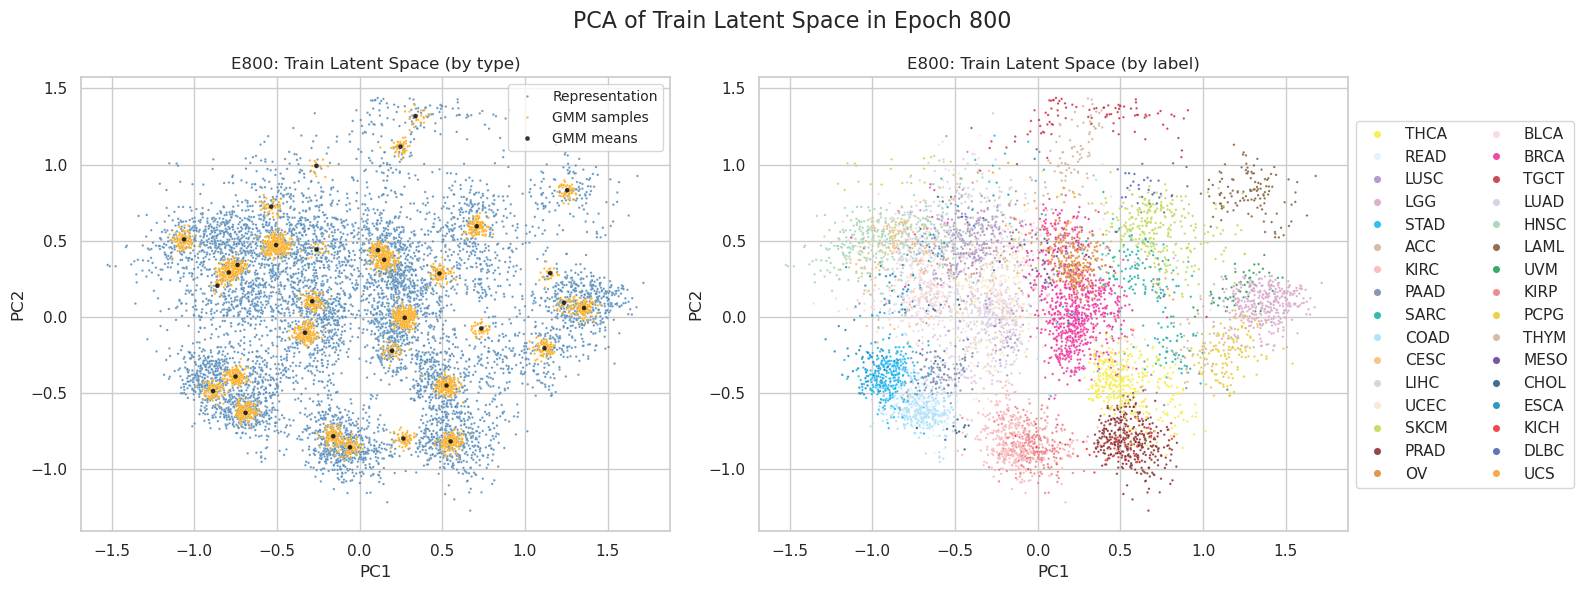

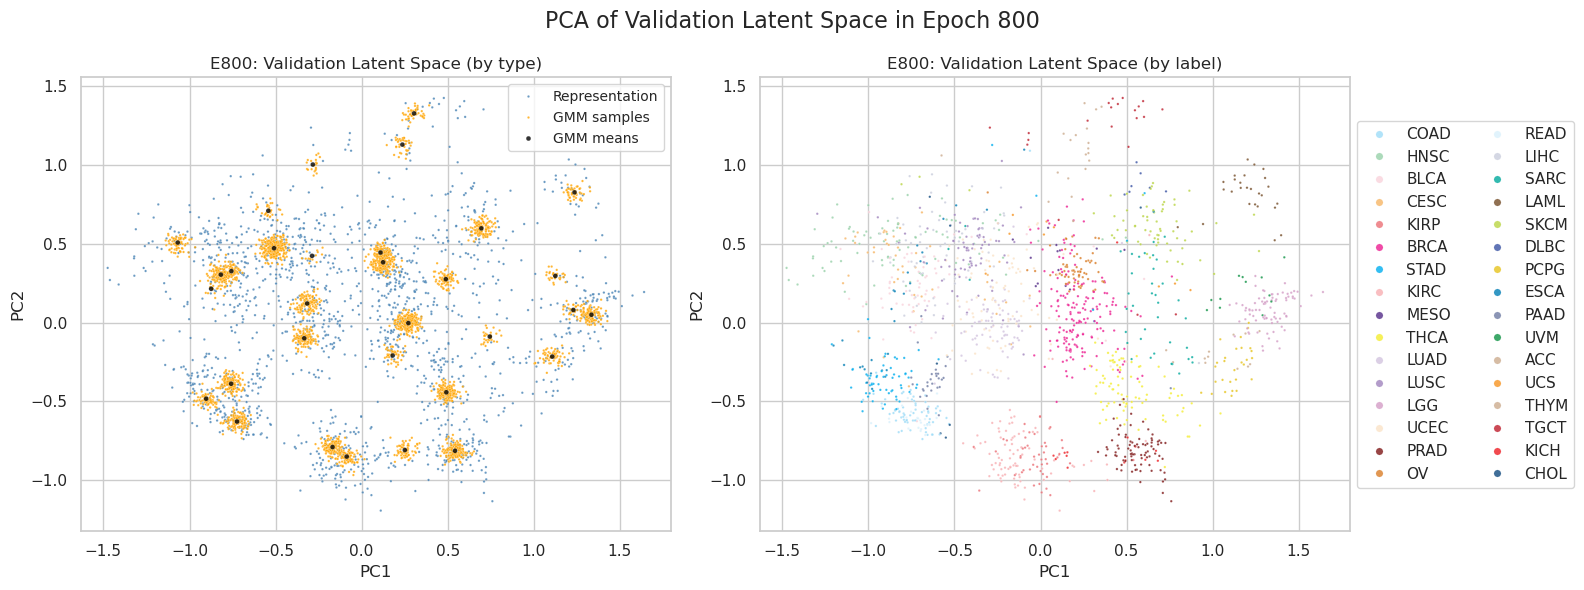

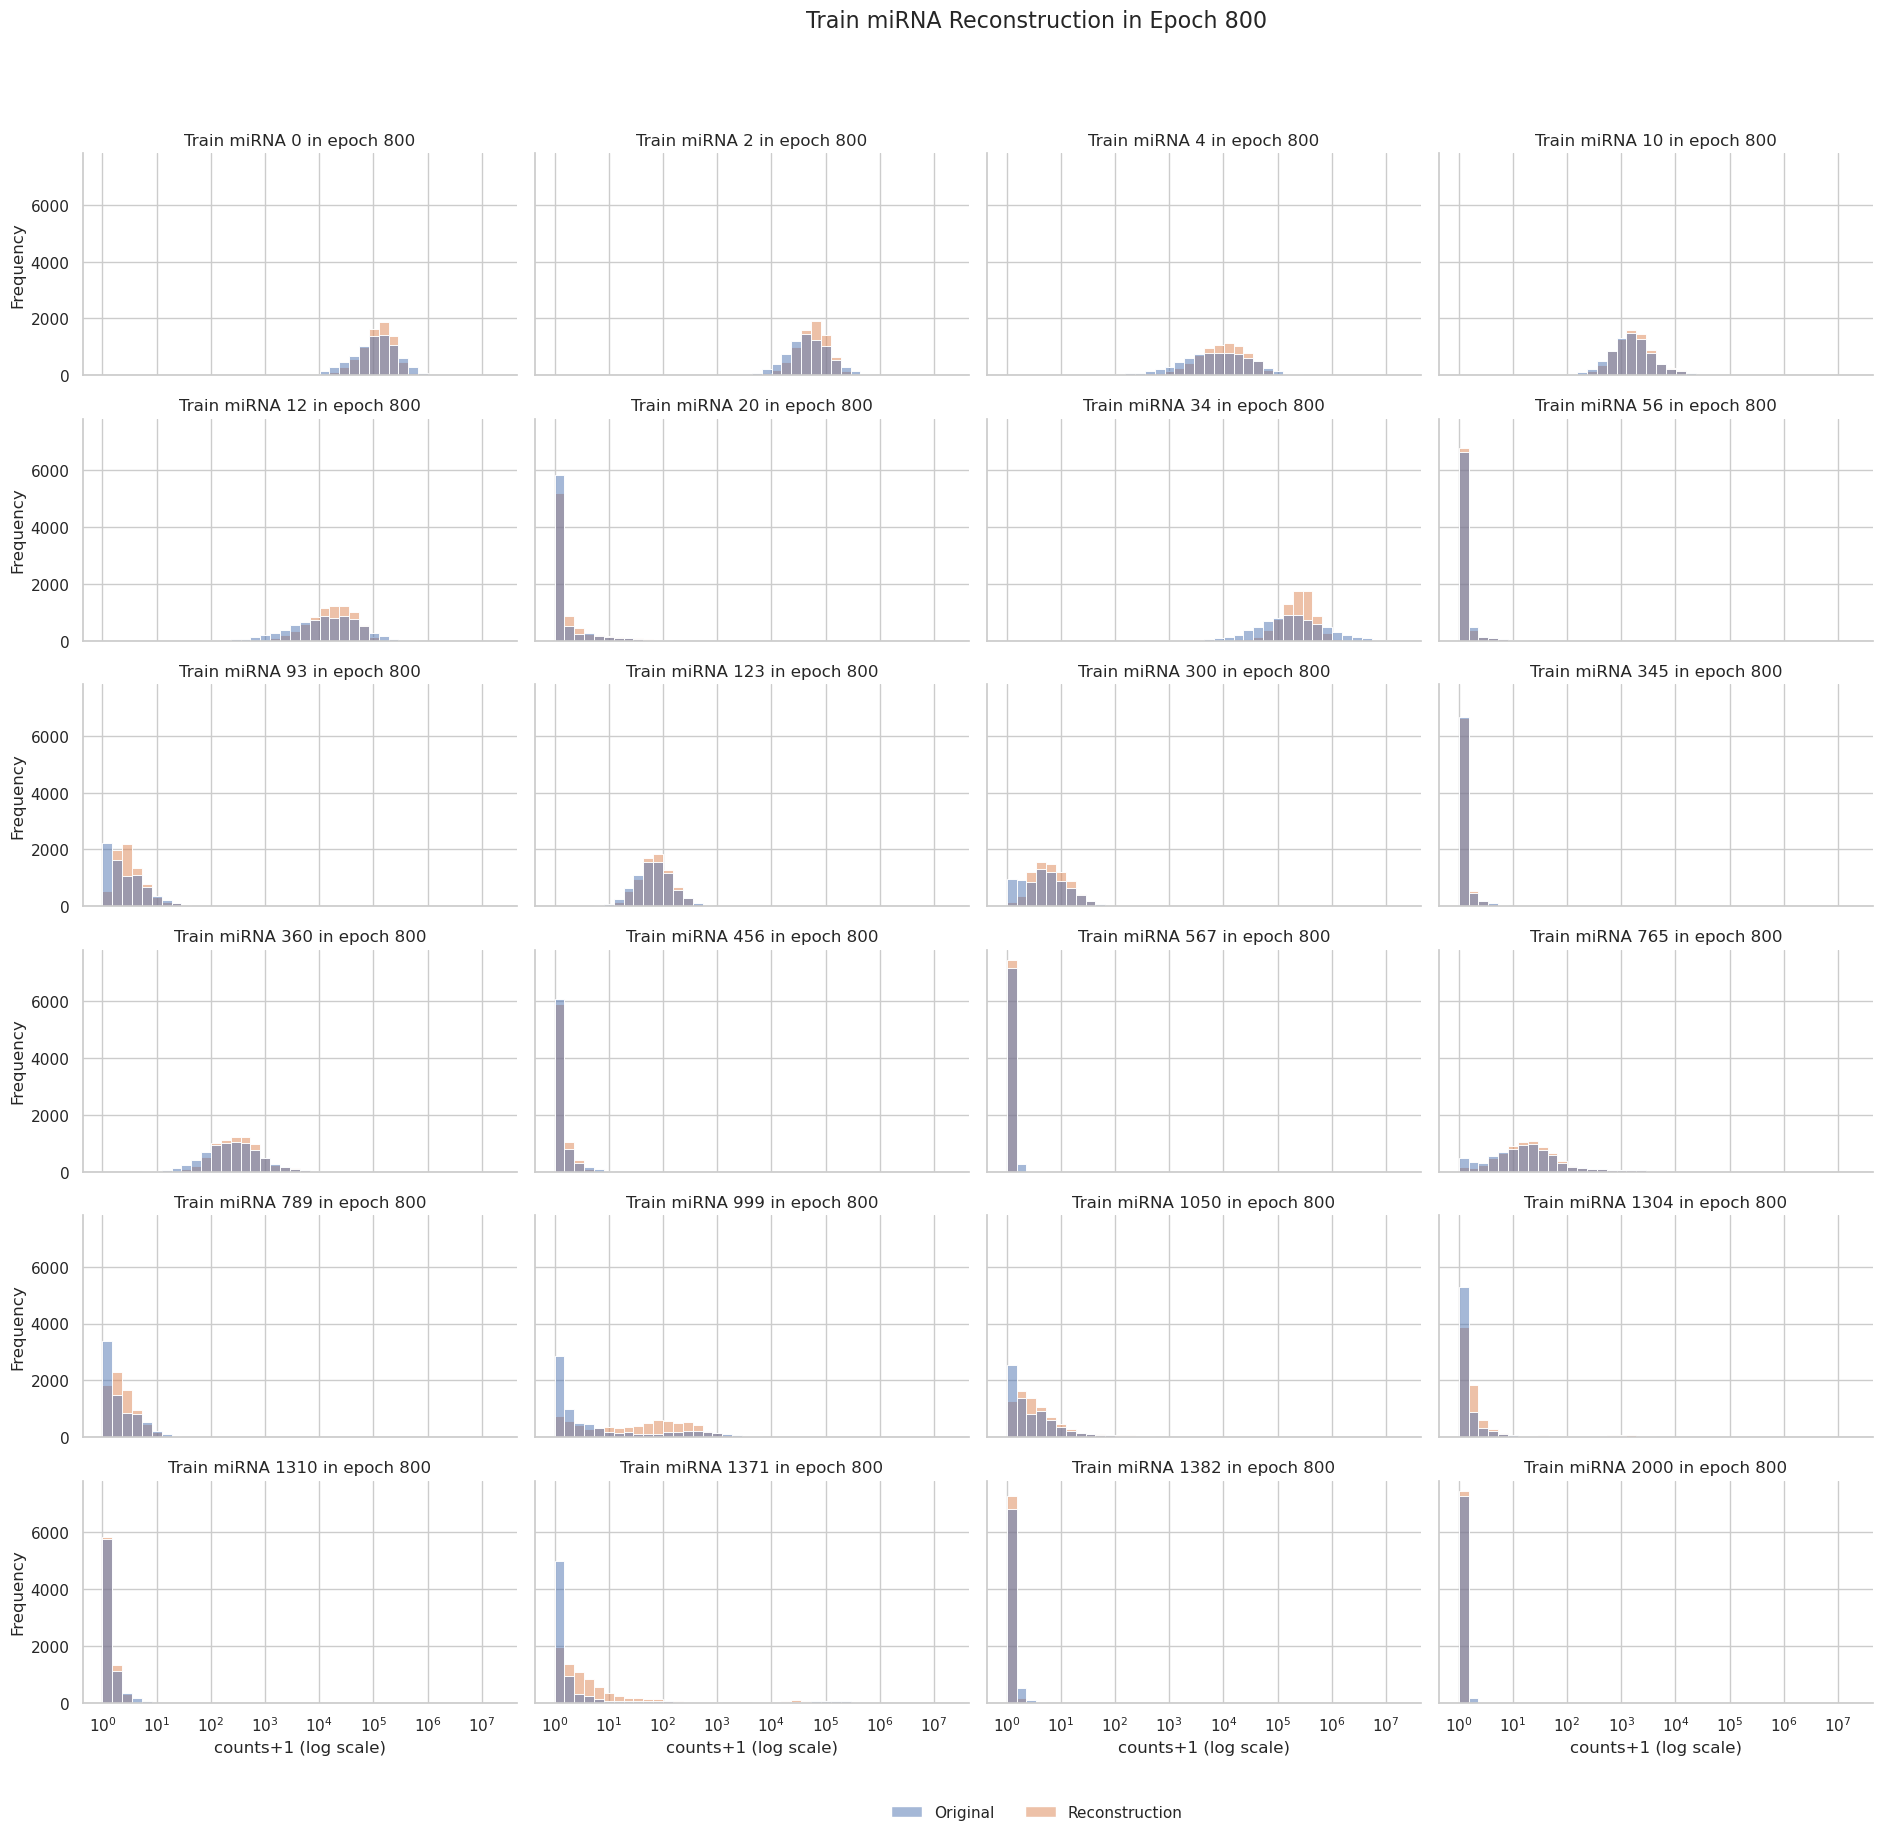

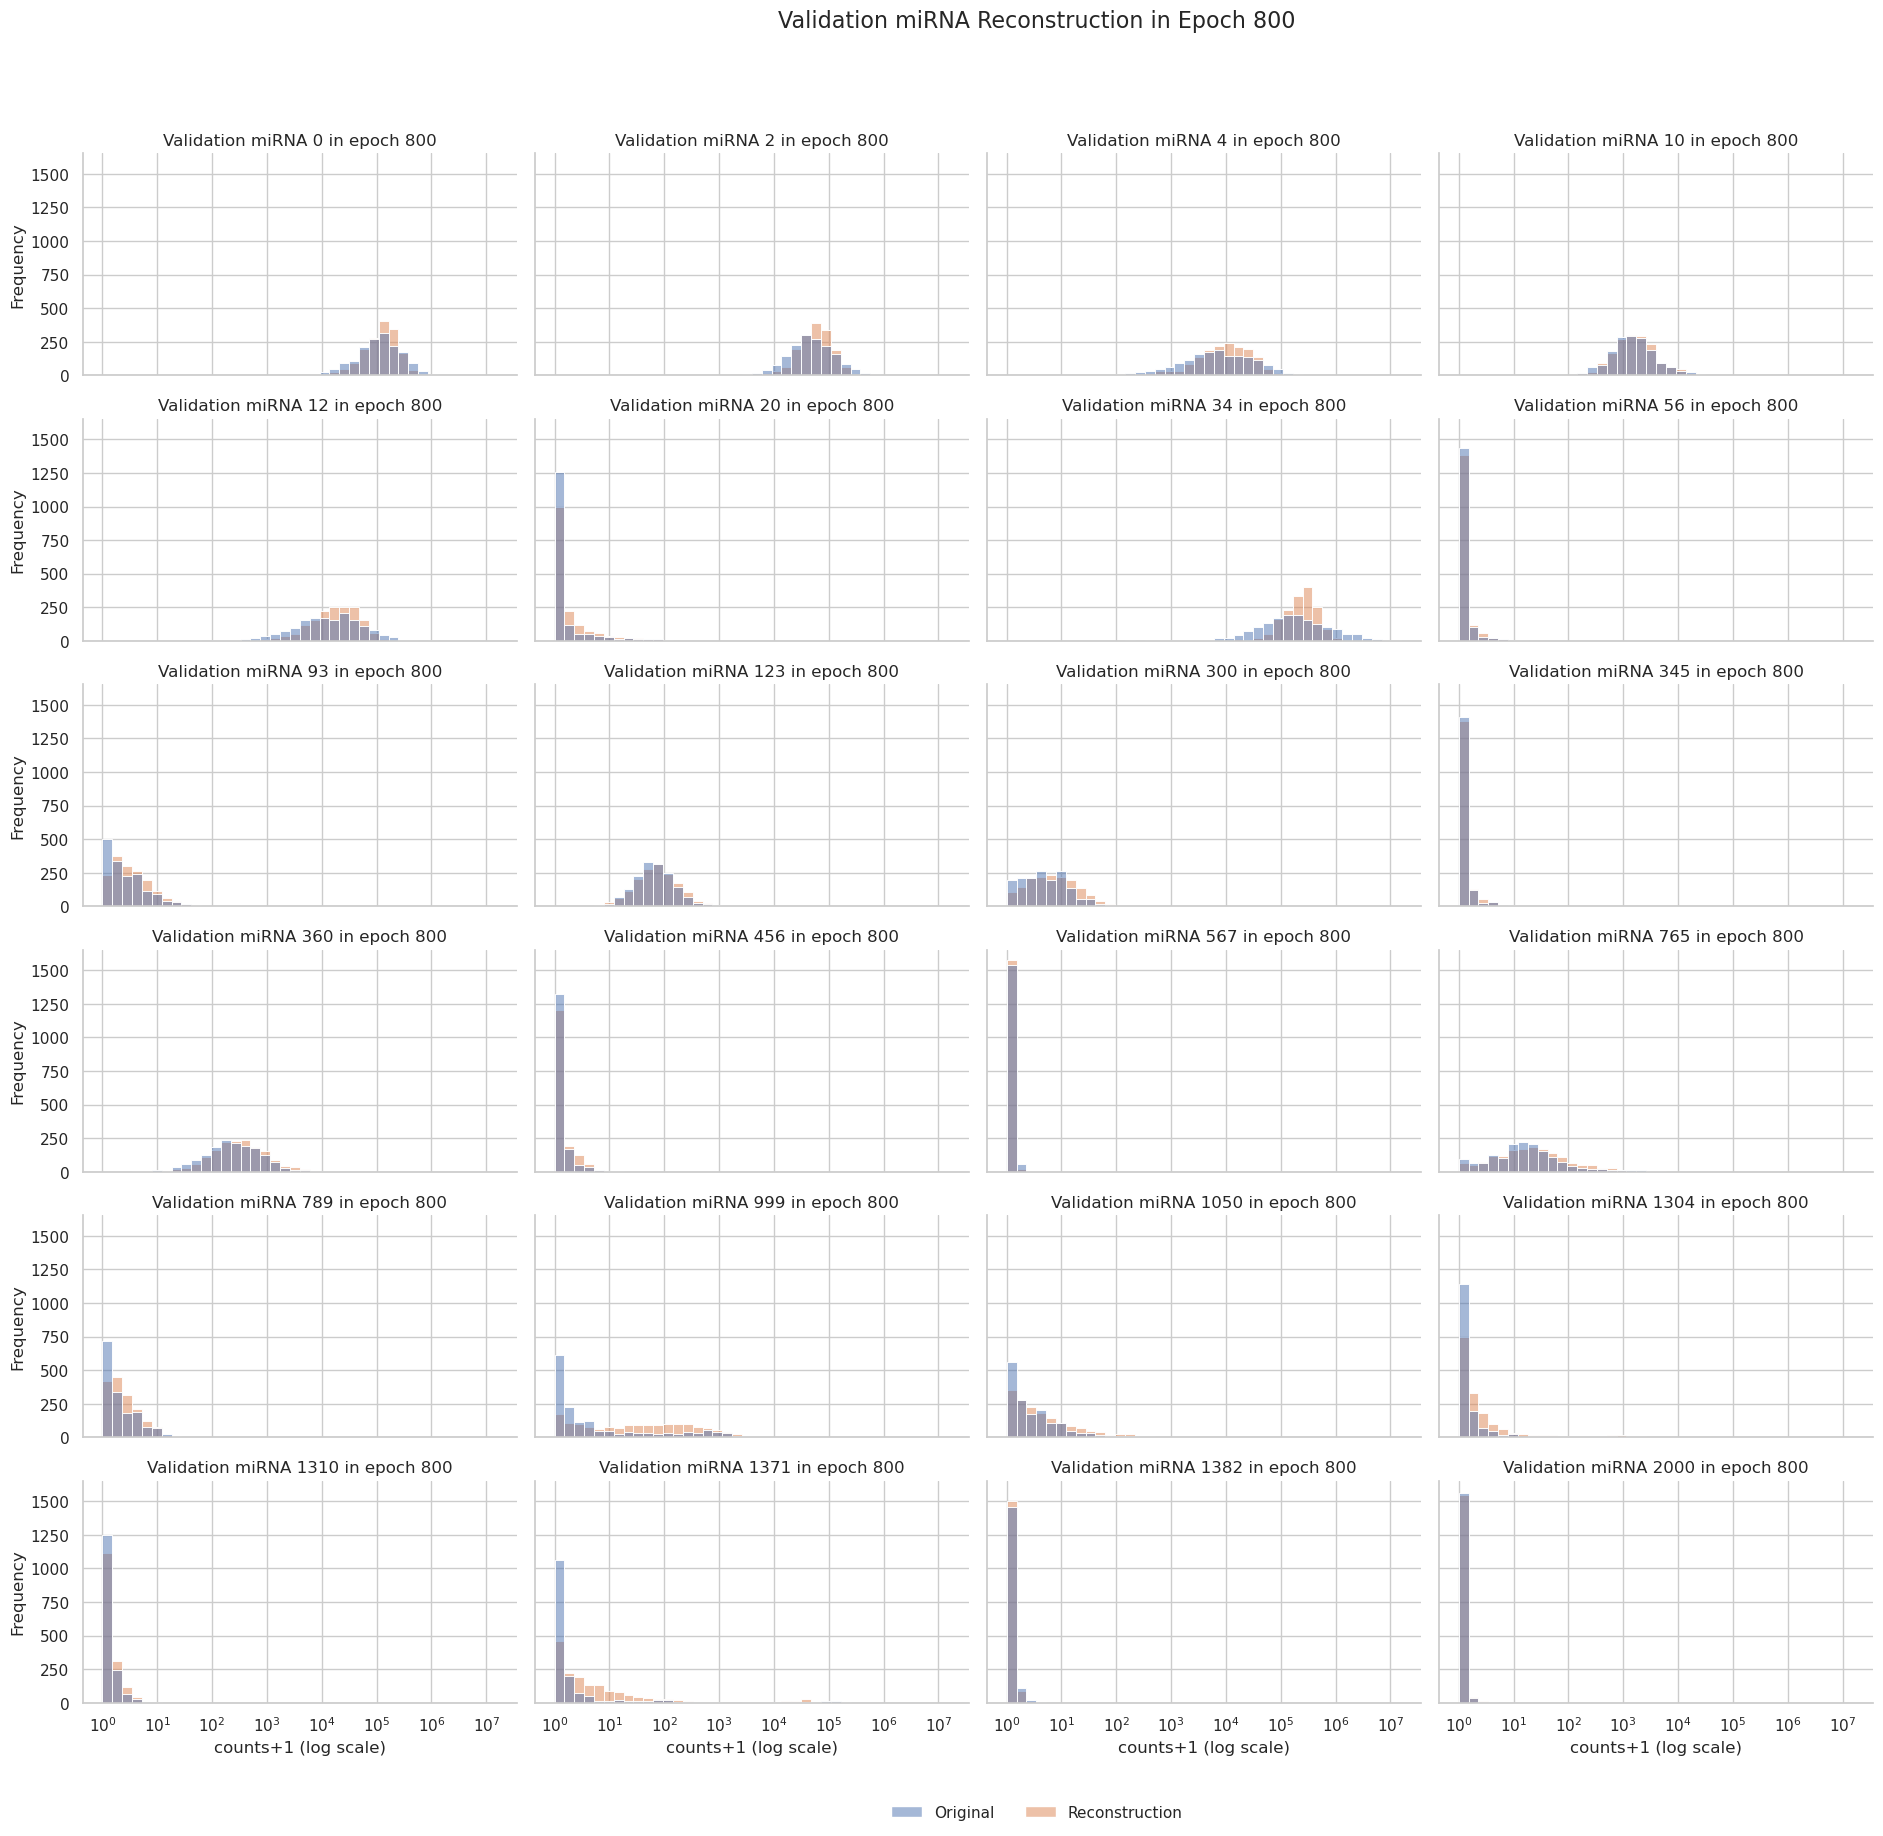

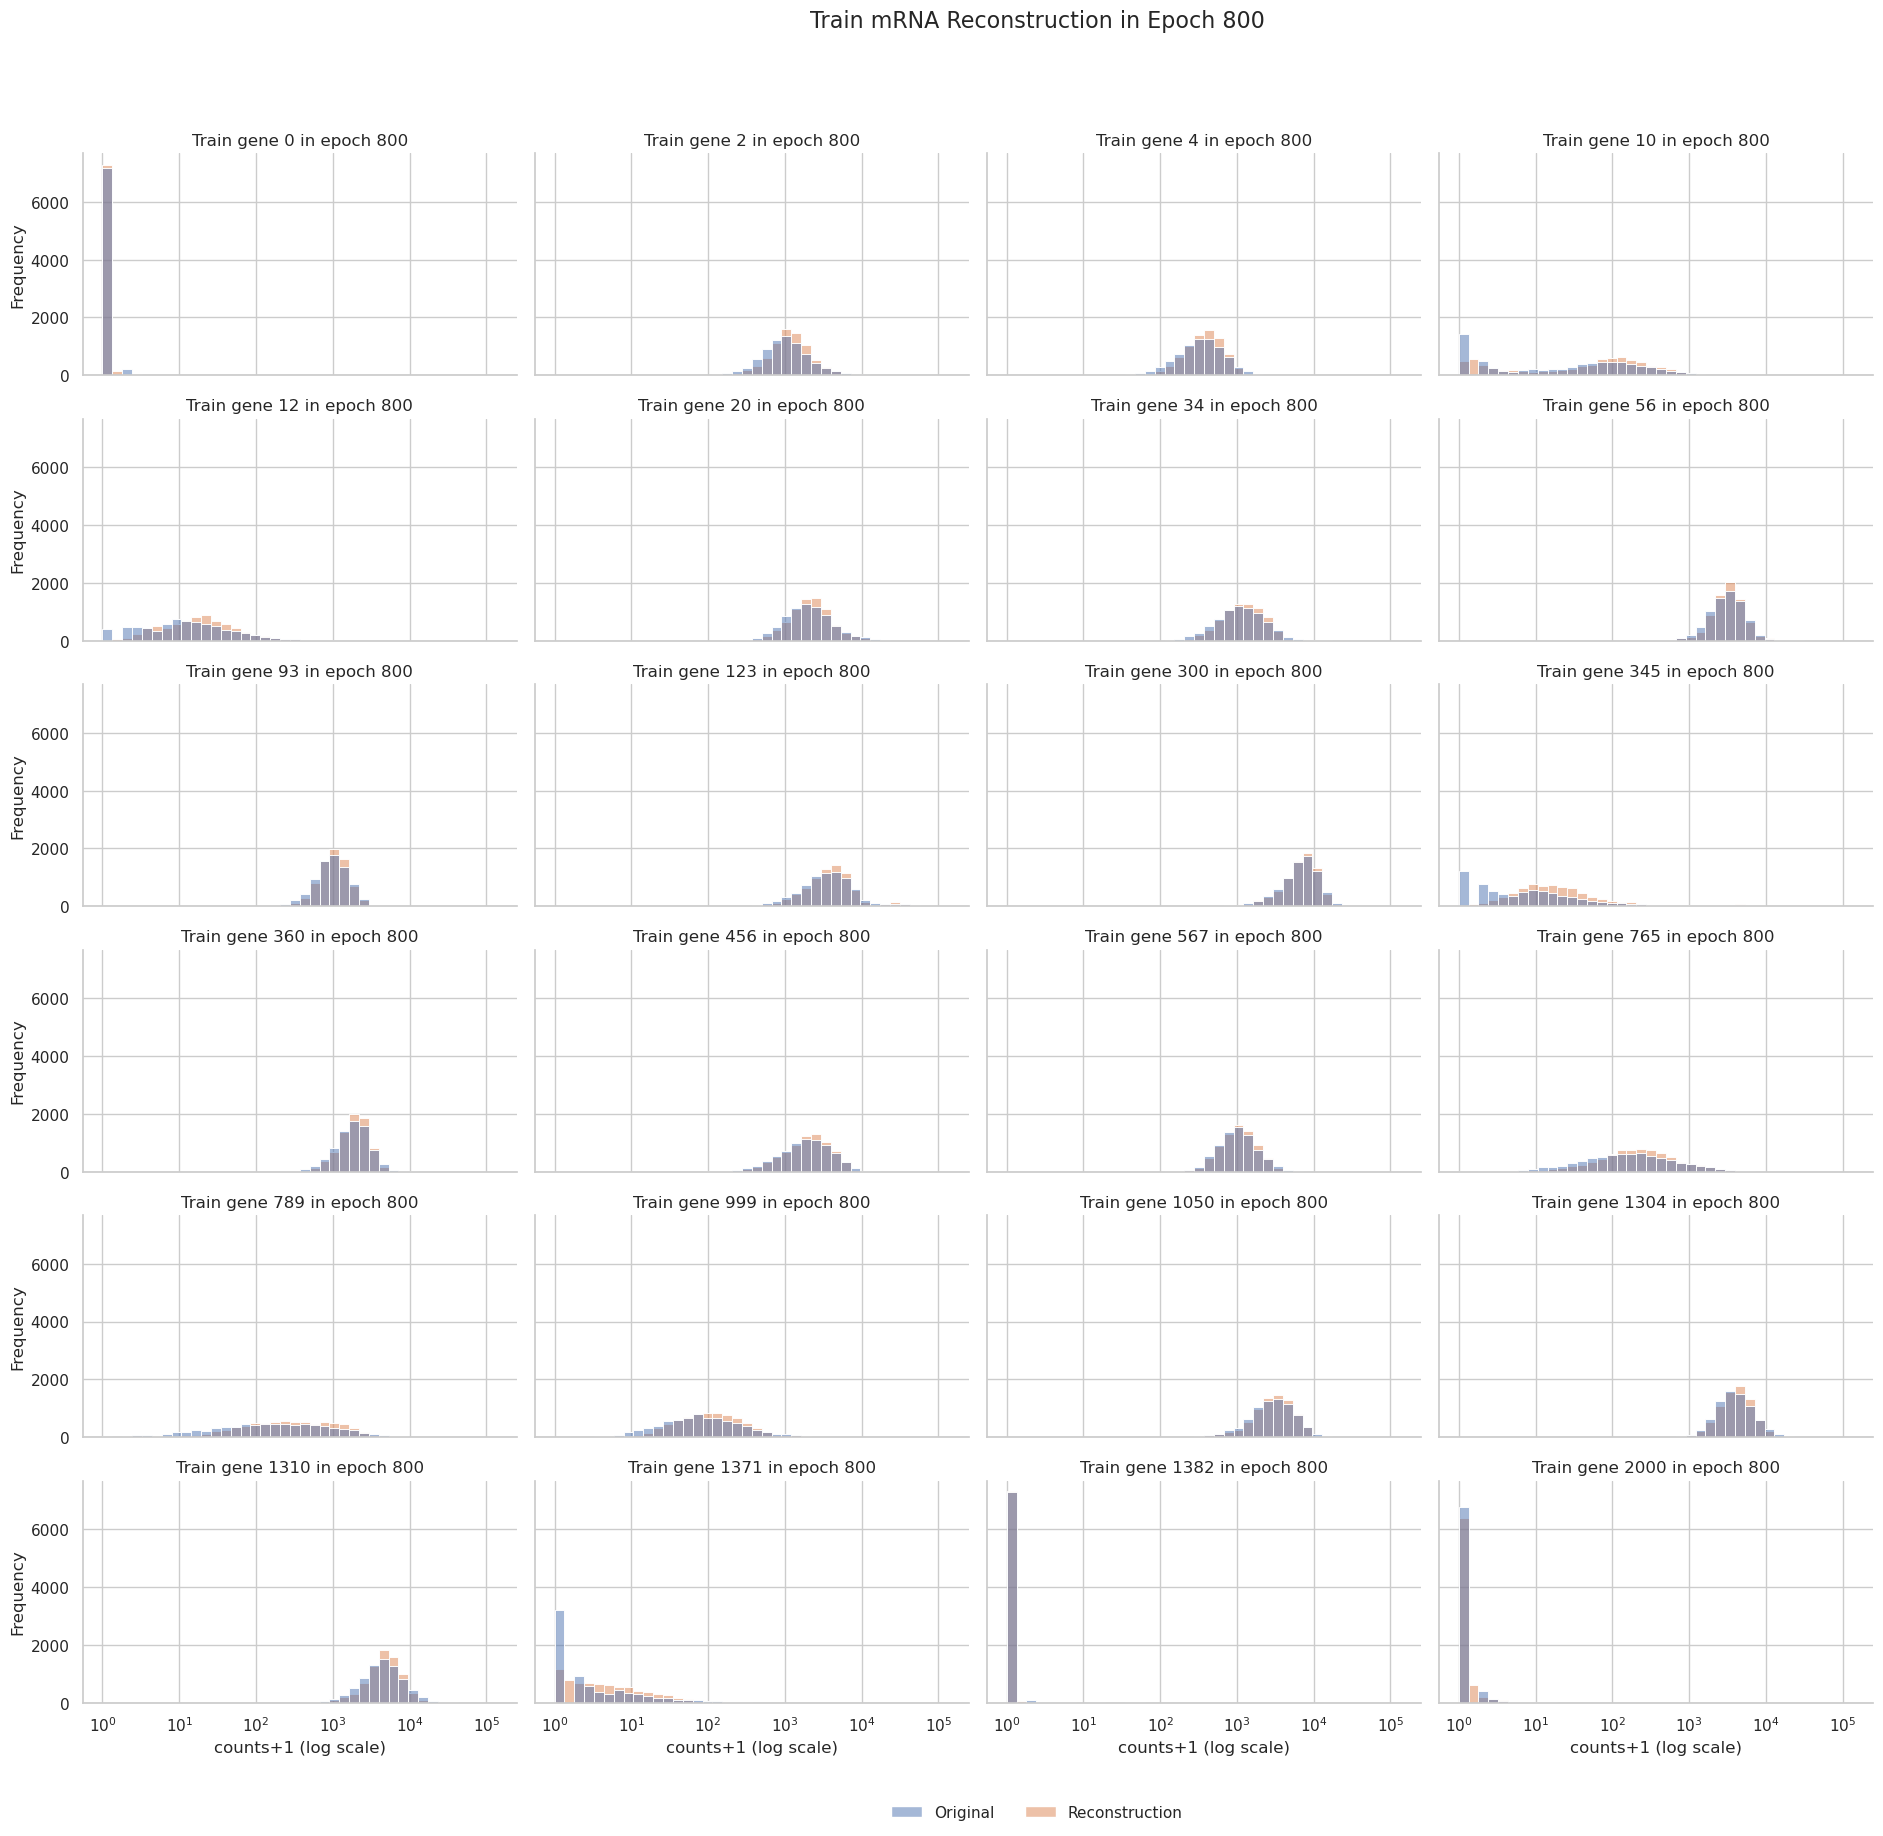

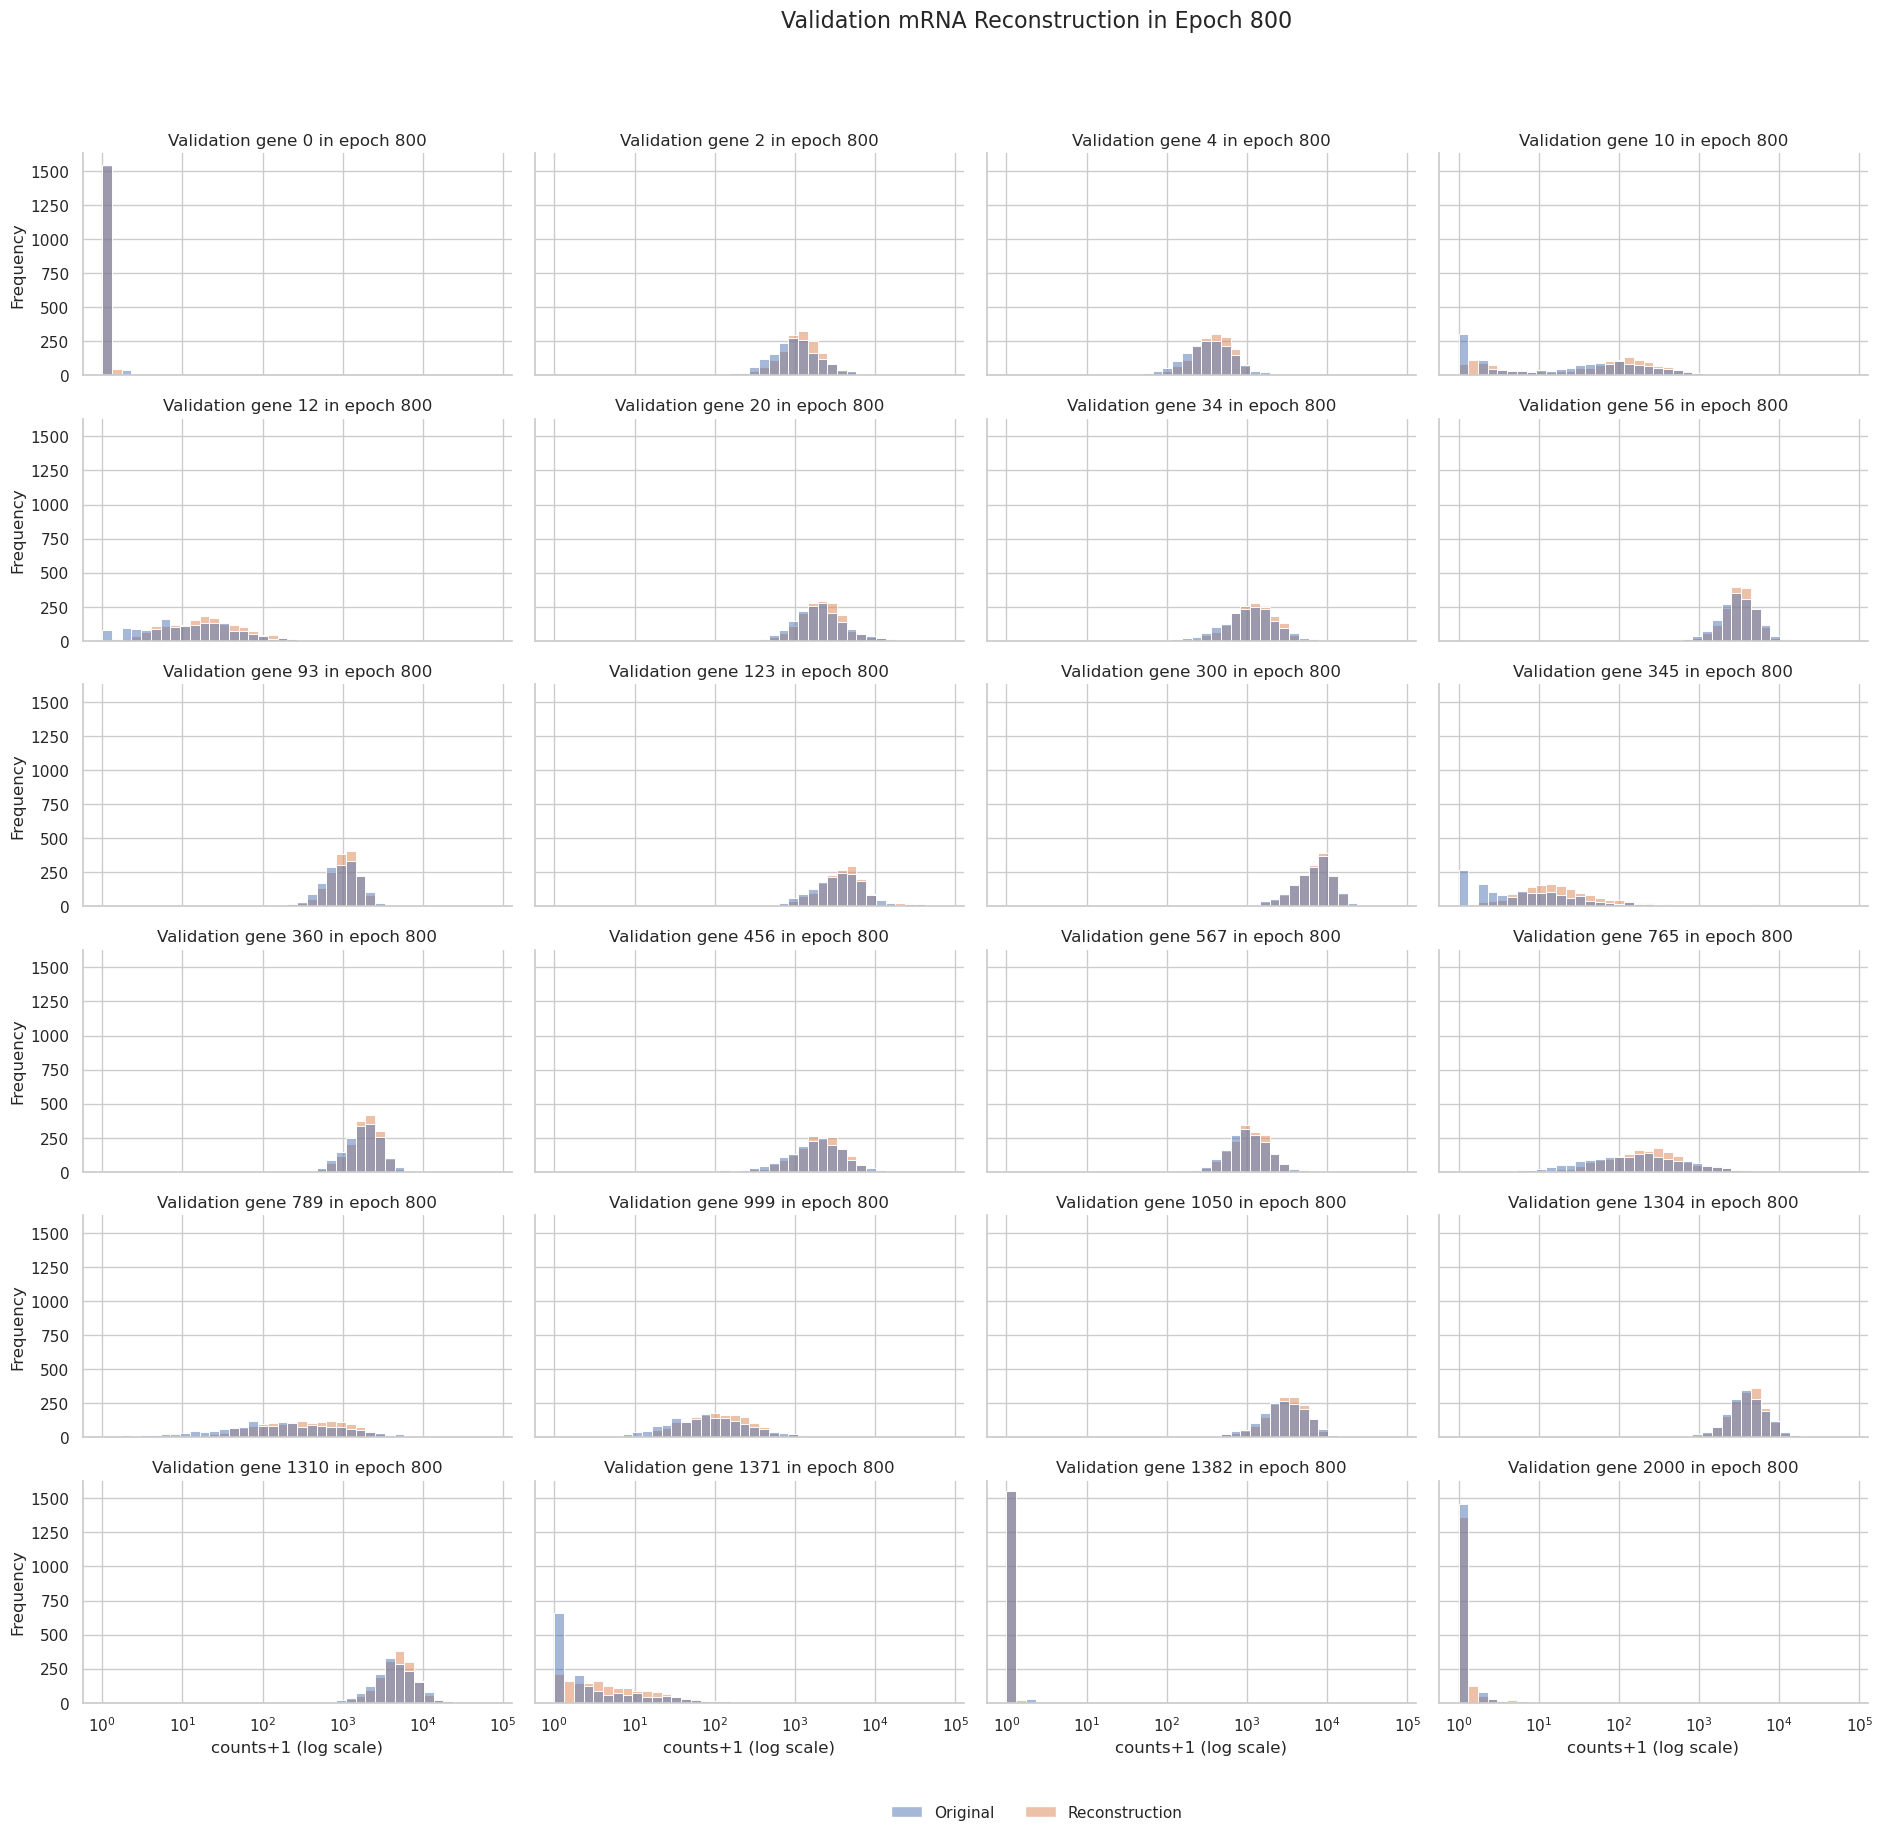

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 801/801 [1:06:40<00:00,  4.99s/it]


In [20]:
loss_tab = train_midgd(
        dgd, train_loader, validation_loader, device,
        learning_rates=learning_rates,
        weight_decay=weight_decay, betas=betas, nepochs=nepochs,
        pr=pr, plot=plot, reduction_type=reduction_type,
        sample_index=sample_index, subset=subset, wandb_log=False, early_stopping=False
    )

# Save Model

In [26]:
# Set results paths
loss_path = 'results/loss_midgd.pickle'
dgd_path = 'results/dgd_midgd.pickle'

torch.save(loss_tab, loss_path)
torch.save(dgd, dgd_path)

# Plotting Loss

In [1]:
import os
import torch
import seaborn as sns
import matplotlib.pyplot as plt

loss_path = 'results/loss_midgd.pickle'
loss_tab = torch.load(loss_path)

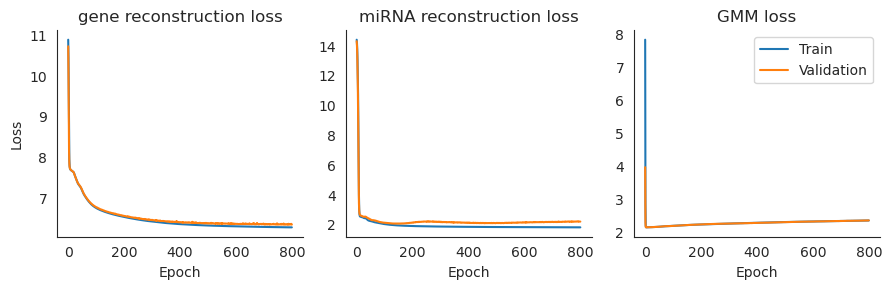

In [8]:
# Set the aesthetic style of the plots
sns.set_style("white")

# Create a figure to hold the subplots
plt.figure(figsize=(9, 3))
plt.subplots_adjust(wspace=0.3)

# First subplot for Reconstruction loss
plt.subplot(1, 3, 1)
sns.lineplot(x="epoch", y="train_recon_mrna", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_recon_mrna", data=loss_tab, label="Validation")
plt.title("gene reconstruction loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend().set_visible(False)

# First subplot for Reconstruction loss
plt.subplot(1, 3, 2)
sns.lineplot(x="epoch", y="train_recon_mirna", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_recon_mirna", data=loss_tab, label="Validation")
plt.title("miRNA reconstruction loss")
plt.xlabel("Epoch")
plt.ylabel("Loss").set_visible(False)
plt.legend().set_visible(False)

# Second subplot for GMM loss
plt.subplot(1, 3, 3)
sns.lineplot(x="epoch", y="train_gmm", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_gmm", data=loss_tab, label="Validation")
plt.title("GMM loss")
plt.xlabel("Epoch")
plt.ylabel("GMM loss").set_visible(False)


# Display the plots
plt.tight_layout()
sns.despine()
plt.savefig(os.path.join("plots", "Training loss metrics.pdf"))
plt.show()

In [12]:
loss_tab['test_recon_mrna'][-1] + loss_tab['test_gmm'][-1]

8.709150990724137

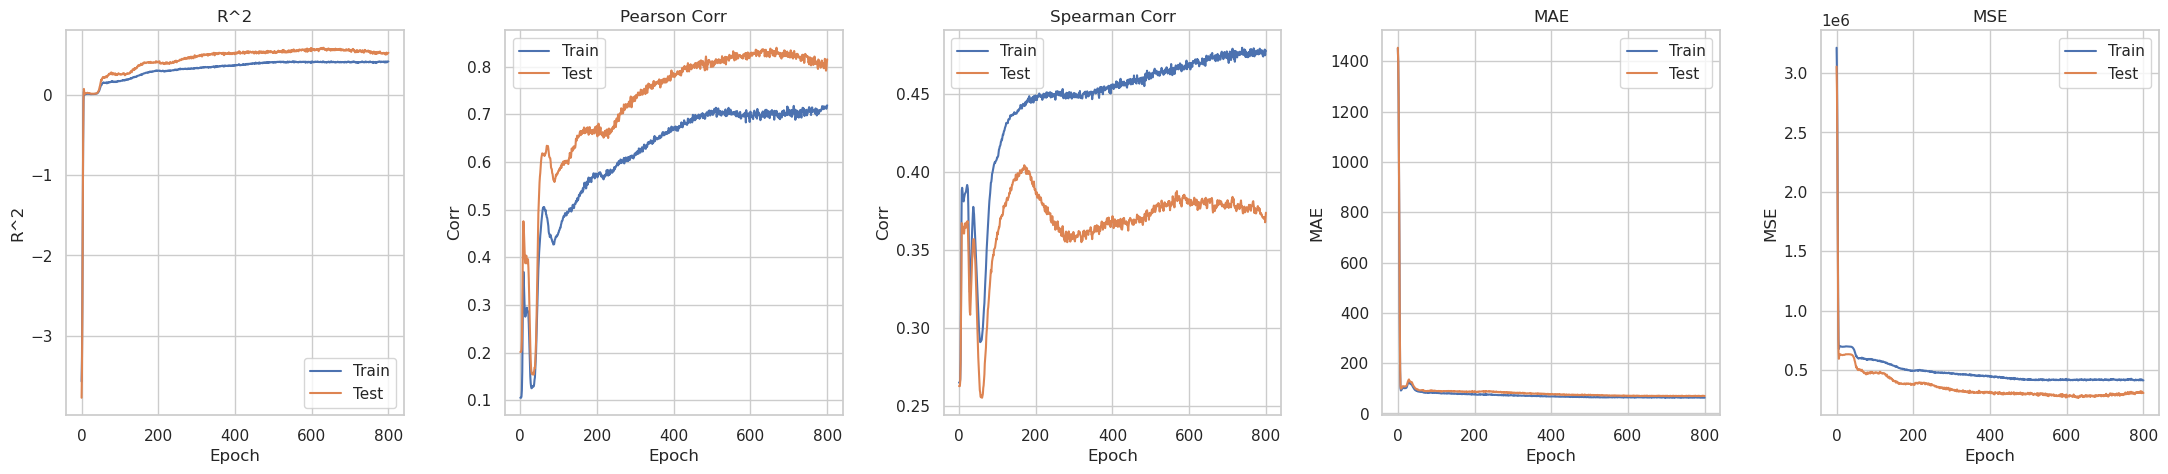

In [25]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create a figure to hold the subplots
plt.figure(figsize=(27, 5))
plt.subplots_adjust(wspace=0.3)

# First subplot for R-squared
plt.subplot(1, 5, 1)
sns.lineplot(x="epoch", y="train_r2", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_r2", data=loss_tab, label="Test")
plt.title("R^2")
plt.xlabel("Epoch")
plt.ylabel("R^2")

# Second subplot for Corr
plt.subplot(1, 5, 2)
sns.lineplot(x="epoch", y="train_pearson", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_pearson", data=loss_tab, label="Test")
plt.title("Pearson Corr")
plt.xlabel("Epoch")
plt.ylabel("Corr")

# Third subplot for MSE
plt.subplot(1, 5, 3)
sns.lineplot(x="epoch", y="train_spearman", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_spearman", data=loss_tab, label="Test")
plt.title("Spearman Corr")
plt.xlabel("Epoch")
plt.ylabel("Corr")

# Fourth subplot for MAE
plt.subplot(1, 5, 4)
sns.lineplot(x="epoch", y="train_mae", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_mae", data=loss_tab, label="Test")
plt.title("MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE")

# Fourth subplot for MAE
plt.subplot(1, 5, 5)
sns.lineplot(x="epoch", y="train_mse", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_mse", data=loss_tab, label="Test")
plt.title("MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE")

# Display the plots
plt.show()

# Simple Analysis

In [16]:
dgd = torch.load('models/midgd_final.pt', map_location=torch.device('cpu'))

In [17]:
dgd

DGD(
  (decoder): Decoder(
    (main): ModuleList(
      (0): Linear(in_features=20, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
    )
    (out_module_mirna): NB_Module(
      (fc): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=2024, bias=True)
      )
    )
    (out_module_mrna): NB_Module(
      (fc): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=512, bias=True)
        (3): ReLU()
        (4): Linear(in_features=512, out_features=19741, bias=True)
      )
    )
  )
  (gmm): GaussianMixture()
  (train_rep): RepresentationLayer()
  (val_rep): RepresentationLayer()
  (test_rep): RepresentationLayer()
)

In [2]:
from base.plotting.plot_cv2 import plot_latent_space, plot_mirna
from base.dgd.latent import RepresentationLayer
from tqdm import tqdm
from base.engine.predict import learn_new_representation

In [18]:
plot_latent_space(*dgd.get_latent_space_values("test",3000), test_loader.dataset.label, color_mapping, epoch=800, dataset="Test")

NameError: name 'plot_latent_space' is not defined

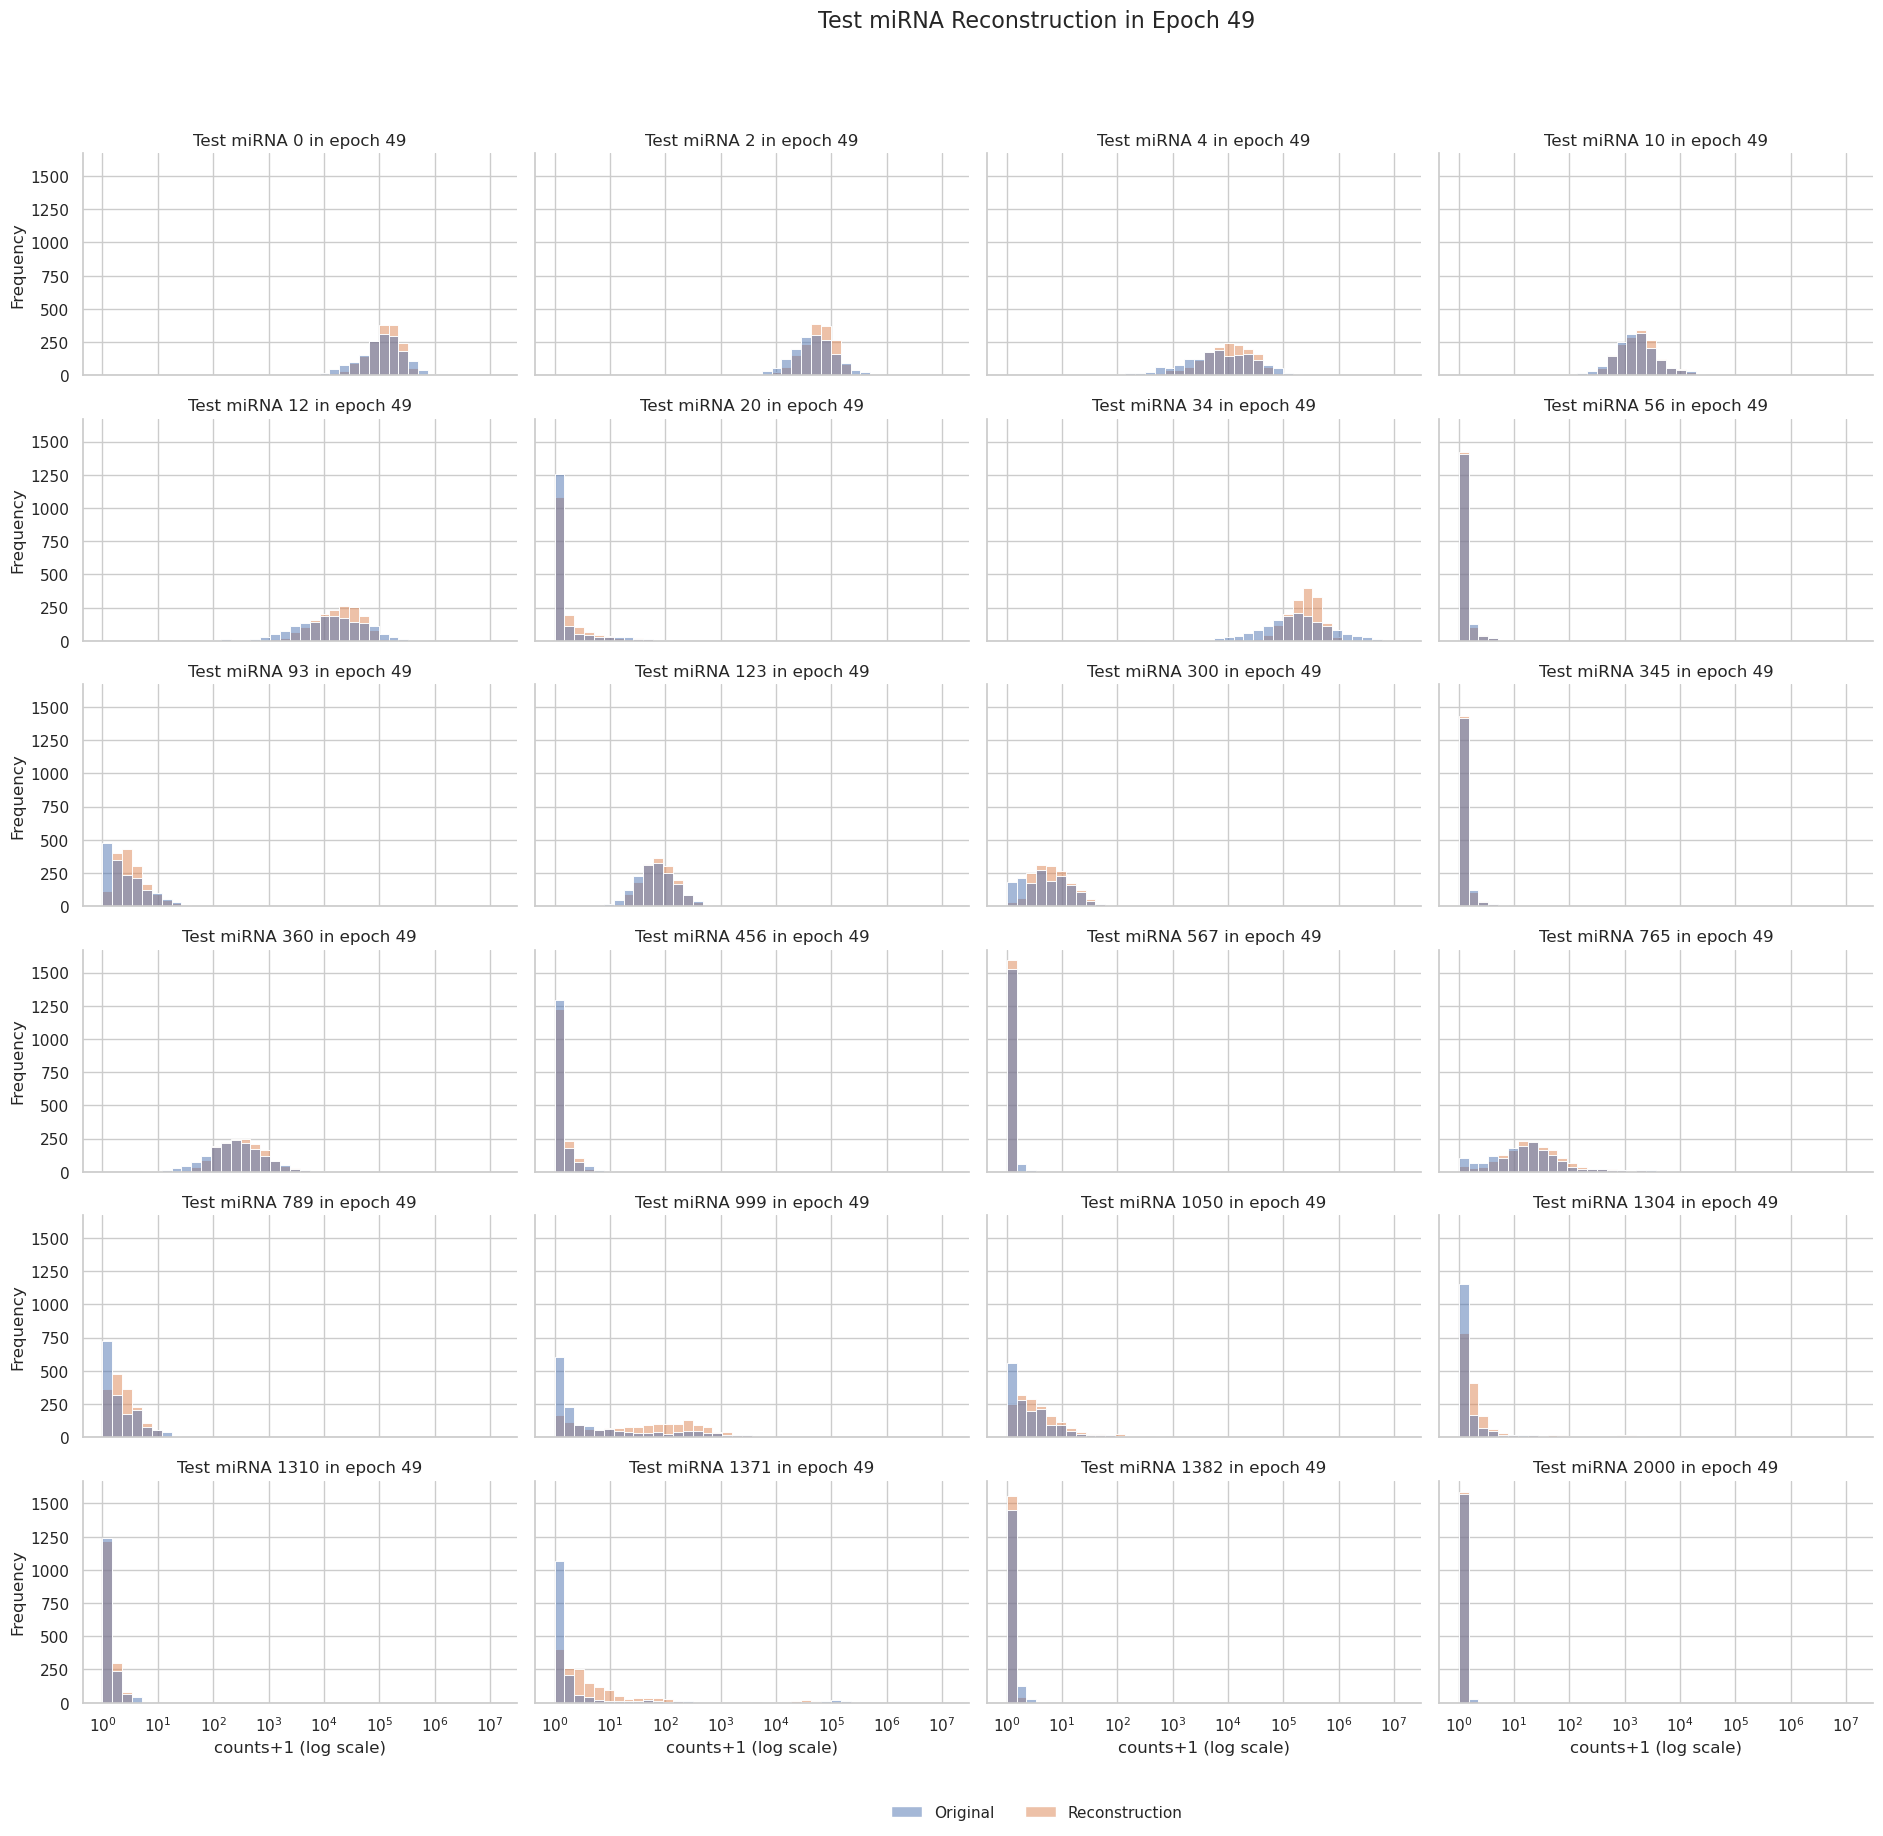

In [58]:
plot_mirna(dgd, test_loader, sample_index, epoch, device, type="Test")

In [59]:
with torch.inference_mode():
    train_scaling = torch.mean(train_loader.dataset.mirna_data, axis=1)
    val_scaling = torch.mean(validation_loader.dataset.mirna_data, axis=1)
    test_scaling = torch.mean(test_loader.dataset.mirna_data, axis=1)
    
    X_train, _ = dgd.forward(dgd.train_rep()) 
    X_train = X_train * train_scaling.unsqueeze(1).to(device)
    y_train = train_loader.dataset.mirna_data
    X_val, _ = dgd.forward(dgd.val_rep()) 
    X_val = X_val * val_scaling.unsqueeze(1).to(device)
    y_val = validation_loader.dataset.mirna_data
    X_test, _ = dgd.forward(dgd.test_rep()) 
    X_test = X_test * test_scaling.unsqueeze(1).to(device)
    y_test = test_loader.dataset.mirna_data

X_train = X_train.detach().cpu()
y_train = y_train.detach().cpu()
X_val = X_val.detach().cpu()
y_val = y_val.detach().cpu()
X_test = X_test.detach().cpu()
y_test = y_test.detach().cpu()

cancer_type = test_loader.dataset.label
color = test_loader.dataset.color
palette = dict(zip(cancer_type, color))

In [60]:
from scipy import stats
from sklearn.metrics import root_mean_squared_error

mirna_features = test_loader.dataset.mirna_data.shape[1]
spearman_corr = []
pearson_corr = []
spearman_pval = []
pearson_pval = []

for i in range(y_test.shape[1]):
    # Calculate Spearman correlation coefficient
    spearman, spearman_p = stats.spearmanr(X_test[:,i], y_test[:,i])
    pearson, pearson_p = stats.pearsonr(X_test[:,i], y_test[:,i])
    spearman_corr.append(spearman)
    pearson_corr.append(pearson)
    spearman_pval.append(spearman_p)
    pearson_pval.append(spearman_p)
    
corr_data = pd.DataFrame(
    data={
        'spearman': spearman_corr, 
        'pearson': pearson_corr,
        'spearman_p': spearman_pval,
        'pearson_p': pearson_pval,
        'mirna': np.arange(0,mirna_features)
    },
    index=np.arange(0,mirna_features)
)
corr_data

spearman   pearson     spearman_p      pearson_p  mirna
0     0.815975  0.682244   0.000000e+00   0.000000e+00      0
1     0.680304  0.546714  3.686647e-218  3.686647e-218      1
2     0.713134  0.559985  4.194379e-249  4.194379e-249      2
3     0.727894  0.699956  1.742879e-264  1.742879e-264      3
4     0.811420  0.635898   0.000000e+00   0.000000e+00      4
...        ...       ...            ...            ...    ...
2019  0.099268  0.051468   6.892913e-05   6.892913e-05   2019
2020  0.058469  0.170593   1.926357e-02   1.926357e-02   2020
2021  0.069516  0.015172   5.376233e-03   5.376233e-03   2021
2022  0.135159  0.043365   5.620990e-08   5.620990e-08   2022
2023  0.126135  0.163078   4.086962e-07   4.086962e-07   2023

[2024 rows x 5 columns]

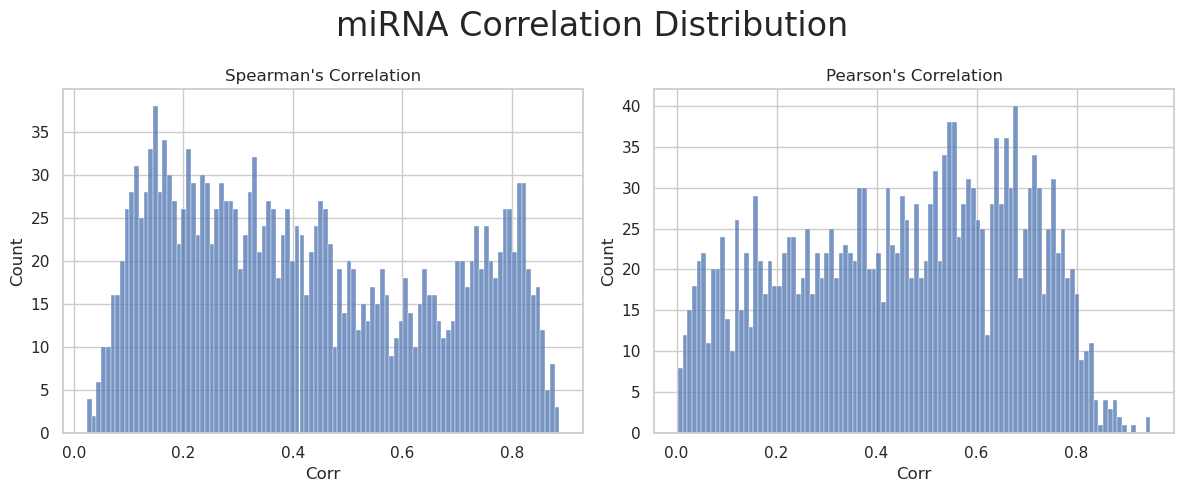

In [61]:
sns.set_style("whitegrid")
fig = plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
sns.histplot(data=corr_data, x='spearman', bins=100)
plt.title("Spearman's Correlation")
plt.xlabel("Corr")

plt.subplot(1,2,2)
sns.histplot(data=corr_data, x='pearson', bins=100)
plt.title("Pearson's Correlation")
plt.xlabel("Corr")

# Add the main title to the figure
fig.suptitle("miRNA Correlation Distribution", fontsize=24)

# Display the plots
plt.tight_layout()
plt.show()

## miR-122-5p

In [62]:
miR_122_5p_train = pd.DataFrame(
    data={
        'X': X_train[:,1371], 
        'y': y_train[:,1371],
        'cancer_type': train_loader.dataset.label,
        'color': train_loader.dataset.color
    }
)
miR_122_5p_val = pd.DataFrame(
    data={
        'X': X_val[:,1371], 
        'y': y_val[:,1371],
        'cancer_type': validation_loader.dataset.label,
        'color': validation_loader.dataset.color
    }
)
miR_122_5p_test = pd.DataFrame(
    data={
        'X': X_test[:,1371], 
        'y': y_test[:,1371],
        'cancer_type': test_loader.dataset.label,
        'color': test_loader.dataset.color
    }
)

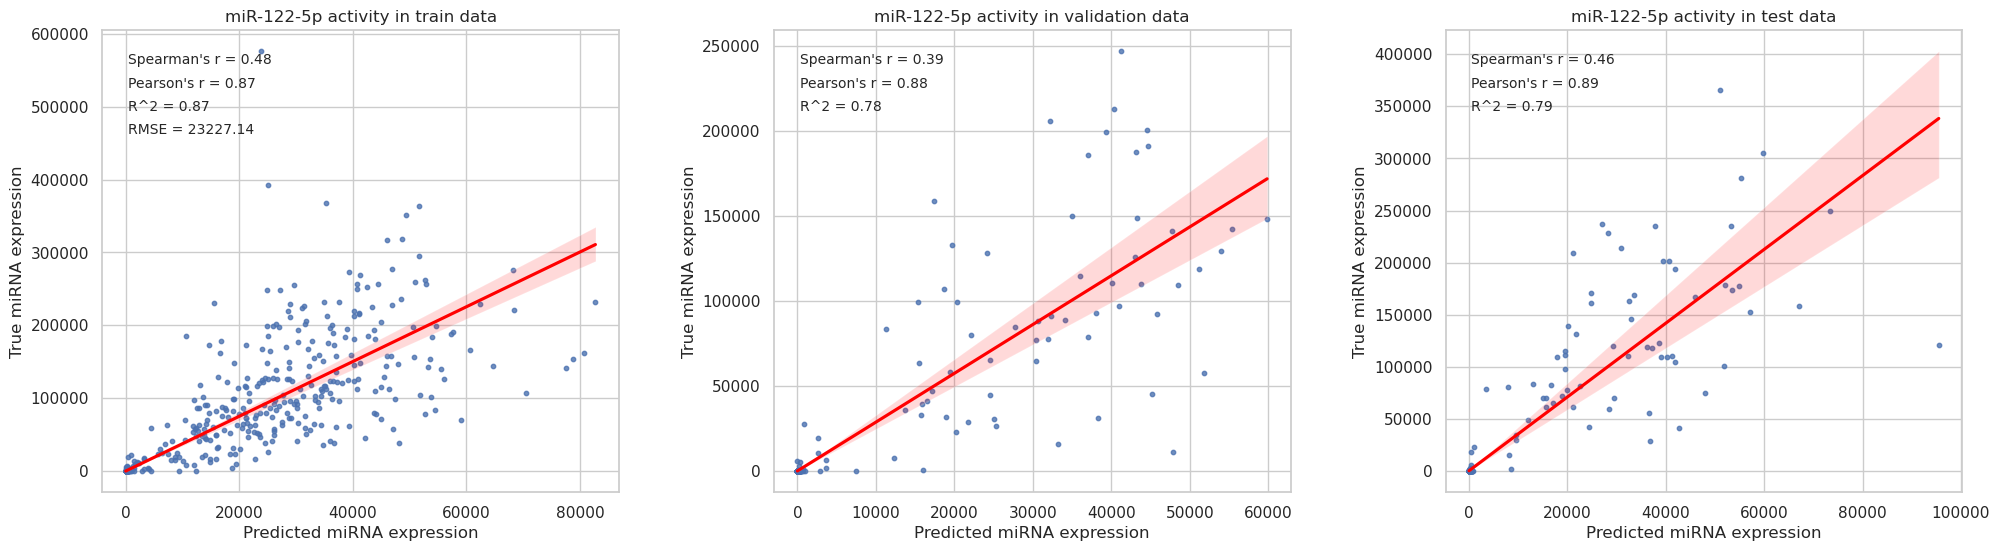

In [88]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create a figure to hold the subplots
plt.figure(figsize=(24, 6))
plt.subplots_adjust(wspace=0.3)

# Subplot Train
plt.subplot(1, 3, 1)
# Create scatterplot
sns.regplot(data=miR_122_5p_train, x="X", y="y", scatter_kws={"s": 10}, line_kws={"color": "red"})
# Calculate Spearman correlation coefficient
spearman_corr, _ = stats.spearmanr(miR_122_5p_train['X'], miR_122_5p_train['y'])
pearson_corr, _ = stats.pearsonr(miR_122_5p_train['X'], miR_122_5p_train['y'])
_, _, r_val, _, _ = stats.linregress(miR_122_5p_train['X'], miR_122_5p_train['y'])
rmse = root_mean_squared_error(miR_122_5p_train['y'], miR_122_5p_train['X'])
# Add correlation coefficient as text annotation
plt.text(0.05, 0.95, f"Spearman's r = {spearman_corr:.2f}", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.text(0.05, 0.90, f"Pearson's r = {pearson_corr:.2f}", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.text(0.05, 0.85, f"R^2 = {r_val**2:.2f}", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.text(0.05, 0.80, f"RMSE = {rmse:.2f}", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.xlabel("Predicted miRNA expression")
plt.ylabel("True miRNA expression")
plt.title("miR-122-5p activity in train data")

# Subplot Train
plt.subplot(1, 3, 2)
# Create scatterplot
sns.regplot(data=miR_122_5p_val, x="X", y="y", scatter_kws={"s": 10}, line_kws={"color": "red"})
# Calculate Spearman correlation coefficient
spearman_corr, _ = stats.spearmanr(miR_122_5p_val['X'], miR_122_5p_val['y'])
pearson_corr, _ = stats.pearsonr(miR_122_5p_val['X'], miR_122_5p_val['y'])
_, _, r_val, _, _ = stats.linregress(miR_122_5p_val['X'], miR_122_5p_val['y'])
# Add correlation coefficient as text annotation
plt.text(0.05, 0.95, f"Spearman's r = {spearman_corr:.2f}", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.text(0.05, 0.90, f"Pearson's r = {pearson_corr:.2f}", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.text(0.05, 0.85, f"R^2 = {r_val**2:.2f}", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.xlabel("Predicted miRNA expression")
plt.ylabel("True miRNA expression")
plt.title("miR-122-5p activity in validation data")

# Subplot Train
plt.subplot(1, 3, 3)
# Create scatterplot
sns.regplot(data=miR_122_5p_test, x="X", y="y", scatter_kws={"s": 10}, line_kws={"color": "red"})
# Calculate Spearman correlation coefficient
spearman_corr, _ = stats.spearmanr(miR_122_5p_test['X'], miR_122_5p_test['y'])
pearson_corr, _ = stats.pearsonr(miR_122_5p_test['X'], miR_122_5p_test['y'])
_, _, r_val, _, _ = stats.linregress(miR_122_5p_test['X'], miR_122_5p_test['y'])
# Add correlation coefficient as text annotation
plt.text(0.05, 0.95, f"Spearman's r = {spearman_corr:.2f}", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.text(0.05, 0.90, f"Pearson's r = {pearson_corr:.2f}", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.text(0.05, 0.85, f"R^2 = {r_val**2:.2f}", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.xlabel("Predicted miRNA expression")
plt.ylabel("True miRNA expression")
plt.title("miR-122-5p activity in test data")

plt.show()

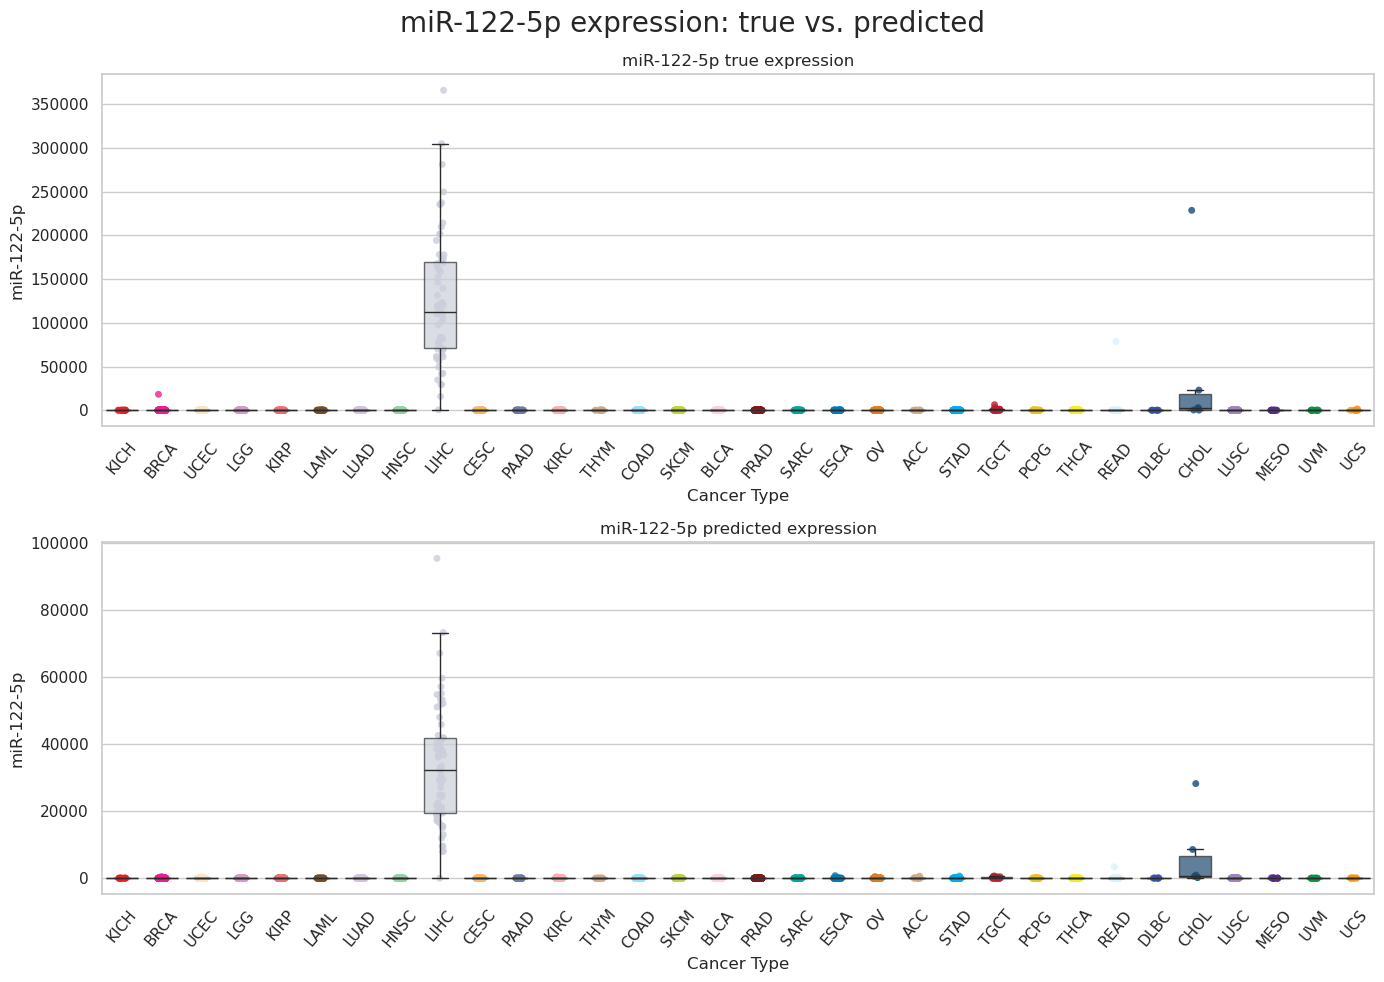

In [64]:
sns.set_style("whitegrid")
plt.figure(figsize=(14, 10))
plt.subplots_adjust(wspace=0.2, hspace=0.2)

plt.subplot(2, 1, 1)
sns.boxplot(data=miR_122_5p_test, x="cancer_type", y="y", hue="cancer_type", palette=palette, boxprops=dict(alpha=.7), showfliers=False)
sns.stripplot(data=miR_122_5p_test, x="cancer_type", y="y", hue="cancer_type", palette=palette, alpha=0.8, zorder=0)
plt.title("miR-122-5p true expression")
plt.xlabel("Cancer Type")
plt.ylabel("miR-122-5p")
plt.xticks(rotation=50)

plt.subplot(2, 1, 2)
sns.boxplot(data=miR_122_5p_test, x="cancer_type", y="X", hue="cancer_type", palette=palette, boxprops=dict(alpha=.7), showfliers=False)
sns.stripplot(data=miR_122_5p_test, x="cancer_type", y="X", hue="cancer_type", palette=palette, alpha=0.8, zorder=0)
plt.title("miR-122-5p predicted expression")
plt.xlabel("Cancer Type")
plt.ylabel("miR-122-5p")
plt.xticks(rotation=50)

plt.suptitle("miR-122-5p expression: true vs. predicted", fontsize=20)
plt.tight_layout()
plt.show()

## miR-124-3p

In [65]:
miR_124_3p_train = pd.DataFrame(
    data={
        'X': X_train[:,1304], 
        'y': y_train[:,1304],
        'cancer_type': train_loader.dataset.label,
        'color': train_loader.dataset.color
    }
)
miR_124_3p_val = pd.DataFrame(
    data={
        'X': X_val[:,1304], 
        'y': y_val[:,1304],
        'cancer_type': validation_loader.dataset.label,
        'color': validation_loader.dataset.color
    }
)
miR_124_3p_test = pd.DataFrame(
    data={
        'X': X_test[:,1304], 
        'y': y_test[:,1304],
        'cancer_type': test_loader.dataset.label,
        'color': test_loader.dataset.color
    }
)

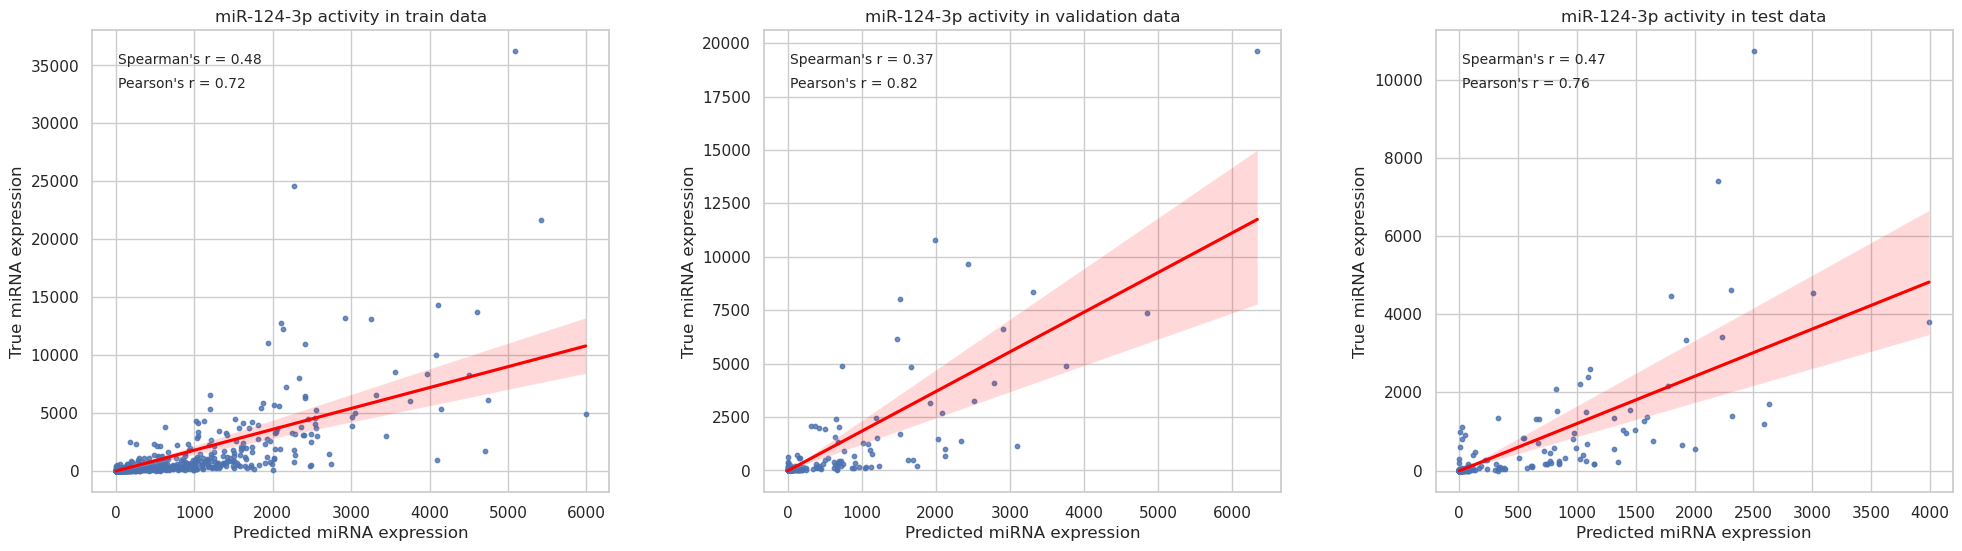

In [69]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create a figure to hold the subplots
plt.figure(figsize=(24, 6))
plt.subplots_adjust(wspace=0.3)

# Subplot Train
plt.subplot(1, 3, 1)
# Create scatterplot
sns.regplot(data=miR_124_3p_train, x="X", y="y", scatter_kws={"s": 10}, line_kws={"color": "red"})
# Calculate Spearman correlation coefficient
spearman_corr, _ = stats.spearmanr(miR_124_3p_train['X'], miR_124_3p_train['y'])
pearson_corr, _ = stats.pearsonr(miR_124_3p_train['X'], miR_124_3p_train['y'])
# Add correlation coefficient as text annotation
plt.text(0.05, 0.95, f"Spearman's r = {spearman_corr:.2f}", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.text(0.05, 0.90, f"Pearson's r = {pearson_corr:.2f}", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.xlabel("Predicted miRNA expression")
plt.ylabel("True miRNA expression")
plt.title("miR-124-3p activity in train data")

# Subplot Train
plt.subplot(1, 3, 2)
# Create scatterplot
sns.regplot(data=miR_124_3p_val, x="X", y="y", scatter_kws={"s": 10}, line_kws={"color": "red"})
# Calculate Spearman correlation coefficient
spearman_corr, _ = stats.spearmanr(miR_124_3p_val['X'], miR_124_3p_val['y'])
pearson_corr, _ = stats.pearsonr(miR_124_3p_val['X'], miR_124_3p_val['y'])
# Add correlation coefficient as text annotation
plt.text(0.05, 0.95, f"Spearman's r = {spearman_corr:.2f}", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.text(0.05, 0.90, f"Pearson's r = {pearson_corr:.2f}", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.xlabel("Predicted miRNA expression")
plt.ylabel("True miRNA expression")
plt.title("miR-124-3p activity in validation data")

# Subplot Train
plt.subplot(1, 3, 3)
# Create scatterplot
sns.regplot(data=miR_124_3p_test, x="X", y="y", scatter_kws={"s": 10}, line_kws={"color": "red"})
# Calculate Spearman correlation coefficient
spearman_corr, _ = stats.spearmanr(miR_124_3p_test['X'], miR_124_3p_test['y'])
pearson_corr, _ = stats.pearsonr(miR_124_3p_test['X'], miR_124_3p_test['y'])
# Add correlation coefficient as text annotation
plt.text(0.05, 0.95, f"Spearman's r = {spearman_corr:.2f}", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.text(0.05, 0.90, f"Pearson's r = {pearson_corr:.2f}", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.xlabel("Predicted miRNA expression")
plt.ylabel("True miRNA expression")
plt.title("miR-124-3p activity in test data")

plt.show()

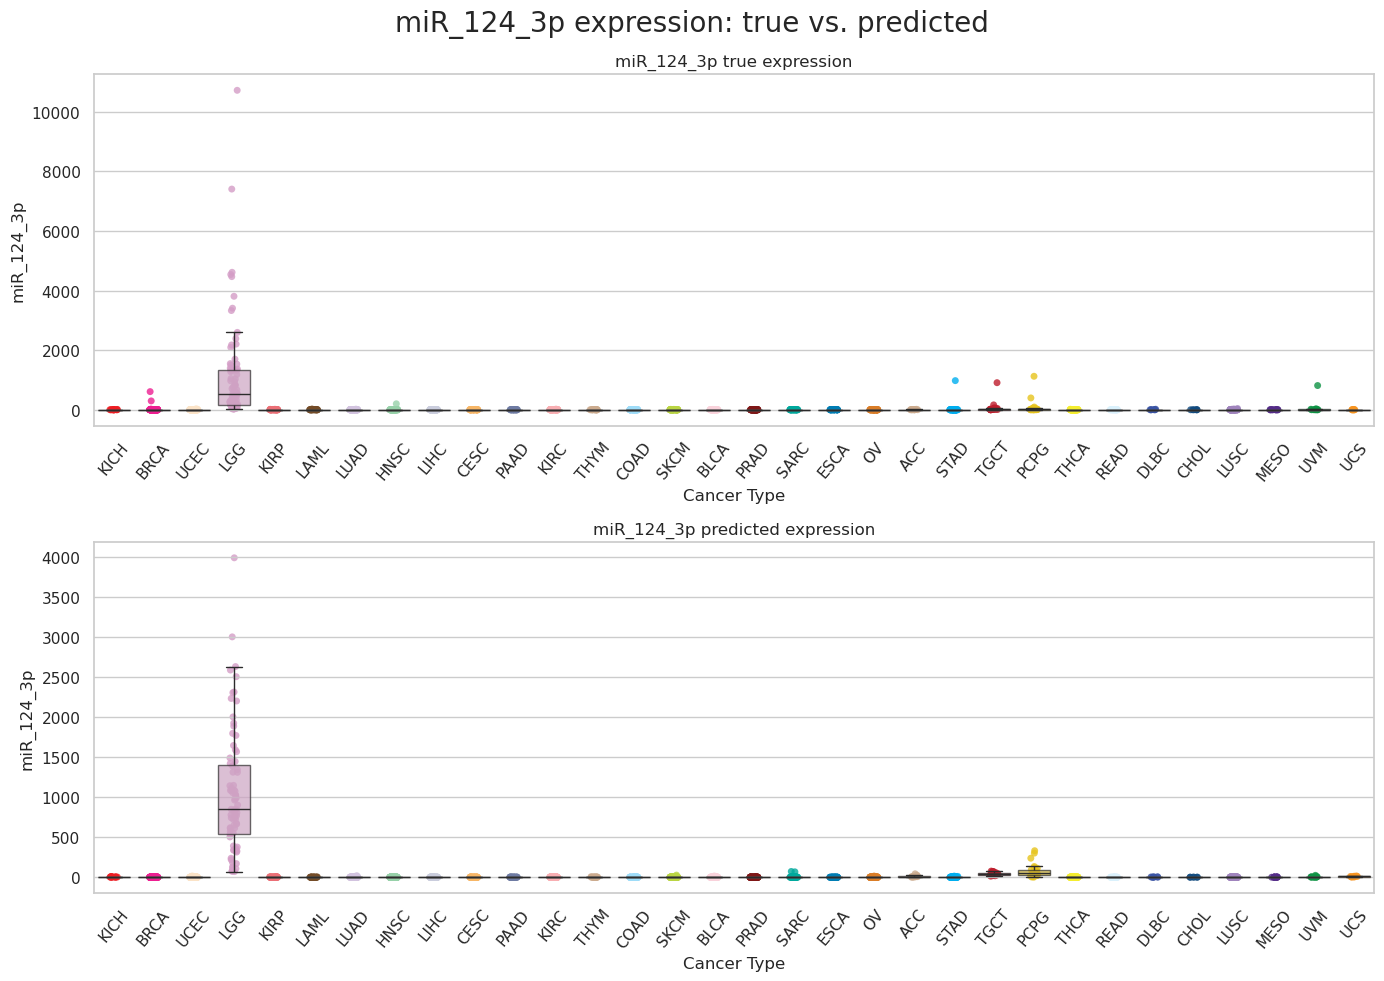

In [67]:
sns.set_style("whitegrid")
plt.figure(figsize=(14, 10))
plt.subplots_adjust(wspace=0.2, hspace=0.2)

plt.subplot(2, 1, 1)
sns.boxplot(data=miR_124_3p_test, x="cancer_type", y="y", hue="cancer_type", palette=palette, boxprops=dict(alpha=.7), showfliers=False)
sns.stripplot(data=miR_124_3p_test, x="cancer_type", y="y", hue="cancer_type", palette=palette, alpha=0.8, zorder=0)
plt.title("miR_124_3p true expression")
plt.xlabel("Cancer Type")
plt.ylabel("miR_124_3p")
plt.xticks(rotation=50)


plt.subplot(2, 1, 2)
sns.boxplot(data=miR_124_3p_test, x="cancer_type", y="X", hue="cancer_type", palette=palette, boxprops=dict(alpha=0.7), showfliers=False)
sns.stripplot(data=miR_124_3p_test, x="cancer_type", y="X", hue="cancer_type", palette=palette, alpha=0.8, zorder=0)
plt.title("miR_124_3p predicted expression")
plt.xlabel("Cancer Type")
plt.ylabel("miR_124_3p")
plt.xticks(rotation=50)

plt.suptitle("miR_124_3p expression: true vs. predicted", fontsize=20)
plt.tight_layout()

plt.show()

# Any

In [77]:
mirna_train = pd.DataFrame(
    data={
        'X': X_train[:,456], 
        'y': y_train[:,456],
        'cancer_type': train_loader.dataset.label,
        'color': train_loader.dataset.color
    }
)
mirna_val = pd.DataFrame(
    data={
        'X': X_val[:,456], 
        'y': y_val[:,456],
        'cancer_type': validation_loader.dataset.label,
        'color': validation_loader.dataset.color
    }
)
mirna_test = pd.DataFrame(
    data={
        'X': X_test[:,456], 
        'y': y_test[:,456],
        'cancer_type': test_loader.dataset.label,
        'color': test_loader.dataset.color
    }
)

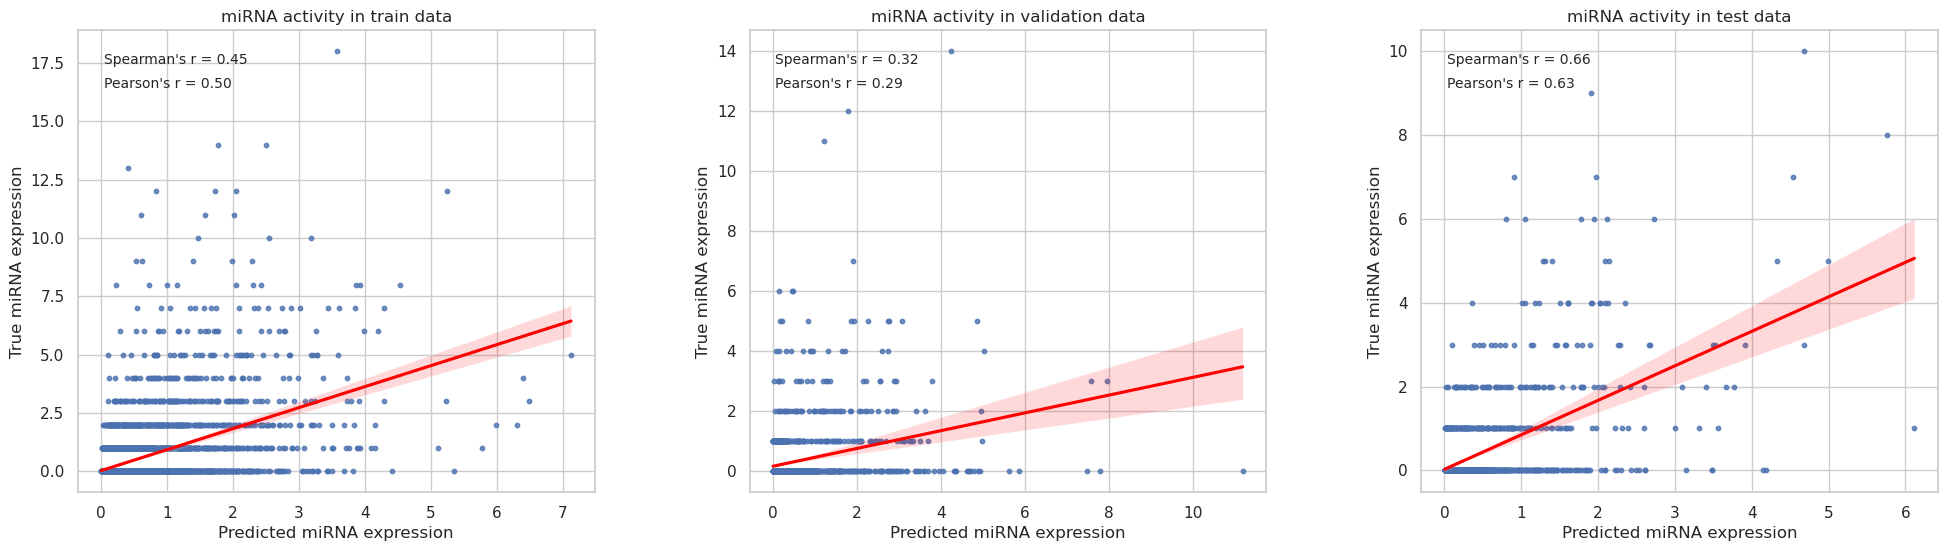

In [78]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create a figure to hold the subplots
plt.figure(figsize=(24, 6))
plt.subplots_adjust(wspace=0.3)

# Subplot Train
plt.subplot(1, 3, 1)
# Create scatterplot
sns.regplot(data=mirna_train, x="X", y="y", scatter_kws={"s": 10}, line_kws={"color": "red"})
# Calculate Spearman correlation coefficient
spearman_corr, _ = stats.spearmanr(mirna_train['X'], mirna_train['y'])
pearson_corr, _ = stats.pearsonr(mirna_train['X'], mirna_train['y'])
# Add correlation coefficient as text annotation
plt.text(0.05, 0.95, f"Spearman's r = {spearman_corr:.2f}", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.text(0.05, 0.90, f"Pearson's r = {pearson_corr:.2f}", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.xlabel("Predicted miRNA expression")
plt.ylabel("True miRNA expression")
plt.title("miRNA activity in train data")

# Subplot Train
plt.subplot(1, 3, 2)
# Create scatterplot
sns.regplot(data=mirna_val, x="X", y="y", scatter_kws={"s": 10}, line_kws={"color": "red"})
# Calculate Spearman correlation coefficient
spearman_corr, _ = stats.spearmanr(mirna_val['X'], mirna_val['y'])
pearson_corr, _ = stats.pearsonr(mirna_val['X'], mirna_val['y'])
# Add correlation coefficient as text annotation
plt.text(0.05, 0.95, f"Spearman's r = {spearman_corr:.2f}", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.text(0.05, 0.90, f"Pearson's r = {pearson_corr:.2f}", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.xlabel("Predicted miRNA expression")
plt.ylabel("True miRNA expression")
plt.title("miRNA activity in validation data")

# Subplot Train
plt.subplot(1, 3, 3)
# Create scatterplot
sns.regplot(data=mirna_test, x="X", y="y", scatter_kws={"s": 10}, line_kws={"color": "red"})
# Calculate Spearman correlation coefficient
spearman_corr, _ = stats.spearmanr(mirna__test['X'], mirna__test['y'])
pearson_corr, _ = stats.pearsonr(mirna__test['X'], mirna__test['y'])
# Add correlation coefficient as text annotation
plt.text(0.05, 0.95, f"Spearman's r = {spearman_corr:.2f}", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.text(0.05, 0.90, f"Pearson's r = {pearson_corr:.2f}", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.xlabel("Predicted miRNA expression")
plt.ylabel("True miRNA expression")
plt.title("miRNA activity in test data")

plt.show()